# ЛР №5. Ансамбли моделей машинного обучения.

В качестве набора данных мы будем использовать следующий датасет - https://www.kaggle.com/uciml/breast-cancer-wisconsin-data. Решается задача предсказания наличия рака молочной железы.
Целевым признаком является признак "Diagnosis" (M = malignant - злокачественная, B = benign - доброкачественная).

## Подготовка

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, f1_score

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

In [5]:
data = pd.read_csv('data.csv', sep=',')

In [6]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [7]:
# Проверка дубликатов среди ID
data['id'].value_counts().count() - data.shape[0]

0

In [8]:
# Удаляем незначащие столбцы
data.drop(columns=['id', 'Unnamed: 32'], inplace=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [10]:
# Проверяем наличие пропусков
data.isnull().sum()[data.isnull().sum() != 0]

Series([], dtype: int64)

In [11]:
# Проверяем баланс классов целевой переменной
pd.concat([data['diagnosis'].value_counts(), round(data['diagnosis'].value_counts()/data.shape[0]*100, 1)],
         keys=['Количество', 'Процент'], axis=1)

,Количество,Процент
B,357,62.7
M,212,37.3


In [12]:
# Кодируем целевую переменную
data['diagnosis'] = data['diagnosis'].map({'M':1,'B':0})

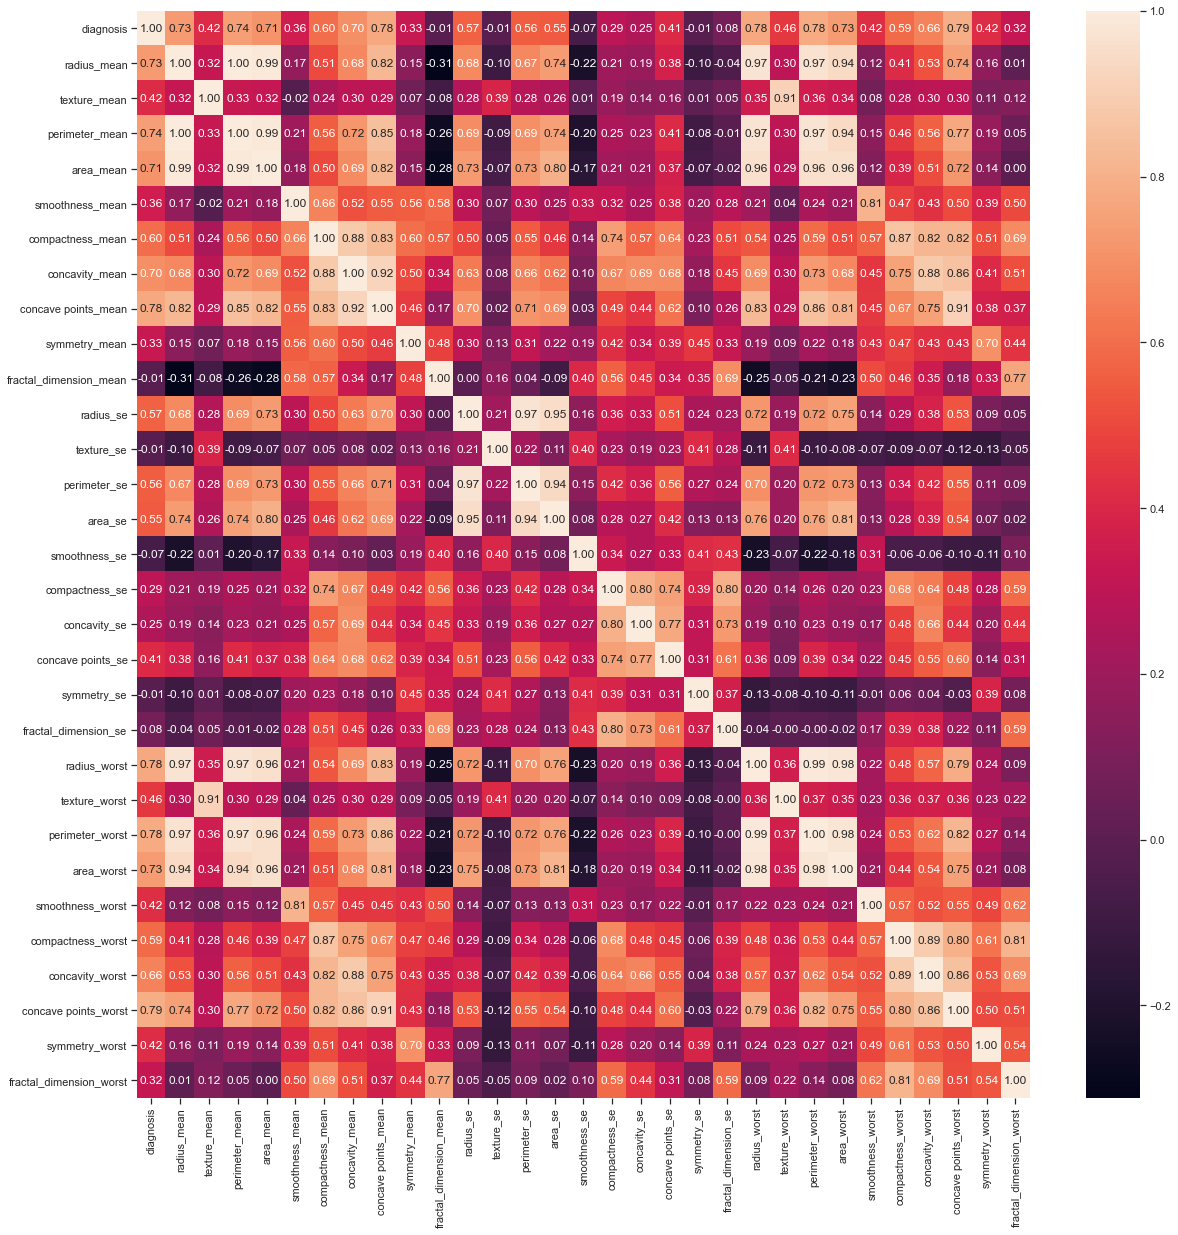

In [13]:
plt.figure(figsize=(20,20))
g = sns.heatmap(data.corr(), annot=True, fmt='.2f')

In [14]:
data = data.drop(columns=['fractal_dimension_mean', 'texture_se', 'symmetry_se'])

In [15]:
TEST_SIZE = 0.3
RANDOM_STATE = 0

In [16]:
data_X = data.drop(columns='diagnosis')
data_y = data['diagnosis']
data_X_train, data_X_test, data_y_train, data_y_test = train_test_split(data_X, data_y, test_size=TEST_SIZE, \
                                                                        random_state=RANDOM_STATE)

In [17]:
def print_metrics(X_train, Y_train, X_test, Y_test, clf):
    clf.fit(X_train, Y_train)
    target = clf.predict(X_test)
    ret = f1_score(Y_test, target)
    print(f'F1-мера: {ret}')
    fig, ax = plt.subplots()
    plot_roc_curve(clf, X_test, Y_test, ax=ax)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.show()
    print(f'Матрица ошибок:\n {confusion_matrix(Y_test, target)}')
    print(classification_report(Y_test, target, target_names=['B', 'M']))
    return ret

In [18]:
def plot_learning_curve(data_X, data_y, clf):
    train_sizes, train_scores, test_scores = learning_curve(estimator=clf, scoring='f1', X=data_X, y=data_y,
                                                            train_sizes=np.linspace(0.1, 1.0, 10), cv=5)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(7,5))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label=f'тренировочная f1-мера')
    plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
             label=f'проверочная f1-мера')
    plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
    plt.grid()
    plt.legend(loc='lower right')
    plt.xlabel('Число тренировочных образцов')
    plt.ylabel('f1-мера')
    plt.show()

### Случайный лес

F1-мера: 0.9612403100775193


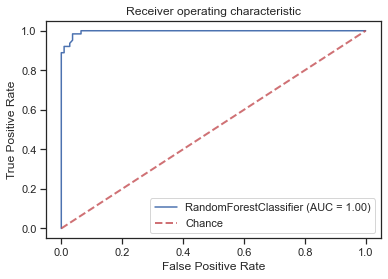

Матрица ошибок:
 [[104   4]
 [  1  62]]
              precision    recall  f1-score   support

           B       0.99      0.96      0.98       108
           M       0.94      0.98      0.96        63

    accuracy                           0.97       171
   macro avg       0.96      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



In [19]:
rfc = RandomForestClassifier(random_state=RANDOM_STATE)
res_rfc = print_metrics(data_X_train, data_y_train, data_X_test, data_y_test, rfc)

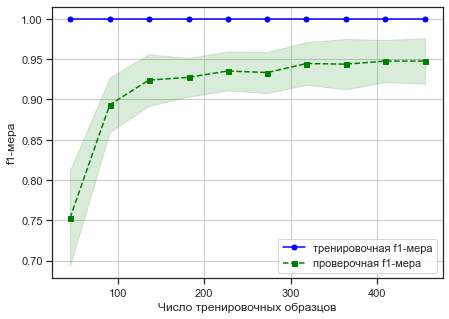

In [20]:
plot_learning_curve(data_X, data_y, rfc)

In [21]:
def show_feature_importance(importance, col_names):
    data = pd.DataFrame({'feature_names':np.array(col_names),'feature_importance':np.array(importance)})
    data.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,7))
    sns.barplot(x=data['feature_importance'], y=data['feature_names'])
    plt.title('Feature importance using DecisionTreeClassifier')
    plt.xlabel('importance')
    plt.ylabel('name')

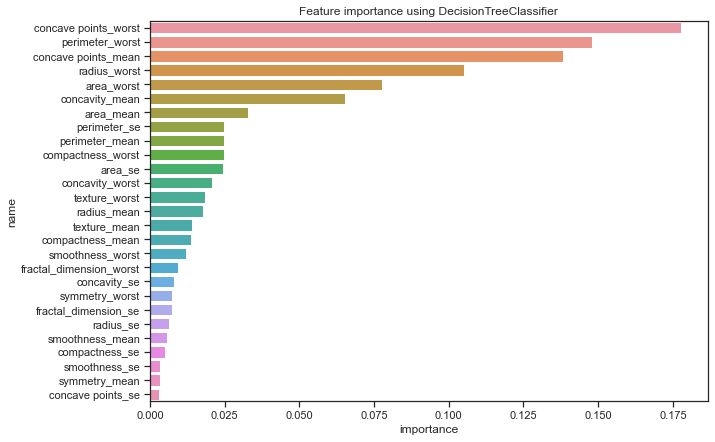

In [22]:
show_feature_importance(rfc.feature_importances_, data_X.columns.tolist())

### Бустинг

Learning rate set to 0.006952
0:	learn: 0.9305556	total: 180ms	remaining: 2m 59s
1:	learn: 0.9268293	total: 214ms	remaining: 1m 46s
2:	learn: 0.9342561	total: 246ms	remaining: 1m 21s
3:	learn: 0.9444444	total: 266ms	remaining: 1m 6s
4:	learn: 0.9452055	total: 275ms	remaining: 54.7s
5:	learn: 0.9452055	total: 283ms	remaining: 46.9s
6:	learn: 0.9488055	total: 290ms	remaining: 41.1s
7:	learn: 0.9591837	total: 296ms	remaining: 36.7s
8:	learn: 0.9520548	total: 302ms	remaining: 33.2s
9:	learn: 0.9559322	total: 307ms	remaining: 30.4s
10:	learn: 0.9556314	total: 312ms	remaining: 28.1s
11:	learn: 0.9591837	total: 318ms	remaining: 26.2s
12:	learn: 0.9594595	total: 324ms	remaining: 24.6s
13:	learn: 0.9559322	total: 329ms	remaining: 23.2s
14:	learn: 0.9629630	total: 334ms	remaining: 22s
15:	learn: 0.9624573	total: 340ms	remaining: 20.9s
16:	learn: 0.9692833	total: 345ms	remaining: 20s
17:	learn: 0.9692833	total: 351ms	remaining: 19.1s
18:	learn: 0.9692833	total: 356ms	remaining: 18.4s
19:	learn: 0

164:	learn: 0.9830508	total: 1.47s	remaining: 7.43s
165:	learn: 0.9830508	total: 1.48s	remaining: 7.41s
166:	learn: 0.9830508	total: 1.48s	remaining: 7.39s
167:	learn: 0.9830508	total: 1.49s	remaining: 7.38s
168:	learn: 0.9830508	total: 1.5s	remaining: 7.36s
169:	learn: 0.9830508	total: 1.5s	remaining: 7.35s
170:	learn: 0.9830508	total: 1.51s	remaining: 7.33s
171:	learn: 0.9830508	total: 1.52s	remaining: 7.31s
172:	learn: 0.9863946	total: 1.52s	remaining: 7.29s
173:	learn: 0.9863946	total: 1.53s	remaining: 7.27s
174:	learn: 0.9863946	total: 1.54s	remaining: 7.25s
175:	learn: 0.9863946	total: 1.54s	remaining: 7.22s
176:	learn: 0.9863946	total: 1.55s	remaining: 7.2s
177:	learn: 0.9863946	total: 1.55s	remaining: 7.18s
178:	learn: 0.9863946	total: 1.56s	remaining: 7.16s
179:	learn: 0.9863946	total: 1.57s	remaining: 7.14s
180:	learn: 0.9863946	total: 1.57s	remaining: 7.12s
181:	learn: 0.9863946	total: 1.58s	remaining: 7.09s
182:	learn: 0.9863946	total: 1.58s	remaining: 7.07s
183:	learn: 0.9

343:	learn: 0.9932432	total: 2.7s	remaining: 5.15s
344:	learn: 0.9932432	total: 2.7s	remaining: 5.13s
345:	learn: 0.9932432	total: 2.71s	remaining: 5.13s
346:	learn: 0.9932432	total: 2.72s	remaining: 5.12s
347:	learn: 0.9932432	total: 2.73s	remaining: 5.11s
348:	learn: 0.9932432	total: 2.73s	remaining: 5.1s
349:	learn: 0.9932432	total: 2.74s	remaining: 5.09s
350:	learn: 0.9932432	total: 2.75s	remaining: 5.08s
351:	learn: 0.9932432	total: 2.75s	remaining: 5.07s
352:	learn: 0.9932432	total: 2.76s	remaining: 5.06s
353:	learn: 0.9932432	total: 2.77s	remaining: 5.05s
354:	learn: 0.9932432	total: 2.77s	remaining: 5.04s
355:	learn: 0.9932432	total: 2.78s	remaining: 5.02s
356:	learn: 0.9932432	total: 2.78s	remaining: 5.01s
357:	learn: 0.9932432	total: 2.79s	remaining: 5s
358:	learn: 0.9932432	total: 2.79s	remaining: 4.99s
359:	learn: 0.9932432	total: 2.8s	remaining: 4.98s
360:	learn: 0.9932432	total: 2.8s	remaining: 4.96s
361:	learn: 0.9932432	total: 2.81s	remaining: 4.95s
362:	learn: 0.993243

513:	learn: 1.0000000	total: 3.93s	remaining: 3.71s
514:	learn: 1.0000000	total: 3.94s	remaining: 3.71s
515:	learn: 1.0000000	total: 3.94s	remaining: 3.7s
516:	learn: 1.0000000	total: 3.95s	remaining: 3.69s
517:	learn: 1.0000000	total: 3.96s	remaining: 3.68s
518:	learn: 1.0000000	total: 3.96s	remaining: 3.67s
519:	learn: 1.0000000	total: 3.97s	remaining: 3.66s
520:	learn: 1.0000000	total: 3.97s	remaining: 3.65s
521:	learn: 1.0000000	total: 3.98s	remaining: 3.64s
522:	learn: 1.0000000	total: 3.98s	remaining: 3.63s
523:	learn: 1.0000000	total: 3.99s	remaining: 3.63s
524:	learn: 1.0000000	total: 4s	remaining: 3.62s
525:	learn: 1.0000000	total: 4s	remaining: 3.61s
526:	learn: 1.0000000	total: 4.01s	remaining: 3.6s
527:	learn: 1.0000000	total: 4.01s	remaining: 3.59s
528:	learn: 1.0000000	total: 4.02s	remaining: 3.58s
529:	learn: 1.0000000	total: 4.02s	remaining: 3.57s
530:	learn: 1.0000000	total: 4.03s	remaining: 3.56s
531:	learn: 1.0000000	total: 4.03s	remaining: 3.55s
532:	learn: 1.000000

676:	learn: 1.0000000	total: 5.16s	remaining: 2.46s
677:	learn: 1.0000000	total: 5.17s	remaining: 2.45s
678:	learn: 1.0000000	total: 5.18s	remaining: 2.45s
679:	learn: 1.0000000	total: 5.19s	remaining: 2.44s
680:	learn: 1.0000000	total: 5.19s	remaining: 2.43s
681:	learn: 1.0000000	total: 5.2s	remaining: 2.42s
682:	learn: 1.0000000	total: 5.2s	remaining: 2.42s
683:	learn: 1.0000000	total: 5.21s	remaining: 2.41s
684:	learn: 1.0000000	total: 5.21s	remaining: 2.4s
685:	learn: 1.0000000	total: 5.22s	remaining: 2.39s
686:	learn: 1.0000000	total: 5.23s	remaining: 2.38s
687:	learn: 1.0000000	total: 5.23s	remaining: 2.37s
688:	learn: 1.0000000	total: 5.24s	remaining: 2.36s
689:	learn: 1.0000000	total: 5.24s	remaining: 2.35s
690:	learn: 1.0000000	total: 5.25s	remaining: 2.35s
691:	learn: 1.0000000	total: 5.25s	remaining: 2.34s
692:	learn: 1.0000000	total: 5.26s	remaining: 2.33s
693:	learn: 1.0000000	total: 5.26s	remaining: 2.32s
694:	learn: 1.0000000	total: 5.27s	remaining: 2.31s
695:	learn: 1.0

846:	learn: 1.0000000	total: 6.39s	remaining: 1.15s
847:	learn: 1.0000000	total: 6.4s	remaining: 1.15s
848:	learn: 1.0000000	total: 6.41s	remaining: 1.14s
849:	learn: 1.0000000	total: 6.41s	remaining: 1.13s
850:	learn: 1.0000000	total: 6.42s	remaining: 1.12s
851:	learn: 1.0000000	total: 6.42s	remaining: 1.12s
852:	learn: 1.0000000	total: 6.43s	remaining: 1.11s
853:	learn: 1.0000000	total: 6.44s	remaining: 1.1s
854:	learn: 1.0000000	total: 6.44s	remaining: 1.09s
855:	learn: 1.0000000	total: 6.45s	remaining: 1.08s
856:	learn: 1.0000000	total: 6.45s	remaining: 1.08s
857:	learn: 1.0000000	total: 6.46s	remaining: 1.07s
858:	learn: 1.0000000	total: 6.47s	remaining: 1.06s
859:	learn: 1.0000000	total: 6.47s	remaining: 1.05s
860:	learn: 1.0000000	total: 6.48s	remaining: 1.05s
861:	learn: 1.0000000	total: 6.49s	remaining: 1.04s
862:	learn: 1.0000000	total: 6.49s	remaining: 1.03s
863:	learn: 1.0000000	total: 6.5s	remaining: 1.02s
864:	learn: 1.0000000	total: 6.5s	remaining: 1.01s
865:	learn: 1.00

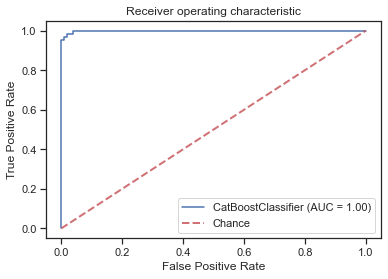

Матрица ошибок:
 [[106   2]
 [  1  62]]
              precision    recall  f1-score   support

           B       0.99      0.98      0.99       108
           M       0.97      0.98      0.98        63

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



In [23]:
boost_model = CatBoostClassifier(eval_metric='F1', random_seed=RANDOM_STATE)
res_boost = print_metrics(data_X_train, data_y_train, data_X_test, data_y_test, boost_model)

Learning rate set to 0.002741
0:	learn: 0.9876543	total: 5.1ms	remaining: 5.1s
1:	learn: 1.0000000	total: 8.3ms	remaining: 4.14s
2:	learn: 1.0000000	total: 12.3ms	remaining: 4.1s
3:	learn: 1.0000000	total: 16.4ms	remaining: 4.08s
4:	learn: 0.9879518	total: 19.8ms	remaining: 3.93s
5:	learn: 0.9879518	total: 23.3ms	remaining: 3.86s
6:	learn: 0.9879518	total: 27.3ms	remaining: 3.87s
7:	learn: 0.9879518	total: 30.8ms	remaining: 3.81s
8:	learn: 0.9879518	total: 34.1ms	remaining: 3.75s
9:	learn: 0.9879518	total: 38ms	remaining: 3.76s
10:	learn: 0.9879518	total: 41.4ms	remaining: 3.72s
11:	learn: 0.9879518	total: 44.5ms	remaining: 3.66s
12:	learn: 0.9879518	total: 47.8ms	remaining: 3.63s
13:	learn: 0.9879518	total: 51.2ms	remaining: 3.61s
14:	learn: 0.9879518	total: 54.6ms	remaining: 3.58s
15:	learn: 0.9879518	total: 58.1ms	remaining: 3.58s
16:	learn: 0.9879518	total: 61.4ms	remaining: 3.55s
17:	learn: 0.9879518	total: 64.9ms	remaining: 3.54s
18:	learn: 0.9879518	total: 67.9ms	remaining: 3.5s

225:	learn: 1.0000000	total: 468ms	remaining: 1.6s
226:	learn: 1.0000000	total: 470ms	remaining: 1.6s
227:	learn: 1.0000000	total: 472ms	remaining: 1.6s
228:	learn: 1.0000000	total: 474ms	remaining: 1.6s
229:	learn: 1.0000000	total: 476ms	remaining: 1.59s
230:	learn: 1.0000000	total: 477ms	remaining: 1.59s
231:	learn: 1.0000000	total: 479ms	remaining: 1.59s
232:	learn: 1.0000000	total: 481ms	remaining: 1.58s
233:	learn: 1.0000000	total: 483ms	remaining: 1.58s
234:	learn: 1.0000000	total: 485ms	remaining: 1.58s
235:	learn: 1.0000000	total: 487ms	remaining: 1.57s
236:	learn: 1.0000000	total: 490ms	remaining: 1.58s
237:	learn: 1.0000000	total: 492ms	remaining: 1.57s
238:	learn: 1.0000000	total: 494ms	remaining: 1.57s
239:	learn: 1.0000000	total: 496ms	remaining: 1.57s
240:	learn: 1.0000000	total: 498ms	remaining: 1.57s
241:	learn: 1.0000000	total: 500ms	remaining: 1.57s
242:	learn: 1.0000000	total: 502ms	remaining: 1.56s
243:	learn: 1.0000000	total: 504ms	remaining: 1.56s
244:	learn: 1.00

455:	learn: 1.0000000	total: 933ms	remaining: 1.11s
456:	learn: 1.0000000	total: 935ms	remaining: 1.11s
457:	learn: 1.0000000	total: 936ms	remaining: 1.11s
458:	learn: 1.0000000	total: 938ms	remaining: 1.1s
459:	learn: 1.0000000	total: 940ms	remaining: 1.1s
460:	learn: 1.0000000	total: 942ms	remaining: 1.1s
461:	learn: 1.0000000	total: 944ms	remaining: 1.1s
462:	learn: 1.0000000	total: 946ms	remaining: 1.1s
463:	learn: 1.0000000	total: 948ms	remaining: 1.09s
464:	learn: 1.0000000	total: 950ms	remaining: 1.09s
465:	learn: 1.0000000	total: 952ms	remaining: 1.09s
466:	learn: 1.0000000	total: 954ms	remaining: 1.09s
467:	learn: 1.0000000	total: 956ms	remaining: 1.09s
468:	learn: 1.0000000	total: 958ms	remaining: 1.08s
469:	learn: 1.0000000	total: 960ms	remaining: 1.08s
470:	learn: 1.0000000	total: 963ms	remaining: 1.08s
471:	learn: 1.0000000	total: 965ms	remaining: 1.08s
472:	learn: 1.0000000	total: 968ms	remaining: 1.08s
473:	learn: 1.0000000	total: 970ms	remaining: 1.07s
474:	learn: 1.000

633:	learn: 1.0000000	total: 1.24s	remaining: 715ms
634:	learn: 1.0000000	total: 1.24s	remaining: 714ms
635:	learn: 1.0000000	total: 1.24s	remaining: 712ms
636:	learn: 1.0000000	total: 1.25s	remaining: 710ms
637:	learn: 1.0000000	total: 1.25s	remaining: 708ms
638:	learn: 1.0000000	total: 1.25s	remaining: 706ms
639:	learn: 1.0000000	total: 1.25s	remaining: 704ms
640:	learn: 1.0000000	total: 1.25s	remaining: 703ms
641:	learn: 1.0000000	total: 1.26s	remaining: 701ms
642:	learn: 1.0000000	total: 1.26s	remaining: 700ms
643:	learn: 1.0000000	total: 1.26s	remaining: 698ms
644:	learn: 1.0000000	total: 1.26s	remaining: 696ms
645:	learn: 1.0000000	total: 1.27s	remaining: 695ms
646:	learn: 1.0000000	total: 1.27s	remaining: 693ms
647:	learn: 1.0000000	total: 1.27s	remaining: 691ms
648:	learn: 1.0000000	total: 1.27s	remaining: 689ms
649:	learn: 1.0000000	total: 1.27s	remaining: 687ms
650:	learn: 1.0000000	total: 1.28s	remaining: 685ms
651:	learn: 1.0000000	total: 1.28s	remaining: 683ms
652:	learn: 

809:	learn: 1.0000000	total: 1.55s	remaining: 363ms
810:	learn: 1.0000000	total: 1.55s	remaining: 361ms
811:	learn: 1.0000000	total: 1.55s	remaining: 359ms
812:	learn: 1.0000000	total: 1.55s	remaining: 357ms
813:	learn: 1.0000000	total: 1.55s	remaining: 356ms
814:	learn: 1.0000000	total: 1.56s	remaining: 354ms
815:	learn: 1.0000000	total: 1.56s	remaining: 352ms
816:	learn: 1.0000000	total: 1.56s	remaining: 350ms
817:	learn: 1.0000000	total: 1.56s	remaining: 348ms
818:	learn: 1.0000000	total: 1.57s	remaining: 346ms
819:	learn: 1.0000000	total: 1.57s	remaining: 345ms
820:	learn: 1.0000000	total: 1.57s	remaining: 343ms
821:	learn: 1.0000000	total: 1.57s	remaining: 341ms
822:	learn: 1.0000000	total: 1.57s	remaining: 339ms
823:	learn: 1.0000000	total: 1.58s	remaining: 337ms
824:	learn: 1.0000000	total: 1.58s	remaining: 335ms
825:	learn: 1.0000000	total: 1.58s	remaining: 333ms
826:	learn: 1.0000000	total: 1.58s	remaining: 331ms
827:	learn: 1.0000000	total: 1.58s	remaining: 329ms
828:	learn: 

976:	learn: 1.0000000	total: 1.86s	remaining: 43.8ms
977:	learn: 1.0000000	total: 1.86s	remaining: 41.9ms
978:	learn: 1.0000000	total: 1.86s	remaining: 40ms
979:	learn: 1.0000000	total: 1.87s	remaining: 38.1ms
980:	learn: 1.0000000	total: 1.87s	remaining: 36.2ms
981:	learn: 1.0000000	total: 1.87s	remaining: 34.4ms
982:	learn: 1.0000000	total: 1.88s	remaining: 32.5ms
983:	learn: 1.0000000	total: 1.88s	remaining: 30.6ms
984:	learn: 1.0000000	total: 1.89s	remaining: 28.7ms
985:	learn: 1.0000000	total: 1.89s	remaining: 26.8ms
986:	learn: 1.0000000	total: 1.89s	remaining: 24.9ms
987:	learn: 1.0000000	total: 1.89s	remaining: 23ms
988:	learn: 1.0000000	total: 1.9s	remaining: 21.1ms
989:	learn: 1.0000000	total: 1.9s	remaining: 19.2ms
990:	learn: 1.0000000	total: 1.9s	remaining: 17.3ms
991:	learn: 1.0000000	total: 1.9s	remaining: 15.4ms
992:	learn: 1.0000000	total: 1.91s	remaining: 13.4ms
993:	learn: 1.0000000	total: 1.91s	remaining: 11.5ms
994:	learn: 1.0000000	total: 1.91s	remaining: 9.6ms
99

186:	learn: 0.9921260	total: 534ms	remaining: 2.32s
187:	learn: 0.9921260	total: 537ms	remaining: 2.32s
188:	learn: 0.9921260	total: 540ms	remaining: 2.31s
189:	learn: 0.9921260	total: 542ms	remaining: 2.31s
190:	learn: 0.9921260	total: 544ms	remaining: 2.3s
191:	learn: 0.9921260	total: 547ms	remaining: 2.3s
192:	learn: 0.9921260	total: 550ms	remaining: 2.3s
193:	learn: 0.9921260	total: 554ms	remaining: 2.3s
194:	learn: 0.9921260	total: 556ms	remaining: 2.3s
195:	learn: 0.9921260	total: 560ms	remaining: 2.3s
196:	learn: 0.9921260	total: 563ms	remaining: 2.29s
197:	learn: 0.9921260	total: 566ms	remaining: 2.29s
198:	learn: 0.9921260	total: 571ms	remaining: 2.3s
199:	learn: 0.9921260	total: 573ms	remaining: 2.29s
200:	learn: 0.9921260	total: 578ms	remaining: 2.3s
201:	learn: 0.9921260	total: 580ms	remaining: 2.29s
202:	learn: 0.9921260	total: 583ms	remaining: 2.29s
203:	learn: 0.9921260	total: 586ms	remaining: 2.28s
204:	learn: 0.9921260	total: 588ms	remaining: 2.28s
205:	learn: 1.000000

371:	learn: 1.0000000	total: 1.02s	remaining: 1.72s
372:	learn: 1.0000000	total: 1.02s	remaining: 1.72s
373:	learn: 1.0000000	total: 1.02s	remaining: 1.71s
374:	learn: 1.0000000	total: 1.03s	remaining: 1.71s
375:	learn: 1.0000000	total: 1.03s	remaining: 1.71s
376:	learn: 1.0000000	total: 1.03s	remaining: 1.71s
377:	learn: 1.0000000	total: 1.04s	remaining: 1.71s
378:	learn: 1.0000000	total: 1.04s	remaining: 1.71s
379:	learn: 1.0000000	total: 1.04s	remaining: 1.7s
380:	learn: 1.0000000	total: 1.04s	remaining: 1.7s
381:	learn: 1.0000000	total: 1.05s	remaining: 1.69s
382:	learn: 1.0000000	total: 1.05s	remaining: 1.69s
383:	learn: 1.0000000	total: 1.05s	remaining: 1.69s
384:	learn: 1.0000000	total: 1.05s	remaining: 1.69s
385:	learn: 1.0000000	total: 1.06s	remaining: 1.68s
386:	learn: 1.0000000	total: 1.06s	remaining: 1.68s
387:	learn: 1.0000000	total: 1.06s	remaining: 1.68s
388:	learn: 1.0000000	total: 1.06s	remaining: 1.67s
389:	learn: 1.0000000	total: 1.07s	remaining: 1.67s
390:	learn: 1.

580:	learn: 1.0000000	total: 1.67s	remaining: 1.2s
581:	learn: 1.0000000	total: 1.67s	remaining: 1.2s
582:	learn: 1.0000000	total: 1.67s	remaining: 1.2s
583:	learn: 1.0000000	total: 1.68s	remaining: 1.19s
584:	learn: 1.0000000	total: 1.68s	remaining: 1.19s
585:	learn: 1.0000000	total: 1.68s	remaining: 1.19s
586:	learn: 1.0000000	total: 1.69s	remaining: 1.19s
587:	learn: 1.0000000	total: 1.69s	remaining: 1.18s
588:	learn: 1.0000000	total: 1.69s	remaining: 1.18s
589:	learn: 1.0000000	total: 1.69s	remaining: 1.18s
590:	learn: 1.0000000	total: 1.7s	remaining: 1.17s
591:	learn: 1.0000000	total: 1.7s	remaining: 1.17s
592:	learn: 1.0000000	total: 1.7s	remaining: 1.17s
593:	learn: 1.0000000	total: 1.7s	remaining: 1.17s
594:	learn: 1.0000000	total: 1.71s	remaining: 1.16s
595:	learn: 1.0000000	total: 1.71s	remaining: 1.16s
596:	learn: 1.0000000	total: 1.71s	remaining: 1.16s
597:	learn: 1.0000000	total: 1.71s	remaining: 1.15s
598:	learn: 1.0000000	total: 1.72s	remaining: 1.15s
599:	learn: 1.00000

767:	learn: 1.0000000	total: 2.15s	remaining: 650ms
768:	learn: 1.0000000	total: 2.15s	remaining: 647ms
769:	learn: 1.0000000	total: 2.16s	remaining: 644ms
770:	learn: 1.0000000	total: 2.16s	remaining: 642ms
771:	learn: 1.0000000	total: 2.16s	remaining: 639ms
772:	learn: 1.0000000	total: 2.17s	remaining: 636ms
773:	learn: 1.0000000	total: 2.17s	remaining: 633ms
774:	learn: 1.0000000	total: 2.17s	remaining: 630ms
775:	learn: 1.0000000	total: 2.17s	remaining: 628ms
776:	learn: 1.0000000	total: 2.18s	remaining: 625ms
777:	learn: 1.0000000	total: 2.18s	remaining: 622ms
778:	learn: 1.0000000	total: 2.18s	remaining: 620ms
779:	learn: 1.0000000	total: 2.19s	remaining: 617ms
780:	learn: 1.0000000	total: 2.19s	remaining: 614ms
781:	learn: 1.0000000	total: 2.19s	remaining: 611ms
782:	learn: 1.0000000	total: 2.19s	remaining: 608ms
783:	learn: 1.0000000	total: 2.2s	remaining: 605ms
784:	learn: 1.0000000	total: 2.2s	remaining: 602ms
785:	learn: 1.0000000	total: 2.2s	remaining: 599ms
786:	learn: 1.0

965:	learn: 1.0000000	total: 2.82s	remaining: 99.3ms
966:	learn: 1.0000000	total: 2.83s	remaining: 96.5ms
967:	learn: 1.0000000	total: 2.83s	remaining: 93.5ms
968:	learn: 1.0000000	total: 2.83s	remaining: 90.7ms
969:	learn: 1.0000000	total: 2.84s	remaining: 87.8ms
970:	learn: 1.0000000	total: 2.84s	remaining: 84.9ms
971:	learn: 1.0000000	total: 2.85s	remaining: 82ms
972:	learn: 1.0000000	total: 2.85s	remaining: 79.2ms
973:	learn: 1.0000000	total: 2.85s	remaining: 76.2ms
974:	learn: 1.0000000	total: 2.86s	remaining: 73.3ms
975:	learn: 1.0000000	total: 2.86s	remaining: 70.4ms
976:	learn: 1.0000000	total: 2.86s	remaining: 67.4ms
977:	learn: 1.0000000	total: 2.87s	remaining: 64.5ms
978:	learn: 1.0000000	total: 2.87s	remaining: 61.5ms
979:	learn: 1.0000000	total: 2.87s	remaining: 58.6ms
980:	learn: 1.0000000	total: 2.87s	remaining: 55.7ms
981:	learn: 1.0000000	total: 2.88s	remaining: 52.7ms
982:	learn: 1.0000000	total: 2.88s	remaining: 49.8ms
983:	learn: 1.0000000	total: 2.88s	remaining: 46

144:	learn: 0.9937888	total: 500ms	remaining: 2.95s
145:	learn: 0.9937888	total: 504ms	remaining: 2.94s
146:	learn: 0.9937888	total: 507ms	remaining: 2.94s
147:	learn: 0.9937888	total: 511ms	remaining: 2.94s
148:	learn: 0.9937888	total: 515ms	remaining: 2.94s
149:	learn: 0.9937888	total: 519ms	remaining: 2.94s
150:	learn: 0.9937888	total: 523ms	remaining: 2.94s
151:	learn: 0.9937888	total: 528ms	remaining: 2.94s
152:	learn: 0.9937888	total: 531ms	remaining: 2.94s
153:	learn: 0.9937888	total: 535ms	remaining: 2.94s
154:	learn: 0.9937888	total: 539ms	remaining: 2.94s
155:	learn: 0.9937888	total: 542ms	remaining: 2.93s
156:	learn: 0.9937888	total: 545ms	remaining: 2.92s
157:	learn: 0.9937888	total: 548ms	remaining: 2.92s
158:	learn: 0.9937888	total: 551ms	remaining: 2.91s
159:	learn: 0.9937888	total: 554ms	remaining: 2.91s
160:	learn: 0.9937888	total: 557ms	remaining: 2.9s
161:	learn: 0.9937888	total: 560ms	remaining: 2.9s
162:	learn: 0.9937888	total: 564ms	remaining: 2.89s
163:	learn: 0.

330:	learn: 0.9937888	total: 1.18s	remaining: 2.37s
331:	learn: 0.9937888	total: 1.18s	remaining: 2.37s
332:	learn: 0.9937888	total: 1.18s	remaining: 2.37s
333:	learn: 0.9937888	total: 1.19s	remaining: 2.37s
334:	learn: 0.9937888	total: 1.19s	remaining: 2.37s
335:	learn: 0.9937888	total: 1.2s	remaining: 2.37s
336:	learn: 0.9937888	total: 1.2s	remaining: 2.37s
337:	learn: 0.9937888	total: 1.21s	remaining: 2.36s
338:	learn: 0.9937888	total: 1.21s	remaining: 2.36s
339:	learn: 0.9937888	total: 1.22s	remaining: 2.36s
340:	learn: 0.9937888	total: 1.22s	remaining: 2.35s
341:	learn: 0.9937888	total: 1.22s	remaining: 2.35s
342:	learn: 0.9937888	total: 1.23s	remaining: 2.35s
343:	learn: 0.9937888	total: 1.23s	remaining: 2.34s
344:	learn: 0.9937888	total: 1.23s	remaining: 2.34s
345:	learn: 0.9937888	total: 1.24s	remaining: 2.34s
346:	learn: 0.9937888	total: 1.24s	remaining: 2.33s
347:	learn: 0.9937888	total: 1.24s	remaining: 2.33s
348:	learn: 0.9937888	total: 1.25s	remaining: 2.32s
349:	learn: 0.

503:	learn: 1.0000000	total: 1.84s	remaining: 1.81s
504:	learn: 1.0000000	total: 1.85s	remaining: 1.81s
505:	learn: 1.0000000	total: 1.85s	remaining: 1.81s
506:	learn: 1.0000000	total: 1.86s	remaining: 1.81s
507:	learn: 1.0000000	total: 1.86s	remaining: 1.8s
508:	learn: 1.0000000	total: 1.87s	remaining: 1.8s
509:	learn: 1.0000000	total: 1.87s	remaining: 1.8s
510:	learn: 1.0000000	total: 1.88s	remaining: 1.79s
511:	learn: 1.0000000	total: 1.88s	remaining: 1.79s
512:	learn: 1.0000000	total: 1.88s	remaining: 1.79s
513:	learn: 1.0000000	total: 1.89s	remaining: 1.78s
514:	learn: 1.0000000	total: 1.89s	remaining: 1.78s
515:	learn: 1.0000000	total: 1.89s	remaining: 1.78s
516:	learn: 1.0000000	total: 1.9s	remaining: 1.77s
517:	learn: 1.0000000	total: 1.9s	remaining: 1.77s
518:	learn: 1.0000000	total: 1.91s	remaining: 1.76s
519:	learn: 1.0000000	total: 1.91s	remaining: 1.76s
520:	learn: 1.0000000	total: 1.91s	remaining: 1.76s
521:	learn: 1.0000000	total: 1.92s	remaining: 1.75s
522:	learn: 1.000

668:	learn: 1.0000000	total: 2.52s	remaining: 1.25s
669:	learn: 1.0000000	total: 2.52s	remaining: 1.24s
670:	learn: 1.0000000	total: 2.52s	remaining: 1.24s
671:	learn: 1.0000000	total: 2.53s	remaining: 1.23s
672:	learn: 1.0000000	total: 2.53s	remaining: 1.23s
673:	learn: 1.0000000	total: 2.54s	remaining: 1.23s
674:	learn: 1.0000000	total: 2.54s	remaining: 1.22s
675:	learn: 1.0000000	total: 2.59s	remaining: 1.24s
676:	learn: 1.0000000	total: 2.61s	remaining: 1.25s
677:	learn: 1.0000000	total: 2.63s	remaining: 1.25s
678:	learn: 1.0000000	total: 2.64s	remaining: 1.25s
679:	learn: 1.0000000	total: 2.65s	remaining: 1.25s
680:	learn: 1.0000000	total: 2.65s	remaining: 1.24s
681:	learn: 1.0000000	total: 2.66s	remaining: 1.24s
682:	learn: 1.0000000	total: 2.66s	remaining: 1.24s
683:	learn: 1.0000000	total: 2.67s	remaining: 1.23s
684:	learn: 1.0000000	total: 2.67s	remaining: 1.23s
685:	learn: 1.0000000	total: 2.68s	remaining: 1.23s
686:	learn: 1.0000000	total: 2.68s	remaining: 1.22s
687:	learn: 

848:	learn: 1.0000000	total: 3.53s	remaining: 629ms
849:	learn: 1.0000000	total: 3.54s	remaining: 624ms
850:	learn: 1.0000000	total: 3.54s	remaining: 620ms
851:	learn: 1.0000000	total: 3.54s	remaining: 616ms
852:	learn: 1.0000000	total: 3.55s	remaining: 612ms
853:	learn: 1.0000000	total: 3.55s	remaining: 607ms
854:	learn: 1.0000000	total: 3.56s	remaining: 603ms
855:	learn: 1.0000000	total: 3.56s	remaining: 599ms
856:	learn: 1.0000000	total: 3.56s	remaining: 595ms
857:	learn: 1.0000000	total: 3.57s	remaining: 591ms
858:	learn: 1.0000000	total: 3.57s	remaining: 586ms
859:	learn: 1.0000000	total: 3.57s	remaining: 582ms
860:	learn: 1.0000000	total: 3.58s	remaining: 578ms
861:	learn: 1.0000000	total: 3.58s	remaining: 573ms
862:	learn: 1.0000000	total: 3.58s	remaining: 569ms
863:	learn: 1.0000000	total: 3.59s	remaining: 565ms
864:	learn: 1.0000000	total: 3.59s	remaining: 560ms
865:	learn: 1.0000000	total: 3.59s	remaining: 556ms
866:	learn: 1.0000000	total: 3.6s	remaining: 552ms
867:	learn: 1

12:	learn: 0.9803922	total: 54ms	remaining: 4.1s
13:	learn: 0.9803922	total: 58.1ms	remaining: 4.09s
14:	learn: 0.9803922	total: 62.1ms	remaining: 4.08s
15:	learn: 0.9803922	total: 65.8ms	remaining: 4.04s
16:	learn: 0.9803922	total: 70.2ms	remaining: 4.06s
17:	learn: 0.9803922	total: 77.9ms	remaining: 4.25s
18:	learn: 0.9803922	total: 86.4ms	remaining: 4.46s
19:	learn: 0.9853659	total: 92.8ms	remaining: 4.55s
20:	learn: 0.9805825	total: 96.9ms	remaining: 4.52s
21:	learn: 0.9853659	total: 105ms	remaining: 4.69s
22:	learn: 0.9853659	total: 111ms	remaining: 4.71s
23:	learn: 0.9853659	total: 119ms	remaining: 4.83s
24:	learn: 0.9853659	total: 125ms	remaining: 4.87s
25:	learn: 0.9853659	total: 133ms	remaining: 4.99s
26:	learn: 0.9853659	total: 140ms	remaining: 5.03s
27:	learn: 0.9853659	total: 144ms	remaining: 4.99s
28:	learn: 0.9853659	total: 154ms	remaining: 5.14s
29:	learn: 0.9853659	total: 158ms	remaining: 5.11s
30:	learn: 0.9853659	total: 166ms	remaining: 5.2s
31:	learn: 0.9853659	total

178:	learn: 0.9950739	total: 1.27s	remaining: 5.81s
179:	learn: 0.9950739	total: 1.28s	remaining: 5.82s
180:	learn: 0.9950739	total: 1.28s	remaining: 5.81s
181:	learn: 0.9950739	total: 1.29s	remaining: 5.8s
182:	learn: 0.9950739	total: 1.29s	remaining: 5.78s
183:	learn: 0.9950739	total: 1.3s	remaining: 5.77s
184:	learn: 0.9950739	total: 1.31s	remaining: 5.76s
185:	learn: 0.9950739	total: 1.32s	remaining: 5.76s
186:	learn: 0.9950739	total: 1.32s	remaining: 5.74s
187:	learn: 0.9950739	total: 1.33s	remaining: 5.75s
188:	learn: 0.9950739	total: 1.33s	remaining: 5.73s
189:	learn: 0.9950739	total: 1.34s	remaining: 5.74s
190:	learn: 0.9950739	total: 1.35s	remaining: 5.72s
191:	learn: 0.9950739	total: 1.36s	remaining: 5.74s
192:	learn: 0.9950739	total: 1.37s	remaining: 5.72s
193:	learn: 0.9950739	total: 1.38s	remaining: 5.72s
194:	learn: 0.9950739	total: 1.38s	remaining: 5.7s
195:	learn: 0.9950739	total: 1.39s	remaining: 5.7s
196:	learn: 0.9950739	total: 1.4s	remaining: 5.69s
197:	learn: 0.995

357:	learn: 0.9950739	total: 2.47s	remaining: 4.42s
358:	learn: 0.9950739	total: 2.47s	remaining: 4.41s
359:	learn: 0.9950739	total: 2.48s	remaining: 4.4s
360:	learn: 0.9950739	total: 2.48s	remaining: 4.39s
361:	learn: 0.9950739	total: 2.48s	remaining: 4.38s
362:	learn: 0.9950739	total: 2.49s	remaining: 4.36s
363:	learn: 0.9950739	total: 2.49s	remaining: 4.35s
364:	learn: 0.9950739	total: 2.5s	remaining: 4.34s
365:	learn: 0.9950739	total: 2.5s	remaining: 4.33s
366:	learn: 0.9950739	total: 2.5s	remaining: 4.32s
367:	learn: 0.9950739	total: 2.51s	remaining: 4.31s
368:	learn: 0.9950739	total: 2.51s	remaining: 4.29s
369:	learn: 0.9950739	total: 2.52s	remaining: 4.28s
370:	learn: 0.9950739	total: 2.52s	remaining: 4.27s
371:	learn: 0.9950739	total: 2.52s	remaining: 4.26s
372:	learn: 0.9950739	total: 2.53s	remaining: 4.25s
373:	learn: 0.9950739	total: 2.53s	remaining: 4.24s
374:	learn: 0.9950739	total: 2.53s	remaining: 4.22s
375:	learn: 0.9950739	total: 2.54s	remaining: 4.21s
376:	learn: 0.99

541:	learn: 1.0000000	total: 3.32s	remaining: 2.8s
542:	learn: 1.0000000	total: 3.32s	remaining: 2.8s
543:	learn: 1.0000000	total: 3.33s	remaining: 2.79s
544:	learn: 1.0000000	total: 3.33s	remaining: 2.78s
545:	learn: 1.0000000	total: 3.34s	remaining: 2.77s
546:	learn: 1.0000000	total: 3.34s	remaining: 2.77s
547:	learn: 1.0000000	total: 3.35s	remaining: 2.76s
548:	learn: 1.0000000	total: 3.35s	remaining: 2.75s
549:	learn: 1.0000000	total: 3.36s	remaining: 2.75s
550:	learn: 1.0000000	total: 3.36s	remaining: 2.74s
551:	learn: 1.0000000	total: 3.36s	remaining: 2.73s
552:	learn: 1.0000000	total: 3.37s	remaining: 2.72s
553:	learn: 1.0000000	total: 3.37s	remaining: 2.71s
554:	learn: 1.0000000	total: 3.38s	remaining: 2.71s
555:	learn: 1.0000000	total: 3.38s	remaining: 2.7s
556:	learn: 1.0000000	total: 3.39s	remaining: 2.69s
557:	learn: 1.0000000	total: 3.39s	remaining: 2.69s
558:	learn: 1.0000000	total: 3.4s	remaining: 2.68s
559:	learn: 1.0000000	total: 3.4s	remaining: 2.67s
560:	learn: 1.000

707:	learn: 1.0000000	total: 4.17s	remaining: 1.72s
708:	learn: 1.0000000	total: 4.18s	remaining: 1.72s
709:	learn: 1.0000000	total: 4.2s	remaining: 1.71s
710:	learn: 1.0000000	total: 4.2s	remaining: 1.71s
711:	learn: 1.0000000	total: 4.21s	remaining: 1.7s
712:	learn: 1.0000000	total: 4.21s	remaining: 1.7s
713:	learn: 1.0000000	total: 4.22s	remaining: 1.69s
714:	learn: 1.0000000	total: 4.22s	remaining: 1.68s
715:	learn: 1.0000000	total: 4.23s	remaining: 1.68s
716:	learn: 1.0000000	total: 4.24s	remaining: 1.67s
717:	learn: 1.0000000	total: 4.25s	remaining: 1.67s
718:	learn: 1.0000000	total: 4.26s	remaining: 1.66s
719:	learn: 1.0000000	total: 4.27s	remaining: 1.66s
720:	learn: 1.0000000	total: 4.28s	remaining: 1.66s
721:	learn: 1.0000000	total: 4.29s	remaining: 1.65s
722:	learn: 1.0000000	total: 4.3s	remaining: 1.65s
723:	learn: 1.0000000	total: 4.31s	remaining: 1.64s
724:	learn: 1.0000000	total: 4.32s	remaining: 1.64s
725:	learn: 1.0000000	total: 4.33s	remaining: 1.64s
726:	learn: 1.000

871:	learn: 1.0000000	total: 5.02s	remaining: 737ms
872:	learn: 1.0000000	total: 5.03s	remaining: 731ms
873:	learn: 1.0000000	total: 5.03s	remaining: 725ms
874:	learn: 1.0000000	total: 5.03s	remaining: 719ms
875:	learn: 1.0000000	total: 5.04s	remaining: 713ms
876:	learn: 1.0000000	total: 5.04s	remaining: 707ms
877:	learn: 1.0000000	total: 5.05s	remaining: 701ms
878:	learn: 1.0000000	total: 5.05s	remaining: 695ms
879:	learn: 1.0000000	total: 5.05s	remaining: 689ms
880:	learn: 1.0000000	total: 5.06s	remaining: 683ms
881:	learn: 1.0000000	total: 5.06s	remaining: 677ms
882:	learn: 1.0000000	total: 5.07s	remaining: 671ms
883:	learn: 1.0000000	total: 5.07s	remaining: 666ms
884:	learn: 1.0000000	total: 5.08s	remaining: 660ms
885:	learn: 1.0000000	total: 5.08s	remaining: 654ms
886:	learn: 1.0000000	total: 5.08s	remaining: 648ms
887:	learn: 1.0000000	total: 5.09s	remaining: 642ms
888:	learn: 1.0000000	total: 5.09s	remaining: 636ms
889:	learn: 1.0000000	total: 5.09s	remaining: 630ms
890:	learn: 

51:	learn: 0.9781659	total: 369ms	remaining: 6.72s
52:	learn: 0.9781659	total: 379ms	remaining: 6.77s
53:	learn: 0.9781659	total: 393ms	remaining: 6.89s
54:	learn: 0.9781659	total: 403ms	remaining: 6.92s
55:	learn: 0.9781659	total: 411ms	remaining: 6.93s
56:	learn: 0.9781659	total: 421ms	remaining: 6.97s
57:	learn: 0.9781659	total: 427ms	remaining: 6.93s
58:	learn: 0.9781659	total: 433ms	remaining: 6.91s
59:	learn: 0.9781659	total: 438ms	remaining: 6.87s
60:	learn: 0.9781659	total: 444ms	remaining: 6.83s
61:	learn: 0.9781659	total: 448ms	remaining: 6.78s
62:	learn: 0.9781659	total: 453ms	remaining: 6.74s
63:	learn: 0.9781659	total: 458ms	remaining: 6.7s
64:	learn: 0.9781659	total: 463ms	remaining: 6.66s
65:	learn: 0.9781659	total: 469ms	remaining: 6.63s
66:	learn: 0.9781659	total: 473ms	remaining: 6.59s
67:	learn: 0.9781659	total: 478ms	remaining: 6.55s
68:	learn: 0.9781659	total: 483ms	remaining: 6.51s
69:	learn: 0.9781659	total: 487ms	remaining: 6.47s
70:	learn: 0.9781659	total: 492m

229:	learn: 0.9911504	total: 1.61s	remaining: 5.38s
230:	learn: 0.9911504	total: 1.62s	remaining: 5.41s
231:	learn: 0.9911504	total: 1.64s	remaining: 5.42s
232:	learn: 0.9911504	total: 1.64s	remaining: 5.41s
233:	learn: 0.9911504	total: 1.65s	remaining: 5.41s
234:	learn: 0.9911504	total: 1.66s	remaining: 5.4s
235:	learn: 0.9911504	total: 1.67s	remaining: 5.4s
236:	learn: 0.9911504	total: 1.68s	remaining: 5.4s
237:	learn: 0.9911504	total: 1.68s	remaining: 5.39s
238:	learn: 0.9911504	total: 1.69s	remaining: 5.38s
239:	learn: 0.9911504	total: 1.7s	remaining: 5.37s
240:	learn: 0.9911504	total: 1.7s	remaining: 5.36s
241:	learn: 0.9911504	total: 1.71s	remaining: 5.35s
242:	learn: 0.9911504	total: 1.71s	remaining: 5.33s
243:	learn: 0.9911504	total: 1.72s	remaining: 5.32s
244:	learn: 0.9911504	total: 1.72s	remaining: 5.31s
245:	learn: 0.9911504	total: 1.73s	remaining: 5.29s
246:	learn: 0.9911504	total: 1.73s	remaining: 5.28s
247:	learn: 0.9911504	total: 1.74s	remaining: 5.26s
248:	learn: 0.991

403:	learn: 0.9911504	total: 3.03s	remaining: 4.47s
404:	learn: 0.9911504	total: 3.04s	remaining: 4.46s
405:	learn: 0.9911504	total: 3.05s	remaining: 4.46s
406:	learn: 0.9911504	total: 3.06s	remaining: 4.46s
407:	learn: 0.9911504	total: 3.07s	remaining: 4.46s
408:	learn: 0.9955947	total: 3.08s	remaining: 4.46s
409:	learn: 0.9955947	total: 3.1s	remaining: 4.46s
410:	learn: 0.9955947	total: 3.11s	remaining: 4.46s
411:	learn: 0.9955947	total: 3.12s	remaining: 4.46s
412:	learn: 0.9955947	total: 3.13s	remaining: 4.45s
413:	learn: 0.9955947	total: 3.14s	remaining: 4.45s
414:	learn: 0.9955947	total: 3.15s	remaining: 4.45s
415:	learn: 0.9955947	total: 3.17s	remaining: 4.45s
416:	learn: 0.9955947	total: 3.18s	remaining: 4.45s
417:	learn: 0.9955947	total: 3.19s	remaining: 4.44s
418:	learn: 0.9955947	total: 3.2s	remaining: 4.44s
419:	learn: 0.9955947	total: 3.21s	remaining: 4.43s
420:	learn: 0.9955947	total: 3.21s	remaining: 4.42s
421:	learn: 0.9955947	total: 3.22s	remaining: 4.41s
422:	learn: 0.

563:	learn: 1.0000000	total: 4.08s	remaining: 3.15s
564:	learn: 1.0000000	total: 4.08s	remaining: 3.14s
565:	learn: 1.0000000	total: 4.09s	remaining: 3.14s
566:	learn: 1.0000000	total: 4.09s	remaining: 3.13s
567:	learn: 1.0000000	total: 4.1s	remaining: 3.12s
568:	learn: 1.0000000	total: 4.1s	remaining: 3.11s
569:	learn: 1.0000000	total: 4.11s	remaining: 3.1s
570:	learn: 1.0000000	total: 4.11s	remaining: 3.09s
571:	learn: 1.0000000	total: 4.12s	remaining: 3.08s
572:	learn: 1.0000000	total: 4.12s	remaining: 3.07s
573:	learn: 1.0000000	total: 4.13s	remaining: 3.06s
574:	learn: 1.0000000	total: 4.13s	remaining: 3.05s
575:	learn: 1.0000000	total: 4.14s	remaining: 3.04s
576:	learn: 1.0000000	total: 4.14s	remaining: 3.04s
577:	learn: 1.0000000	total: 4.15s	remaining: 3.03s
578:	learn: 1.0000000	total: 4.15s	remaining: 3.02s
579:	learn: 1.0000000	total: 4.16s	remaining: 3.01s
580:	learn: 1.0000000	total: 4.16s	remaining: 3s
581:	learn: 1.0000000	total: 4.17s	remaining: 2.99s
582:	learn: 1.0000

722:	learn: 1.0000000	total: 5.48s	remaining: 2.1s
723:	learn: 1.0000000	total: 5.48s	remaining: 2.09s
724:	learn: 1.0000000	total: 5.49s	remaining: 2.08s
725:	learn: 1.0000000	total: 5.5s	remaining: 2.08s
726:	learn: 1.0000000	total: 5.51s	remaining: 2.07s
727:	learn: 1.0000000	total: 5.52s	remaining: 2.06s
728:	learn: 1.0000000	total: 5.54s	remaining: 2.06s
729:	learn: 1.0000000	total: 5.56s	remaining: 2.06s
730:	learn: 1.0000000	total: 5.58s	remaining: 2.05s
731:	learn: 1.0000000	total: 5.58s	remaining: 2.04s
732:	learn: 1.0000000	total: 5.59s	remaining: 2.04s
733:	learn: 1.0000000	total: 5.61s	remaining: 2.03s
734:	learn: 1.0000000	total: 5.61s	remaining: 2.02s
735:	learn: 1.0000000	total: 5.62s	remaining: 2.02s
736:	learn: 1.0000000	total: 5.64s	remaining: 2.01s
737:	learn: 1.0000000	total: 5.65s	remaining: 2.01s
738:	learn: 1.0000000	total: 5.67s	remaining: 2s
739:	learn: 1.0000000	total: 5.67s	remaining: 1.99s
740:	learn: 1.0000000	total: 5.68s	remaining: 1.99s
741:	learn: 1.000

900:	learn: 1.0000000	total: 6.69s	remaining: 735ms
901:	learn: 1.0000000	total: 6.7s	remaining: 728ms
902:	learn: 1.0000000	total: 6.7s	remaining: 720ms
903:	learn: 1.0000000	total: 6.71s	remaining: 712ms
904:	learn: 1.0000000	total: 6.71s	remaining: 705ms
905:	learn: 1.0000000	total: 6.72s	remaining: 697ms
906:	learn: 1.0000000	total: 6.72s	remaining: 690ms
907:	learn: 1.0000000	total: 6.73s	remaining: 682ms
908:	learn: 1.0000000	total: 6.74s	remaining: 675ms
909:	learn: 1.0000000	total: 6.75s	remaining: 667ms
910:	learn: 1.0000000	total: 6.76s	remaining: 661ms
911:	learn: 1.0000000	total: 6.78s	remaining: 654ms
912:	learn: 1.0000000	total: 6.79s	remaining: 648ms
913:	learn: 1.0000000	total: 6.81s	remaining: 641ms
914:	learn: 1.0000000	total: 6.82s	remaining: 634ms
915:	learn: 1.0000000	total: 6.83s	remaining: 626ms
916:	learn: 1.0000000	total: 6.84s	remaining: 619ms
917:	learn: 1.0000000	total: 6.85s	remaining: 612ms
918:	learn: 1.0000000	total: 6.86s	remaining: 605ms
919:	learn: 1.

67:	learn: 0.9881423	total: 536ms	remaining: 7.34s
68:	learn: 0.9881423	total: 548ms	remaining: 7.4s
69:	learn: 0.9881423	total: 558ms	remaining: 7.42s
70:	learn: 0.9881423	total: 572ms	remaining: 7.49s
71:	learn: 0.9881423	total: 583ms	remaining: 7.51s
72:	learn: 0.9881423	total: 592ms	remaining: 7.51s
73:	learn: 0.9881423	total: 614ms	remaining: 7.69s
74:	learn: 0.9881423	total: 628ms	remaining: 7.74s
75:	learn: 0.9920635	total: 640ms	remaining: 7.78s
76:	learn: 0.9881423	total: 653ms	remaining: 7.83s
77:	learn: 0.9881423	total: 661ms	remaining: 7.82s
78:	learn: 0.9881423	total: 672ms	remaining: 7.83s
79:	learn: 0.9881423	total: 678ms	remaining: 7.79s
80:	learn: 0.9881423	total: 686ms	remaining: 7.78s
81:	learn: 0.9881423	total: 692ms	remaining: 7.74s
82:	learn: 0.9881423	total: 698ms	remaining: 7.71s
83:	learn: 0.9920635	total: 703ms	remaining: 7.67s
84:	learn: 0.9881423	total: 710ms	remaining: 7.64s
85:	learn: 0.9920635	total: 716ms	remaining: 7.61s
86:	learn: 0.9920635	total: 721m

234:	learn: 0.9920635	total: 2s	remaining: 6.53s
235:	learn: 0.9920635	total: 2.01s	remaining: 6.51s
236:	learn: 0.9920635	total: 2.02s	remaining: 6.49s
237:	learn: 0.9920635	total: 2.02s	remaining: 6.47s
238:	learn: 0.9920635	total: 2.03s	remaining: 6.46s
239:	learn: 0.9920635	total: 2.03s	remaining: 6.44s
240:	learn: 0.9920635	total: 2.04s	remaining: 6.42s
241:	learn: 0.9920635	total: 2.04s	remaining: 6.4s
242:	learn: 0.9920635	total: 2.05s	remaining: 6.39s
243:	learn: 0.9920635	total: 2.06s	remaining: 6.38s
244:	learn: 0.9920635	total: 2.07s	remaining: 6.37s
245:	learn: 0.9920635	total: 2.08s	remaining: 6.37s
246:	learn: 0.9920635	total: 2.09s	remaining: 6.37s
247:	learn: 0.9920635	total: 2.1s	remaining: 6.37s
248:	learn: 0.9920635	total: 2.11s	remaining: 6.36s
249:	learn: 0.9920635	total: 2.12s	remaining: 6.36s
250:	learn: 0.9920635	total: 2.13s	remaining: 6.37s
251:	learn: 0.9920635	total: 2.15s	remaining: 6.38s
252:	learn: 0.9920635	total: 2.16s	remaining: 6.38s
253:	learn: 0.992

404:	learn: 0.9960474	total: 3.22s	remaining: 4.73s
405:	learn: 0.9960474	total: 3.23s	remaining: 4.73s
406:	learn: 0.9960474	total: 3.24s	remaining: 4.72s
407:	learn: 0.9960474	total: 3.25s	remaining: 4.72s
408:	learn: 0.9960474	total: 3.27s	remaining: 4.72s
409:	learn: 0.9960474	total: 3.28s	remaining: 4.71s
410:	learn: 0.9960474	total: 3.29s	remaining: 4.71s
411:	learn: 0.9960474	total: 3.3s	remaining: 4.71s
412:	learn: 0.9960474	total: 3.31s	remaining: 4.71s
413:	learn: 0.9960474	total: 3.33s	remaining: 4.71s
414:	learn: 0.9960474	total: 3.34s	remaining: 4.71s
415:	learn: 0.9960474	total: 3.36s	remaining: 4.71s
416:	learn: 0.9960474	total: 3.37s	remaining: 4.71s
417:	learn: 0.9960474	total: 3.38s	remaining: 4.7s
418:	learn: 0.9960474	total: 3.39s	remaining: 4.7s
419:	learn: 0.9960474	total: 3.4s	remaining: 4.7s
420:	learn: 0.9960474	total: 3.41s	remaining: 4.69s
421:	learn: 0.9960474	total: 3.42s	remaining: 4.68s
422:	learn: 0.9960474	total: 3.43s	remaining: 4.68s
423:	learn: 0.996

571:	learn: 1.0000000	total: 4.45s	remaining: 3.33s
572:	learn: 1.0000000	total: 4.45s	remaining: 3.32s
573:	learn: 1.0000000	total: 4.46s	remaining: 3.31s
574:	learn: 1.0000000	total: 4.46s	remaining: 3.3s
575:	learn: 1.0000000	total: 4.47s	remaining: 3.29s
576:	learn: 1.0000000	total: 4.47s	remaining: 3.28s
577:	learn: 1.0000000	total: 4.48s	remaining: 3.27s
578:	learn: 1.0000000	total: 4.48s	remaining: 3.26s
579:	learn: 1.0000000	total: 4.49s	remaining: 3.25s
580:	learn: 1.0000000	total: 4.5s	remaining: 3.24s
581:	learn: 1.0000000	total: 4.5s	remaining: 3.23s
582:	learn: 1.0000000	total: 4.51s	remaining: 3.22s
583:	learn: 1.0000000	total: 4.51s	remaining: 3.21s
584:	learn: 1.0000000	total: 4.52s	remaining: 3.2s
585:	learn: 1.0000000	total: 4.52s	remaining: 3.19s
586:	learn: 1.0000000	total: 4.53s	remaining: 3.19s
587:	learn: 1.0000000	total: 4.53s	remaining: 3.18s
588:	learn: 1.0000000	total: 4.54s	remaining: 3.17s
589:	learn: 1.0000000	total: 4.54s	remaining: 3.16s
590:	learn: 1.00

730:	learn: 1.0000000	total: 5.5s	remaining: 2.02s
731:	learn: 1.0000000	total: 5.51s	remaining: 2.02s
732:	learn: 1.0000000	total: 5.52s	remaining: 2.01s
733:	learn: 1.0000000	total: 5.53s	remaining: 2s
734:	learn: 1.0000000	total: 5.54s	remaining: 2s
735:	learn: 1.0000000	total: 5.58s	remaining: 2s
736:	learn: 1.0000000	total: 5.6s	remaining: 2s
737:	learn: 1.0000000	total: 5.61s	remaining: 1.99s
738:	learn: 1.0000000	total: 5.62s	remaining: 1.98s
739:	learn: 1.0000000	total: 5.62s	remaining: 1.98s
740:	learn: 1.0000000	total: 5.63s	remaining: 1.97s
741:	learn: 1.0000000	total: 5.63s	remaining: 1.96s
742:	learn: 1.0000000	total: 5.64s	remaining: 1.95s
743:	learn: 1.0000000	total: 5.64s	remaining: 1.94s
744:	learn: 1.0000000	total: 5.65s	remaining: 1.93s
745:	learn: 1.0000000	total: 5.66s	remaining: 1.93s
746:	learn: 1.0000000	total: 5.66s	remaining: 1.92s
747:	learn: 1.0000000	total: 5.67s	remaining: 1.91s
748:	learn: 1.0000000	total: 5.67s	remaining: 1.9s
749:	learn: 1.0000000	total

900:	learn: 1.0000000	total: 6.56s	remaining: 720ms
901:	learn: 1.0000000	total: 6.56s	remaining: 713ms
902:	learn: 1.0000000	total: 6.57s	remaining: 706ms
903:	learn: 1.0000000	total: 6.57s	remaining: 698ms
904:	learn: 1.0000000	total: 6.58s	remaining: 691ms
905:	learn: 1.0000000	total: 6.58s	remaining: 683ms
906:	learn: 1.0000000	total: 6.59s	remaining: 676ms
907:	learn: 1.0000000	total: 6.6s	remaining: 668ms
908:	learn: 1.0000000	total: 6.6s	remaining: 661ms
909:	learn: 1.0000000	total: 6.61s	remaining: 653ms
910:	learn: 1.0000000	total: 6.61s	remaining: 646ms
911:	learn: 1.0000000	total: 6.62s	remaining: 639ms
912:	learn: 1.0000000	total: 6.62s	remaining: 631ms
913:	learn: 1.0000000	total: 6.63s	remaining: 624ms
914:	learn: 1.0000000	total: 6.63s	remaining: 616ms
915:	learn: 1.0000000	total: 6.64s	remaining: 609ms
916:	learn: 1.0000000	total: 6.64s	remaining: 602ms
917:	learn: 1.0000000	total: 6.65s	remaining: 594ms
918:	learn: 1.0000000	total: 6.66s	remaining: 587ms
919:	learn: 1.

62:	learn: 0.9888476	total: 524ms	remaining: 7.8s
63:	learn: 0.9888476	total: 530ms	remaining: 7.74s
64:	learn: 0.9888476	total: 536ms	remaining: 7.7s
65:	learn: 0.9888476	total: 541ms	remaining: 7.65s
66:	learn: 0.9888476	total: 546ms	remaining: 7.6s
67:	learn: 0.9888476	total: 551ms	remaining: 7.56s
68:	learn: 0.9888476	total: 557ms	remaining: 7.51s
69:	learn: 0.9851852	total: 562ms	remaining: 7.47s
70:	learn: 0.9851852	total: 568ms	remaining: 7.43s
71:	learn: 0.9851852	total: 573ms	remaining: 7.38s
72:	learn: 0.9888476	total: 578ms	remaining: 7.34s
73:	learn: 0.9888476	total: 584ms	remaining: 7.31s
74:	learn: 0.9851852	total: 590ms	remaining: 7.27s
75:	learn: 0.9851852	total: 595ms	remaining: 7.24s
76:	learn: 0.9851852	total: 601ms	remaining: 7.21s
77:	learn: 0.9888476	total: 607ms	remaining: 7.17s
78:	learn: 0.9851852	total: 612ms	remaining: 7.14s
79:	learn: 0.9851852	total: 617ms	remaining: 7.1s
80:	learn: 0.9851852	total: 623ms	remaining: 7.06s
81:	learn: 0.9851852	total: 628ms	r

224:	learn: 0.9925373	total: 1.58s	remaining: 5.46s
225:	learn: 0.9925373	total: 1.59s	remaining: 5.45s
226:	learn: 0.9925373	total: 1.6s	remaining: 5.46s
227:	learn: 0.9925373	total: 1.61s	remaining: 5.44s
228:	learn: 0.9925373	total: 1.62s	remaining: 5.45s
229:	learn: 0.9925373	total: 1.63s	remaining: 5.46s
230:	learn: 0.9925373	total: 1.64s	remaining: 5.45s
231:	learn: 0.9925373	total: 1.65s	remaining: 5.46s
232:	learn: 0.9925373	total: 1.65s	remaining: 5.45s
233:	learn: 0.9925373	total: 1.66s	remaining: 5.45s
234:	learn: 0.9925373	total: 1.67s	remaining: 5.44s
235:	learn: 0.9925373	total: 1.68s	remaining: 5.45s
236:	learn: 0.9925373	total: 1.69s	remaining: 5.44s
237:	learn: 0.9925373	total: 1.7s	remaining: 5.43s
238:	learn: 0.9925373	total: 1.7s	remaining: 5.42s
239:	learn: 0.9925373	total: 1.71s	remaining: 5.41s
240:	learn: 0.9925373	total: 1.71s	remaining: 5.4s
241:	learn: 0.9925373	total: 1.72s	remaining: 5.39s
242:	learn: 0.9925373	total: 1.73s	remaining: 5.38s
243:	learn: 0.99

399:	learn: 0.9925373	total: 2.64s	remaining: 3.96s
400:	learn: 0.9925373	total: 2.65s	remaining: 3.95s
401:	learn: 0.9925373	total: 2.65s	remaining: 3.94s
402:	learn: 0.9925373	total: 2.66s	remaining: 3.94s
403:	learn: 0.9925373	total: 2.66s	remaining: 3.93s
404:	learn: 0.9925373	total: 2.67s	remaining: 3.92s
405:	learn: 0.9925373	total: 2.67s	remaining: 3.91s
406:	learn: 0.9925373	total: 2.68s	remaining: 3.9s
407:	learn: 0.9925373	total: 2.68s	remaining: 3.89s
408:	learn: 0.9925373	total: 2.69s	remaining: 3.88s
409:	learn: 0.9925373	total: 2.69s	remaining: 3.88s
410:	learn: 0.9925373	total: 2.7s	remaining: 3.87s
411:	learn: 0.9925373	total: 2.71s	remaining: 3.86s
412:	learn: 0.9925373	total: 2.71s	remaining: 3.85s
413:	learn: 0.9925373	total: 2.72s	remaining: 3.85s
414:	learn: 0.9925373	total: 2.72s	remaining: 3.84s
415:	learn: 0.9962825	total: 2.73s	remaining: 3.83s
416:	learn: 0.9962825	total: 2.73s	remaining: 3.82s
417:	learn: 0.9962825	total: 2.74s	remaining: 3.81s
418:	learn: 0.

560:	learn: 1.0000000	total: 4.04s	remaining: 3.17s
561:	learn: 1.0000000	total: 4.05s	remaining: 3.16s
562:	learn: 1.0000000	total: 4.06s	remaining: 3.15s
563:	learn: 1.0000000	total: 4.07s	remaining: 3.15s
564:	learn: 1.0000000	total: 4.08s	remaining: 3.14s
565:	learn: 1.0000000	total: 4.09s	remaining: 3.14s
566:	learn: 1.0000000	total: 4.1s	remaining: 3.13s
567:	learn: 1.0000000	total: 4.11s	remaining: 3.12s
568:	learn: 1.0000000	total: 4.12s	remaining: 3.12s
569:	learn: 1.0000000	total: 4.13s	remaining: 3.11s
570:	learn: 1.0000000	total: 4.14s	remaining: 3.11s
571:	learn: 1.0000000	total: 4.15s	remaining: 3.1s
572:	learn: 1.0000000	total: 4.17s	remaining: 3.1s
573:	learn: 1.0000000	total: 4.18s	remaining: 3.1s
574:	learn: 1.0000000	total: 4.19s	remaining: 3.1s
575:	learn: 1.0000000	total: 4.2s	remaining: 3.09s
576:	learn: 1.0000000	total: 4.22s	remaining: 3.09s
577:	learn: 1.0000000	total: 4.23s	remaining: 3.09s
578:	learn: 1.0000000	total: 4.25s	remaining: 3.09s
579:	learn: 1.0000

731:	learn: 1.0000000	total: 6.16s	remaining: 2.25s
732:	learn: 1.0000000	total: 6.17s	remaining: 2.25s
733:	learn: 1.0000000	total: 6.17s	remaining: 2.24s
734:	learn: 1.0000000	total: 6.19s	remaining: 2.23s
735:	learn: 1.0000000	total: 6.2s	remaining: 2.22s
736:	learn: 1.0000000	total: 6.21s	remaining: 2.22s
737:	learn: 1.0000000	total: 6.22s	remaining: 2.21s
738:	learn: 1.0000000	total: 6.23s	remaining: 2.2s
739:	learn: 1.0000000	total: 6.24s	remaining: 2.19s
740:	learn: 1.0000000	total: 6.25s	remaining: 2.18s
741:	learn: 1.0000000	total: 6.26s	remaining: 2.18s
742:	learn: 1.0000000	total: 6.28s	remaining: 2.17s
743:	learn: 1.0000000	total: 6.29s	remaining: 2.17s
744:	learn: 1.0000000	total: 6.31s	remaining: 2.16s
745:	learn: 1.0000000	total: 6.32s	remaining: 2.15s
746:	learn: 1.0000000	total: 6.34s	remaining: 2.15s
747:	learn: 1.0000000	total: 6.35s	remaining: 2.14s
748:	learn: 1.0000000	total: 6.37s	remaining: 2.13s
749:	learn: 1.0000000	total: 6.39s	remaining: 2.13s
750:	learn: 1.

900:	learn: 1.0000000	total: 8.11s	remaining: 892ms
901:	learn: 1.0000000	total: 8.12s	remaining: 882ms
902:	learn: 1.0000000	total: 8.13s	remaining: 874ms
903:	learn: 1.0000000	total: 8.14s	remaining: 865ms
904:	learn: 1.0000000	total: 8.15s	remaining: 856ms
905:	learn: 1.0000000	total: 8.16s	remaining: 847ms
906:	learn: 1.0000000	total: 8.17s	remaining: 838ms
907:	learn: 1.0000000	total: 8.18s	remaining: 829ms
908:	learn: 1.0000000	total: 8.19s	remaining: 820ms
909:	learn: 1.0000000	total: 8.2s	remaining: 811ms
910:	learn: 1.0000000	total: 8.21s	remaining: 802ms
911:	learn: 1.0000000	total: 8.22s	remaining: 793ms
912:	learn: 1.0000000	total: 8.23s	remaining: 784ms
913:	learn: 1.0000000	total: 8.24s	remaining: 775ms
914:	learn: 1.0000000	total: 8.24s	remaining: 766ms
915:	learn: 1.0000000	total: 8.26s	remaining: 757ms
916:	learn: 1.0000000	total: 8.27s	remaining: 749ms
917:	learn: 1.0000000	total: 8.28s	remaining: 740ms
918:	learn: 1.0000000	total: 8.29s	remaining: 731ms
919:	learn: 1

78:	learn: 0.9931034	total: 760ms	remaining: 8.86s
79:	learn: 0.9931034	total: 768ms	remaining: 8.83s
80:	learn: 0.9931034	total: 779ms	remaining: 8.84s
81:	learn: 0.9931034	total: 786ms	remaining: 8.8s
82:	learn: 0.9931034	total: 795ms	remaining: 8.79s
83:	learn: 0.9931034	total: 804ms	remaining: 8.77s
84:	learn: 0.9931034	total: 812ms	remaining: 8.74s
85:	learn: 0.9931034	total: 821ms	remaining: 8.72s
86:	learn: 0.9931034	total: 828ms	remaining: 8.69s
87:	learn: 0.9931034	total: 837ms	remaining: 8.67s
88:	learn: 0.9931034	total: 842ms	remaining: 8.62s
89:	learn: 0.9931034	total: 848ms	remaining: 8.57s
90:	learn: 0.9931034	total: 857ms	remaining: 8.56s
91:	learn: 0.9931034	total: 864ms	remaining: 8.52s
92:	learn: 0.9931034	total: 873ms	remaining: 8.51s
93:	learn: 0.9931034	total: 881ms	remaining: 8.49s
94:	learn: 0.9931034	total: 890ms	remaining: 8.48s
95:	learn: 0.9931034	total: 902ms	remaining: 8.49s
96:	learn: 0.9931034	total: 911ms	remaining: 8.48s
97:	learn: 0.9931034	total: 921m

251:	learn: 0.9931034	total: 1.8s	remaining: 5.33s
252:	learn: 0.9931034	total: 1.8s	remaining: 5.32s
253:	learn: 0.9931034	total: 1.81s	remaining: 5.31s
254:	learn: 0.9931034	total: 1.81s	remaining: 5.3s
255:	learn: 0.9931034	total: 1.82s	remaining: 5.3s
256:	learn: 0.9931034	total: 1.83s	remaining: 5.29s
257:	learn: 0.9931034	total: 1.84s	remaining: 5.28s
258:	learn: 0.9931034	total: 1.85s	remaining: 5.29s
259:	learn: 0.9931034	total: 1.85s	remaining: 5.28s
260:	learn: 0.9931034	total: 1.87s	remaining: 5.29s
261:	learn: 0.9931034	total: 1.88s	remaining: 5.29s
262:	learn: 0.9931034	total: 1.89s	remaining: 5.29s
263:	learn: 0.9931034	total: 1.9s	remaining: 5.29s
264:	learn: 0.9931034	total: 1.91s	remaining: 5.3s
265:	learn: 0.9931034	total: 1.92s	remaining: 5.29s
266:	learn: 0.9931034	total: 1.93s	remaining: 5.3s
267:	learn: 0.9931034	total: 1.94s	remaining: 5.3s
268:	learn: 0.9931034	total: 1.95s	remaining: 5.29s
269:	learn: 0.9931034	total: 1.96s	remaining: 5.3s
270:	learn: 0.9931034

415:	learn: 0.9931034	total: 3.58s	remaining: 5.02s
416:	learn: 0.9931034	total: 3.59s	remaining: 5.01s
417:	learn: 0.9931034	total: 3.6s	remaining: 5.01s
418:	learn: 0.9931034	total: 3.62s	remaining: 5.01s
419:	learn: 0.9931034	total: 3.63s	remaining: 5.01s
420:	learn: 0.9931034	total: 3.64s	remaining: 5s
421:	learn: 0.9931034	total: 3.65s	remaining: 5s
422:	learn: 0.9931034	total: 3.66s	remaining: 4.99s
423:	learn: 0.9931034	total: 3.67s	remaining: 4.99s
424:	learn: 0.9931034	total: 3.68s	remaining: 4.98s
425:	learn: 0.9931034	total: 3.69s	remaining: 4.98s
426:	learn: 0.9931034	total: 3.71s	remaining: 4.97s
427:	learn: 0.9931034	total: 3.71s	remaining: 4.96s
428:	learn: 0.9931034	total: 3.72s	remaining: 4.96s
429:	learn: 0.9931034	total: 3.74s	remaining: 4.95s
430:	learn: 0.9931034	total: 3.74s	remaining: 4.94s
431:	learn: 0.9931034	total: 3.76s	remaining: 4.94s
432:	learn: 0.9931034	total: 3.77s	remaining: 4.93s
433:	learn: 0.9931034	total: 3.77s	remaining: 4.92s
434:	learn: 0.99310

600:	learn: 1.0000000	total: 5.01s	remaining: 3.33s
601:	learn: 1.0000000	total: 5.01s	remaining: 3.31s
602:	learn: 1.0000000	total: 5.02s	remaining: 3.31s
603:	learn: 1.0000000	total: 5.03s	remaining: 3.29s
604:	learn: 1.0000000	total: 5.03s	remaining: 3.29s
605:	learn: 1.0000000	total: 5.04s	remaining: 3.27s
606:	learn: 1.0000000	total: 5.04s	remaining: 3.27s
607:	learn: 1.0000000	total: 5.05s	remaining: 3.25s
608:	learn: 1.0000000	total: 5.05s	remaining: 3.25s
609:	learn: 1.0000000	total: 5.06s	remaining: 3.23s
610:	learn: 1.0000000	total: 5.07s	remaining: 3.23s
611:	learn: 1.0000000	total: 5.07s	remaining: 3.21s
612:	learn: 1.0000000	total: 5.08s	remaining: 3.21s
613:	learn: 1.0000000	total: 5.08s	remaining: 3.19s
614:	learn: 1.0000000	total: 5.09s	remaining: 3.19s
615:	learn: 1.0000000	total: 5.09s	remaining: 3.17s
616:	learn: 1.0000000	total: 5.1s	remaining: 3.17s
617:	learn: 1.0000000	total: 5.11s	remaining: 3.16s
618:	learn: 1.0000000	total: 5.11s	remaining: 3.15s
619:	learn: 1

771:	learn: 1.0000000	total: 6.27s	remaining: 1.85s
772:	learn: 1.0000000	total: 6.27s	remaining: 1.84s
773:	learn: 1.0000000	total: 6.28s	remaining: 1.83s
774:	learn: 1.0000000	total: 6.28s	remaining: 1.82s
775:	learn: 1.0000000	total: 6.29s	remaining: 1.81s
776:	learn: 1.0000000	total: 6.29s	remaining: 1.81s
777:	learn: 1.0000000	total: 6.3s	remaining: 1.8s
778:	learn: 1.0000000	total: 6.3s	remaining: 1.79s
779:	learn: 1.0000000	total: 6.31s	remaining: 1.78s
780:	learn: 1.0000000	total: 6.32s	remaining: 1.77s
781:	learn: 1.0000000	total: 6.32s	remaining: 1.76s
782:	learn: 1.0000000	total: 6.33s	remaining: 1.75s
783:	learn: 1.0000000	total: 6.33s	remaining: 1.74s
784:	learn: 1.0000000	total: 6.34s	remaining: 1.74s
785:	learn: 1.0000000	total: 6.34s	remaining: 1.73s
786:	learn: 1.0000000	total: 6.35s	remaining: 1.72s
787:	learn: 1.0000000	total: 6.35s	remaining: 1.71s
788:	learn: 1.0000000	total: 6.36s	remaining: 1.7s
789:	learn: 1.0000000	total: 6.36s	remaining: 1.69s
790:	learn: 1.00

951:	learn: 1.0000000	total: 7.51s	remaining: 379ms
952:	learn: 1.0000000	total: 7.52s	remaining: 371ms
953:	learn: 1.0000000	total: 7.52s	remaining: 363ms
954:	learn: 1.0000000	total: 7.53s	remaining: 355ms
955:	learn: 1.0000000	total: 7.54s	remaining: 347ms
956:	learn: 1.0000000	total: 7.55s	remaining: 339ms
957:	learn: 1.0000000	total: 7.56s	remaining: 332ms
958:	learn: 1.0000000	total: 7.57s	remaining: 324ms
959:	learn: 1.0000000	total: 7.58s	remaining: 316ms
960:	learn: 1.0000000	total: 7.59s	remaining: 308ms
961:	learn: 1.0000000	total: 7.6s	remaining: 300ms
962:	learn: 1.0000000	total: 7.61s	remaining: 292ms
963:	learn: 1.0000000	total: 7.61s	remaining: 284ms
964:	learn: 1.0000000	total: 7.62s	remaining: 276ms
965:	learn: 1.0000000	total: 7.63s	remaining: 268ms
966:	learn: 1.0000000	total: 7.63s	remaining: 261ms
967:	learn: 1.0000000	total: 7.64s	remaining: 253ms
968:	learn: 1.0000000	total: 7.64s	remaining: 245ms
969:	learn: 1.0000000	total: 7.65s	remaining: 237ms
970:	learn: 1

113:	learn: 0.9842271	total: 892ms	remaining: 6.94s
114:	learn: 0.9842271	total: 898ms	remaining: 6.91s
115:	learn: 0.9842271	total: 903ms	remaining: 6.88s
116:	learn: 0.9842271	total: 909ms	remaining: 6.86s
117:	learn: 0.9842271	total: 914ms	remaining: 6.83s
118:	learn: 0.9874214	total: 920ms	remaining: 6.81s
119:	learn: 0.9874214	total: 926ms	remaining: 6.79s
120:	learn: 0.9874214	total: 931ms	remaining: 6.76s
121:	learn: 0.9874214	total: 936ms	remaining: 6.74s
122:	learn: 0.9874214	total: 942ms	remaining: 6.71s
123:	learn: 0.9874214	total: 947ms	remaining: 6.69s
124:	learn: 0.9874214	total: 953ms	remaining: 6.67s
125:	learn: 0.9874214	total: 958ms	remaining: 6.64s
126:	learn: 0.9874214	total: 963ms	remaining: 6.62s
127:	learn: 0.9874214	total: 969ms	remaining: 6.6s
128:	learn: 0.9874214	total: 974ms	remaining: 6.58s
129:	learn: 0.9874214	total: 979ms	remaining: 6.55s
130:	learn: 0.9874214	total: 984ms	remaining: 6.53s
131:	learn: 0.9874214	total: 991ms	remaining: 6.52s
132:	learn: 0

286:	learn: 0.9937107	total: 2.11s	remaining: 5.25s
287:	learn: 0.9937107	total: 2.12s	remaining: 5.24s
288:	learn: 0.9937107	total: 2.12s	remaining: 5.23s
289:	learn: 0.9937107	total: 2.13s	remaining: 5.23s
290:	learn: 0.9937107	total: 2.14s	remaining: 5.22s
291:	learn: 0.9937107	total: 2.15s	remaining: 5.22s
292:	learn: 0.9937107	total: 2.16s	remaining: 5.22s
293:	learn: 0.9937107	total: 2.17s	remaining: 5.21s
294:	learn: 0.9937107	total: 2.18s	remaining: 5.22s
295:	learn: 0.9937107	total: 2.19s	remaining: 5.22s
296:	learn: 0.9937107	total: 2.2s	remaining: 5.21s
297:	learn: 0.9937107	total: 2.22s	remaining: 5.22s
298:	learn: 0.9937107	total: 2.23s	remaining: 5.23s
299:	learn: 0.9937107	total: 2.24s	remaining: 5.23s
300:	learn: 0.9937107	total: 2.25s	remaining: 5.23s
301:	learn: 0.9937107	total: 2.27s	remaining: 5.24s
302:	learn: 0.9937107	total: 2.27s	remaining: 5.23s
303:	learn: 0.9937107	total: 2.28s	remaining: 5.22s
304:	learn: 0.9937107	total: 2.29s	remaining: 5.22s
305:	learn: 0

461:	learn: 0.9968652	total: 3.33s	remaining: 3.88s
462:	learn: 0.9968652	total: 3.33s	remaining: 3.87s
463:	learn: 0.9968652	total: 3.34s	remaining: 3.86s
464:	learn: 0.9968652	total: 3.35s	remaining: 3.85s
465:	learn: 0.9968652	total: 3.35s	remaining: 3.84s
466:	learn: 0.9968652	total: 3.36s	remaining: 3.83s
467:	learn: 0.9968652	total: 3.36s	remaining: 3.82s
468:	learn: 0.9968652	total: 3.37s	remaining: 3.81s
469:	learn: 0.9968652	total: 3.37s	remaining: 3.8s
470:	learn: 0.9968652	total: 3.38s	remaining: 3.79s
471:	learn: 0.9968652	total: 3.39s	remaining: 3.79s
472:	learn: 0.9968652	total: 3.39s	remaining: 3.78s
473:	learn: 0.9968652	total: 3.4s	remaining: 3.78s
474:	learn: 0.9968652	total: 3.41s	remaining: 3.77s
475:	learn: 0.9968652	total: 3.42s	remaining: 3.77s
476:	learn: 0.9968652	total: 3.43s	remaining: 3.76s
477:	learn: 0.9968652	total: 3.44s	remaining: 3.75s
478:	learn: 0.9968652	total: 3.44s	remaining: 3.75s
479:	learn: 0.9968652	total: 3.45s	remaining: 3.74s
480:	learn: 0.

621:	learn: 1.0000000	total: 4.39s	remaining: 2.67s
622:	learn: 1.0000000	total: 4.4s	remaining: 2.66s
623:	learn: 1.0000000	total: 4.41s	remaining: 2.65s
624:	learn: 1.0000000	total: 4.41s	remaining: 2.65s
625:	learn: 1.0000000	total: 4.42s	remaining: 2.64s
626:	learn: 1.0000000	total: 4.42s	remaining: 2.63s
627:	learn: 1.0000000	total: 4.43s	remaining: 2.62s
628:	learn: 1.0000000	total: 4.43s	remaining: 2.61s
629:	learn: 1.0000000	total: 4.44s	remaining: 2.61s
630:	learn: 1.0000000	total: 4.44s	remaining: 2.6s
631:	learn: 1.0000000	total: 4.47s	remaining: 2.6s
632:	learn: 1.0000000	total: 4.49s	remaining: 2.6s
633:	learn: 1.0000000	total: 4.51s	remaining: 2.6s
634:	learn: 1.0000000	total: 4.53s	remaining: 2.6s
635:	learn: 1.0000000	total: 4.54s	remaining: 2.6s
636:	learn: 1.0000000	total: 4.55s	remaining: 2.59s
637:	learn: 1.0000000	total: 4.56s	remaining: 2.58s
638:	learn: 1.0000000	total: 4.56s	remaining: 2.58s
639:	learn: 1.0000000	total: 4.57s	remaining: 2.57s
640:	learn: 1.00000

802:	learn: 1.0000000	total: 5.63s	remaining: 1.38s
803:	learn: 1.0000000	total: 5.63s	remaining: 1.37s
804:	learn: 1.0000000	total: 5.65s	remaining: 1.37s
805:	learn: 1.0000000	total: 5.66s	remaining: 1.36s
806:	learn: 1.0000000	total: 5.67s	remaining: 1.35s
807:	learn: 1.0000000	total: 5.68s	remaining: 1.35s
808:	learn: 1.0000000	total: 5.68s	remaining: 1.34s
809:	learn: 1.0000000	total: 5.7s	remaining: 1.33s
810:	learn: 1.0000000	total: 5.7s	remaining: 1.33s
811:	learn: 1.0000000	total: 5.71s	remaining: 1.32s
812:	learn: 1.0000000	total: 5.72s	remaining: 1.32s
813:	learn: 1.0000000	total: 5.73s	remaining: 1.31s
814:	learn: 1.0000000	total: 5.74s	remaining: 1.3s
815:	learn: 1.0000000	total: 5.74s	remaining: 1.29s
816:	learn: 1.0000000	total: 5.75s	remaining: 1.29s
817:	learn: 1.0000000	total: 5.76s	remaining: 1.28s
818:	learn: 1.0000000	total: 5.76s	remaining: 1.27s
819:	learn: 1.0000000	total: 5.77s	remaining: 1.26s
820:	learn: 1.0000000	total: 5.77s	remaining: 1.26s
821:	learn: 1.0

968:	learn: 1.0000000	total: 6.68s	remaining: 214ms
969:	learn: 1.0000000	total: 6.69s	remaining: 207ms
970:	learn: 1.0000000	total: 6.7s	remaining: 200ms
971:	learn: 1.0000000	total: 6.7s	remaining: 193ms
972:	learn: 1.0000000	total: 6.71s	remaining: 186ms
973:	learn: 1.0000000	total: 6.71s	remaining: 179ms
974:	learn: 1.0000000	total: 6.72s	remaining: 172ms
975:	learn: 1.0000000	total: 6.72s	remaining: 165ms
976:	learn: 1.0000000	total: 6.73s	remaining: 158ms
977:	learn: 1.0000000	total: 6.73s	remaining: 151ms
978:	learn: 1.0000000	total: 6.74s	remaining: 145ms
979:	learn: 1.0000000	total: 6.75s	remaining: 138ms
980:	learn: 1.0000000	total: 6.75s	remaining: 131ms
981:	learn: 1.0000000	total: 6.76s	remaining: 124ms
982:	learn: 1.0000000	total: 6.76s	remaining: 117ms
983:	learn: 1.0000000	total: 6.77s	remaining: 110ms
984:	learn: 1.0000000	total: 6.77s	remaining: 103ms
985:	learn: 1.0000000	total: 6.78s	remaining: 96.2ms
986:	learn: 1.0000000	total: 6.78s	remaining: 89.3ms
987:	learn: 

159:	learn: 0.9910448	total: 971ms	remaining: 5.1s
160:	learn: 0.9910448	total: 976ms	remaining: 5.09s
161:	learn: 0.9910448	total: 981ms	remaining: 5.08s
162:	learn: 0.9910448	total: 987ms	remaining: 5.07s
163:	learn: 0.9910448	total: 992ms	remaining: 5.06s
164:	learn: 0.9910448	total: 998ms	remaining: 5.05s
165:	learn: 0.9910448	total: 1s	remaining: 5.04s
166:	learn: 0.9910448	total: 1.01s	remaining: 5.03s
167:	learn: 0.9910448	total: 1.01s	remaining: 5.02s
168:	learn: 0.9910448	total: 1.02s	remaining: 5.01s
169:	learn: 0.9910448	total: 1.02s	remaining: 5s
170:	learn: 0.9910448	total: 1.03s	remaining: 4.99s
171:	learn: 0.9910448	total: 1.03s	remaining: 4.98s
172:	learn: 0.9910448	total: 1.04s	remaining: 4.97s
173:	learn: 0.9910448	total: 1.04s	remaining: 4.96s
174:	learn: 0.9910448	total: 1.05s	remaining: 4.95s
175:	learn: 0.9910448	total: 1.06s	remaining: 4.94s
176:	learn: 0.9910448	total: 1.06s	remaining: 4.93s
177:	learn: 0.9910448	total: 1.07s	remaining: 4.93s
178:	learn: 0.99104

323:	learn: 0.9940476	total: 2.02s	remaining: 4.21s
324:	learn: 0.9940476	total: 2.02s	remaining: 4.2s
325:	learn: 0.9940476	total: 2.03s	remaining: 4.2s
326:	learn: 0.9940476	total: 2.03s	remaining: 4.19s
327:	learn: 0.9940476	total: 2.04s	remaining: 4.18s
328:	learn: 0.9940476	total: 2.04s	remaining: 4.17s
329:	learn: 0.9940476	total: 2.05s	remaining: 4.16s
330:	learn: 0.9940476	total: 2.06s	remaining: 4.16s
331:	learn: 0.9940476	total: 2.06s	remaining: 4.15s
332:	learn: 0.9940476	total: 2.07s	remaining: 4.14s
333:	learn: 0.9940476	total: 2.07s	remaining: 4.13s
334:	learn: 0.9940476	total: 2.08s	remaining: 4.12s
335:	learn: 0.9940476	total: 2.08s	remaining: 4.12s
336:	learn: 0.9940476	total: 2.09s	remaining: 4.11s
337:	learn: 0.9940476	total: 2.09s	remaining: 4.1s
338:	learn: 0.9940476	total: 2.1s	remaining: 4.09s
339:	learn: 0.9940476	total: 2.1s	remaining: 4.08s
340:	learn: 0.9940476	total: 2.11s	remaining: 4.08s
341:	learn: 0.9940476	total: 2.12s	remaining: 4.07s
342:	learn: 0.994

495:	learn: 0.9970326	total: 3.07s	remaining: 3.12s
496:	learn: 0.9970326	total: 3.07s	remaining: 3.11s
497:	learn: 0.9970326	total: 3.08s	remaining: 3.1s
498:	learn: 0.9970326	total: 3.08s	remaining: 3.1s
499:	learn: 0.9970326	total: 3.09s	remaining: 3.09s
500:	learn: 0.9970326	total: 3.09s	remaining: 3.08s
501:	learn: 0.9970326	total: 3.1s	remaining: 3.07s
502:	learn: 0.9970326	total: 3.1s	remaining: 3.07s
503:	learn: 0.9970326	total: 3.11s	remaining: 3.06s
504:	learn: 1.0000000	total: 3.12s	remaining: 3.05s
505:	learn: 1.0000000	total: 3.12s	remaining: 3.05s
506:	learn: 1.0000000	total: 3.13s	remaining: 3.04s
507:	learn: 1.0000000	total: 3.13s	remaining: 3.03s
508:	learn: 1.0000000	total: 3.14s	remaining: 3.02s
509:	learn: 1.0000000	total: 3.14s	remaining: 3.02s
510:	learn: 1.0000000	total: 3.15s	remaining: 3.01s
511:	learn: 1.0000000	total: 3.15s	remaining: 3s
512:	learn: 1.0000000	total: 3.16s	remaining: 3s
513:	learn: 1.0000000	total: 3.16s	remaining: 2.99s
514:	learn: 1.0000000	

661:	learn: 1.0000000	total: 4.48s	remaining: 2.29s
662:	learn: 1.0000000	total: 4.49s	remaining: 2.28s
663:	learn: 1.0000000	total: 4.5s	remaining: 2.27s
664:	learn: 1.0000000	total: 4.5s	remaining: 2.27s
665:	learn: 1.0000000	total: 4.51s	remaining: 2.26s
666:	learn: 1.0000000	total: 4.52s	remaining: 2.26s
667:	learn: 1.0000000	total: 4.53s	remaining: 2.25s
668:	learn: 1.0000000	total: 4.54s	remaining: 2.25s
669:	learn: 1.0000000	total: 4.55s	remaining: 2.24s
670:	learn: 1.0000000	total: 4.56s	remaining: 2.23s
671:	learn: 1.0000000	total: 4.57s	remaining: 2.23s
672:	learn: 1.0000000	total: 4.58s	remaining: 2.22s
673:	learn: 1.0000000	total: 4.59s	remaining: 2.22s
674:	learn: 1.0000000	total: 4.6s	remaining: 2.21s
675:	learn: 1.0000000	total: 4.6s	remaining: 2.21s
676:	learn: 1.0000000	total: 4.62s	remaining: 2.2s
677:	learn: 1.0000000	total: 4.62s	remaining: 2.2s
678:	learn: 1.0000000	total: 4.63s	remaining: 2.19s
679:	learn: 1.0000000	total: 4.64s	remaining: 2.19s
680:	learn: 1.0000

830:	learn: 1.0000000	total: 6.24s	remaining: 1.27s
831:	learn: 1.0000000	total: 6.25s	remaining: 1.26s
832:	learn: 1.0000000	total: 6.26s	remaining: 1.25s
833:	learn: 1.0000000	total: 6.27s	remaining: 1.25s
834:	learn: 1.0000000	total: 6.28s	remaining: 1.24s
835:	learn: 1.0000000	total: 6.29s	remaining: 1.23s
836:	learn: 1.0000000	total: 6.29s	remaining: 1.23s
837:	learn: 1.0000000	total: 6.31s	remaining: 1.22s
838:	learn: 1.0000000	total: 6.32s	remaining: 1.21s
839:	learn: 1.0000000	total: 6.33s	remaining: 1.21s
840:	learn: 1.0000000	total: 6.34s	remaining: 1.2s
841:	learn: 1.0000000	total: 6.36s	remaining: 1.19s
842:	learn: 1.0000000	total: 6.37s	remaining: 1.19s
843:	learn: 1.0000000	total: 6.37s	remaining: 1.18s
844:	learn: 1.0000000	total: 6.39s	remaining: 1.17s
845:	learn: 1.0000000	total: 6.4s	remaining: 1.17s
846:	learn: 1.0000000	total: 6.42s	remaining: 1.16s
847:	learn: 1.0000000	total: 6.42s	remaining: 1.15s
848:	learn: 1.0000000	total: 6.44s	remaining: 1.14s
849:	learn: 1.

993:	learn: 1.0000000	total: 7.98s	remaining: 48.2ms
994:	learn: 1.0000000	total: 8s	remaining: 40.2ms
995:	learn: 1.0000000	total: 8.01s	remaining: 32.2ms
996:	learn: 1.0000000	total: 8.02s	remaining: 24.1ms
997:	learn: 1.0000000	total: 8.03s	remaining: 16.1ms
998:	learn: 1.0000000	total: 8.04s	remaining: 8.05ms
999:	learn: 1.0000000	total: 8.05s	remaining: 0us
Learning rate set to 0.002741
0:	learn: 0.9876543	total: 22.7ms	remaining: 22.7s
1:	learn: 1.0000000	total: 31.3ms	remaining: 15.6s
2:	learn: 1.0000000	total: 35.4ms	remaining: 11.7s
3:	learn: 1.0000000	total: 41.4ms	remaining: 10.3s
4:	learn: 1.0000000	total: 44.1ms	remaining: 8.78s
5:	learn: 1.0000000	total: 51ms	remaining: 8.44s
6:	learn: 1.0000000	total: 54.3ms	remaining: 7.7s
7:	learn: 1.0000000	total: 56.6ms	remaining: 7.02s
8:	learn: 1.0000000	total: 58.5ms	remaining: 6.45s
9:	learn: 1.0000000	total: 65.6ms	remaining: 6.49s
10:	learn: 1.0000000	total: 68.7ms	remaining: 6.18s
11:	learn: 1.0000000	total: 71.4ms	remaining: 

174:	learn: 1.0000000	total: 626ms	remaining: 2.95s
175:	learn: 1.0000000	total: 627ms	remaining: 2.94s
176:	learn: 1.0000000	total: 634ms	remaining: 2.95s
177:	learn: 1.0000000	total: 637ms	remaining: 2.94s
178:	learn: 1.0000000	total: 639ms	remaining: 2.93s
179:	learn: 1.0000000	total: 640ms	remaining: 2.92s
180:	learn: 1.0000000	total: 642ms	remaining: 2.9s
181:	learn: 1.0000000	total: 649ms	remaining: 2.92s
182:	learn: 1.0000000	total: 652ms	remaining: 2.91s
183:	learn: 1.0000000	total: 653ms	remaining: 2.9s
184:	learn: 1.0000000	total: 655ms	remaining: 2.88s
185:	learn: 1.0000000	total: 658ms	remaining: 2.88s
186:	learn: 1.0000000	total: 662ms	remaining: 2.88s
187:	learn: 1.0000000	total: 664ms	remaining: 2.87s
188:	learn: 1.0000000	total: 666ms	remaining: 2.86s
189:	learn: 1.0000000	total: 668ms	remaining: 2.85s
190:	learn: 1.0000000	total: 671ms	remaining: 2.84s
191:	learn: 1.0000000	total: 676ms	remaining: 2.84s
192:	learn: 1.0000000	total: 679ms	remaining: 2.84s
193:	learn: 1.

340:	learn: 1.0000000	total: 1.24s	remaining: 2.4s
341:	learn: 1.0000000	total: 1.24s	remaining: 2.39s
342:	learn: 1.0000000	total: 1.25s	remaining: 2.39s
343:	learn: 1.0000000	total: 1.25s	remaining: 2.39s
344:	learn: 1.0000000	total: 1.25s	remaining: 2.38s
345:	learn: 1.0000000	total: 1.26s	remaining: 2.38s
346:	learn: 1.0000000	total: 1.26s	remaining: 2.37s
347:	learn: 1.0000000	total: 1.26s	remaining: 2.37s
348:	learn: 1.0000000	total: 1.27s	remaining: 2.36s
349:	learn: 1.0000000	total: 1.27s	remaining: 2.36s
350:	learn: 1.0000000	total: 1.27s	remaining: 2.35s
351:	learn: 1.0000000	total: 1.28s	remaining: 2.35s
352:	learn: 1.0000000	total: 1.28s	remaining: 2.35s
353:	learn: 1.0000000	total: 1.28s	remaining: 2.34s
354:	learn: 1.0000000	total: 1.28s	remaining: 2.34s
355:	learn: 1.0000000	total: 1.29s	remaining: 2.34s
356:	learn: 1.0000000	total: 1.3s	remaining: 2.33s
357:	learn: 1.0000000	total: 1.3s	remaining: 2.33s
358:	learn: 1.0000000	total: 1.3s	remaining: 2.32s
359:	learn: 1.00

514:	learn: 1.0000000	total: 1.87s	remaining: 1.76s
515:	learn: 1.0000000	total: 1.87s	remaining: 1.75s
516:	learn: 1.0000000	total: 1.87s	remaining: 1.75s
517:	learn: 1.0000000	total: 1.88s	remaining: 1.75s
518:	learn: 1.0000000	total: 1.88s	remaining: 1.74s
519:	learn: 1.0000000	total: 1.88s	remaining: 1.74s
520:	learn: 1.0000000	total: 1.88s	remaining: 1.73s
521:	learn: 1.0000000	total: 1.89s	remaining: 1.73s
522:	learn: 1.0000000	total: 1.9s	remaining: 1.73s
523:	learn: 1.0000000	total: 1.9s	remaining: 1.72s
524:	learn: 1.0000000	total: 1.9s	remaining: 1.72s
525:	learn: 1.0000000	total: 1.91s	remaining: 1.72s
526:	learn: 1.0000000	total: 1.91s	remaining: 1.71s
527:	learn: 1.0000000	total: 1.91s	remaining: 1.71s
528:	learn: 1.0000000	total: 1.91s	remaining: 1.7s
529:	learn: 1.0000000	total: 1.92s	remaining: 1.7s
530:	learn: 1.0000000	total: 1.92s	remaining: 1.7s
531:	learn: 1.0000000	total: 1.92s	remaining: 1.69s
532:	learn: 1.0000000	total: 1.93s	remaining: 1.69s
533:	learn: 1.0000

694:	learn: 1.0000000	total: 2.49s	remaining: 1.09s
695:	learn: 1.0000000	total: 2.49s	remaining: 1.09s
696:	learn: 1.0000000	total: 2.5s	remaining: 1.08s
697:	learn: 1.0000000	total: 2.5s	remaining: 1.08s
698:	learn: 1.0000000	total: 2.5s	remaining: 1.08s
699:	learn: 1.0000000	total: 2.51s	remaining: 1.07s
700:	learn: 1.0000000	total: 2.51s	remaining: 1.07s
701:	learn: 1.0000000	total: 2.52s	remaining: 1.07s
702:	learn: 1.0000000	total: 2.52s	remaining: 1.06s
703:	learn: 1.0000000	total: 2.52s	remaining: 1.06s
704:	learn: 1.0000000	total: 2.52s	remaining: 1.05s
705:	learn: 1.0000000	total: 2.52s	remaining: 1.05s
706:	learn: 1.0000000	total: 2.53s	remaining: 1.05s
707:	learn: 1.0000000	total: 2.53s	remaining: 1.04s
708:	learn: 1.0000000	total: 2.53s	remaining: 1.04s
709:	learn: 1.0000000	total: 2.54s	remaining: 1.03s
710:	learn: 1.0000000	total: 2.54s	remaining: 1.03s
711:	learn: 1.0000000	total: 2.54s	remaining: 1.03s
712:	learn: 1.0000000	total: 2.55s	remaining: 1.02s
713:	learn: 1.0

878:	learn: 1.0000000	total: 3.13s	remaining: 430ms
879:	learn: 1.0000000	total: 3.13s	remaining: 427ms
880:	learn: 1.0000000	total: 3.13s	remaining: 423ms
881:	learn: 1.0000000	total: 3.14s	remaining: 420ms
882:	learn: 1.0000000	total: 3.14s	remaining: 416ms
883:	learn: 1.0000000	total: 3.14s	remaining: 413ms
884:	learn: 1.0000000	total: 3.15s	remaining: 409ms
885:	learn: 1.0000000	total: 3.15s	remaining: 406ms
886:	learn: 1.0000000	total: 3.16s	remaining: 402ms
887:	learn: 1.0000000	total: 3.16s	remaining: 398ms
888:	learn: 1.0000000	total: 3.16s	remaining: 395ms
889:	learn: 1.0000000	total: 3.16s	remaining: 391ms
890:	learn: 1.0000000	total: 3.17s	remaining: 388ms
891:	learn: 1.0000000	total: 3.17s	remaining: 384ms
892:	learn: 1.0000000	total: 3.17s	remaining: 380ms
893:	learn: 1.0000000	total: 3.17s	remaining: 376ms
894:	learn: 1.0000000	total: 3.18s	remaining: 373ms
895:	learn: 1.0000000	total: 3.19s	remaining: 370ms
896:	learn: 1.0000000	total: 3.19s	remaining: 366ms
897:	learn: 

66:	learn: 0.9767442	total: 338ms	remaining: 4.7s
67:	learn: 0.9885057	total: 345ms	remaining: 4.72s
68:	learn: 0.9885057	total: 349ms	remaining: 4.71s
69:	learn: 0.9885057	total: 352ms	remaining: 4.67s
70:	learn: 0.9885057	total: 354ms	remaining: 4.63s
71:	learn: 0.9885057	total: 362ms	remaining: 4.67s
72:	learn: 0.9885057	total: 366ms	remaining: 4.65s
73:	learn: 0.9885057	total: 368ms	remaining: 4.61s
74:	learn: 0.9885057	total: 377ms	remaining: 4.65s
75:	learn: 0.9885057	total: 381ms	remaining: 4.63s
76:	learn: 0.9767442	total: 383ms	remaining: 4.59s
77:	learn: 0.9885057	total: 390ms	remaining: 4.61s
78:	learn: 0.9885057	total: 394ms	remaining: 4.6s
79:	learn: 0.9885057	total: 397ms	remaining: 4.56s
80:	learn: 0.9885057	total: 402ms	remaining: 4.56s
81:	learn: 0.9885057	total: 407ms	remaining: 4.56s
82:	learn: 0.9885057	total: 410ms	remaining: 4.53s
83:	learn: 0.9885057	total: 412ms	remaining: 4.49s
84:	learn: 0.9767442	total: 421ms	remaining: 4.53s
85:	learn: 0.9767442	total: 424ms

234:	learn: 1.0000000	total: 1.15s	remaining: 3.74s
235:	learn: 1.0000000	total: 1.16s	remaining: 3.75s
236:	learn: 1.0000000	total: 1.16s	remaining: 3.73s
237:	learn: 1.0000000	total: 1.16s	remaining: 3.73s
238:	learn: 1.0000000	total: 1.17s	remaining: 3.73s
239:	learn: 1.0000000	total: 1.18s	remaining: 3.72s
240:	learn: 1.0000000	total: 1.18s	remaining: 3.71s
241:	learn: 1.0000000	total: 1.19s	remaining: 3.71s
242:	learn: 1.0000000	total: 1.19s	remaining: 3.71s
243:	learn: 1.0000000	total: 1.19s	remaining: 3.69s
244:	learn: 1.0000000	total: 1.2s	remaining: 3.7s
245:	learn: 1.0000000	total: 1.2s	remaining: 3.69s
246:	learn: 1.0000000	total: 1.21s	remaining: 3.68s
247:	learn: 1.0000000	total: 1.21s	remaining: 3.66s
248:	learn: 1.0000000	total: 1.22s	remaining: 3.67s
249:	learn: 1.0000000	total: 1.22s	remaining: 3.66s
250:	learn: 1.0000000	total: 1.22s	remaining: 3.65s
251:	learn: 1.0000000	total: 1.23s	remaining: 3.65s
252:	learn: 1.0000000	total: 1.23s	remaining: 3.64s
253:	learn: 1.0

398:	learn: 1.0000000	total: 1.99s	remaining: 3s
399:	learn: 1.0000000	total: 2s	remaining: 3s
400:	learn: 1.0000000	total: 2s	remaining: 2.99s
401:	learn: 1.0000000	total: 2.01s	remaining: 2.99s
402:	learn: 1.0000000	total: 2.01s	remaining: 2.98s
403:	learn: 1.0000000	total: 2.02s	remaining: 2.97s
404:	learn: 1.0000000	total: 2.02s	remaining: 2.97s
405:	learn: 1.0000000	total: 2.03s	remaining: 2.96s
406:	learn: 1.0000000	total: 2.03s	remaining: 2.96s
407:	learn: 1.0000000	total: 2.04s	remaining: 2.96s
408:	learn: 1.0000000	total: 2.04s	remaining: 2.95s
409:	learn: 1.0000000	total: 2.04s	remaining: 2.94s
410:	learn: 1.0000000	total: 2.05s	remaining: 2.94s
411:	learn: 1.0000000	total: 2.06s	remaining: 2.93s
412:	learn: 1.0000000	total: 2.06s	remaining: 2.92s
413:	learn: 1.0000000	total: 2.07s	remaining: 2.92s
414:	learn: 1.0000000	total: 2.07s	remaining: 2.92s
415:	learn: 1.0000000	total: 2.07s	remaining: 2.91s
416:	learn: 1.0000000	total: 2.08s	remaining: 2.9s
417:	learn: 1.0000000	tot

559:	learn: 1.0000000	total: 2.83s	remaining: 2.22s
560:	learn: 1.0000000	total: 2.83s	remaining: 2.21s
561:	learn: 1.0000000	total: 2.84s	remaining: 2.21s
562:	learn: 1.0000000	total: 2.84s	remaining: 2.2s
563:	learn: 1.0000000	total: 2.84s	remaining: 2.2s
564:	learn: 1.0000000	total: 2.85s	remaining: 2.19s
565:	learn: 1.0000000	total: 2.85s	remaining: 2.19s
566:	learn: 1.0000000	total: 2.86s	remaining: 2.18s
567:	learn: 1.0000000	total: 2.86s	remaining: 2.18s
568:	learn: 1.0000000	total: 2.87s	remaining: 2.17s
569:	learn: 1.0000000	total: 2.87s	remaining: 2.17s
570:	learn: 1.0000000	total: 2.87s	remaining: 2.16s
571:	learn: 1.0000000	total: 2.88s	remaining: 2.15s
572:	learn: 1.0000000	total: 2.88s	remaining: 2.15s
573:	learn: 1.0000000	total: 2.88s	remaining: 2.14s
574:	learn: 1.0000000	total: 2.89s	remaining: 2.14s
575:	learn: 1.0000000	total: 2.9s	remaining: 2.13s
576:	learn: 1.0000000	total: 2.9s	remaining: 2.13s
577:	learn: 1.0000000	total: 2.91s	remaining: 2.12s
578:	learn: 1.00

718:	learn: 1.0000000	total: 3.64s	remaining: 1.42s
719:	learn: 1.0000000	total: 3.64s	remaining: 1.42s
720:	learn: 1.0000000	total: 3.65s	remaining: 1.41s
721:	learn: 1.0000000	total: 3.66s	remaining: 1.41s
722:	learn: 1.0000000	total: 3.66s	remaining: 1.4s
723:	learn: 1.0000000	total: 3.67s	remaining: 1.4s
724:	learn: 1.0000000	total: 3.67s	remaining: 1.39s
725:	learn: 1.0000000	total: 3.67s	remaining: 1.39s
726:	learn: 1.0000000	total: 3.68s	remaining: 1.38s
727:	learn: 1.0000000	total: 3.69s	remaining: 1.38s
728:	learn: 1.0000000	total: 3.69s	remaining: 1.37s
729:	learn: 1.0000000	total: 3.7s	remaining: 1.37s
730:	learn: 1.0000000	total: 3.7s	remaining: 1.36s
731:	learn: 1.0000000	total: 3.71s	remaining: 1.36s
732:	learn: 1.0000000	total: 3.71s	remaining: 1.35s
733:	learn: 1.0000000	total: 3.72s	remaining: 1.35s
734:	learn: 1.0000000	total: 3.73s	remaining: 1.34s
735:	learn: 1.0000000	total: 3.73s	remaining: 1.34s
736:	learn: 1.0000000	total: 3.74s	remaining: 1.33s
737:	learn: 1.00

880:	learn: 1.0000000	total: 4.45s	remaining: 601ms
881:	learn: 1.0000000	total: 4.46s	remaining: 597ms
882:	learn: 1.0000000	total: 4.46s	remaining: 591ms
883:	learn: 1.0000000	total: 4.47s	remaining: 586ms
884:	learn: 1.0000000	total: 4.47s	remaining: 581ms
885:	learn: 1.0000000	total: 4.48s	remaining: 576ms
886:	learn: 1.0000000	total: 4.48s	remaining: 571ms
887:	learn: 1.0000000	total: 4.48s	remaining: 566ms
888:	learn: 1.0000000	total: 4.49s	remaining: 561ms
889:	learn: 1.0000000	total: 4.49s	remaining: 556ms
890:	learn: 1.0000000	total: 4.5s	remaining: 550ms
891:	learn: 1.0000000	total: 4.5s	remaining: 545ms
892:	learn: 1.0000000	total: 4.51s	remaining: 540ms
893:	learn: 1.0000000	total: 4.51s	remaining: 535ms
894:	learn: 1.0000000	total: 4.51s	remaining: 529ms
895:	learn: 1.0000000	total: 4.52s	remaining: 525ms
896:	learn: 1.0000000	total: 4.52s	remaining: 519ms
897:	learn: 1.0000000	total: 4.53s	remaining: 514ms
898:	learn: 1.0000000	total: 4.53s	remaining: 509ms
899:	learn: 1.

53:	learn: 0.9843750	total: 335ms	remaining: 5.87s
54:	learn: 0.9843750	total: 342ms	remaining: 5.87s
55:	learn: 0.9843750	total: 345ms	remaining: 5.81s
56:	learn: 0.9843750	total: 354ms	remaining: 5.86s
57:	learn: 0.9843750	total: 358ms	remaining: 5.82s
58:	learn: 0.9843750	total: 361ms	remaining: 5.76s
59:	learn: 0.9843750	total: 371ms	remaining: 5.82s
60:	learn: 0.9843750	total: 375ms	remaining: 5.77s
61:	learn: 0.9843750	total: 384ms	remaining: 5.81s
62:	learn: 0.9843750	total: 389ms	remaining: 5.78s
63:	learn: 0.9843750	total: 392ms	remaining: 5.73s
64:	learn: 0.9843750	total: 404ms	remaining: 5.81s
65:	learn: 0.9843750	total: 407ms	remaining: 5.76s
66:	learn: 0.9843750	total: 418ms	remaining: 5.82s
67:	learn: 0.9843750	total: 422ms	remaining: 5.78s
68:	learn: 0.9843750	total: 432ms	remaining: 5.83s
69:	learn: 0.9843750	total: 437ms	remaining: 5.8s
70:	learn: 0.9843750	total: 442ms	remaining: 5.78s
71:	learn: 0.9843750	total: 451ms	remaining: 5.81s
72:	learn: 0.9843750	total: 455m

233:	learn: 1.0000000	total: 1.56s	remaining: 5.1s
234:	learn: 1.0000000	total: 1.57s	remaining: 5.11s
235:	learn: 1.0000000	total: 1.57s	remaining: 5.1s
236:	learn: 1.0000000	total: 1.58s	remaining: 5.11s
237:	learn: 1.0000000	total: 1.59s	remaining: 5.09s
238:	learn: 1.0000000	total: 1.6s	remaining: 5.09s
239:	learn: 1.0000000	total: 1.6s	remaining: 5.08s
240:	learn: 1.0000000	total: 1.61s	remaining: 5.07s
241:	learn: 1.0000000	total: 1.62s	remaining: 5.06s
242:	learn: 1.0000000	total: 1.62s	remaining: 5.05s
243:	learn: 1.0000000	total: 1.63s	remaining: 5.05s
244:	learn: 1.0000000	total: 1.63s	remaining: 5.04s
245:	learn: 1.0000000	total: 1.64s	remaining: 5.04s
246:	learn: 1.0000000	total: 1.65s	remaining: 5.03s
247:	learn: 1.0000000	total: 1.66s	remaining: 5.03s
248:	learn: 1.0000000	total: 1.66s	remaining: 5.01s
249:	learn: 1.0000000	total: 1.67s	remaining: 5s
250:	learn: 1.0000000	total: 1.68s	remaining: 5.01s
251:	learn: 1.0000000	total: 1.68s	remaining: 4.99s
252:	learn: 1.00000

394:	learn: 1.0000000	total: 2.56s	remaining: 3.92s
395:	learn: 1.0000000	total: 2.56s	remaining: 3.9s
396:	learn: 1.0000000	total: 2.57s	remaining: 3.9s
397:	learn: 1.0000000	total: 2.57s	remaining: 3.89s
398:	learn: 1.0000000	total: 2.58s	remaining: 3.88s
399:	learn: 1.0000000	total: 2.59s	remaining: 3.89s
400:	learn: 1.0000000	total: 2.6s	remaining: 3.89s
401:	learn: 1.0000000	total: 2.61s	remaining: 3.88s
402:	learn: 1.0000000	total: 2.62s	remaining: 3.88s
403:	learn: 1.0000000	total: 2.62s	remaining: 3.87s
404:	learn: 1.0000000	total: 2.63s	remaining: 3.86s
405:	learn: 1.0000000	total: 2.63s	remaining: 3.85s
406:	learn: 1.0000000	total: 2.64s	remaining: 3.84s
407:	learn: 1.0000000	total: 2.65s	remaining: 3.84s
408:	learn: 1.0000000	total: 2.65s	remaining: 3.83s
409:	learn: 1.0000000	total: 2.66s	remaining: 3.83s
410:	learn: 1.0000000	total: 2.67s	remaining: 3.82s
411:	learn: 1.0000000	total: 2.68s	remaining: 3.82s
412:	learn: 1.0000000	total: 2.68s	remaining: 3.81s
413:	learn: 1.0

555:	learn: 1.0000000	total: 3.57s	remaining: 2.85s
556:	learn: 1.0000000	total: 3.58s	remaining: 2.85s
557:	learn: 1.0000000	total: 3.59s	remaining: 2.84s
558:	learn: 1.0000000	total: 3.59s	remaining: 2.83s
559:	learn: 1.0000000	total: 3.6s	remaining: 2.83s
560:	learn: 1.0000000	total: 3.61s	remaining: 2.82s
561:	learn: 1.0000000	total: 3.61s	remaining: 2.81s
562:	learn: 1.0000000	total: 3.62s	remaining: 2.81s
563:	learn: 1.0000000	total: 3.62s	remaining: 2.8s
564:	learn: 1.0000000	total: 3.63s	remaining: 2.79s
565:	learn: 1.0000000	total: 3.64s	remaining: 2.79s
566:	learn: 1.0000000	total: 3.64s	remaining: 2.78s
567:	learn: 1.0000000	total: 3.65s	remaining: 2.78s
568:	learn: 1.0000000	total: 3.66s	remaining: 2.77s
569:	learn: 1.0000000	total: 3.66s	remaining: 2.76s
570:	learn: 1.0000000	total: 3.67s	remaining: 2.76s
571:	learn: 1.0000000	total: 3.67s	remaining: 2.75s
572:	learn: 1.0000000	total: 3.68s	remaining: 2.74s
573:	learn: 1.0000000	total: 3.69s	remaining: 2.74s
574:	learn: 1.

717:	learn: 1.0000000	total: 4.58s	remaining: 1.8s
718:	learn: 1.0000000	total: 4.58s	remaining: 1.79s
719:	learn: 1.0000000	total: 4.59s	remaining: 1.79s
720:	learn: 1.0000000	total: 4.6s	remaining: 1.78s
721:	learn: 1.0000000	total: 4.61s	remaining: 1.77s
722:	learn: 1.0000000	total: 4.61s	remaining: 1.77s
723:	learn: 1.0000000	total: 4.62s	remaining: 1.76s
724:	learn: 1.0000000	total: 4.63s	remaining: 1.75s
725:	learn: 1.0000000	total: 4.63s	remaining: 1.75s
726:	learn: 1.0000000	total: 4.64s	remaining: 1.74s
727:	learn: 1.0000000	total: 4.64s	remaining: 1.73s
728:	learn: 1.0000000	total: 4.65s	remaining: 1.73s
729:	learn: 1.0000000	total: 4.66s	remaining: 1.72s
730:	learn: 1.0000000	total: 4.66s	remaining: 1.71s
731:	learn: 1.0000000	total: 4.67s	remaining: 1.71s
732:	learn: 1.0000000	total: 4.67s	remaining: 1.7s
733:	learn: 1.0000000	total: 4.67s	remaining: 1.69s
734:	learn: 1.0000000	total: 4.68s	remaining: 1.69s
735:	learn: 1.0000000	total: 4.69s	remaining: 1.68s
736:	learn: 1.0

896:	learn: 1.0000000	total: 5.76s	remaining: 662ms
897:	learn: 1.0000000	total: 5.77s	remaining: 656ms
898:	learn: 1.0000000	total: 5.78s	remaining: 649ms
899:	learn: 1.0000000	total: 5.79s	remaining: 643ms
900:	learn: 1.0000000	total: 5.79s	remaining: 636ms
901:	learn: 1.0000000	total: 5.8s	remaining: 630ms
902:	learn: 1.0000000	total: 5.81s	remaining: 624ms
903:	learn: 1.0000000	total: 5.82s	remaining: 618ms
904:	learn: 1.0000000	total: 5.82s	remaining: 611ms
905:	learn: 1.0000000	total: 5.83s	remaining: 605ms
906:	learn: 1.0000000	total: 5.84s	remaining: 598ms
907:	learn: 1.0000000	total: 5.84s	remaining: 592ms
908:	learn: 1.0000000	total: 5.85s	remaining: 585ms
909:	learn: 1.0000000	total: 5.85s	remaining: 579ms
910:	learn: 1.0000000	total: 5.85s	remaining: 572ms
911:	learn: 1.0000000	total: 5.86s	remaining: 565ms
912:	learn: 1.0000000	total: 5.86s	remaining: 559ms
913:	learn: 1.0000000	total: 5.87s	remaining: 552ms
914:	learn: 1.0000000	total: 5.88s	remaining: 546ms
915:	learn: 1

65:	learn: 0.9801980	total: 514ms	remaining: 7.27s
66:	learn: 0.9801980	total: 519ms	remaining: 7.22s
67:	learn: 0.9801980	total: 529ms	remaining: 7.25s
68:	learn: 0.9801980	total: 535ms	remaining: 7.21s
69:	learn: 0.9801980	total: 545ms	remaining: 7.25s
70:	learn: 0.9801980	total: 550ms	remaining: 7.2s
71:	learn: 0.9801980	total: 561ms	remaining: 7.23s
72:	learn: 0.9801980	total: 566ms	remaining: 7.19s
73:	learn: 0.9801980	total: 578ms	remaining: 7.23s
74:	learn: 0.9801980	total: 582ms	remaining: 7.18s
75:	learn: 0.9801980	total: 593ms	remaining: 7.21s
76:	learn: 0.9801980	total: 599ms	remaining: 7.18s
77:	learn: 0.9801980	total: 612ms	remaining: 7.23s
78:	learn: 0.9801980	total: 617ms	remaining: 7.2s
79:	learn: 0.9801980	total: 626ms	remaining: 7.19s
80:	learn: 0.9801980	total: 636ms	remaining: 7.22s
81:	learn: 0.9801980	total: 641ms	remaining: 7.18s
82:	learn: 0.9801980	total: 650ms	remaining: 7.18s
83:	learn: 0.9801980	total: 656ms	remaining: 7.15s
84:	learn: 0.9801980	total: 659ms

241:	learn: 0.9950739	total: 1.88s	remaining: 5.88s
242:	learn: 0.9950739	total: 1.89s	remaining: 5.87s
243:	learn: 0.9950739	total: 1.89s	remaining: 5.86s
244:	learn: 0.9950739	total: 1.9s	remaining: 5.85s
245:	learn: 0.9950739	total: 1.91s	remaining: 5.85s
246:	learn: 0.9950739	total: 1.92s	remaining: 5.84s
247:	learn: 0.9950739	total: 1.93s	remaining: 5.84s
248:	learn: 0.9950739	total: 1.93s	remaining: 5.83s
249:	learn: 0.9950739	total: 1.94s	remaining: 5.83s
250:	learn: 0.9950739	total: 1.95s	remaining: 5.81s
251:	learn: 0.9950739	total: 1.96s	remaining: 5.81s
252:	learn: 0.9950739	total: 1.96s	remaining: 5.79s
253:	learn: 0.9950739	total: 1.97s	remaining: 5.79s
254:	learn: 0.9950739	total: 1.98s	remaining: 5.78s
255:	learn: 0.9950739	total: 1.99s	remaining: 5.77s
256:	learn: 0.9950739	total: 1.99s	remaining: 5.76s
257:	learn: 0.9950739	total: 2s	remaining: 5.74s
258:	learn: 0.9950739	total: 2s	remaining: 5.73s
259:	learn: 0.9950739	total: 2.01s	remaining: 5.71s
260:	learn: 0.99507

417:	learn: 1.0000000	total: 3.1s	remaining: 4.32s
418:	learn: 1.0000000	total: 3.11s	remaining: 4.31s
419:	learn: 1.0000000	total: 3.11s	remaining: 4.3s
420:	learn: 1.0000000	total: 3.12s	remaining: 4.29s
421:	learn: 1.0000000	total: 3.12s	remaining: 4.28s
422:	learn: 1.0000000	total: 3.13s	remaining: 4.26s
423:	learn: 1.0000000	total: 3.13s	remaining: 4.25s
424:	learn: 1.0000000	total: 3.13s	remaining: 4.24s
425:	learn: 1.0000000	total: 3.14s	remaining: 4.23s
426:	learn: 1.0000000	total: 3.14s	remaining: 4.22s
427:	learn: 1.0000000	total: 3.15s	remaining: 4.2s
428:	learn: 1.0000000	total: 3.15s	remaining: 4.2s
429:	learn: 1.0000000	total: 3.16s	remaining: 4.18s
430:	learn: 1.0000000	total: 3.16s	remaining: 4.17s
431:	learn: 1.0000000	total: 3.16s	remaining: 4.16s
432:	learn: 1.0000000	total: 3.17s	remaining: 4.15s
433:	learn: 1.0000000	total: 3.17s	remaining: 4.14s
434:	learn: 1.0000000	total: 3.18s	remaining: 4.13s
435:	learn: 1.0000000	total: 3.18s	remaining: 4.11s
436:	learn: 1.00

605:	learn: 1.0000000	total: 3.95s	remaining: 2.57s
606:	learn: 1.0000000	total: 3.96s	remaining: 2.56s
607:	learn: 1.0000000	total: 3.96s	remaining: 2.55s
608:	learn: 1.0000000	total: 3.96s	remaining: 2.54s
609:	learn: 1.0000000	total: 3.97s	remaining: 2.54s
610:	learn: 1.0000000	total: 3.97s	remaining: 2.53s
611:	learn: 1.0000000	total: 3.98s	remaining: 2.52s
612:	learn: 1.0000000	total: 3.98s	remaining: 2.51s
613:	learn: 1.0000000	total: 3.98s	remaining: 2.5s
614:	learn: 1.0000000	total: 3.99s	remaining: 2.5s
615:	learn: 1.0000000	total: 3.99s	remaining: 2.49s
616:	learn: 1.0000000	total: 4s	remaining: 2.48s
617:	learn: 1.0000000	total: 4s	remaining: 2.47s
618:	learn: 1.0000000	total: 4s	remaining: 2.46s
619:	learn: 1.0000000	total: 4.01s	remaining: 2.46s
620:	learn: 1.0000000	total: 4.01s	remaining: 2.45s
621:	learn: 1.0000000	total: 4.01s	remaining: 2.44s
622:	learn: 1.0000000	total: 4.02s	remaining: 2.43s
623:	learn: 1.0000000	total: 4.02s	remaining: 2.42s
624:	learn: 1.0000000	t

775:	learn: 1.0000000	total: 4.63s	remaining: 1.34s
776:	learn: 1.0000000	total: 4.64s	remaining: 1.33s
777:	learn: 1.0000000	total: 4.64s	remaining: 1.32s
778:	learn: 1.0000000	total: 4.64s	remaining: 1.32s
779:	learn: 1.0000000	total: 4.65s	remaining: 1.31s
780:	learn: 1.0000000	total: 4.65s	remaining: 1.3s
781:	learn: 1.0000000	total: 4.66s	remaining: 1.3s
782:	learn: 1.0000000	total: 4.66s	remaining: 1.29s
783:	learn: 1.0000000	total: 4.66s	remaining: 1.28s
784:	learn: 1.0000000	total: 4.67s	remaining: 1.28s
785:	learn: 1.0000000	total: 4.67s	remaining: 1.27s
786:	learn: 1.0000000	total: 4.67s	remaining: 1.26s
787:	learn: 1.0000000	total: 4.68s	remaining: 1.26s
788:	learn: 1.0000000	total: 4.68s	remaining: 1.25s
789:	learn: 1.0000000	total: 4.68s	remaining: 1.25s
790:	learn: 1.0000000	total: 4.69s	remaining: 1.24s
791:	learn: 1.0000000	total: 4.69s	remaining: 1.23s
792:	learn: 1.0000000	total: 4.7s	remaining: 1.23s
793:	learn: 1.0000000	total: 4.7s	remaining: 1.22s
794:	learn: 1.00

962:	learn: 1.0000000	total: 5.49s	remaining: 211ms
963:	learn: 1.0000000	total: 5.49s	remaining: 205ms
964:	learn: 1.0000000	total: 5.49s	remaining: 199ms
965:	learn: 1.0000000	total: 5.5s	remaining: 193ms
966:	learn: 1.0000000	total: 5.5s	remaining: 188ms
967:	learn: 1.0000000	total: 5.5s	remaining: 182ms
968:	learn: 1.0000000	total: 5.51s	remaining: 176ms
969:	learn: 1.0000000	total: 5.51s	remaining: 170ms
970:	learn: 1.0000000	total: 5.51s	remaining: 165ms
971:	learn: 1.0000000	total: 5.52s	remaining: 159ms
972:	learn: 1.0000000	total: 5.52s	remaining: 153ms
973:	learn: 1.0000000	total: 5.53s	remaining: 148ms
974:	learn: 1.0000000	total: 5.53s	remaining: 142ms
975:	learn: 1.0000000	total: 5.53s	remaining: 136ms
976:	learn: 1.0000000	total: 5.54s	remaining: 130ms
977:	learn: 1.0000000	total: 5.54s	remaining: 125ms
978:	learn: 1.0000000	total: 5.55s	remaining: 119ms
979:	learn: 1.0000000	total: 5.55s	remaining: 113ms
980:	learn: 1.0000000	total: 5.55s	remaining: 108ms
981:	learn: 1.0

126:	learn: 0.9866667	total: 689ms	remaining: 4.73s
127:	learn: 0.9866667	total: 693ms	remaining: 4.72s
128:	learn: 0.9823009	total: 698ms	remaining: 4.71s
129:	learn: 0.9823009	total: 702ms	remaining: 4.7s
130:	learn: 0.9823009	total: 707ms	remaining: 4.69s
131:	learn: 0.9823009	total: 711ms	remaining: 4.68s
132:	learn: 0.9866667	total: 716ms	remaining: 4.67s
133:	learn: 0.9866667	total: 721ms	remaining: 4.66s
134:	learn: 0.9866667	total: 725ms	remaining: 4.64s
135:	learn: 0.9866667	total: 730ms	remaining: 4.63s
136:	learn: 0.9866667	total: 734ms	remaining: 4.62s
137:	learn: 0.9866667	total: 738ms	remaining: 4.61s
138:	learn: 0.9866667	total: 743ms	remaining: 4.6s
139:	learn: 0.9866667	total: 747ms	remaining: 4.59s
140:	learn: 0.9866667	total: 752ms	remaining: 4.58s
141:	learn: 0.9866667	total: 756ms	remaining: 4.57s
142:	learn: 0.9866667	total: 761ms	remaining: 4.56s
143:	learn: 0.9911504	total: 766ms	remaining: 4.55s
144:	learn: 0.9911504	total: 770ms	remaining: 4.54s
145:	learn: 0.

310:	learn: 0.9955947	total: 1.73s	remaining: 3.83s
311:	learn: 0.9955947	total: 1.73s	remaining: 3.82s
312:	learn: 0.9955947	total: 1.74s	remaining: 3.81s
313:	learn: 0.9955947	total: 1.74s	remaining: 3.81s
314:	learn: 0.9955947	total: 1.75s	remaining: 3.8s
315:	learn: 0.9955947	total: 1.75s	remaining: 3.79s
316:	learn: 0.9955947	total: 1.75s	remaining: 3.78s
317:	learn: 0.9955947	total: 1.76s	remaining: 3.77s
318:	learn: 0.9955947	total: 1.76s	remaining: 3.77s
319:	learn: 0.9955947	total: 1.77s	remaining: 3.76s
320:	learn: 0.9955947	total: 1.77s	remaining: 3.75s
321:	learn: 0.9955947	total: 1.78s	remaining: 3.74s
322:	learn: 0.9955947	total: 1.78s	remaining: 3.74s
323:	learn: 0.9955947	total: 1.79s	remaining: 3.73s
324:	learn: 0.9955947	total: 1.79s	remaining: 3.72s
325:	learn: 0.9955947	total: 1.8s	remaining: 3.72s
326:	learn: 0.9955947	total: 1.8s	remaining: 3.71s
327:	learn: 0.9955947	total: 1.81s	remaining: 3.7s
328:	learn: 0.9955947	total: 1.81s	remaining: 3.69s
329:	learn: 0.99

479:	learn: 1.0000000	total: 2.78s	remaining: 3.01s
480:	learn: 1.0000000	total: 2.78s	remaining: 3s
481:	learn: 1.0000000	total: 2.79s	remaining: 3s
482:	learn: 1.0000000	total: 2.79s	remaining: 2.99s
483:	learn: 1.0000000	total: 2.8s	remaining: 2.98s
484:	learn: 1.0000000	total: 2.81s	remaining: 2.98s
485:	learn: 1.0000000	total: 2.81s	remaining: 2.97s
486:	learn: 1.0000000	total: 2.82s	remaining: 2.97s
487:	learn: 1.0000000	total: 2.82s	remaining: 2.96s
488:	learn: 1.0000000	total: 2.83s	remaining: 2.95s
489:	learn: 1.0000000	total: 2.83s	remaining: 2.95s
490:	learn: 1.0000000	total: 2.84s	remaining: 2.94s
491:	learn: 1.0000000	total: 2.84s	remaining: 2.94s
492:	learn: 1.0000000	total: 2.85s	remaining: 2.93s
493:	learn: 1.0000000	total: 2.85s	remaining: 2.92s
494:	learn: 1.0000000	total: 2.86s	remaining: 2.92s
495:	learn: 1.0000000	total: 2.87s	remaining: 2.91s
496:	learn: 1.0000000	total: 2.87s	remaining: 2.9s
497:	learn: 1.0000000	total: 2.88s	remaining: 2.9s
498:	learn: 1.0000000

644:	learn: 1.0000000	total: 3.82s	remaining: 2.1s
645:	learn: 1.0000000	total: 3.83s	remaining: 2.1s
646:	learn: 1.0000000	total: 3.84s	remaining: 2.1s
647:	learn: 1.0000000	total: 3.85s	remaining: 2.09s
648:	learn: 1.0000000	total: 3.86s	remaining: 2.09s
649:	learn: 1.0000000	total: 3.87s	remaining: 2.08s
650:	learn: 1.0000000	total: 3.88s	remaining: 2.08s
651:	learn: 1.0000000	total: 3.88s	remaining: 2.07s
652:	learn: 1.0000000	total: 3.89s	remaining: 2.07s
653:	learn: 1.0000000	total: 3.9s	remaining: 2.06s
654:	learn: 1.0000000	total: 3.9s	remaining: 2.06s
655:	learn: 1.0000000	total: 3.91s	remaining: 2.05s
656:	learn: 1.0000000	total: 3.92s	remaining: 2.04s
657:	learn: 1.0000000	total: 3.92s	remaining: 2.04s
658:	learn: 1.0000000	total: 3.93s	remaining: 2.04s
659:	learn: 1.0000000	total: 3.94s	remaining: 2.03s
660:	learn: 1.0000000	total: 3.95s	remaining: 2.02s
661:	learn: 1.0000000	total: 3.96s	remaining: 2.02s
662:	learn: 1.0000000	total: 3.96s	remaining: 2.01s
663:	learn: 1.000

811:	learn: 1.0000000	total: 5.03s	remaining: 1.17s
812:	learn: 1.0000000	total: 5.04s	remaining: 1.16s
813:	learn: 1.0000000	total: 5.05s	remaining: 1.15s
814:	learn: 1.0000000	total: 5.06s	remaining: 1.15s
815:	learn: 1.0000000	total: 5.07s	remaining: 1.14s
816:	learn: 1.0000000	total: 5.07s	remaining: 1.14s
817:	learn: 1.0000000	total: 5.08s	remaining: 1.13s
818:	learn: 1.0000000	total: 5.09s	remaining: 1.12s
819:	learn: 1.0000000	total: 5.1s	remaining: 1.12s
820:	learn: 1.0000000	total: 5.1s	remaining: 1.11s
821:	learn: 1.0000000	total: 5.11s	remaining: 1.11s
822:	learn: 1.0000000	total: 5.12s	remaining: 1.1s
823:	learn: 1.0000000	total: 5.13s	remaining: 1.09s
824:	learn: 1.0000000	total: 5.13s	remaining: 1.09s
825:	learn: 1.0000000	total: 5.14s	remaining: 1.08s
826:	learn: 1.0000000	total: 5.15s	remaining: 1.08s
827:	learn: 1.0000000	total: 5.16s	remaining: 1.07s
828:	learn: 1.0000000	total: 5.16s	remaining: 1.06s
829:	learn: 1.0000000	total: 5.17s	remaining: 1.06s
830:	learn: 1.0

999:	learn: 1.0000000	total: 6.24s	remaining: 0us
Learning rate set to 0.005918
0:	learn: 0.9603175	total: 7.44ms	remaining: 7.43s
1:	learn: 0.9411765	total: 13.7ms	remaining: 6.84s
2:	learn: 0.9606299	total: 20ms	remaining: 6.65s
3:	learn: 0.9641434	total: 26.5ms	remaining: 6.61s
4:	learn: 0.9638554	total: 32.7ms	remaining: 6.51s
5:	learn: 0.9721116	total: 39.1ms	remaining: 6.48s
6:	learn: 0.9721116	total: 56.8ms	remaining: 8.06s
7:	learn: 0.9721116	total: 63ms	remaining: 7.82s
8:	learn: 0.9761905	total: 69.8ms	remaining: 7.68s
9:	learn: 0.9721116	total: 78.1ms	remaining: 7.73s
10:	learn: 0.9800797	total: 84.3ms	remaining: 7.58s
11:	learn: 0.9800797	total: 90.4ms	remaining: 7.44s
12:	learn: 0.9761905	total: 96.5ms	remaining: 7.33s
13:	learn: 0.9761905	total: 103ms	remaining: 7.23s
14:	learn: 0.9761905	total: 109ms	remaining: 7.15s
15:	learn: 0.9723320	total: 115ms	remaining: 7.07s
16:	learn: 0.9761905	total: 122ms	remaining: 7.07s
17:	learn: 0.9800797	total: 129ms	remaining: 7.06s
18:

168:	learn: 0.9920635	total: 1.17s	remaining: 5.76s
169:	learn: 0.9920635	total: 1.18s	remaining: 5.75s
170:	learn: 0.9920635	total: 1.19s	remaining: 5.75s
171:	learn: 0.9920635	total: 1.19s	remaining: 5.74s
172:	learn: 0.9920635	total: 1.2s	remaining: 5.73s
173:	learn: 0.9920635	total: 1.21s	remaining: 5.73s
174:	learn: 0.9920635	total: 1.21s	remaining: 5.72s
175:	learn: 0.9920635	total: 1.22s	remaining: 5.71s
176:	learn: 0.9920635	total: 1.23s	remaining: 5.7s
177:	learn: 0.9920635	total: 1.23s	remaining: 5.69s
178:	learn: 0.9920635	total: 1.24s	remaining: 5.69s
179:	learn: 0.9920635	total: 1.25s	remaining: 5.68s
180:	learn: 0.9920635	total: 1.25s	remaining: 5.68s
181:	learn: 0.9920635	total: 1.26s	remaining: 5.67s
182:	learn: 0.9920635	total: 1.27s	remaining: 5.67s
183:	learn: 0.9920635	total: 1.27s	remaining: 5.66s
184:	learn: 0.9920635	total: 1.28s	remaining: 5.65s
185:	learn: 0.9920635	total: 1.29s	remaining: 5.64s
186:	learn: 0.9920635	total: 1.3s	remaining: 5.64s
187:	learn: 0.9

334:	learn: 1.0000000	total: 2.57s	remaining: 5.11s
335:	learn: 1.0000000	total: 2.59s	remaining: 5.11s
336:	learn: 1.0000000	total: 2.6s	remaining: 5.11s
337:	learn: 1.0000000	total: 2.6s	remaining: 5.1s
338:	learn: 1.0000000	total: 2.62s	remaining: 5.1s
339:	learn: 1.0000000	total: 2.63s	remaining: 5.1s
340:	learn: 1.0000000	total: 2.63s	remaining: 5.09s
341:	learn: 1.0000000	total: 2.65s	remaining: 5.09s
342:	learn: 1.0000000	total: 2.65s	remaining: 5.09s
343:	learn: 1.0000000	total: 2.67s	remaining: 5.08s
344:	learn: 1.0000000	total: 2.67s	remaining: 5.08s
345:	learn: 1.0000000	total: 2.69s	remaining: 5.08s
346:	learn: 1.0000000	total: 2.69s	remaining: 5.07s
347:	learn: 1.0000000	total: 2.71s	remaining: 5.07s
348:	learn: 1.0000000	total: 2.71s	remaining: 5.06s
349:	learn: 1.0000000	total: 2.72s	remaining: 5.06s
350:	learn: 1.0000000	total: 2.73s	remaining: 5.06s
351:	learn: 1.0000000	total: 2.74s	remaining: 5.05s
352:	learn: 1.0000000	total: 2.76s	remaining: 5.05s
353:	learn: 1.000

498:	learn: 1.0000000	total: 3.8s	remaining: 3.82s
499:	learn: 1.0000000	total: 3.81s	remaining: 3.81s
500:	learn: 1.0000000	total: 3.82s	remaining: 3.8s
501:	learn: 1.0000000	total: 3.83s	remaining: 3.8s
502:	learn: 1.0000000	total: 3.83s	remaining: 3.79s
503:	learn: 1.0000000	total: 3.84s	remaining: 3.78s
504:	learn: 1.0000000	total: 3.85s	remaining: 3.77s
505:	learn: 1.0000000	total: 3.85s	remaining: 3.76s
506:	learn: 1.0000000	total: 3.86s	remaining: 3.75s
507:	learn: 1.0000000	total: 3.87s	remaining: 3.75s
508:	learn: 1.0000000	total: 3.88s	remaining: 3.74s
509:	learn: 1.0000000	total: 3.88s	remaining: 3.73s
510:	learn: 1.0000000	total: 3.89s	remaining: 3.72s
511:	learn: 1.0000000	total: 3.9s	remaining: 3.71s
512:	learn: 1.0000000	total: 3.91s	remaining: 3.71s
513:	learn: 1.0000000	total: 3.91s	remaining: 3.7s
514:	learn: 1.0000000	total: 3.92s	remaining: 3.69s
515:	learn: 1.0000000	total: 3.93s	remaining: 3.68s
516:	learn: 1.0000000	total: 3.94s	remaining: 3.68s
517:	learn: 1.000

678:	learn: 1.0000000	total: 5.39s	remaining: 2.55s
679:	learn: 1.0000000	total: 5.4s	remaining: 2.54s
680:	learn: 1.0000000	total: 5.42s	remaining: 2.54s
681:	learn: 1.0000000	total: 5.43s	remaining: 2.53s
682:	learn: 1.0000000	total: 5.44s	remaining: 2.52s
683:	learn: 1.0000000	total: 5.45s	remaining: 2.52s
684:	learn: 1.0000000	total: 5.46s	remaining: 2.51s
685:	learn: 1.0000000	total: 5.48s	remaining: 2.51s
686:	learn: 1.0000000	total: 5.48s	remaining: 2.5s
687:	learn: 1.0000000	total: 5.49s	remaining: 2.49s
688:	learn: 1.0000000	total: 5.5s	remaining: 2.48s
689:	learn: 1.0000000	total: 5.51s	remaining: 2.48s
690:	learn: 1.0000000	total: 5.52s	remaining: 2.47s
691:	learn: 1.0000000	total: 5.53s	remaining: 2.46s
692:	learn: 1.0000000	total: 5.54s	remaining: 2.45s
693:	learn: 1.0000000	total: 5.55s	remaining: 2.44s
694:	learn: 1.0000000	total: 5.55s	remaining: 2.44s
695:	learn: 1.0000000	total: 5.57s	remaining: 2.43s
696:	learn: 1.0000000	total: 5.57s	remaining: 2.42s
697:	learn: 1.0

837:	learn: 1.0000000	total: 7.2s	remaining: 1.39s
838:	learn: 1.0000000	total: 7.2s	remaining: 1.38s
839:	learn: 1.0000000	total: 7.21s	remaining: 1.37s
840:	learn: 1.0000000	total: 7.22s	remaining: 1.36s
841:	learn: 1.0000000	total: 7.23s	remaining: 1.36s
842:	learn: 1.0000000	total: 7.24s	remaining: 1.35s
843:	learn: 1.0000000	total: 7.25s	remaining: 1.34s
844:	learn: 1.0000000	total: 7.25s	remaining: 1.33s
845:	learn: 1.0000000	total: 7.26s	remaining: 1.32s
846:	learn: 1.0000000	total: 7.27s	remaining: 1.31s
847:	learn: 1.0000000	total: 7.27s	remaining: 1.3s
848:	learn: 1.0000000	total: 7.28s	remaining: 1.29s
849:	learn: 1.0000000	total: 7.29s	remaining: 1.29s
850:	learn: 1.0000000	total: 7.3s	remaining: 1.28s
851:	learn: 1.0000000	total: 7.3s	remaining: 1.27s
852:	learn: 1.0000000	total: 7.31s	remaining: 1.26s
853:	learn: 1.0000000	total: 7.32s	remaining: 1.25s
854:	learn: 1.0000000	total: 7.33s	remaining: 1.24s
855:	learn: 1.0000000	total: 7.33s	remaining: 1.23s
856:	learn: 1.000

1:	learn: 0.9552239	total: 29.3ms	remaining: 14.6s
2:	learn: 0.9594096	total: 38.9ms	remaining: 12.9s
3:	learn: 0.9523810	total: 48.2ms	remaining: 12s
4:	learn: 0.9562044	total: 57.9ms	remaining: 11.5s
5:	learn: 0.9558824	total: 68.6ms	remaining: 11.4s
6:	learn: 0.9489051	total: 77.1ms	remaining: 10.9s
7:	learn: 0.9632353	total: 84.3ms	remaining: 10.5s
8:	learn: 0.9703704	total: 92.5ms	remaining: 10.2s
9:	learn: 0.9774436	total: 99.6ms	remaining: 9.86s
10:	learn: 0.9701493	total: 107ms	remaining: 9.63s
11:	learn: 0.9737828	total: 115ms	remaining: 9.44s
12:	learn: 0.9776119	total: 123ms	remaining: 9.36s
13:	learn: 0.9776119	total: 131ms	remaining: 9.2s
14:	learn: 0.9776119	total: 142ms	remaining: 9.3s
15:	learn: 0.9776119	total: 153ms	remaining: 9.42s
16:	learn: 0.9737828	total: 163ms	remaining: 9.45s
17:	learn: 0.9701493	total: 175ms	remaining: 9.57s
18:	learn: 0.9737828	total: 187ms	remaining: 9.64s
19:	learn: 0.9812734	total: 196ms	remaining: 9.62s
20:	learn: 0.9774436	total: 209ms	r

181:	learn: 0.9925373	total: 1.63s	remaining: 7.32s
182:	learn: 0.9925373	total: 1.64s	remaining: 7.31s
183:	learn: 0.9925373	total: 1.65s	remaining: 7.3s
184:	learn: 0.9925373	total: 1.65s	remaining: 7.29s
185:	learn: 0.9925373	total: 1.66s	remaining: 7.28s
186:	learn: 0.9925373	total: 1.67s	remaining: 7.27s
187:	learn: 0.9925373	total: 1.68s	remaining: 7.25s
188:	learn: 0.9925373	total: 1.69s	remaining: 7.24s
189:	learn: 0.9925373	total: 1.69s	remaining: 7.22s
190:	learn: 0.9925373	total: 1.7s	remaining: 7.2s
191:	learn: 0.9925373	total: 1.71s	remaining: 7.18s
192:	learn: 0.9925373	total: 1.71s	remaining: 7.17s
193:	learn: 0.9925373	total: 1.72s	remaining: 7.15s
194:	learn: 0.9925373	total: 1.73s	remaining: 7.13s
195:	learn: 0.9925373	total: 1.74s	remaining: 7.12s
196:	learn: 0.9925373	total: 1.74s	remaining: 7.1s
197:	learn: 0.9925373	total: 1.75s	remaining: 7.08s
198:	learn: 0.9925373	total: 1.76s	remaining: 7.07s
199:	learn: 0.9925373	total: 1.76s	remaining: 7.05s
200:	learn: 0.99

344:	learn: 1.0000000	total: 3.03s	remaining: 5.75s
345:	learn: 1.0000000	total: 3.04s	remaining: 5.74s
346:	learn: 1.0000000	total: 3.05s	remaining: 5.73s
347:	learn: 1.0000000	total: 3.06s	remaining: 5.73s
348:	learn: 1.0000000	total: 3.07s	remaining: 5.72s
349:	learn: 1.0000000	total: 3.08s	remaining: 5.71s
350:	learn: 1.0000000	total: 3.08s	remaining: 5.7s
351:	learn: 1.0000000	total: 3.09s	remaining: 5.69s
352:	learn: 1.0000000	total: 3.1s	remaining: 5.67s
353:	learn: 1.0000000	total: 3.1s	remaining: 5.66s
354:	learn: 1.0000000	total: 3.11s	remaining: 5.65s
355:	learn: 1.0000000	total: 3.12s	remaining: 5.64s
356:	learn: 1.0000000	total: 3.12s	remaining: 5.62s
357:	learn: 1.0000000	total: 3.13s	remaining: 5.61s
358:	learn: 1.0000000	total: 3.13s	remaining: 5.6s
359:	learn: 1.0000000	total: 3.14s	remaining: 5.59s
360:	learn: 1.0000000	total: 3.15s	remaining: 5.58s
361:	learn: 1.0000000	total: 3.16s	remaining: 5.58s
362:	learn: 1.0000000	total: 3.17s	remaining: 5.57s
363:	learn: 1.00

507:	learn: 1.0000000	total: 4.63s	remaining: 4.49s
508:	learn: 1.0000000	total: 4.64s	remaining: 4.48s
509:	learn: 1.0000000	total: 4.65s	remaining: 4.47s
510:	learn: 1.0000000	total: 4.66s	remaining: 4.46s
511:	learn: 1.0000000	total: 4.67s	remaining: 4.45s
512:	learn: 1.0000000	total: 4.68s	remaining: 4.44s
513:	learn: 1.0000000	total: 4.69s	remaining: 4.43s
514:	learn: 1.0000000	total: 4.7s	remaining: 4.42s
515:	learn: 1.0000000	total: 4.7s	remaining: 4.41s
516:	learn: 1.0000000	total: 4.71s	remaining: 4.4s
517:	learn: 1.0000000	total: 4.72s	remaining: 4.39s
518:	learn: 1.0000000	total: 4.73s	remaining: 4.38s
519:	learn: 1.0000000	total: 4.74s	remaining: 4.37s
520:	learn: 1.0000000	total: 4.75s	remaining: 4.36s
521:	learn: 1.0000000	total: 4.75s	remaining: 4.35s
522:	learn: 1.0000000	total: 4.76s	remaining: 4.34s
523:	learn: 1.0000000	total: 4.77s	remaining: 4.33s
524:	learn: 1.0000000	total: 4.77s	remaining: 4.32s
525:	learn: 1.0000000	total: 4.78s	remaining: 4.31s
526:	learn: 1.0

681:	learn: 1.0000000	total: 6.26s	remaining: 2.92s
682:	learn: 1.0000000	total: 6.28s	remaining: 2.91s
683:	learn: 1.0000000	total: 6.3s	remaining: 2.91s
684:	learn: 1.0000000	total: 6.32s	remaining: 2.9s
685:	learn: 1.0000000	total: 6.33s	remaining: 2.9s
686:	learn: 1.0000000	total: 6.35s	remaining: 2.89s
687:	learn: 1.0000000	total: 6.36s	remaining: 2.89s
688:	learn: 1.0000000	total: 6.38s	remaining: 2.88s
689:	learn: 1.0000000	total: 6.4s	remaining: 2.87s
690:	learn: 1.0000000	total: 6.41s	remaining: 2.87s
691:	learn: 1.0000000	total: 6.43s	remaining: 2.86s
692:	learn: 1.0000000	total: 6.45s	remaining: 2.86s
693:	learn: 1.0000000	total: 6.46s	remaining: 2.85s
694:	learn: 1.0000000	total: 6.47s	remaining: 2.84s
695:	learn: 1.0000000	total: 6.48s	remaining: 2.83s
696:	learn: 1.0000000	total: 6.49s	remaining: 2.82s
697:	learn: 1.0000000	total: 6.5s	remaining: 2.81s
698:	learn: 1.0000000	total: 6.52s	remaining: 2.81s
699:	learn: 1.0000000	total: 6.53s	remaining: 2.8s
700:	learn: 1.0000

844:	learn: 1.0000000	total: 8.07s	remaining: 1.48s
845:	learn: 1.0000000	total: 8.09s	remaining: 1.47s
846:	learn: 1.0000000	total: 8.1s	remaining: 1.46s
847:	learn: 1.0000000	total: 8.11s	remaining: 1.45s
848:	learn: 1.0000000	total: 8.13s	remaining: 1.45s
849:	learn: 1.0000000	total: 8.14s	remaining: 1.44s
850:	learn: 1.0000000	total: 8.15s	remaining: 1.43s
851:	learn: 1.0000000	total: 8.16s	remaining: 1.42s
852:	learn: 1.0000000	total: 8.16s	remaining: 1.41s
853:	learn: 1.0000000	total: 8.17s	remaining: 1.4s
854:	learn: 1.0000000	total: 8.18s	remaining: 1.39s
855:	learn: 1.0000000	total: 8.19s	remaining: 1.38s
856:	learn: 1.0000000	total: 8.2s	remaining: 1.37s
857:	learn: 1.0000000	total: 8.21s	remaining: 1.36s
858:	learn: 1.0000000	total: 8.22s	remaining: 1.35s
859:	learn: 1.0000000	total: 8.23s	remaining: 1.34s
860:	learn: 1.0000000	total: 8.24s	remaining: 1.33s
861:	learn: 1.0000000	total: 8.25s	remaining: 1.32s
862:	learn: 1.0000000	total: 8.26s	remaining: 1.31s
863:	learn: 1.0

18:	learn: 0.9722222	total: 183ms	remaining: 9.44s
19:	learn: 0.9756098	total: 201ms	remaining: 9.85s
20:	learn: 0.9756098	total: 215ms	remaining: 10s
21:	learn: 0.9756098	total: 226ms	remaining: 10.1s
22:	learn: 0.9756098	total: 233ms	remaining: 9.92s
23:	learn: 0.9756098	total: 241ms	remaining: 9.78s
24:	learn: 0.9756098	total: 248ms	remaining: 9.67s
25:	learn: 0.9756098	total: 255ms	remaining: 9.54s
26:	learn: 0.9756098	total: 261ms	remaining: 9.42s
27:	learn: 0.9722222	total: 268ms	remaining: 9.31s
28:	learn: 0.9722222	total: 275ms	remaining: 9.2s
29:	learn: 0.9756098	total: 282ms	remaining: 9.1s
30:	learn: 0.9722222	total: 288ms	remaining: 9.01s
31:	learn: 0.9722222	total: 295ms	remaining: 8.92s
32:	learn: 0.9722222	total: 303ms	remaining: 8.89s
33:	learn: 0.9722222	total: 310ms	remaining: 8.81s
34:	learn: 0.9722222	total: 317ms	remaining: 8.74s
35:	learn: 0.9722222	total: 324ms	remaining: 8.67s
36:	learn: 0.9722222	total: 330ms	remaining: 8.6s
37:	learn: 0.9722222	total: 337ms	re

191:	learn: 0.9896194	total: 1.59s	remaining: 6.68s
192:	learn: 0.9896194	total: 1.59s	remaining: 6.67s
193:	learn: 0.9896194	total: 1.6s	remaining: 6.67s
194:	learn: 0.9896194	total: 1.61s	remaining: 6.66s
195:	learn: 0.9896194	total: 1.62s	remaining: 6.65s
196:	learn: 0.9896194	total: 1.63s	remaining: 6.64s
197:	learn: 0.9896194	total: 1.64s	remaining: 6.63s
198:	learn: 0.9896194	total: 1.64s	remaining: 6.62s
199:	learn: 0.9896194	total: 1.65s	remaining: 6.61s
200:	learn: 0.9896194	total: 1.66s	remaining: 6.59s
201:	learn: 0.9896194	total: 1.67s	remaining: 6.58s
202:	learn: 0.9896194	total: 1.67s	remaining: 6.56s
203:	learn: 0.9896194	total: 1.68s	remaining: 6.55s
204:	learn: 0.9896194	total: 1.69s	remaining: 6.54s
205:	learn: 0.9896194	total: 1.69s	remaining: 6.53s
206:	learn: 0.9896194	total: 1.7s	remaining: 6.51s
207:	learn: 0.9896194	total: 1.71s	remaining: 6.5s
208:	learn: 0.9896194	total: 1.71s	remaining: 6.49s
209:	learn: 0.9896194	total: 1.72s	remaining: 6.48s
210:	learn: 0.9

360:	learn: 0.9965636	total: 3s	remaining: 5.31s
361:	learn: 0.9965636	total: 3.01s	remaining: 5.3s
362:	learn: 0.9965636	total: 3.02s	remaining: 5.3s
363:	learn: 0.9965636	total: 3.03s	remaining: 5.29s
364:	learn: 0.9965636	total: 3.05s	remaining: 5.3s
365:	learn: 0.9965636	total: 3.06s	remaining: 5.29s
366:	learn: 0.9965636	total: 3.07s	remaining: 5.29s
367:	learn: 0.9965636	total: 3.08s	remaining: 5.28s
368:	learn: 0.9965636	total: 3.08s	remaining: 5.27s
369:	learn: 0.9965636	total: 3.09s	remaining: 5.27s
370:	learn: 0.9965636	total: 3.1s	remaining: 5.26s
371:	learn: 0.9965636	total: 3.11s	remaining: 5.25s
372:	learn: 0.9965636	total: 3.12s	remaining: 5.24s
373:	learn: 0.9965636	total: 3.13s	remaining: 5.23s
374:	learn: 0.9965636	total: 3.13s	remaining: 5.22s
375:	learn: 0.9965636	total: 3.14s	remaining: 5.21s
376:	learn: 0.9965636	total: 3.15s	remaining: 5.21s
377:	learn: 1.0000000	total: 3.16s	remaining: 5.2s
378:	learn: 1.0000000	total: 3.17s	remaining: 5.2s
379:	learn: 1.0000000

536:	learn: 1.0000000	total: 4.58s	remaining: 3.94s
537:	learn: 1.0000000	total: 4.58s	remaining: 3.94s
538:	learn: 1.0000000	total: 4.59s	remaining: 3.93s
539:	learn: 1.0000000	total: 4.6s	remaining: 3.92s
540:	learn: 1.0000000	total: 4.61s	remaining: 3.91s
541:	learn: 1.0000000	total: 4.62s	remaining: 3.9s
542:	learn: 1.0000000	total: 4.63s	remaining: 3.89s
543:	learn: 1.0000000	total: 4.63s	remaining: 3.88s
544:	learn: 1.0000000	total: 4.64s	remaining: 3.88s
545:	learn: 1.0000000	total: 4.65s	remaining: 3.87s
546:	learn: 1.0000000	total: 4.66s	remaining: 3.86s
547:	learn: 1.0000000	total: 4.67s	remaining: 3.85s
548:	learn: 1.0000000	total: 4.67s	remaining: 3.84s
549:	learn: 1.0000000	total: 4.68s	remaining: 3.83s
550:	learn: 1.0000000	total: 4.71s	remaining: 3.84s
551:	learn: 1.0000000	total: 4.73s	remaining: 3.84s
552:	learn: 1.0000000	total: 4.75s	remaining: 3.84s
553:	learn: 1.0000000	total: 4.76s	remaining: 3.83s
554:	learn: 1.0000000	total: 4.77s	remaining: 3.83s
555:	learn: 1.

697:	learn: 1.0000000	total: 5.99s	remaining: 2.59s
698:	learn: 1.0000000	total: 6s	remaining: 2.58s
699:	learn: 1.0000000	total: 6.01s	remaining: 2.58s
700:	learn: 1.0000000	total: 6.03s	remaining: 2.57s
701:	learn: 1.0000000	total: 6.04s	remaining: 2.56s
702:	learn: 1.0000000	total: 6.05s	remaining: 2.56s
703:	learn: 1.0000000	total: 6.06s	remaining: 2.55s
704:	learn: 1.0000000	total: 6.07s	remaining: 2.54s
705:	learn: 1.0000000	total: 6.08s	remaining: 2.53s
706:	learn: 1.0000000	total: 6.09s	remaining: 2.52s
707:	learn: 1.0000000	total: 6.1s	remaining: 2.51s
708:	learn: 1.0000000	total: 6.1s	remaining: 2.5s
709:	learn: 1.0000000	total: 6.11s	remaining: 2.5s
710:	learn: 1.0000000	total: 6.12s	remaining: 2.49s
711:	learn: 1.0000000	total: 6.12s	remaining: 2.48s
712:	learn: 1.0000000	total: 6.13s	remaining: 2.47s
713:	learn: 1.0000000	total: 6.14s	remaining: 2.46s
714:	learn: 1.0000000	total: 6.14s	remaining: 2.45s
715:	learn: 1.0000000	total: 6.15s	remaining: 2.44s
716:	learn: 1.00000

868:	learn: 1.0000000	total: 7.4s	remaining: 1.12s
869:	learn: 1.0000000	total: 7.41s	remaining: 1.11s
870:	learn: 1.0000000	total: 7.42s	remaining: 1.1s
871:	learn: 1.0000000	total: 7.44s	remaining: 1.09s
872:	learn: 1.0000000	total: 7.45s	remaining: 1.08s
873:	learn: 1.0000000	total: 7.45s	remaining: 1.07s
874:	learn: 1.0000000	total: 7.46s	remaining: 1.07s
875:	learn: 1.0000000	total: 7.47s	remaining: 1.06s
876:	learn: 1.0000000	total: 7.48s	remaining: 1.05s
877:	learn: 1.0000000	total: 7.49s	remaining: 1.04s
878:	learn: 1.0000000	total: 7.49s	remaining: 1.03s
879:	learn: 1.0000000	total: 7.5s	remaining: 1.02s
880:	learn: 1.0000000	total: 7.51s	remaining: 1.01s
881:	learn: 1.0000000	total: 7.51s	remaining: 1s
882:	learn: 1.0000000	total: 7.52s	remaining: 997ms
883:	learn: 1.0000000	total: 7.53s	remaining: 988ms
884:	learn: 1.0000000	total: 7.54s	remaining: 980ms
885:	learn: 1.0000000	total: 7.55s	remaining: 971ms
886:	learn: 1.0000000	total: 7.56s	remaining: 963ms
887:	learn: 1.0000

32:	learn: 0.9746835	total: 409ms	remaining: 12s
33:	learn: 0.9746835	total: 424ms	remaining: 12.1s
34:	learn: 0.9746835	total: 437ms	remaining: 12.1s
35:	learn: 0.9746835	total: 451ms	remaining: 12.1s
36:	learn: 0.9746835	total: 461ms	remaining: 12s
37:	learn: 0.9746835	total: 471ms	remaining: 11.9s
38:	learn: 0.9746835	total: 482ms	remaining: 11.9s
39:	learn: 0.9746835	total: 491ms	remaining: 11.8s
40:	learn: 0.9746835	total: 501ms	remaining: 11.7s
41:	learn: 0.9746835	total: 509ms	remaining: 11.6s
42:	learn: 0.9746835	total: 519ms	remaining: 11.5s
43:	learn: 0.9746835	total: 528ms	remaining: 11.5s
44:	learn: 0.9746835	total: 537ms	remaining: 11.4s
45:	learn: 0.9746835	total: 545ms	remaining: 11.3s
46:	learn: 0.9746835	total: 552ms	remaining: 11.2s
47:	learn: 0.9746835	total: 559ms	remaining: 11.1s
48:	learn: 0.9746835	total: 566ms	remaining: 11s
49:	learn: 0.9746835	total: 575ms	remaining: 10.9s
50:	learn: 0.9746835	total: 582ms	remaining: 10.8s
51:	learn: 0.9746835	total: 591ms	rem

199:	learn: 0.9905363	total: 1.81s	remaining: 7.25s
200:	learn: 0.9905363	total: 1.83s	remaining: 7.27s
201:	learn: 0.9905363	total: 1.84s	remaining: 7.27s
202:	learn: 0.9905363	total: 1.85s	remaining: 7.26s
203:	learn: 0.9905363	total: 1.86s	remaining: 7.26s
204:	learn: 0.9905363	total: 1.87s	remaining: 7.26s
205:	learn: 0.9905363	total: 1.88s	remaining: 7.25s
206:	learn: 0.9905363	total: 1.89s	remaining: 7.25s
207:	learn: 0.9905363	total: 1.9s	remaining: 7.25s
208:	learn: 0.9905363	total: 1.91s	remaining: 7.23s
209:	learn: 0.9905363	total: 1.92s	remaining: 7.23s
210:	learn: 0.9905363	total: 1.93s	remaining: 7.21s
211:	learn: 0.9905363	total: 1.94s	remaining: 7.2s
212:	learn: 0.9905363	total: 1.95s	remaining: 7.2s
213:	learn: 0.9905363	total: 1.96s	remaining: 7.19s
214:	learn: 0.9905363	total: 1.97s	remaining: 7.18s
215:	learn: 0.9905363	total: 1.98s	remaining: 7.17s
216:	learn: 0.9905363	total: 1.99s	remaining: 7.17s
217:	learn: 0.9905363	total: 2s	remaining: 7.16s
218:	learn: 0.9905

369:	learn: 0.9968652	total: 3.42s	remaining: 5.83s
370:	learn: 0.9968652	total: 3.43s	remaining: 5.82s
371:	learn: 0.9968652	total: 3.44s	remaining: 5.81s
372:	learn: 0.9968652	total: 3.45s	remaining: 5.8s
373:	learn: 0.9968652	total: 3.46s	remaining: 5.8s
374:	learn: 0.9968652	total: 3.47s	remaining: 5.79s
375:	learn: 1.0000000	total: 3.48s	remaining: 5.78s
376:	learn: 1.0000000	total: 3.49s	remaining: 5.77s
377:	learn: 1.0000000	total: 3.5s	remaining: 5.76s
378:	learn: 1.0000000	total: 3.51s	remaining: 5.75s
379:	learn: 1.0000000	total: 3.52s	remaining: 5.75s
380:	learn: 1.0000000	total: 3.53s	remaining: 5.74s
381:	learn: 1.0000000	total: 3.54s	remaining: 5.73s
382:	learn: 1.0000000	total: 3.56s	remaining: 5.73s
383:	learn: 1.0000000	total: 3.57s	remaining: 5.72s
384:	learn: 1.0000000	total: 3.58s	remaining: 5.71s
385:	learn: 1.0000000	total: 3.59s	remaining: 5.71s
386:	learn: 1.0000000	total: 3.6s	remaining: 5.71s
387:	learn: 1.0000000	total: 3.62s	remaining: 5.71s
388:	learn: 1.00

533:	learn: 1.0000000	total: 5s	remaining: 4.37s
534:	learn: 1.0000000	total: 5.01s	remaining: 4.36s
535:	learn: 1.0000000	total: 5.03s	remaining: 4.35s
536:	learn: 1.0000000	total: 5.04s	remaining: 4.34s
537:	learn: 1.0000000	total: 5.05s	remaining: 4.33s
538:	learn: 1.0000000	total: 5.06s	remaining: 4.33s
539:	learn: 1.0000000	total: 5.07s	remaining: 4.32s
540:	learn: 1.0000000	total: 5.08s	remaining: 4.3s
541:	learn: 1.0000000	total: 5.08s	remaining: 4.29s
542:	learn: 1.0000000	total: 5.09s	remaining: 4.29s
543:	learn: 1.0000000	total: 5.1s	remaining: 4.28s
544:	learn: 1.0000000	total: 5.11s	remaining: 4.26s
545:	learn: 1.0000000	total: 5.12s	remaining: 4.25s
546:	learn: 1.0000000	total: 5.13s	remaining: 4.25s
547:	learn: 1.0000000	total: 5.13s	remaining: 4.24s
548:	learn: 1.0000000	total: 5.14s	remaining: 4.22s
549:	learn: 1.0000000	total: 5.15s	remaining: 4.22s
550:	learn: 1.0000000	total: 5.16s	remaining: 4.21s
551:	learn: 1.0000000	total: 5.17s	remaining: 4.2s
552:	learn: 1.0000

711:	learn: 1.0000000	total: 6.6s	remaining: 2.67s
712:	learn: 1.0000000	total: 6.61s	remaining: 2.66s
713:	learn: 1.0000000	total: 6.62s	remaining: 2.65s
714:	learn: 1.0000000	total: 6.63s	remaining: 2.64s
715:	learn: 1.0000000	total: 6.64s	remaining: 2.63s
716:	learn: 1.0000000	total: 6.64s	remaining: 2.62s
717:	learn: 1.0000000	total: 6.65s	remaining: 2.61s
718:	learn: 1.0000000	total: 6.66s	remaining: 2.6s
719:	learn: 1.0000000	total: 6.67s	remaining: 2.59s
720:	learn: 1.0000000	total: 6.67s	remaining: 2.58s
721:	learn: 1.0000000	total: 6.68s	remaining: 2.57s
722:	learn: 1.0000000	total: 6.69s	remaining: 2.56s
723:	learn: 1.0000000	total: 6.7s	remaining: 2.55s
724:	learn: 1.0000000	total: 6.7s	remaining: 2.54s
725:	learn: 1.0000000	total: 6.71s	remaining: 2.53s
726:	learn: 1.0000000	total: 6.72s	remaining: 2.52s
727:	learn: 1.0000000	total: 6.73s	remaining: 2.51s
728:	learn: 1.0000000	total: 6.74s	remaining: 2.5s
729:	learn: 1.0000000	total: 6.75s	remaining: 2.5s
730:	learn: 1.0000

870:	learn: 1.0000000	total: 8.01s	remaining: 1.19s
871:	learn: 1.0000000	total: 8.02s	remaining: 1.18s
872:	learn: 1.0000000	total: 8.03s	remaining: 1.17s
873:	learn: 1.0000000	total: 8.04s	remaining: 1.16s
874:	learn: 1.0000000	total: 8.05s	remaining: 1.15s
875:	learn: 1.0000000	total: 8.05s	remaining: 1.14s
876:	learn: 1.0000000	total: 8.06s	remaining: 1.13s
877:	learn: 1.0000000	total: 8.07s	remaining: 1.12s
878:	learn: 1.0000000	total: 8.08s	remaining: 1.11s
879:	learn: 1.0000000	total: 8.08s	remaining: 1.1s
880:	learn: 1.0000000	total: 8.09s	remaining: 1.09s
881:	learn: 1.0000000	total: 8.1s	remaining: 1.08s
882:	learn: 1.0000000	total: 8.1s	remaining: 1.07s
883:	learn: 1.0000000	total: 8.11s	remaining: 1.06s
884:	learn: 1.0000000	total: 8.12s	remaining: 1.05s
885:	learn: 1.0000000	total: 8.13s	remaining: 1.05s
886:	learn: 1.0000000	total: 8.14s	remaining: 1.04s
887:	learn: 1.0000000	total: 8.15s	remaining: 1.03s
888:	learn: 1.0000000	total: 8.15s	remaining: 1.02s
889:	learn: 1.0

32:	learn: 0.9698795	total: 352ms	remaining: 10.3s
33:	learn: 0.9698795	total: 361ms	remaining: 10.3s
34:	learn: 0.9729730	total: 371ms	remaining: 10.2s
35:	learn: 0.9729730	total: 380ms	remaining: 10.2s
36:	learn: 0.9729730	total: 391ms	remaining: 10.2s
37:	learn: 0.9698795	total: 405ms	remaining: 10.2s
38:	learn: 0.9698795	total: 412ms	remaining: 10.2s
39:	learn: 0.9698795	total: 424ms	remaining: 10.2s
40:	learn: 0.9698795	total: 436ms	remaining: 10.2s
41:	learn: 0.9698795	total: 448ms	remaining: 10.2s
42:	learn: 0.9698795	total: 456ms	remaining: 10.1s
43:	learn: 0.9698795	total: 468ms	remaining: 10.2s
44:	learn: 0.9698795	total: 480ms	remaining: 10.2s
45:	learn: 0.9698795	total: 489ms	remaining: 10.1s
46:	learn: 0.9728097	total: 500ms	remaining: 10.1s
47:	learn: 0.9728097	total: 510ms	remaining: 10.1s
48:	learn: 0.9728097	total: 518ms	remaining: 10s
49:	learn: 0.9698795	total: 530ms	remaining: 10.1s
50:	learn: 0.9698795	total: 540ms	remaining: 10.1s
51:	learn: 0.9698795	total: 551ms

200:	learn: 0.9910448	total: 2.12s	remaining: 8.43s
201:	learn: 0.9910448	total: 2.13s	remaining: 8.42s
202:	learn: 0.9910448	total: 2.14s	remaining: 8.41s
203:	learn: 0.9910448	total: 2.15s	remaining: 8.4s
204:	learn: 0.9910448	total: 2.16s	remaining: 8.38s
205:	learn: 0.9910448	total: 2.18s	remaining: 8.39s
206:	learn: 0.9910448	total: 2.19s	remaining: 8.37s
207:	learn: 0.9910448	total: 2.2s	remaining: 8.36s
208:	learn: 0.9910448	total: 2.21s	remaining: 8.36s
209:	learn: 0.9910448	total: 2.22s	remaining: 8.35s
210:	learn: 0.9910448	total: 2.23s	remaining: 8.34s
211:	learn: 0.9910448	total: 2.24s	remaining: 8.33s
212:	learn: 0.9910448	total: 2.25s	remaining: 8.32s
213:	learn: 0.9910448	total: 2.26s	remaining: 8.29s
214:	learn: 0.9910448	total: 2.27s	remaining: 8.28s
215:	learn: 0.9910448	total: 2.27s	remaining: 8.26s
216:	learn: 0.9910448	total: 2.29s	remaining: 8.25s
217:	learn: 0.9910448	total: 2.3s	remaining: 8.24s
218:	learn: 0.9910448	total: 2.31s	remaining: 8.23s
219:	learn: 0.9

360:	learn: 0.9970326	total: 3.72s	remaining: 6.58s
361:	learn: 0.9970326	total: 3.73s	remaining: 6.57s
362:	learn: 0.9970326	total: 3.74s	remaining: 6.56s
363:	learn: 0.9970326	total: 3.75s	remaining: 6.55s
364:	learn: 0.9970326	total: 3.76s	remaining: 6.54s
365:	learn: 0.9970326	total: 3.77s	remaining: 6.52s
366:	learn: 0.9970326	total: 3.77s	remaining: 6.51s
367:	learn: 0.9970326	total: 3.78s	remaining: 6.49s
368:	learn: 0.9970326	total: 3.79s	remaining: 6.48s
369:	learn: 0.9970326	total: 3.79s	remaining: 6.46s
370:	learn: 0.9970326	total: 3.8s	remaining: 6.45s
371:	learn: 0.9970326	total: 3.81s	remaining: 6.43s
372:	learn: 0.9970326	total: 3.82s	remaining: 6.42s
373:	learn: 0.9970326	total: 3.82s	remaining: 6.4s
374:	learn: 0.9970326	total: 3.83s	remaining: 6.39s
375:	learn: 0.9970326	total: 3.84s	remaining: 6.37s
376:	learn: 0.9970326	total: 3.85s	remaining: 6.36s
377:	learn: 0.9970326	total: 3.85s	remaining: 6.34s
378:	learn: 0.9970326	total: 3.86s	remaining: 6.33s
379:	learn: 0.

531:	learn: 1.0000000	total: 5.49s	remaining: 4.83s
532:	learn: 1.0000000	total: 5.5s	remaining: 4.82s
533:	learn: 1.0000000	total: 5.51s	remaining: 4.8s
534:	learn: 1.0000000	total: 5.52s	remaining: 4.8s
535:	learn: 1.0000000	total: 5.53s	remaining: 4.79s
536:	learn: 1.0000000	total: 5.54s	remaining: 4.78s
537:	learn: 1.0000000	total: 5.55s	remaining: 4.77s
538:	learn: 1.0000000	total: 5.57s	remaining: 4.76s
539:	learn: 1.0000000	total: 5.58s	remaining: 4.75s
540:	learn: 1.0000000	total: 5.58s	remaining: 4.74s
541:	learn: 1.0000000	total: 5.6s	remaining: 4.73s
542:	learn: 1.0000000	total: 5.6s	remaining: 4.72s
543:	learn: 1.0000000	total: 5.62s	remaining: 4.71s
544:	learn: 1.0000000	total: 5.63s	remaining: 4.7s
545:	learn: 1.0000000	total: 5.63s	remaining: 4.68s
546:	learn: 1.0000000	total: 5.65s	remaining: 4.68s
547:	learn: 1.0000000	total: 5.66s	remaining: 4.67s
548:	learn: 1.0000000	total: 5.67s	remaining: 4.66s
549:	learn: 1.0000000	total: 5.68s	remaining: 4.64s
550:	learn: 1.0000

690:	learn: 1.0000000	total: 7.07s	remaining: 3.16s
691:	learn: 1.0000000	total: 7.08s	remaining: 3.15s
692:	learn: 1.0000000	total: 7.09s	remaining: 3.14s
693:	learn: 1.0000000	total: 7.1s	remaining: 3.13s
694:	learn: 1.0000000	total: 7.12s	remaining: 3.12s
695:	learn: 1.0000000	total: 7.13s	remaining: 3.11s
696:	learn: 1.0000000	total: 7.14s	remaining: 3.1s
697:	learn: 1.0000000	total: 7.15s	remaining: 3.09s
698:	learn: 1.0000000	total: 7.16s	remaining: 3.08s
699:	learn: 1.0000000	total: 7.17s	remaining: 3.07s
700:	learn: 1.0000000	total: 7.18s	remaining: 3.06s
701:	learn: 1.0000000	total: 7.19s	remaining: 3.05s
702:	learn: 1.0000000	total: 7.2s	remaining: 3.04s
703:	learn: 1.0000000	total: 7.21s	remaining: 3.03s
704:	learn: 1.0000000	total: 7.22s	remaining: 3.02s
705:	learn: 1.0000000	total: 7.23s	remaining: 3.01s
706:	learn: 1.0000000	total: 7.24s	remaining: 3s
707:	learn: 1.0000000	total: 7.25s	remaining: 2.99s
708:	learn: 1.0000000	total: 7.26s	remaining: 2.98s
709:	learn: 1.0000

864:	learn: 1.0000000	total: 8.83s	remaining: 1.38s
865:	learn: 1.0000000	total: 8.84s	remaining: 1.37s
866:	learn: 1.0000000	total: 8.84s	remaining: 1.36s
867:	learn: 1.0000000	total: 8.85s	remaining: 1.35s
868:	learn: 1.0000000	total: 8.87s	remaining: 1.34s
869:	learn: 1.0000000	total: 8.87s	remaining: 1.32s
870:	learn: 1.0000000	total: 8.88s	remaining: 1.31s
871:	learn: 1.0000000	total: 8.89s	remaining: 1.3s
872:	learn: 1.0000000	total: 8.9s	remaining: 1.29s
873:	learn: 1.0000000	total: 8.9s	remaining: 1.28s
874:	learn: 1.0000000	total: 8.91s	remaining: 1.27s
875:	learn: 1.0000000	total: 8.92s	remaining: 1.26s
876:	learn: 1.0000000	total: 8.93s	remaining: 1.25s
877:	learn: 1.0000000	total: 8.93s	remaining: 1.24s
878:	learn: 1.0000000	total: 8.94s	remaining: 1.23s
879:	learn: 1.0000000	total: 8.95s	remaining: 1.22s
880:	learn: 1.0000000	total: 8.96s	remaining: 1.21s
881:	learn: 1.0000000	total: 8.96s	remaining: 1.2s
882:	learn: 1.0000000	total: 8.97s	remaining: 1.19s
883:	learn: 1.00

66:	learn: 1.0000000	total: 157ms	remaining: 2.19s
67:	learn: 1.0000000	total: 160ms	remaining: 2.19s
68:	learn: 1.0000000	total: 163ms	remaining: 2.19s
69:	learn: 1.0000000	total: 164ms	remaining: 2.18s
70:	learn: 1.0000000	total: 167ms	remaining: 2.18s
71:	learn: 1.0000000	total: 169ms	remaining: 2.18s
72:	learn: 1.0000000	total: 172ms	remaining: 2.19s
73:	learn: 1.0000000	total: 175ms	remaining: 2.19s
74:	learn: 1.0000000	total: 177ms	remaining: 2.19s
75:	learn: 1.0000000	total: 180ms	remaining: 2.19s
76:	learn: 1.0000000	total: 190ms	remaining: 2.28s
77:	learn: 1.0000000	total: 193ms	remaining: 2.28s
78:	learn: 1.0000000	total: 196ms	remaining: 2.28s
79:	learn: 1.0000000	total: 199ms	remaining: 2.29s
80:	learn: 1.0000000	total: 202ms	remaining: 2.29s
81:	learn: 1.0000000	total: 204ms	remaining: 2.29s
82:	learn: 1.0000000	total: 206ms	remaining: 2.28s
83:	learn: 1.0000000	total: 208ms	remaining: 2.27s
84:	learn: 1.0000000	total: 210ms	remaining: 2.26s
85:	learn: 1.0000000	total: 212

253:	learn: 1.0000000	total: 626ms	remaining: 1.84s
254:	learn: 1.0000000	total: 629ms	remaining: 1.84s
255:	learn: 1.0000000	total: 631ms	remaining: 1.83s
256:	learn: 1.0000000	total: 634ms	remaining: 1.83s
257:	learn: 1.0000000	total: 636ms	remaining: 1.83s
258:	learn: 1.0000000	total: 639ms	remaining: 1.83s
259:	learn: 1.0000000	total: 641ms	remaining: 1.82s
260:	learn: 1.0000000	total: 643ms	remaining: 1.82s
261:	learn: 1.0000000	total: 646ms	remaining: 1.82s
262:	learn: 1.0000000	total: 648ms	remaining: 1.82s
263:	learn: 1.0000000	total: 651ms	remaining: 1.81s
264:	learn: 1.0000000	total: 653ms	remaining: 1.81s
265:	learn: 1.0000000	total: 656ms	remaining: 1.81s
266:	learn: 1.0000000	total: 659ms	remaining: 1.81s
267:	learn: 1.0000000	total: 662ms	remaining: 1.81s
268:	learn: 1.0000000	total: 664ms	remaining: 1.8s
269:	learn: 1.0000000	total: 666ms	remaining: 1.8s
270:	learn: 1.0000000	total: 668ms	remaining: 1.79s
271:	learn: 1.0000000	total: 670ms	remaining: 1.79s
272:	learn: 1.

476:	learn: 1.0000000	total: 1.09s	remaining: 1.2s
477:	learn: 1.0000000	total: 1.1s	remaining: 1.2s
478:	learn: 1.0000000	total: 1.1s	remaining: 1.19s
479:	learn: 1.0000000	total: 1.1s	remaining: 1.19s
480:	learn: 1.0000000	total: 1.1s	remaining: 1.19s
481:	learn: 1.0000000	total: 1.11s	remaining: 1.19s
482:	learn: 1.0000000	total: 1.11s	remaining: 1.19s
483:	learn: 1.0000000	total: 1.11s	remaining: 1.18s
484:	learn: 1.0000000	total: 1.11s	remaining: 1.18s
485:	learn: 1.0000000	total: 1.11s	remaining: 1.18s
486:	learn: 1.0000000	total: 1.12s	remaining: 1.18s
487:	learn: 1.0000000	total: 1.12s	remaining: 1.18s
488:	learn: 1.0000000	total: 1.12s	remaining: 1.17s
489:	learn: 1.0000000	total: 1.12s	remaining: 1.17s
490:	learn: 1.0000000	total: 1.13s	remaining: 1.17s
491:	learn: 1.0000000	total: 1.13s	remaining: 1.17s
492:	learn: 1.0000000	total: 1.13s	remaining: 1.17s
493:	learn: 1.0000000	total: 1.14s	remaining: 1.16s
494:	learn: 1.0000000	total: 1.14s	remaining: 1.16s
495:	learn: 1.0000

694:	learn: 1.0000000	total: 1.56s	remaining: 685ms
695:	learn: 1.0000000	total: 1.56s	remaining: 683ms
696:	learn: 1.0000000	total: 1.56s	remaining: 680ms
697:	learn: 1.0000000	total: 1.57s	remaining: 678ms
698:	learn: 1.0000000	total: 1.57s	remaining: 676ms
699:	learn: 1.0000000	total: 1.57s	remaining: 674ms
700:	learn: 1.0000000	total: 1.57s	remaining: 672ms
701:	learn: 1.0000000	total: 1.58s	remaining: 670ms
702:	learn: 1.0000000	total: 1.58s	remaining: 667ms
703:	learn: 1.0000000	total: 1.58s	remaining: 665ms
704:	learn: 1.0000000	total: 1.58s	remaining: 663ms
705:	learn: 1.0000000	total: 1.59s	remaining: 661ms
706:	learn: 1.0000000	total: 1.59s	remaining: 659ms
707:	learn: 1.0000000	total: 1.59s	remaining: 657ms
708:	learn: 1.0000000	total: 1.59s	remaining: 655ms
709:	learn: 1.0000000	total: 1.6s	remaining: 653ms
710:	learn: 1.0000000	total: 1.6s	remaining: 651ms
711:	learn: 1.0000000	total: 1.6s	remaining: 648ms
712:	learn: 1.0000000	total: 1.6s	remaining: 646ms
713:	learn: 1.00

905:	learn: 1.0000000	total: 2.03s	remaining: 210ms
906:	learn: 1.0000000	total: 2.03s	remaining: 208ms
907:	learn: 1.0000000	total: 2.03s	remaining: 206ms
908:	learn: 1.0000000	total: 2.04s	remaining: 204ms
909:	learn: 1.0000000	total: 2.04s	remaining: 202ms
910:	learn: 1.0000000	total: 2.04s	remaining: 199ms
911:	learn: 1.0000000	total: 2.04s	remaining: 197ms
912:	learn: 1.0000000	total: 2.05s	remaining: 195ms
913:	learn: 1.0000000	total: 2.05s	remaining: 193ms
914:	learn: 1.0000000	total: 2.05s	remaining: 191ms
915:	learn: 1.0000000	total: 2.05s	remaining: 188ms
916:	learn: 1.0000000	total: 2.06s	remaining: 186ms
917:	learn: 1.0000000	total: 2.06s	remaining: 184ms
918:	learn: 1.0000000	total: 2.06s	remaining: 182ms
919:	learn: 1.0000000	total: 2.06s	remaining: 180ms
920:	learn: 1.0000000	total: 2.07s	remaining: 177ms
921:	learn: 1.0000000	total: 2.07s	remaining: 175ms
922:	learn: 1.0000000	total: 2.07s	remaining: 173ms
923:	learn: 1.0000000	total: 2.07s	remaining: 171ms
924:	learn: 

110:	learn: 0.9918699	total: 361ms	remaining: 2.89s
111:	learn: 0.9918699	total: 365ms	remaining: 2.9s
112:	learn: 0.9918699	total: 369ms	remaining: 2.9s
113:	learn: 0.9918699	total: 373ms	remaining: 2.9s
114:	learn: 0.9918699	total: 376ms	remaining: 2.9s
115:	learn: 0.9918699	total: 381ms	remaining: 2.9s
116:	learn: 0.9918699	total: 384ms	remaining: 2.9s
117:	learn: 0.9918699	total: 388ms	remaining: 2.9s
118:	learn: 0.9918699	total: 393ms	remaining: 2.91s
119:	learn: 0.9918699	total: 398ms	remaining: 2.92s
120:	learn: 0.9918699	total: 401ms	remaining: 2.91s
121:	learn: 0.9918699	total: 404ms	remaining: 2.91s
122:	learn: 0.9918699	total: 408ms	remaining: 2.91s
123:	learn: 0.9918699	total: 412ms	remaining: 2.91s
124:	learn: 0.9918699	total: 416ms	remaining: 2.91s
125:	learn: 0.9918699	total: 419ms	remaining: 2.9s
126:	learn: 0.9918699	total: 422ms	remaining: 2.9s
127:	learn: 0.9918699	total: 425ms	remaining: 2.9s
128:	learn: 0.9918699	total: 429ms	remaining: 2.89s
129:	learn: 0.9918699	

303:	learn: 0.9918699	total: 1.02s	remaining: 2.34s
304:	learn: 0.9918699	total: 1.02s	remaining: 2.34s
305:	learn: 0.9918699	total: 1.03s	remaining: 2.33s
306:	learn: 0.9918699	total: 1.03s	remaining: 2.33s
307:	learn: 0.9918699	total: 1.04s	remaining: 2.33s
308:	learn: 0.9918699	total: 1.04s	remaining: 2.33s
309:	learn: 0.9918699	total: 1.04s	remaining: 2.32s
310:	learn: 0.9918699	total: 1.05s	remaining: 2.32s
311:	learn: 0.9918699	total: 1.05s	remaining: 2.32s
312:	learn: 0.9918699	total: 1.06s	remaining: 2.32s
313:	learn: 0.9918699	total: 1.06s	remaining: 2.32s
314:	learn: 0.9918699	total: 1.06s	remaining: 2.31s
315:	learn: 0.9918699	total: 1.07s	remaining: 2.31s
316:	learn: 0.9918699	total: 1.07s	remaining: 2.31s
317:	learn: 0.9918699	total: 1.07s	remaining: 2.3s
318:	learn: 0.9918699	total: 1.08s	remaining: 2.3s
319:	learn: 0.9918699	total: 1.08s	remaining: 2.3s
320:	learn: 0.9918699	total: 1.08s	remaining: 2.29s
321:	learn: 0.9918699	total: 1.09s	remaining: 2.29s
322:	learn: 0.9

497:	learn: 1.0000000	total: 1.68s	remaining: 1.69s
498:	learn: 1.0000000	total: 1.68s	remaining: 1.69s
499:	learn: 1.0000000	total: 1.68s	remaining: 1.68s
500:	learn: 1.0000000	total: 1.69s	remaining: 1.68s
501:	learn: 1.0000000	total: 1.69s	remaining: 1.68s
502:	learn: 1.0000000	total: 1.7s	remaining: 1.68s
503:	learn: 1.0000000	total: 1.7s	remaining: 1.67s
504:	learn: 1.0000000	total: 1.7s	remaining: 1.67s
505:	learn: 1.0000000	total: 1.71s	remaining: 1.67s
506:	learn: 1.0000000	total: 1.71s	remaining: 1.67s
507:	learn: 1.0000000	total: 1.72s	remaining: 1.66s
508:	learn: 1.0000000	total: 1.72s	remaining: 1.66s
509:	learn: 1.0000000	total: 1.73s	remaining: 1.66s
510:	learn: 1.0000000	total: 1.73s	remaining: 1.65s
511:	learn: 1.0000000	total: 1.73s	remaining: 1.65s
512:	learn: 1.0000000	total: 1.74s	remaining: 1.65s
513:	learn: 1.0000000	total: 1.74s	remaining: 1.64s
514:	learn: 1.0000000	total: 1.74s	remaining: 1.64s
515:	learn: 1.0000000	total: 1.75s	remaining: 1.64s
516:	learn: 1.0

684:	learn: 1.0000000	total: 2.33s	remaining: 1.07s
685:	learn: 1.0000000	total: 2.34s	remaining: 1.07s
686:	learn: 1.0000000	total: 2.34s	remaining: 1.07s
687:	learn: 1.0000000	total: 2.35s	remaining: 1.06s
688:	learn: 1.0000000	total: 2.35s	remaining: 1.06s
689:	learn: 1.0000000	total: 2.35s	remaining: 1.06s
690:	learn: 1.0000000	total: 2.36s	remaining: 1.05s
691:	learn: 1.0000000	total: 2.36s	remaining: 1.05s
692:	learn: 1.0000000	total: 2.37s	remaining: 1.05s
693:	learn: 1.0000000	total: 2.37s	remaining: 1.04s
694:	learn: 1.0000000	total: 2.37s	remaining: 1.04s
695:	learn: 1.0000000	total: 2.38s	remaining: 1.04s
696:	learn: 1.0000000	total: 2.38s	remaining: 1.03s
697:	learn: 1.0000000	total: 2.38s	remaining: 1.03s
698:	learn: 1.0000000	total: 2.39s	remaining: 1.03s
699:	learn: 1.0000000	total: 2.39s	remaining: 1.02s
700:	learn: 1.0000000	total: 2.39s	remaining: 1.02s
701:	learn: 1.0000000	total: 2.4s	remaining: 1.02s
702:	learn: 1.0000000	total: 2.4s	remaining: 1.01s
703:	learn: 1.

861:	learn: 1.0000000	total: 2.99s	remaining: 479ms
862:	learn: 1.0000000	total: 3s	remaining: 476ms
863:	learn: 1.0000000	total: 3s	remaining: 473ms
864:	learn: 1.0000000	total: 3.01s	remaining: 470ms
865:	learn: 1.0000000	total: 3.01s	remaining: 466ms
866:	learn: 1.0000000	total: 3.02s	remaining: 463ms
867:	learn: 1.0000000	total: 3.02s	remaining: 460ms
868:	learn: 1.0000000	total: 3.03s	remaining: 456ms
869:	learn: 1.0000000	total: 3.03s	remaining: 453ms
870:	learn: 1.0000000	total: 3.04s	remaining: 450ms
871:	learn: 1.0000000	total: 3.04s	remaining: 446ms
872:	learn: 1.0000000	total: 3.04s	remaining: 443ms
873:	learn: 1.0000000	total: 3.05s	remaining: 439ms
874:	learn: 1.0000000	total: 3.05s	remaining: 436ms
875:	learn: 1.0000000	total: 3.06s	remaining: 433ms
876:	learn: 1.0000000	total: 3.06s	remaining: 429ms
877:	learn: 1.0000000	total: 3.06s	remaining: 426ms
878:	learn: 1.0000000	total: 3.07s	remaining: 422ms
879:	learn: 1.0000000	total: 3.07s	remaining: 419ms
880:	learn: 1.0000

31:	learn: 0.9753086	total: 172ms	remaining: 5.19s
32:	learn: 0.9753086	total: 179ms	remaining: 5.24s
33:	learn: 0.9753086	total: 187ms	remaining: 5.31s
34:	learn: 0.9689441	total: 194ms	remaining: 5.36s
35:	learn: 0.9753086	total: 202ms	remaining: 5.41s
36:	learn: 0.9753086	total: 211ms	remaining: 5.49s
37:	learn: 0.9753086	total: 217ms	remaining: 5.49s
38:	learn: 0.9689441	total: 222ms	remaining: 5.48s
39:	learn: 0.9753086	total: 228ms	remaining: 5.46s
40:	learn: 0.9689441	total: 233ms	remaining: 5.46s
41:	learn: 0.9689441	total: 239ms	remaining: 5.44s
42:	learn: 0.9625000	total: 245ms	remaining: 5.44s
43:	learn: 0.9689441	total: 250ms	remaining: 5.43s
44:	learn: 0.9750000	total: 256ms	remaining: 5.43s
45:	learn: 0.9750000	total: 262ms	remaining: 5.43s
46:	learn: 0.9750000	total: 267ms	remaining: 5.41s
47:	learn: 0.9750000	total: 272ms	remaining: 5.4s
48:	learn: 0.9750000	total: 278ms	remaining: 5.39s
49:	learn: 0.9750000	total: 283ms	remaining: 5.37s
50:	learn: 0.9750000	total: 288m

205:	learn: 0.9875000	total: 1.19s	remaining: 4.58s
206:	learn: 0.9937107	total: 1.19s	remaining: 4.57s
207:	learn: 0.9937107	total: 1.2s	remaining: 4.57s
208:	learn: 0.9937107	total: 1.21s	remaining: 4.56s
209:	learn: 0.9937107	total: 1.21s	remaining: 4.56s
210:	learn: 0.9937107	total: 1.22s	remaining: 4.56s
211:	learn: 0.9937107	total: 1.23s	remaining: 4.57s
212:	learn: 0.9937107	total: 1.24s	remaining: 4.56s
213:	learn: 0.9937107	total: 1.24s	remaining: 4.56s
214:	learn: 0.9937107	total: 1.25s	remaining: 4.56s
215:	learn: 0.9937107	total: 1.25s	remaining: 4.55s
216:	learn: 0.9937107	total: 1.26s	remaining: 4.54s
217:	learn: 0.9937107	total: 1.26s	remaining: 4.53s
218:	learn: 0.9937107	total: 1.27s	remaining: 4.52s
219:	learn: 0.9937107	total: 1.27s	remaining: 4.52s
220:	learn: 0.9937107	total: 1.28s	remaining: 4.51s
221:	learn: 0.9937107	total: 1.28s	remaining: 4.51s
222:	learn: 0.9937107	total: 1.29s	remaining: 4.5s
223:	learn: 0.9937107	total: 1.3s	remaining: 4.49s
224:	learn: 0.9

387:	learn: 1.0000000	total: 2.21s	remaining: 3.48s
388:	learn: 1.0000000	total: 2.21s	remaining: 3.48s
389:	learn: 1.0000000	total: 2.22s	remaining: 3.47s
390:	learn: 1.0000000	total: 2.23s	remaining: 3.46s
391:	learn: 1.0000000	total: 2.23s	remaining: 3.46s
392:	learn: 1.0000000	total: 2.24s	remaining: 3.46s
393:	learn: 1.0000000	total: 2.25s	remaining: 3.45s
394:	learn: 1.0000000	total: 2.25s	remaining: 3.45s
395:	learn: 1.0000000	total: 2.26s	remaining: 3.44s
396:	learn: 1.0000000	total: 2.26s	remaining: 3.43s
397:	learn: 1.0000000	total: 2.27s	remaining: 3.43s
398:	learn: 1.0000000	total: 2.27s	remaining: 3.42s
399:	learn: 1.0000000	total: 2.27s	remaining: 3.41s
400:	learn: 1.0000000	total: 2.28s	remaining: 3.41s
401:	learn: 1.0000000	total: 2.29s	remaining: 3.4s
402:	learn: 1.0000000	total: 2.29s	remaining: 3.39s
403:	learn: 1.0000000	total: 2.29s	remaining: 3.39s
404:	learn: 1.0000000	total: 2.3s	remaining: 3.38s
405:	learn: 1.0000000	total: 2.31s	remaining: 3.37s
406:	learn: 1.

568:	learn: 1.0000000	total: 3.23s	remaining: 2.44s
569:	learn: 1.0000000	total: 3.23s	remaining: 2.44s
570:	learn: 1.0000000	total: 3.24s	remaining: 2.43s
571:	learn: 1.0000000	total: 3.25s	remaining: 2.43s
572:	learn: 1.0000000	total: 3.25s	remaining: 2.42s
573:	learn: 1.0000000	total: 3.26s	remaining: 2.42s
574:	learn: 1.0000000	total: 3.27s	remaining: 2.42s
575:	learn: 1.0000000	total: 3.27s	remaining: 2.41s
576:	learn: 1.0000000	total: 3.28s	remaining: 2.4s
577:	learn: 1.0000000	total: 3.29s	remaining: 2.4s
578:	learn: 1.0000000	total: 3.29s	remaining: 2.39s
579:	learn: 1.0000000	total: 3.29s	remaining: 2.38s
580:	learn: 1.0000000	total: 3.3s	remaining: 2.38s
581:	learn: 1.0000000	total: 3.3s	remaining: 2.37s
582:	learn: 1.0000000	total: 3.31s	remaining: 2.37s
583:	learn: 1.0000000	total: 3.31s	remaining: 2.36s
584:	learn: 1.0000000	total: 3.32s	remaining: 2.35s
585:	learn: 1.0000000	total: 3.32s	remaining: 2.35s
586:	learn: 1.0000000	total: 3.33s	remaining: 2.34s
587:	learn: 1.00

753:	learn: 1.0000000	total: 4.25s	remaining: 1.39s
754:	learn: 1.0000000	total: 4.25s	remaining: 1.38s
755:	learn: 1.0000000	total: 4.26s	remaining: 1.37s
756:	learn: 1.0000000	total: 4.26s	remaining: 1.37s
757:	learn: 1.0000000	total: 4.27s	remaining: 1.36s
758:	learn: 1.0000000	total: 4.28s	remaining: 1.36s
759:	learn: 1.0000000	total: 4.28s	remaining: 1.35s
760:	learn: 1.0000000	total: 4.29s	remaining: 1.35s
761:	learn: 1.0000000	total: 4.3s	remaining: 1.34s
762:	learn: 1.0000000	total: 4.3s	remaining: 1.34s
763:	learn: 1.0000000	total: 4.31s	remaining: 1.33s
764:	learn: 1.0000000	total: 4.31s	remaining: 1.32s
765:	learn: 1.0000000	total: 4.32s	remaining: 1.32s
766:	learn: 1.0000000	total: 4.32s	remaining: 1.31s
767:	learn: 1.0000000	total: 4.33s	remaining: 1.31s
768:	learn: 1.0000000	total: 4.33s	remaining: 1.3s
769:	learn: 1.0000000	total: 4.34s	remaining: 1.3s
770:	learn: 1.0000000	total: 4.34s	remaining: 1.29s
771:	learn: 1.0000000	total: 4.35s	remaining: 1.28s
772:	learn: 1.00

936:	learn: 1.0000000	total: 5.27s	remaining: 354ms
937:	learn: 1.0000000	total: 5.27s	remaining: 349ms
938:	learn: 1.0000000	total: 5.28s	remaining: 343ms
939:	learn: 1.0000000	total: 5.28s	remaining: 337ms
940:	learn: 1.0000000	total: 5.29s	remaining: 332ms
941:	learn: 1.0000000	total: 5.3s	remaining: 326ms
942:	learn: 1.0000000	total: 5.31s	remaining: 321ms
943:	learn: 1.0000000	total: 5.32s	remaining: 315ms
944:	learn: 1.0000000	total: 5.32s	remaining: 310ms
945:	learn: 1.0000000	total: 5.33s	remaining: 304ms
946:	learn: 1.0000000	total: 5.33s	remaining: 299ms
947:	learn: 1.0000000	total: 5.34s	remaining: 293ms
948:	learn: 1.0000000	total: 5.34s	remaining: 287ms
949:	learn: 1.0000000	total: 5.35s	remaining: 282ms
950:	learn: 1.0000000	total: 5.35s	remaining: 276ms
951:	learn: 1.0000000	total: 5.36s	remaining: 270ms
952:	learn: 1.0000000	total: 5.36s	remaining: 264ms
953:	learn: 1.0000000	total: 5.37s	remaining: 259ms
954:	learn: 1.0000000	total: 5.37s	remaining: 253ms
955:	learn: 1

108:	learn: 0.9707602	total: 791ms	remaining: 6.46s
109:	learn: 0.9707602	total: 798ms	remaining: 6.45s
110:	learn: 0.9707602	total: 806ms	remaining: 6.45s
111:	learn: 0.9707602	total: 813ms	remaining: 6.45s
112:	learn: 0.9707602	total: 821ms	remaining: 6.44s
113:	learn: 0.9707602	total: 831ms	remaining: 6.46s
114:	learn: 0.9764706	total: 837ms	remaining: 6.44s
115:	learn: 0.9764706	total: 843ms	remaining: 6.42s
116:	learn: 0.9764706	total: 852ms	remaining: 6.43s
117:	learn: 0.9707602	total: 859ms	remaining: 6.42s
118:	learn: 0.9822485	total: 865ms	remaining: 6.41s
119:	learn: 0.9822485	total: 871ms	remaining: 6.39s
120:	learn: 0.9822485	total: 876ms	remaining: 6.37s
121:	learn: 0.9822485	total: 882ms	remaining: 6.34s
122:	learn: 0.9822485	total: 887ms	remaining: 6.32s
123:	learn: 0.9822485	total: 893ms	remaining: 6.3s
124:	learn: 0.9822485	total: 898ms	remaining: 6.29s
125:	learn: 0.9822485	total: 903ms	remaining: 6.26s
126:	learn: 0.9822485	total: 909ms	remaining: 6.25s
127:	learn: 0

281:	learn: 0.9941520	total: 1.83s	remaining: 4.65s
282:	learn: 0.9941520	total: 1.83s	remaining: 4.64s
283:	learn: 0.9941520	total: 1.84s	remaining: 4.64s
284:	learn: 0.9941520	total: 1.85s	remaining: 4.63s
285:	learn: 0.9941520	total: 1.85s	remaining: 4.63s
286:	learn: 0.9941520	total: 1.86s	remaining: 4.63s
287:	learn: 0.9941520	total: 1.87s	remaining: 4.62s
288:	learn: 0.9941520	total: 1.88s	remaining: 4.62s
289:	learn: 0.9941520	total: 1.88s	remaining: 4.61s
290:	learn: 0.9941520	total: 1.89s	remaining: 4.61s
291:	learn: 0.9941520	total: 1.9s	remaining: 4.6s
292:	learn: 0.9941520	total: 1.9s	remaining: 4.59s
293:	learn: 0.9941520	total: 1.91s	remaining: 4.58s
294:	learn: 0.9941520	total: 1.91s	remaining: 4.57s
295:	learn: 0.9941520	total: 1.92s	remaining: 4.57s
296:	learn: 0.9941520	total: 1.93s	remaining: 4.56s
297:	learn: 0.9941520	total: 1.93s	remaining: 4.55s
298:	learn: 0.9941520	total: 1.94s	remaining: 4.54s
299:	learn: 0.9941520	total: 1.94s	remaining: 4.53s
300:	learn: 0.9

444:	learn: 1.0000000	total: 2.86s	remaining: 3.57s
445:	learn: 1.0000000	total: 2.87s	remaining: 3.57s
446:	learn: 1.0000000	total: 2.88s	remaining: 3.57s
447:	learn: 1.0000000	total: 2.89s	remaining: 3.56s
448:	learn: 1.0000000	total: 2.9s	remaining: 3.56s
449:	learn: 1.0000000	total: 2.91s	remaining: 3.56s
450:	learn: 1.0000000	total: 2.92s	remaining: 3.56s
451:	learn: 1.0000000	total: 2.93s	remaining: 3.55s
452:	learn: 1.0000000	total: 2.94s	remaining: 3.55s
453:	learn: 1.0000000	total: 2.94s	remaining: 3.54s
454:	learn: 1.0000000	total: 2.95s	remaining: 3.54s
455:	learn: 1.0000000	total: 2.96s	remaining: 3.53s
456:	learn: 1.0000000	total: 2.97s	remaining: 3.53s
457:	learn: 1.0000000	total: 2.98s	remaining: 3.52s
458:	learn: 1.0000000	total: 2.98s	remaining: 3.52s
459:	learn: 1.0000000	total: 2.99s	remaining: 3.51s
460:	learn: 1.0000000	total: 3s	remaining: 3.5s
461:	learn: 1.0000000	total: 3s	remaining: 3.5s
462:	learn: 1.0000000	total: 3.01s	remaining: 3.49s
463:	learn: 1.0000000

611:	learn: 1.0000000	total: 3.92s	remaining: 2.49s
612:	learn: 1.0000000	total: 3.93s	remaining: 2.48s
613:	learn: 1.0000000	total: 3.94s	remaining: 2.48s
614:	learn: 1.0000000	total: 3.94s	remaining: 2.47s
615:	learn: 1.0000000	total: 3.95s	remaining: 2.46s
616:	learn: 1.0000000	total: 3.96s	remaining: 2.46s
617:	learn: 1.0000000	total: 3.97s	remaining: 2.45s
618:	learn: 1.0000000	total: 3.97s	remaining: 2.44s
619:	learn: 1.0000000	total: 3.98s	remaining: 2.44s
620:	learn: 1.0000000	total: 3.98s	remaining: 2.43s
621:	learn: 1.0000000	total: 3.99s	remaining: 2.42s
622:	learn: 1.0000000	total: 3.99s	remaining: 2.42s
623:	learn: 1.0000000	total: 4s	remaining: 2.41s
624:	learn: 1.0000000	total: 4s	remaining: 2.4s
625:	learn: 1.0000000	total: 4.01s	remaining: 2.4s
626:	learn: 1.0000000	total: 4.01s	remaining: 2.39s
627:	learn: 1.0000000	total: 4.02s	remaining: 2.38s
628:	learn: 1.0000000	total: 4.03s	remaining: 2.37s
629:	learn: 1.0000000	total: 4.03s	remaining: 2.37s
630:	learn: 1.000000

788:	learn: 1.0000000	total: 4.96s	remaining: 1.33s
789:	learn: 1.0000000	total: 4.97s	remaining: 1.32s
790:	learn: 1.0000000	total: 4.97s	remaining: 1.31s
791:	learn: 1.0000000	total: 4.98s	remaining: 1.31s
792:	learn: 1.0000000	total: 4.99s	remaining: 1.3s
793:	learn: 1.0000000	total: 4.99s	remaining: 1.29s
794:	learn: 1.0000000	total: 5s	remaining: 1.29s
795:	learn: 1.0000000	total: 5.01s	remaining: 1.28s
796:	learn: 1.0000000	total: 5.01s	remaining: 1.28s
797:	learn: 1.0000000	total: 5.02s	remaining: 1.27s
798:	learn: 1.0000000	total: 5.03s	remaining: 1.26s
799:	learn: 1.0000000	total: 5.03s	remaining: 1.26s
800:	learn: 1.0000000	total: 5.04s	remaining: 1.25s
801:	learn: 1.0000000	total: 5.04s	remaining: 1.24s
802:	learn: 1.0000000	total: 5.05s	remaining: 1.24s
803:	learn: 1.0000000	total: 5.05s	remaining: 1.23s
804:	learn: 1.0000000	total: 5.06s	remaining: 1.23s
805:	learn: 1.0000000	total: 5.06s	remaining: 1.22s
806:	learn: 1.0000000	total: 5.07s	remaining: 1.21s
807:	learn: 1.00

966:	learn: 1.0000000	total: 6s	remaining: 205ms
967:	learn: 1.0000000	total: 6s	remaining: 198ms
968:	learn: 1.0000000	total: 6.01s	remaining: 192ms
969:	learn: 1.0000000	total: 6.02s	remaining: 186ms
970:	learn: 1.0000000	total: 6.03s	remaining: 180ms
971:	learn: 1.0000000	total: 6.04s	remaining: 174ms
972:	learn: 1.0000000	total: 6.04s	remaining: 168ms
973:	learn: 1.0000000	total: 6.05s	remaining: 161ms
974:	learn: 1.0000000	total: 6.05s	remaining: 155ms
975:	learn: 1.0000000	total: 6.06s	remaining: 149ms
976:	learn: 1.0000000	total: 6.06s	remaining: 143ms
977:	learn: 1.0000000	total: 6.07s	remaining: 137ms
978:	learn: 1.0000000	total: 6.07s	remaining: 130ms
979:	learn: 1.0000000	total: 6.08s	remaining: 124ms
980:	learn: 1.0000000	total: 6.08s	remaining: 118ms
981:	learn: 1.0000000	total: 6.09s	remaining: 112ms
982:	learn: 1.0000000	total: 6.1s	remaining: 105ms
983:	learn: 1.0000000	total: 6.1s	remaining: 99.2ms
984:	learn: 1.0000000	total: 6.11s	remaining: 93ms
985:	learn: 1.000000

137:	learn: 0.9842932	total: 964ms	remaining: 6.02s
138:	learn: 0.9842932	total: 971ms	remaining: 6.02s
139:	learn: 0.9842932	total: 981ms	remaining: 6.03s
140:	learn: 0.9842932	total: 989ms	remaining: 6.02s
141:	learn: 0.9842932	total: 997ms	remaining: 6.03s
142:	learn: 0.9842932	total: 1s	remaining: 6.03s
143:	learn: 0.9842932	total: 1.01s	remaining: 6.02s
144:	learn: 0.9842932	total: 1.02s	remaining: 6.01s
145:	learn: 0.9842932	total: 1.03s	remaining: 6s
146:	learn: 0.9842932	total: 1.03s	remaining: 5.99s
147:	learn: 0.9842932	total: 1.04s	remaining: 5.99s
148:	learn: 0.9842932	total: 1.05s	remaining: 5.98s
149:	learn: 0.9842932	total: 1.06s	remaining: 5.99s
150:	learn: 0.9842932	total: 1.06s	remaining: 5.99s
151:	learn: 0.9842932	total: 1.07s	remaining: 5.98s
152:	learn: 0.9842932	total: 1.08s	remaining: 5.97s
153:	learn: 0.9842932	total: 1.08s	remaining: 5.96s
154:	learn: 0.9842932	total: 1.09s	remaining: 5.95s
155:	learn: 0.9842932	total: 1.1s	remaining: 5.94s
156:	learn: 0.98429

312:	learn: 0.9895833	total: 2.37s	remaining: 5.2s
313:	learn: 0.9895833	total: 2.38s	remaining: 5.19s
314:	learn: 0.9895833	total: 2.38s	remaining: 5.19s
315:	learn: 0.9895833	total: 2.39s	remaining: 5.18s
316:	learn: 0.9895833	total: 2.4s	remaining: 5.17s
317:	learn: 0.9895833	total: 2.41s	remaining: 5.17s
318:	learn: 0.9895833	total: 2.42s	remaining: 5.16s
319:	learn: 0.9895833	total: 2.42s	remaining: 5.15s
320:	learn: 0.9895833	total: 2.43s	remaining: 5.14s
321:	learn: 0.9895833	total: 2.44s	remaining: 5.13s
322:	learn: 0.9895833	total: 2.44s	remaining: 5.12s
323:	learn: 0.9895833	total: 2.45s	remaining: 5.11s
324:	learn: 0.9895833	total: 2.46s	remaining: 5.1s
325:	learn: 0.9895833	total: 2.46s	remaining: 5.09s
326:	learn: 0.9895833	total: 2.47s	remaining: 5.08s
327:	learn: 0.9895833	total: 2.48s	remaining: 5.07s
328:	learn: 0.9895833	total: 2.48s	remaining: 5.07s
329:	learn: 0.9895833	total: 2.49s	remaining: 5.06s
330:	learn: 0.9895833	total: 2.5s	remaining: 5.05s
331:	learn: 0.98

477:	learn: 1.0000000	total: 3.77s	remaining: 4.12s
478:	learn: 1.0000000	total: 3.78s	remaining: 4.11s
479:	learn: 1.0000000	total: 3.79s	remaining: 4.11s
480:	learn: 1.0000000	total: 3.8s	remaining: 4.1s
481:	learn: 1.0000000	total: 3.81s	remaining: 4.1s
482:	learn: 1.0000000	total: 3.82s	remaining: 4.09s
483:	learn: 1.0000000	total: 3.83s	remaining: 4.08s
484:	learn: 1.0000000	total: 3.84s	remaining: 4.08s
485:	learn: 1.0000000	total: 3.85s	remaining: 4.07s
486:	learn: 1.0000000	total: 3.86s	remaining: 4.06s
487:	learn: 1.0000000	total: 3.87s	remaining: 4.06s
488:	learn: 1.0000000	total: 3.88s	remaining: 4.05s
489:	learn: 1.0000000	total: 3.89s	remaining: 4.04s
490:	learn: 1.0000000	total: 3.9s	remaining: 4.04s
491:	learn: 1.0000000	total: 3.9s	remaining: 4.03s
492:	learn: 1.0000000	total: 3.91s	remaining: 4.02s
493:	learn: 1.0000000	total: 3.92s	remaining: 4.01s
494:	learn: 1.0000000	total: 3.92s	remaining: 4s
495:	learn: 1.0000000	total: 3.94s	remaining: 4s
496:	learn: 1.0000000	t

643:	learn: 1.0000000	total: 5.39s	remaining: 2.98s
644:	learn: 1.0000000	total: 5.4s	remaining: 2.97s
645:	learn: 1.0000000	total: 5.41s	remaining: 2.97s
646:	learn: 1.0000000	total: 5.43s	remaining: 2.96s
647:	learn: 1.0000000	total: 5.44s	remaining: 2.96s
648:	learn: 1.0000000	total: 5.45s	remaining: 2.95s
649:	learn: 1.0000000	total: 5.46s	remaining: 2.94s
650:	learn: 1.0000000	total: 5.47s	remaining: 2.93s
651:	learn: 1.0000000	total: 5.48s	remaining: 2.92s
652:	learn: 1.0000000	total: 5.49s	remaining: 2.92s
653:	learn: 1.0000000	total: 5.5s	remaining: 2.91s
654:	learn: 1.0000000	total: 5.51s	remaining: 2.9s
655:	learn: 1.0000000	total: 5.52s	remaining: 2.9s
656:	learn: 1.0000000	total: 5.53s	remaining: 2.89s
657:	learn: 1.0000000	total: 5.53s	remaining: 2.88s
658:	learn: 1.0000000	total: 5.54s	remaining: 2.87s
659:	learn: 1.0000000	total: 5.55s	remaining: 2.86s
660:	learn: 1.0000000	total: 5.56s	remaining: 2.85s
661:	learn: 1.0000000	total: 5.57s	remaining: 2.84s
662:	learn: 1.00

813:	learn: 1.0000000	total: 6.78s	remaining: 1.55s
814:	learn: 1.0000000	total: 6.79s	remaining: 1.54s
815:	learn: 1.0000000	total: 6.8s	remaining: 1.53s
816:	learn: 1.0000000	total: 6.81s	remaining: 1.52s
817:	learn: 1.0000000	total: 6.82s	remaining: 1.52s
818:	learn: 1.0000000	total: 6.83s	remaining: 1.51s
819:	learn: 1.0000000	total: 6.84s	remaining: 1.5s
820:	learn: 1.0000000	total: 6.84s	remaining: 1.49s
821:	learn: 1.0000000	total: 6.85s	remaining: 1.48s
822:	learn: 1.0000000	total: 6.86s	remaining: 1.48s
823:	learn: 1.0000000	total: 6.87s	remaining: 1.47s
824:	learn: 1.0000000	total: 6.87s	remaining: 1.46s
825:	learn: 1.0000000	total: 6.88s	remaining: 1.45s
826:	learn: 1.0000000	total: 6.89s	remaining: 1.44s
827:	learn: 1.0000000	total: 6.9s	remaining: 1.43s
828:	learn: 1.0000000	total: 6.9s	remaining: 1.42s
829:	learn: 1.0000000	total: 6.91s	remaining: 1.42s
830:	learn: 1.0000000	total: 6.92s	remaining: 1.41s
831:	learn: 1.0000000	total: 6.92s	remaining: 1.4s
832:	learn: 1.000

972:	learn: 1.0000000	total: 8.01s	remaining: 222ms
973:	learn: 1.0000000	total: 8.02s	remaining: 214ms
974:	learn: 1.0000000	total: 8.03s	remaining: 206ms
975:	learn: 1.0000000	total: 8.04s	remaining: 198ms
976:	learn: 1.0000000	total: 8.05s	remaining: 190ms
977:	learn: 1.0000000	total: 8.06s	remaining: 181ms
978:	learn: 1.0000000	total: 8.06s	remaining: 173ms
979:	learn: 1.0000000	total: 8.07s	remaining: 165ms
980:	learn: 1.0000000	total: 8.08s	remaining: 156ms
981:	learn: 1.0000000	total: 8.09s	remaining: 148ms
982:	learn: 1.0000000	total: 8.09s	remaining: 140ms
983:	learn: 1.0000000	total: 8.1s	remaining: 132ms
984:	learn: 1.0000000	total: 8.11s	remaining: 123ms
985:	learn: 1.0000000	total: 8.11s	remaining: 115ms
986:	learn: 1.0000000	total: 8.12s	remaining: 107ms
987:	learn: 1.0000000	total: 8.13s	remaining: 98.7ms
988:	learn: 1.0000000	total: 8.14s	remaining: 90.5ms
989:	learn: 1.0000000	total: 8.14s	remaining: 82.3ms
990:	learn: 1.0000000	total: 8.15s	remaining: 74ms
991:	learn:

137:	learn: 0.9841270	total: 1.3s	remaining: 8.13s
138:	learn: 0.9841270	total: 1.31s	remaining: 8.13s
139:	learn: 0.9841270	total: 1.32s	remaining: 8.14s
140:	learn: 0.9841270	total: 1.34s	remaining: 8.14s
141:	learn: 0.9841270	total: 1.34s	remaining: 8.13s
142:	learn: 0.9841270	total: 1.35s	remaining: 8.12s
143:	learn: 0.9841270	total: 1.36s	remaining: 8.11s
144:	learn: 0.9841270	total: 1.37s	remaining: 8.1s
145:	learn: 0.9841270	total: 1.38s	remaining: 8.08s
146:	learn: 0.9841270	total: 1.39s	remaining: 8.07s
147:	learn: 0.9841270	total: 1.4s	remaining: 8.05s
148:	learn: 0.9841270	total: 1.41s	remaining: 8.04s
149:	learn: 0.9841270	total: 1.42s	remaining: 8.02s
150:	learn: 0.9841270	total: 1.42s	remaining: 8.01s
151:	learn: 0.9841270	total: 1.43s	remaining: 8s
152:	learn: 0.9841270	total: 1.44s	remaining: 7.99s
153:	learn: 0.9841270	total: 1.45s	remaining: 7.97s
154:	learn: 0.9841270	total: 1.46s	remaining: 7.96s
155:	learn: 0.9841270	total: 1.47s	remaining: 7.96s
156:	learn: 0.9841

310:	learn: 0.9921260	total: 2.9s	remaining: 6.42s
311:	learn: 0.9921260	total: 2.91s	remaining: 6.42s
312:	learn: 0.9921260	total: 2.92s	remaining: 6.41s
313:	learn: 0.9921260	total: 2.93s	remaining: 6.41s
314:	learn: 0.9921260	total: 2.94s	remaining: 6.4s
315:	learn: 0.9921260	total: 2.95s	remaining: 6.39s
316:	learn: 0.9921260	total: 2.96s	remaining: 6.38s
317:	learn: 0.9921260	total: 2.97s	remaining: 6.37s
318:	learn: 0.9921260	total: 2.98s	remaining: 6.36s
319:	learn: 0.9921260	total: 2.99s	remaining: 6.35s
320:	learn: 0.9921260	total: 3s	remaining: 6.34s
321:	learn: 0.9921260	total: 3s	remaining: 6.33s
322:	learn: 0.9921260	total: 3.01s	remaining: 6.31s
323:	learn: 0.9921260	total: 3.02s	remaining: 6.3s
324:	learn: 0.9921260	total: 3.03s	remaining: 6.29s
325:	learn: 0.9921260	total: 3.04s	remaining: 6.28s
326:	learn: 0.9921260	total: 3.05s	remaining: 6.27s
327:	learn: 0.9921260	total: 3.06s	remaining: 6.26s
328:	learn: 0.9921260	total: 3.06s	remaining: 6.25s
329:	learn: 0.9921260

476:	learn: 1.0000000	total: 4.67s	remaining: 5.12s
477:	learn: 1.0000000	total: 4.68s	remaining: 5.11s
478:	learn: 1.0000000	total: 4.7s	remaining: 5.11s
479:	learn: 1.0000000	total: 4.71s	remaining: 5.11s
480:	learn: 1.0000000	total: 4.72s	remaining: 5.1s
481:	learn: 1.0000000	total: 4.73s	remaining: 5.09s
482:	learn: 1.0000000	total: 4.75s	remaining: 5.08s
483:	learn: 1.0000000	total: 4.75s	remaining: 5.07s
484:	learn: 1.0000000	total: 4.76s	remaining: 5.06s
485:	learn: 1.0000000	total: 4.77s	remaining: 5.05s
486:	learn: 1.0000000	total: 4.78s	remaining: 5.04s
487:	learn: 1.0000000	total: 4.79s	remaining: 5.03s
488:	learn: 1.0000000	total: 4.8s	remaining: 5.02s
489:	learn: 1.0000000	total: 4.81s	remaining: 5.01s
490:	learn: 1.0000000	total: 4.82s	remaining: 4.99s
491:	learn: 1.0000000	total: 4.83s	remaining: 4.98s
492:	learn: 1.0000000	total: 4.84s	remaining: 4.97s
493:	learn: 1.0000000	total: 4.85s	remaining: 4.97s
494:	learn: 1.0000000	total: 4.86s	remaining: 4.96s
495:	learn: 1.0

642:	learn: 1.0000000	total: 6.27s	remaining: 3.48s
643:	learn: 1.0000000	total: 6.29s	remaining: 3.48s
644:	learn: 1.0000000	total: 6.3s	remaining: 3.47s
645:	learn: 1.0000000	total: 6.32s	remaining: 3.46s
646:	learn: 1.0000000	total: 6.33s	remaining: 3.45s
647:	learn: 1.0000000	total: 6.34s	remaining: 3.44s
648:	learn: 1.0000000	total: 6.35s	remaining: 3.43s
649:	learn: 1.0000000	total: 6.36s	remaining: 3.42s
650:	learn: 1.0000000	total: 6.37s	remaining: 3.42s
651:	learn: 1.0000000	total: 6.38s	remaining: 3.4s
652:	learn: 1.0000000	total: 6.39s	remaining: 3.4s
653:	learn: 1.0000000	total: 6.4s	remaining: 3.38s
654:	learn: 1.0000000	total: 6.4s	remaining: 3.37s
655:	learn: 1.0000000	total: 6.41s	remaining: 3.36s
656:	learn: 1.0000000	total: 6.42s	remaining: 3.35s
657:	learn: 1.0000000	total: 6.43s	remaining: 3.34s
658:	learn: 1.0000000	total: 6.44s	remaining: 3.33s
659:	learn: 1.0000000	total: 6.45s	remaining: 3.32s
660:	learn: 1.0000000	total: 6.46s	remaining: 3.31s
661:	learn: 1.000

818:	learn: 1.0000000	total: 7.84s	remaining: 1.73s
819:	learn: 1.0000000	total: 7.85s	remaining: 1.72s
820:	learn: 1.0000000	total: 7.86s	remaining: 1.71s
821:	learn: 1.0000000	total: 7.87s	remaining: 1.7s
822:	learn: 1.0000000	total: 7.88s	remaining: 1.69s
823:	learn: 1.0000000	total: 7.89s	remaining: 1.68s
824:	learn: 1.0000000	total: 7.89s	remaining: 1.67s
825:	learn: 1.0000000	total: 7.9s	remaining: 1.66s
826:	learn: 1.0000000	total: 7.91s	remaining: 1.65s
827:	learn: 1.0000000	total: 7.92s	remaining: 1.64s
828:	learn: 1.0000000	total: 7.92s	remaining: 1.63s
829:	learn: 1.0000000	total: 7.93s	remaining: 1.62s
830:	learn: 1.0000000	total: 7.94s	remaining: 1.61s
831:	learn: 1.0000000	total: 7.95s	remaining: 1.6s
832:	learn: 1.0000000	total: 7.96s	remaining: 1.59s
833:	learn: 1.0000000	total: 7.96s	remaining: 1.58s
834:	learn: 1.0000000	total: 7.97s	remaining: 1.57s
835:	learn: 1.0000000	total: 7.98s	remaining: 1.56s
836:	learn: 1.0000000	total: 7.99s	remaining: 1.55s
837:	learn: 1.0

981:	learn: 1.0000000	total: 9.07s	remaining: 166ms
982:	learn: 1.0000000	total: 9.08s	remaining: 157ms
983:	learn: 1.0000000	total: 9.09s	remaining: 148ms
984:	learn: 1.0000000	total: 9.1s	remaining: 139ms
985:	learn: 1.0000000	total: 9.11s	remaining: 129ms
986:	learn: 1.0000000	total: 9.12s	remaining: 120ms
987:	learn: 1.0000000	total: 9.13s	remaining: 111ms
988:	learn: 1.0000000	total: 9.13s	remaining: 102ms
989:	learn: 1.0000000	total: 9.14s	remaining: 92.4ms
990:	learn: 1.0000000	total: 9.15s	remaining: 83.1ms
991:	learn: 1.0000000	total: 9.16s	remaining: 73.8ms
992:	learn: 1.0000000	total: 9.16s	remaining: 64.6ms
993:	learn: 1.0000000	total: 9.17s	remaining: 55.4ms
994:	learn: 1.0000000	total: 9.18s	remaining: 46.1ms
995:	learn: 1.0000000	total: 9.18s	remaining: 36.9ms
996:	learn: 1.0000000	total: 9.19s	remaining: 27.7ms
997:	learn: 1.0000000	total: 9.2s	remaining: 18.4ms
998:	learn: 1.0000000	total: 9.21s	remaining: 9.21ms
999:	learn: 1.0000000	total: 9.21s	remaining: 0us
Learni

153:	learn: 0.9850746	total: 1.23s	remaining: 6.78s
154:	learn: 0.9850746	total: 1.24s	remaining: 6.78s
155:	learn: 0.9850746	total: 1.25s	remaining: 6.78s
156:	learn: 0.9850746	total: 1.26s	remaining: 6.77s
157:	learn: 0.9850746	total: 1.27s	remaining: 6.78s
158:	learn: 0.9850746	total: 1.28s	remaining: 6.77s
159:	learn: 0.9850746	total: 1.29s	remaining: 6.76s
160:	learn: 0.9850746	total: 1.29s	remaining: 6.75s
161:	learn: 0.9850746	total: 1.3s	remaining: 6.73s
162:	learn: 0.9850746	total: 1.31s	remaining: 6.72s
163:	learn: 0.9850746	total: 1.32s	remaining: 6.71s
164:	learn: 0.9850746	total: 1.32s	remaining: 6.7s
165:	learn: 0.9850746	total: 1.33s	remaining: 6.68s
166:	learn: 0.9850746	total: 1.34s	remaining: 6.67s
167:	learn: 0.9850746	total: 1.34s	remaining: 6.66s
168:	learn: 0.9850746	total: 1.35s	remaining: 6.65s
169:	learn: 0.9850746	total: 1.36s	remaining: 6.64s
170:	learn: 0.9850746	total: 1.37s	remaining: 6.63s
171:	learn: 0.9850746	total: 1.37s	remaining: 6.62s
172:	learn: 0.

312:	learn: 0.9888476	total: 2.46s	remaining: 5.41s
313:	learn: 0.9888476	total: 2.47s	remaining: 5.4s
314:	learn: 0.9888476	total: 2.48s	remaining: 5.4s
315:	learn: 0.9888476	total: 2.49s	remaining: 5.39s
316:	learn: 0.9888476	total: 2.5s	remaining: 5.39s
317:	learn: 0.9888476	total: 2.51s	remaining: 5.38s
318:	learn: 0.9888476	total: 2.52s	remaining: 5.38s
319:	learn: 0.9888476	total: 2.52s	remaining: 5.37s
320:	learn: 0.9888476	total: 2.53s	remaining: 5.36s
321:	learn: 0.9888476	total: 2.54s	remaining: 5.35s
322:	learn: 0.9888476	total: 2.55s	remaining: 5.34s
323:	learn: 0.9925926	total: 2.55s	remaining: 5.33s
324:	learn: 0.9925926	total: 2.56s	remaining: 5.32s
325:	learn: 0.9925926	total: 2.57s	remaining: 5.31s
326:	learn: 0.9925926	total: 2.58s	remaining: 5.3s
327:	learn: 0.9925926	total: 2.58s	remaining: 5.29s
328:	learn: 0.9925926	total: 2.59s	remaining: 5.28s
329:	learn: 0.9925926	total: 2.6s	remaining: 5.27s
330:	learn: 0.9925926	total: 2.6s	remaining: 5.26s
331:	learn: 0.9925

474:	learn: 0.9963100	total: 3.69s	remaining: 4.08s
475:	learn: 1.0000000	total: 3.7s	remaining: 4.07s
476:	learn: 1.0000000	total: 3.71s	remaining: 4.07s
477:	learn: 1.0000000	total: 3.72s	remaining: 4.06s
478:	learn: 1.0000000	total: 3.73s	remaining: 4.05s
479:	learn: 1.0000000	total: 3.74s	remaining: 4.05s
480:	learn: 1.0000000	total: 3.74s	remaining: 4.04s
481:	learn: 1.0000000	total: 3.75s	remaining: 4.03s
482:	learn: 1.0000000	total: 3.76s	remaining: 4.02s
483:	learn: 1.0000000	total: 3.77s	remaining: 4.01s
484:	learn: 1.0000000	total: 3.78s	remaining: 4.01s
485:	learn: 1.0000000	total: 3.79s	remaining: 4.01s
486:	learn: 1.0000000	total: 3.8s	remaining: 4s
487:	learn: 1.0000000	total: 3.8s	remaining: 3.99s
488:	learn: 1.0000000	total: 3.81s	remaining: 3.98s
489:	learn: 1.0000000	total: 3.82s	remaining: 3.97s
490:	learn: 1.0000000	total: 3.82s	remaining: 3.96s
491:	learn: 1.0000000	total: 3.83s	remaining: 3.96s
492:	learn: 1.0000000	total: 3.84s	remaining: 3.95s
493:	learn: 1.0000

637:	learn: 1.0000000	total: 4.92s	remaining: 2.79s
638:	learn: 1.0000000	total: 4.93s	remaining: 2.78s
639:	learn: 1.0000000	total: 4.94s	remaining: 2.78s
640:	learn: 1.0000000	total: 4.95s	remaining: 2.77s
641:	learn: 1.0000000	total: 4.96s	remaining: 2.76s
642:	learn: 1.0000000	total: 4.96s	remaining: 2.75s
643:	learn: 1.0000000	total: 4.97s	remaining: 2.75s
644:	learn: 1.0000000	total: 4.98s	remaining: 2.74s
645:	learn: 1.0000000	total: 4.99s	remaining: 2.73s
646:	learn: 1.0000000	total: 4.99s	remaining: 2.72s
647:	learn: 1.0000000	total: 5s	remaining: 2.72s
648:	learn: 1.0000000	total: 5.01s	remaining: 2.71s
649:	learn: 1.0000000	total: 5.01s	remaining: 2.7s
650:	learn: 1.0000000	total: 5.02s	remaining: 2.69s
651:	learn: 1.0000000	total: 5.03s	remaining: 2.68s
652:	learn: 1.0000000	total: 5.03s	remaining: 2.67s
653:	learn: 1.0000000	total: 5.04s	remaining: 2.67s
654:	learn: 1.0000000	total: 5.05s	remaining: 2.66s
655:	learn: 1.0000000	total: 5.05s	remaining: 2.65s
656:	learn: 1.00

798:	learn: 1.0000000	total: 6.15s	remaining: 1.55s
799:	learn: 1.0000000	total: 6.16s	remaining: 1.54s
800:	learn: 1.0000000	total: 6.17s	remaining: 1.53s
801:	learn: 1.0000000	total: 6.18s	remaining: 1.52s
802:	learn: 1.0000000	total: 6.19s	remaining: 1.52s
803:	learn: 1.0000000	total: 6.19s	remaining: 1.51s
804:	learn: 1.0000000	total: 6.2s	remaining: 1.5s
805:	learn: 1.0000000	total: 6.21s	remaining: 1.49s
806:	learn: 1.0000000	total: 6.22s	remaining: 1.49s
807:	learn: 1.0000000	total: 6.22s	remaining: 1.48s
808:	learn: 1.0000000	total: 6.23s	remaining: 1.47s
809:	learn: 1.0000000	total: 6.24s	remaining: 1.46s
810:	learn: 1.0000000	total: 6.25s	remaining: 1.46s
811:	learn: 1.0000000	total: 6.25s	remaining: 1.45s
812:	learn: 1.0000000	total: 6.26s	remaining: 1.44s
813:	learn: 1.0000000	total: 6.27s	remaining: 1.43s
814:	learn: 1.0000000	total: 6.28s	remaining: 1.42s
815:	learn: 1.0000000	total: 6.28s	remaining: 1.42s
816:	learn: 1.0000000	total: 6.29s	remaining: 1.41s
817:	learn: 1.

961:	learn: 1.0000000	total: 7.38s	remaining: 292ms
962:	learn: 1.0000000	total: 7.41s	remaining: 285ms
963:	learn: 1.0000000	total: 7.42s	remaining: 277ms
964:	learn: 1.0000000	total: 7.43s	remaining: 269ms
965:	learn: 1.0000000	total: 7.43s	remaining: 262ms
966:	learn: 1.0000000	total: 7.44s	remaining: 254ms
967:	learn: 1.0000000	total: 7.45s	remaining: 246ms
968:	learn: 1.0000000	total: 7.46s	remaining: 239ms
969:	learn: 1.0000000	total: 7.46s	remaining: 231ms
970:	learn: 1.0000000	total: 7.47s	remaining: 223ms
971:	learn: 1.0000000	total: 7.48s	remaining: 215ms
972:	learn: 1.0000000	total: 7.48s	remaining: 208ms
973:	learn: 1.0000000	total: 7.49s	remaining: 200ms
974:	learn: 1.0000000	total: 7.5s	remaining: 192ms
975:	learn: 1.0000000	total: 7.5s	remaining: 185ms
976:	learn: 1.0000000	total: 7.51s	remaining: 177ms
977:	learn: 1.0000000	total: 7.52s	remaining: 169ms
978:	learn: 1.0000000	total: 7.52s	remaining: 161ms
979:	learn: 1.0000000	total: 7.53s	remaining: 154ms
980:	learn: 1.

138:	learn: 0.9862069	total: 1.06s	remaining: 6.58s
139:	learn: 0.9862069	total: 1.07s	remaining: 6.58s
140:	learn: 0.9862069	total: 1.08s	remaining: 6.58s
141:	learn: 0.9862069	total: 1.09s	remaining: 6.58s
142:	learn: 0.9862069	total: 1.1s	remaining: 6.6s
143:	learn: 0.9862069	total: 1.11s	remaining: 6.59s
144:	learn: 0.9862069	total: 1.12s	remaining: 6.58s
145:	learn: 0.9862069	total: 1.12s	remaining: 6.57s
146:	learn: 0.9862069	total: 1.13s	remaining: 6.56s
147:	learn: 0.9862069	total: 1.14s	remaining: 6.55s
148:	learn: 0.9862069	total: 1.15s	remaining: 6.54s
149:	learn: 0.9862069	total: 1.15s	remaining: 6.53s
150:	learn: 0.9862069	total: 1.16s	remaining: 6.52s
151:	learn: 0.9862069	total: 1.17s	remaining: 6.51s
152:	learn: 0.9862069	total: 1.17s	remaining: 6.5s
153:	learn: 0.9862069	total: 1.18s	remaining: 6.49s
154:	learn: 0.9862069	total: 1.19s	remaining: 6.48s
155:	learn: 0.9862069	total: 1.2s	remaining: 6.47s
156:	learn: 0.9862069	total: 1.2s	remaining: 6.46s
157:	learn: 0.986

318:	learn: 0.9896907	total: 2.47s	remaining: 5.27s
319:	learn: 0.9896907	total: 2.48s	remaining: 5.26s
320:	learn: 0.9896907	total: 2.49s	remaining: 5.26s
321:	learn: 0.9896907	total: 2.5s	remaining: 5.25s
322:	learn: 0.9896907	total: 2.51s	remaining: 5.25s
323:	learn: 0.9896907	total: 2.51s	remaining: 5.25s
324:	learn: 0.9896907	total: 2.52s	remaining: 5.24s
325:	learn: 0.9896907	total: 2.53s	remaining: 5.23s
326:	learn: 0.9896907	total: 2.54s	remaining: 5.22s
327:	learn: 0.9896907	total: 2.54s	remaining: 5.21s
328:	learn: 0.9896907	total: 2.55s	remaining: 5.21s
329:	learn: 0.9896907	total: 2.56s	remaining: 5.2s
330:	learn: 0.9896907	total: 2.57s	remaining: 5.19s
331:	learn: 0.9896907	total: 2.57s	remaining: 5.18s
332:	learn: 0.9896907	total: 2.58s	remaining: 5.17s
333:	learn: 0.9896907	total: 2.59s	remaining: 5.16s
334:	learn: 0.9896907	total: 2.6s	remaining: 5.15s
335:	learn: 0.9896907	total: 2.6s	remaining: 5.14s
336:	learn: 0.9896907	total: 2.61s	remaining: 5.13s
337:	learn: 0.98

482:	learn: 0.9965870	total: 3.7s	remaining: 3.96s
483:	learn: 0.9965870	total: 3.71s	remaining: 3.96s
484:	learn: 0.9965870	total: 3.72s	remaining: 3.95s
485:	learn: 0.9965870	total: 3.73s	remaining: 3.95s
486:	learn: 0.9965870	total: 3.74s	remaining: 3.94s
487:	learn: 0.9965870	total: 3.75s	remaining: 3.93s
488:	learn: 0.9965870	total: 3.76s	remaining: 3.92s
489:	learn: 0.9965870	total: 3.77s	remaining: 3.92s
490:	learn: 0.9965870	total: 3.77s	remaining: 3.91s
491:	learn: 0.9965870	total: 3.78s	remaining: 3.9s
492:	learn: 0.9965870	total: 3.79s	remaining: 3.89s
493:	learn: 0.9965870	total: 3.79s	remaining: 3.88s
494:	learn: 0.9965870	total: 3.8s	remaining: 3.88s
495:	learn: 0.9965870	total: 3.81s	remaining: 3.87s
496:	learn: 0.9965870	total: 3.81s	remaining: 3.86s
497:	learn: 0.9965870	total: 3.82s	remaining: 3.85s
498:	learn: 0.9965870	total: 3.83s	remaining: 3.84s
499:	learn: 0.9965870	total: 3.83s	remaining: 3.83s
500:	learn: 0.9965870	total: 3.84s	remaining: 3.83s
501:	learn: 0.9

641:	learn: 1.0000000	total: 4.93s	remaining: 2.75s
642:	learn: 1.0000000	total: 4.94s	remaining: 2.74s
643:	learn: 1.0000000	total: 4.95s	remaining: 2.74s
644:	learn: 1.0000000	total: 4.96s	remaining: 2.73s
645:	learn: 1.0000000	total: 4.97s	remaining: 2.72s
646:	learn: 1.0000000	total: 4.98s	remaining: 2.72s
647:	learn: 1.0000000	total: 4.99s	remaining: 2.71s
648:	learn: 1.0000000	total: 4.99s	remaining: 2.7s
649:	learn: 1.0000000	total: 5s	remaining: 2.69s
650:	learn: 1.0000000	total: 5.01s	remaining: 2.69s
651:	learn: 1.0000000	total: 5.01s	remaining: 2.68s
652:	learn: 1.0000000	total: 5.02s	remaining: 2.67s
653:	learn: 1.0000000	total: 5.03s	remaining: 2.66s
654:	learn: 1.0000000	total: 5.04s	remaining: 2.65s
655:	learn: 1.0000000	total: 5.04s	remaining: 2.65s
656:	learn: 1.0000000	total: 5.05s	remaining: 2.64s
657:	learn: 1.0000000	total: 5.06s	remaining: 2.63s
658:	learn: 1.0000000	total: 5.07s	remaining: 2.62s
659:	learn: 1.0000000	total: 5.07s	remaining: 2.61s
660:	learn: 1.00

803:	learn: 1.0000000	total: 6.16s	remaining: 1.5s
804:	learn: 1.0000000	total: 6.17s	remaining: 1.49s
805:	learn: 1.0000000	total: 6.18s	remaining: 1.49s
806:	learn: 1.0000000	total: 6.18s	remaining: 1.48s
807:	learn: 1.0000000	total: 6.2s	remaining: 1.47s
808:	learn: 1.0000000	total: 6.2s	remaining: 1.46s
809:	learn: 1.0000000	total: 6.21s	remaining: 1.46s
810:	learn: 1.0000000	total: 6.22s	remaining: 1.45s
811:	learn: 1.0000000	total: 6.23s	remaining: 1.44s
812:	learn: 1.0000000	total: 6.24s	remaining: 1.43s
813:	learn: 1.0000000	total: 6.24s	remaining: 1.43s
814:	learn: 1.0000000	total: 6.25s	remaining: 1.42s
815:	learn: 1.0000000	total: 6.26s	remaining: 1.41s
816:	learn: 1.0000000	total: 6.26s	remaining: 1.4s
817:	learn: 1.0000000	total: 6.27s	remaining: 1.4s
818:	learn: 1.0000000	total: 6.28s	remaining: 1.39s
819:	learn: 1.0000000	total: 6.29s	remaining: 1.38s
820:	learn: 1.0000000	total: 6.29s	remaining: 1.37s
821:	learn: 1.0000000	total: 6.3s	remaining: 1.36s
822:	learn: 1.0000

968:	learn: 1.0000000	total: 7.39s	remaining: 236ms
969:	learn: 1.0000000	total: 7.4s	remaining: 229ms
970:	learn: 1.0000000	total: 7.41s	remaining: 221ms
971:	learn: 1.0000000	total: 7.42s	remaining: 214ms
972:	learn: 1.0000000	total: 7.43s	remaining: 206ms
973:	learn: 1.0000000	total: 7.43s	remaining: 198ms
974:	learn: 1.0000000	total: 7.44s	remaining: 191ms
975:	learn: 1.0000000	total: 7.45s	remaining: 183ms
976:	learn: 1.0000000	total: 7.46s	remaining: 176ms
977:	learn: 1.0000000	total: 7.47s	remaining: 168ms
978:	learn: 1.0000000	total: 7.48s	remaining: 161ms
979:	learn: 1.0000000	total: 7.49s	remaining: 153ms
980:	learn: 1.0000000	total: 7.5s	remaining: 145ms
981:	learn: 1.0000000	total: 7.5s	remaining: 138ms
982:	learn: 1.0000000	total: 7.51s	remaining: 130ms
983:	learn: 1.0000000	total: 7.52s	remaining: 122ms
984:	learn: 1.0000000	total: 7.53s	remaining: 115ms
985:	learn: 1.0000000	total: 7.53s	remaining: 107ms
986:	learn: 1.0000000	total: 7.54s	remaining: 99.3ms
987:	learn: 1.

139:	learn: 0.9779180	total: 1.09s	remaining: 6.72s
140:	learn: 0.9779180	total: 1.1s	remaining: 6.72s
141:	learn: 0.9779180	total: 1.11s	remaining: 6.72s
142:	learn: 0.9779180	total: 1.12s	remaining: 6.71s
143:	learn: 0.9779180	total: 1.13s	remaining: 6.72s
144:	learn: 0.9779180	total: 1.14s	remaining: 6.71s
145:	learn: 0.9779180	total: 1.15s	remaining: 6.7s
146:	learn: 0.9779180	total: 1.15s	remaining: 6.7s
147:	learn: 0.9779180	total: 1.16s	remaining: 6.68s
148:	learn: 0.9779180	total: 1.17s	remaining: 6.67s
149:	learn: 0.9779180	total: 1.18s	remaining: 6.66s
150:	learn: 0.9779180	total: 1.18s	remaining: 6.65s
151:	learn: 0.9779180	total: 1.19s	remaining: 6.64s
152:	learn: 0.9779180	total: 1.2s	remaining: 6.63s
153:	learn: 0.9779180	total: 1.2s	remaining: 6.62s
154:	learn: 0.9779180	total: 1.21s	remaining: 6.61s
155:	learn: 0.9779180	total: 1.22s	remaining: 6.6s
156:	learn: 0.9779180	total: 1.23s	remaining: 6.58s
157:	learn: 0.9779180	total: 1.23s	remaining: 6.58s
158:	learn: 0.9779

298:	learn: 0.9905956	total: 2.33s	remaining: 5.47s
299:	learn: 0.9905956	total: 2.34s	remaining: 5.46s
300:	learn: 0.9905956	total: 2.35s	remaining: 5.46s
301:	learn: 0.9905956	total: 2.36s	remaining: 5.45s
302:	learn: 0.9905956	total: 2.37s	remaining: 5.45s
303:	learn: 0.9905956	total: 2.38s	remaining: 5.44s
304:	learn: 0.9905956	total: 2.38s	remaining: 5.43s
305:	learn: 0.9905956	total: 2.39s	remaining: 5.43s
306:	learn: 0.9905956	total: 2.4s	remaining: 5.42s
307:	learn: 0.9905956	total: 2.41s	remaining: 5.41s
308:	learn: 0.9905956	total: 2.41s	remaining: 5.4s
309:	learn: 0.9905956	total: 2.42s	remaining: 5.39s
310:	learn: 0.9905956	total: 2.43s	remaining: 5.38s
311:	learn: 0.9905956	total: 2.44s	remaining: 5.37s
312:	learn: 0.9905956	total: 2.44s	remaining: 5.36s
313:	learn: 0.9905956	total: 2.45s	remaining: 5.35s
314:	learn: 0.9905956	total: 2.46s	remaining: 5.34s
315:	learn: 0.9905956	total: 2.46s	remaining: 5.33s
316:	learn: 0.9905956	total: 2.47s	remaining: 5.33s
317:	learn: 0.

459:	learn: 0.9968847	total: 3.56s	remaining: 4.18s
460:	learn: 0.9968847	total: 3.57s	remaining: 4.17s
461:	learn: 0.9968847	total: 3.58s	remaining: 4.17s
462:	learn: 0.9968847	total: 3.59s	remaining: 4.16s
463:	learn: 0.9968847	total: 3.6s	remaining: 4.16s
464:	learn: 0.9968847	total: 3.6s	remaining: 4.15s
465:	learn: 0.9968847	total: 3.61s	remaining: 4.14s
466:	learn: 0.9968847	total: 3.62s	remaining: 4.13s
467:	learn: 0.9968847	total: 3.63s	remaining: 4.12s
468:	learn: 0.9968847	total: 3.63s	remaining: 4.11s
469:	learn: 0.9968847	total: 3.64s	remaining: 4.11s
470:	learn: 0.9968847	total: 3.65s	remaining: 4.1s
471:	learn: 0.9968847	total: 3.65s	remaining: 4.09s
472:	learn: 0.9968847	total: 3.66s	remaining: 4.08s
473:	learn: 0.9968847	total: 3.67s	remaining: 4.07s
474:	learn: 0.9968847	total: 3.67s	remaining: 4.06s
475:	learn: 0.9968847	total: 3.68s	remaining: 4.05s
476:	learn: 0.9968847	total: 3.69s	remaining: 4.04s
477:	learn: 0.9968847	total: 3.7s	remaining: 4.04s
478:	learn: 0.99

623:	learn: 1.0000000	total: 4.79s	remaining: 2.89s
624:	learn: 1.0000000	total: 4.8s	remaining: 2.88s
625:	learn: 1.0000000	total: 4.81s	remaining: 2.87s
626:	learn: 1.0000000	total: 4.82s	remaining: 2.87s
627:	learn: 1.0000000	total: 4.83s	remaining: 2.86s
628:	learn: 1.0000000	total: 4.84s	remaining: 2.85s
629:	learn: 1.0000000	total: 4.84s	remaining: 2.84s
630:	learn: 1.0000000	total: 4.85s	remaining: 2.84s
631:	learn: 1.0000000	total: 4.86s	remaining: 2.83s
632:	learn: 1.0000000	total: 4.87s	remaining: 2.82s
633:	learn: 1.0000000	total: 4.87s	remaining: 2.81s
634:	learn: 1.0000000	total: 4.88s	remaining: 2.8s
635:	learn: 1.0000000	total: 4.89s	remaining: 2.8s
636:	learn: 1.0000000	total: 4.89s	remaining: 2.79s
637:	learn: 1.0000000	total: 4.9s	remaining: 2.78s
638:	learn: 1.0000000	total: 4.91s	remaining: 2.77s
639:	learn: 1.0000000	total: 4.91s	remaining: 2.76s
640:	learn: 1.0000000	total: 4.92s	remaining: 2.76s
641:	learn: 1.0000000	total: 4.93s	remaining: 2.75s
642:	learn: 1.00

784:	learn: 1.0000000	total: 6.02s	remaining: 1.65s
785:	learn: 1.0000000	total: 6.04s	remaining: 1.65s
786:	learn: 1.0000000	total: 6.05s	remaining: 1.64s
787:	learn: 1.0000000	total: 6.06s	remaining: 1.63s
788:	learn: 1.0000000	total: 6.07s	remaining: 1.62s
789:	learn: 1.0000000	total: 6.08s	remaining: 1.61s
790:	learn: 1.0000000	total: 6.08s	remaining: 1.61s
791:	learn: 1.0000000	total: 6.09s	remaining: 1.6s
792:	learn: 1.0000000	total: 6.1s	remaining: 1.59s
793:	learn: 1.0000000	total: 6.1s	remaining: 1.58s
794:	learn: 1.0000000	total: 6.11s	remaining: 1.57s
795:	learn: 1.0000000	total: 6.12s	remaining: 1.57s
796:	learn: 1.0000000	total: 6.13s	remaining: 1.56s
797:	learn: 1.0000000	total: 6.13s	remaining: 1.55s
798:	learn: 1.0000000	total: 6.14s	remaining: 1.54s
799:	learn: 1.0000000	total: 6.14s	remaining: 1.54s
800:	learn: 1.0000000	total: 6.15s	remaining: 1.53s
801:	learn: 1.0000000	total: 6.16s	remaining: 1.52s
802:	learn: 1.0000000	total: 6.17s	remaining: 1.51s
803:	learn: 1.0

945:	learn: 1.0000000	total: 7.25s	remaining: 414ms
946:	learn: 1.0000000	total: 7.26s	remaining: 406ms
947:	learn: 1.0000000	total: 7.27s	remaining: 399ms
948:	learn: 1.0000000	total: 7.28s	remaining: 391ms
949:	learn: 1.0000000	total: 7.29s	remaining: 384ms
950:	learn: 1.0000000	total: 7.29s	remaining: 376ms
951:	learn: 1.0000000	total: 7.3s	remaining: 368ms
952:	learn: 1.0000000	total: 7.31s	remaining: 360ms
953:	learn: 1.0000000	total: 7.32s	remaining: 353ms
954:	learn: 1.0000000	total: 7.32s	remaining: 345ms
955:	learn: 1.0000000	total: 7.33s	remaining: 337ms
956:	learn: 1.0000000	total: 7.34s	remaining: 330ms
957:	learn: 1.0000000	total: 7.34s	remaining: 322ms
958:	learn: 1.0000000	total: 7.35s	remaining: 314ms
959:	learn: 1.0000000	total: 7.36s	remaining: 307ms
960:	learn: 1.0000000	total: 7.37s	remaining: 299ms
961:	learn: 1.0000000	total: 7.37s	remaining: 291ms
962:	learn: 1.0000000	total: 7.38s	remaining: 284ms
963:	learn: 1.0000000	total: 7.39s	remaining: 276ms
964:	learn: 1

118:	learn: 0.9820359	total: 910ms	remaining: 6.74s
119:	learn: 0.9820359	total: 919ms	remaining: 6.74s
120:	learn: 0.9820359	total: 928ms	remaining: 6.74s
121:	learn: 0.9791045	total: 937ms	remaining: 6.74s
122:	learn: 0.9791045	total: 947ms	remaining: 6.75s
123:	learn: 0.9821429	total: 955ms	remaining: 6.75s
124:	learn: 0.9791045	total: 964ms	remaining: 6.74s
125:	learn: 0.9791045	total: 971ms	remaining: 6.73s
126:	learn: 0.9791045	total: 980ms	remaining: 6.74s
127:	learn: 0.9791045	total: 987ms	remaining: 6.72s
128:	learn: 0.9791045	total: 995ms	remaining: 6.72s
129:	learn: 0.9791045	total: 1s	remaining: 6.71s
130:	learn: 0.9791045	total: 1.01s	remaining: 6.7s
131:	learn: 0.9791045	total: 1.02s	remaining: 6.68s
132:	learn: 0.9791045	total: 1.02s	remaining: 6.67s
133:	learn: 0.9791045	total: 1.03s	remaining: 6.66s
134:	learn: 0.9791045	total: 1.04s	remaining: 6.65s
135:	learn: 0.9791045	total: 1.04s	remaining: 6.64s
136:	learn: 0.9791045	total: 1.05s	remaining: 6.63s
137:	learn: 0.98

299:	learn: 0.9910979	total: 2.32s	remaining: 5.42s
300:	learn: 0.9910979	total: 2.33s	remaining: 5.41s
301:	learn: 0.9910979	total: 2.34s	remaining: 5.41s
302:	learn: 0.9910979	total: 2.35s	remaining: 5.41s
303:	learn: 0.9910979	total: 2.36s	remaining: 5.4s
304:	learn: 0.9910979	total: 2.37s	remaining: 5.4s
305:	learn: 0.9910979	total: 2.38s	remaining: 5.39s
306:	learn: 0.9910979	total: 2.38s	remaining: 5.38s
307:	learn: 0.9910979	total: 2.39s	remaining: 5.37s
308:	learn: 0.9910979	total: 2.4s	remaining: 5.36s
309:	learn: 0.9910979	total: 2.4s	remaining: 5.35s
310:	learn: 0.9910979	total: 2.41s	remaining: 5.34s
311:	learn: 0.9910979	total: 2.42s	remaining: 5.34s
312:	learn: 0.9910979	total: 2.43s	remaining: 5.33s
313:	learn: 0.9910979	total: 2.43s	remaining: 5.32s
314:	learn: 0.9910979	total: 2.44s	remaining: 5.31s
315:	learn: 0.9910979	total: 2.45s	remaining: 5.3s
316:	learn: 0.9910979	total: 2.46s	remaining: 5.29s
317:	learn: 0.9910979	total: 2.46s	remaining: 5.29s
318:	learn: 0.991

460:	learn: 0.9970501	total: 3.55s	remaining: 4.15s
461:	learn: 0.9970501	total: 3.56s	remaining: 4.14s
462:	learn: 0.9970501	total: 3.57s	remaining: 4.14s
463:	learn: 0.9970501	total: 3.58s	remaining: 4.13s
464:	learn: 0.9970501	total: 3.59s	remaining: 4.13s
465:	learn: 0.9970501	total: 3.6s	remaining: 4.12s
466:	learn: 0.9970501	total: 3.6s	remaining: 4.11s
467:	learn: 0.9970501	total: 3.61s	remaining: 4.11s
468:	learn: 0.9970501	total: 3.62s	remaining: 4.1s
469:	learn: 0.9970501	total: 3.63s	remaining: 4.09s
470:	learn: 0.9970501	total: 3.63s	remaining: 4.08s
471:	learn: 0.9970501	total: 3.64s	remaining: 4.07s
472:	learn: 0.9970501	total: 3.65s	remaining: 4.06s
473:	learn: 0.9970501	total: 3.65s	remaining: 4.06s
474:	learn: 0.9970501	total: 3.66s	remaining: 4.05s
475:	learn: 0.9970501	total: 3.67s	remaining: 4.04s
476:	learn: 0.9970501	total: 3.68s	remaining: 4.03s
477:	learn: 0.9970501	total: 3.68s	remaining: 4.02s
478:	learn: 0.9970501	total: 3.69s	remaining: 4.01s
479:	learn: 0.9

623:	learn: 1.0000000	total: 4.78s	remaining: 2.88s
624:	learn: 1.0000000	total: 4.79s	remaining: 2.88s
625:	learn: 1.0000000	total: 4.8s	remaining: 2.87s
626:	learn: 1.0000000	total: 4.81s	remaining: 2.86s
627:	learn: 1.0000000	total: 4.82s	remaining: 2.85s
628:	learn: 1.0000000	total: 4.83s	remaining: 2.85s
629:	learn: 1.0000000	total: 4.83s	remaining: 2.84s
630:	learn: 1.0000000	total: 4.84s	remaining: 2.83s
631:	learn: 1.0000000	total: 4.85s	remaining: 2.82s
632:	learn: 1.0000000	total: 4.86s	remaining: 2.81s
633:	learn: 1.0000000	total: 4.86s	remaining: 2.81s
634:	learn: 1.0000000	total: 4.87s	remaining: 2.8s
635:	learn: 1.0000000	total: 4.88s	remaining: 2.79s
636:	learn: 1.0000000	total: 4.88s	remaining: 2.78s
637:	learn: 1.0000000	total: 4.89s	remaining: 2.77s
638:	learn: 1.0000000	total: 4.9s	remaining: 2.77s
639:	learn: 1.0000000	total: 4.9s	remaining: 2.76s
640:	learn: 1.0000000	total: 4.91s	remaining: 2.75s
641:	learn: 1.0000000	total: 4.92s	remaining: 2.74s
642:	learn: 1.00

783:	learn: 1.0000000	total: 6.01s	remaining: 1.66s
784:	learn: 1.0000000	total: 6.02s	remaining: 1.65s
785:	learn: 1.0000000	total: 6.03s	remaining: 1.64s
786:	learn: 1.0000000	total: 6.04s	remaining: 1.63s
787:	learn: 1.0000000	total: 6.05s	remaining: 1.63s
788:	learn: 1.0000000	total: 6.06s	remaining: 1.62s
789:	learn: 1.0000000	total: 6.07s	remaining: 1.61s
790:	learn: 1.0000000	total: 6.07s	remaining: 1.6s
791:	learn: 1.0000000	total: 6.08s	remaining: 1.6s
792:	learn: 1.0000000	total: 6.09s	remaining: 1.59s
793:	learn: 1.0000000	total: 6.1s	remaining: 1.58s
794:	learn: 1.0000000	total: 6.1s	remaining: 1.57s
795:	learn: 1.0000000	total: 6.11s	remaining: 1.57s
796:	learn: 1.0000000	total: 6.12s	remaining: 1.56s
797:	learn: 1.0000000	total: 6.13s	remaining: 1.55s
798:	learn: 1.0000000	total: 6.13s	remaining: 1.54s
799:	learn: 1.0000000	total: 6.14s	remaining: 1.53s
800:	learn: 1.0000000	total: 6.15s	remaining: 1.53s
801:	learn: 1.0000000	total: 6.16s	remaining: 1.52s
802:	learn: 1.00

943:	learn: 1.0000000	total: 7.25s	remaining: 430ms
944:	learn: 1.0000000	total: 7.26s	remaining: 422ms
945:	learn: 1.0000000	total: 7.27s	remaining: 415ms
946:	learn: 1.0000000	total: 7.28s	remaining: 407ms
947:	learn: 1.0000000	total: 7.29s	remaining: 400ms
948:	learn: 1.0000000	total: 7.29s	remaining: 392ms
949:	learn: 1.0000000	total: 7.3s	remaining: 384ms
950:	learn: 1.0000000	total: 7.31s	remaining: 377ms
951:	learn: 1.0000000	total: 7.32s	remaining: 369ms
952:	learn: 1.0000000	total: 7.32s	remaining: 361ms
953:	learn: 1.0000000	total: 7.33s	remaining: 353ms
954:	learn: 1.0000000	total: 7.34s	remaining: 346ms
955:	learn: 1.0000000	total: 7.34s	remaining: 338ms
956:	learn: 1.0000000	total: 7.35s	remaining: 330ms
957:	learn: 1.0000000	total: 7.36s	remaining: 323ms
958:	learn: 1.0000000	total: 7.37s	remaining: 315ms
959:	learn: 1.0000000	total: 7.37s	remaining: 307ms
960:	learn: 1.0000000	total: 7.38s	remaining: 299ms
961:	learn: 1.0000000	total: 7.39s	remaining: 292ms
962:	learn: 1

145:	learn: 1.0000000	total: 323ms	remaining: 1.89s
146:	learn: 1.0000000	total: 324ms	remaining: 1.88s
147:	learn: 1.0000000	total: 327ms	remaining: 1.88s
148:	learn: 1.0000000	total: 330ms	remaining: 1.88s
149:	learn: 1.0000000	total: 332ms	remaining: 1.88s
150:	learn: 1.0000000	total: 335ms	remaining: 1.88s
151:	learn: 1.0000000	total: 337ms	remaining: 1.88s
152:	learn: 1.0000000	total: 340ms	remaining: 1.88s
153:	learn: 1.0000000	total: 343ms	remaining: 1.88s
154:	learn: 1.0000000	total: 344ms	remaining: 1.88s
155:	learn: 1.0000000	total: 347ms	remaining: 1.88s
156:	learn: 1.0000000	total: 349ms	remaining: 1.87s
157:	learn: 1.0000000	total: 352ms	remaining: 1.87s
158:	learn: 1.0000000	total: 355ms	remaining: 1.88s
159:	learn: 1.0000000	total: 357ms	remaining: 1.87s
160:	learn: 1.0000000	total: 361ms	remaining: 1.88s
161:	learn: 1.0000000	total: 364ms	remaining: 1.88s
162:	learn: 1.0000000	total: 366ms	remaining: 1.88s
163:	learn: 1.0000000	total: 368ms	remaining: 1.88s
164:	learn: 

357:	learn: 1.0000000	total: 788ms	remaining: 1.41s
358:	learn: 1.0000000	total: 791ms	remaining: 1.41s
359:	learn: 1.0000000	total: 793ms	remaining: 1.41s
360:	learn: 1.0000000	total: 796ms	remaining: 1.41s
361:	learn: 1.0000000	total: 798ms	remaining: 1.41s
362:	learn: 1.0000000	total: 800ms	remaining: 1.4s
363:	learn: 1.0000000	total: 803ms	remaining: 1.4s
364:	learn: 1.0000000	total: 805ms	remaining: 1.4s
365:	learn: 1.0000000	total: 808ms	remaining: 1.4s
366:	learn: 1.0000000	total: 811ms	remaining: 1.4s
367:	learn: 1.0000000	total: 813ms	remaining: 1.4s
368:	learn: 1.0000000	total: 816ms	remaining: 1.39s
369:	learn: 1.0000000	total: 818ms	remaining: 1.39s
370:	learn: 1.0000000	total: 821ms	remaining: 1.39s
371:	learn: 1.0000000	total: 823ms	remaining: 1.39s
372:	learn: 1.0000000	total: 827ms	remaining: 1.39s
373:	learn: 1.0000000	total: 830ms	remaining: 1.39s
374:	learn: 1.0000000	total: 832ms	remaining: 1.39s
375:	learn: 1.0000000	total: 834ms	remaining: 1.38s
376:	learn: 1.0000

569:	learn: 1.0000000	total: 1.25s	remaining: 947ms
570:	learn: 1.0000000	total: 1.26s	remaining: 945ms
571:	learn: 1.0000000	total: 1.26s	remaining: 944ms
572:	learn: 1.0000000	total: 1.26s	remaining: 942ms
573:	learn: 1.0000000	total: 1.27s	remaining: 940ms
574:	learn: 1.0000000	total: 1.27s	remaining: 938ms
575:	learn: 1.0000000	total: 1.27s	remaining: 936ms
576:	learn: 1.0000000	total: 1.27s	remaining: 934ms
577:	learn: 1.0000000	total: 1.28s	remaining: 932ms
578:	learn: 1.0000000	total: 1.28s	remaining: 930ms
579:	learn: 1.0000000	total: 1.28s	remaining: 928ms
580:	learn: 1.0000000	total: 1.29s	remaining: 931ms
581:	learn: 1.0000000	total: 1.29s	remaining: 929ms
582:	learn: 1.0000000	total: 1.3s	remaining: 927ms
583:	learn: 1.0000000	total: 1.3s	remaining: 926ms
584:	learn: 1.0000000	total: 1.3s	remaining: 924ms
585:	learn: 1.0000000	total: 1.3s	remaining: 922ms
586:	learn: 1.0000000	total: 1.31s	remaining: 920ms
587:	learn: 1.0000000	total: 1.31s	remaining: 918ms
588:	learn: 1.00

773:	learn: 1.0000000	total: 1.72s	remaining: 503ms
774:	learn: 1.0000000	total: 1.73s	remaining: 501ms
775:	learn: 1.0000000	total: 1.73s	remaining: 499ms
776:	learn: 1.0000000	total: 1.73s	remaining: 497ms
777:	learn: 1.0000000	total: 1.73s	remaining: 495ms
778:	learn: 1.0000000	total: 1.74s	remaining: 493ms
779:	learn: 1.0000000	total: 1.74s	remaining: 491ms
780:	learn: 1.0000000	total: 1.74s	remaining: 488ms
781:	learn: 1.0000000	total: 1.74s	remaining: 486ms
782:	learn: 1.0000000	total: 1.75s	remaining: 484ms
783:	learn: 1.0000000	total: 1.75s	remaining: 482ms
784:	learn: 1.0000000	total: 1.75s	remaining: 480ms
785:	learn: 1.0000000	total: 1.75s	remaining: 478ms
786:	learn: 1.0000000	total: 1.76s	remaining: 475ms
787:	learn: 1.0000000	total: 1.76s	remaining: 473ms
788:	learn: 1.0000000	total: 1.76s	remaining: 471ms
789:	learn: 1.0000000	total: 1.76s	remaining: 469ms
790:	learn: 1.0000000	total: 1.77s	remaining: 467ms
791:	learn: 1.0000000	total: 1.77s	remaining: 465ms
792:	learn: 

980:	learn: 1.0000000	total: 2.19s	remaining: 42.4ms
981:	learn: 1.0000000	total: 2.19s	remaining: 40.2ms
982:	learn: 1.0000000	total: 2.19s	remaining: 38ms
983:	learn: 1.0000000	total: 2.2s	remaining: 35.7ms
984:	learn: 1.0000000	total: 2.2s	remaining: 33.5ms
985:	learn: 1.0000000	total: 2.2s	remaining: 31.3ms
986:	learn: 1.0000000	total: 2.2s	remaining: 29ms
987:	learn: 1.0000000	total: 2.21s	remaining: 26.8ms
988:	learn: 1.0000000	total: 2.21s	remaining: 24.6ms
989:	learn: 1.0000000	total: 2.21s	remaining: 22.3ms
990:	learn: 1.0000000	total: 2.21s	remaining: 20.1ms
991:	learn: 1.0000000	total: 2.21s	remaining: 17.9ms
992:	learn: 1.0000000	total: 2.22s	remaining: 15.6ms
993:	learn: 1.0000000	total: 2.22s	remaining: 13.4ms
994:	learn: 1.0000000	total: 2.22s	remaining: 11.2ms
995:	learn: 1.0000000	total: 2.23s	remaining: 8.94ms
996:	learn: 1.0000000	total: 2.23s	remaining: 6.71ms
997:	learn: 1.0000000	total: 2.23s	remaining: 4.47ms
998:	learn: 1.0000000	total: 2.23s	remaining: 2.24ms
9

156:	learn: 0.9918699	total: 552ms	remaining: 2.96s
157:	learn: 0.9918699	total: 556ms	remaining: 2.96s
158:	learn: 0.9918699	total: 560ms	remaining: 2.96s
159:	learn: 0.9918699	total: 563ms	remaining: 2.96s
160:	learn: 0.9918699	total: 567ms	remaining: 2.95s
161:	learn: 0.9918699	total: 571ms	remaining: 2.95s
162:	learn: 0.9918699	total: 574ms	remaining: 2.95s
163:	learn: 0.9918699	total: 578ms	remaining: 2.95s
164:	learn: 0.9918699	total: 582ms	remaining: 2.94s
165:	learn: 0.9918699	total: 586ms	remaining: 2.94s
166:	learn: 0.9918699	total: 591ms	remaining: 2.95s
167:	learn: 0.9918699	total: 594ms	remaining: 2.94s
168:	learn: 0.9918699	total: 597ms	remaining: 2.94s
169:	learn: 0.9918699	total: 601ms	remaining: 2.94s
170:	learn: 0.9918699	total: 604ms	remaining: 2.93s
171:	learn: 0.9918699	total: 607ms	remaining: 2.92s
172:	learn: 0.9918699	total: 610ms	remaining: 2.92s
173:	learn: 0.9918699	total: 613ms	remaining: 2.91s
174:	learn: 0.9918699	total: 616ms	remaining: 2.91s
175:	learn: 

354:	learn: 0.9918699	total: 1.21s	remaining: 2.2s
355:	learn: 0.9918699	total: 1.21s	remaining: 2.19s
356:	learn: 0.9918699	total: 1.22s	remaining: 2.19s
357:	learn: 0.9918699	total: 1.22s	remaining: 2.19s
358:	learn: 0.9918699	total: 1.23s	remaining: 2.19s
359:	learn: 0.9918699	total: 1.23s	remaining: 2.19s
360:	learn: 0.9918699	total: 1.23s	remaining: 2.18s
361:	learn: 0.9918699	total: 1.24s	remaining: 2.18s
362:	learn: 0.9918699	total: 1.24s	remaining: 2.18s
363:	learn: 0.9918699	total: 1.24s	remaining: 2.17s
364:	learn: 0.9918699	total: 1.25s	remaining: 2.17s
365:	learn: 0.9918699	total: 1.25s	remaining: 2.17s
366:	learn: 0.9918699	total: 1.26s	remaining: 2.17s
367:	learn: 0.9918699	total: 1.26s	remaining: 2.16s
368:	learn: 0.9918699	total: 1.26s	remaining: 2.16s
369:	learn: 0.9918699	total: 1.27s	remaining: 2.16s
370:	learn: 0.9918699	total: 1.27s	remaining: 2.15s
371:	learn: 0.9918699	total: 1.27s	remaining: 2.15s
372:	learn: 0.9918699	total: 1.28s	remaining: 2.15s
373:	learn: 0

550:	learn: 1.0000000	total: 1.87s	remaining: 1.52s
551:	learn: 1.0000000	total: 1.87s	remaining: 1.52s
552:	learn: 1.0000000	total: 1.88s	remaining: 1.52s
553:	learn: 1.0000000	total: 1.88s	remaining: 1.51s
554:	learn: 1.0000000	total: 1.88s	remaining: 1.51s
555:	learn: 1.0000000	total: 1.89s	remaining: 1.51s
556:	learn: 1.0000000	total: 1.89s	remaining: 1.5s
557:	learn: 1.0000000	total: 1.91s	remaining: 1.51s
558:	learn: 1.0000000	total: 1.91s	remaining: 1.51s
559:	learn: 1.0000000	total: 1.92s	remaining: 1.51s
560:	learn: 1.0000000	total: 1.92s	remaining: 1.5s
561:	learn: 1.0000000	total: 1.92s	remaining: 1.5s
562:	learn: 1.0000000	total: 1.93s	remaining: 1.5s
563:	learn: 1.0000000	total: 1.93s	remaining: 1.49s
564:	learn: 1.0000000	total: 1.93s	remaining: 1.49s
565:	learn: 1.0000000	total: 1.94s	remaining: 1.49s
566:	learn: 1.0000000	total: 1.94s	remaining: 1.48s
567:	learn: 1.0000000	total: 1.94s	remaining: 1.48s
568:	learn: 1.0000000	total: 1.95s	remaining: 1.48s
569:	learn: 1.00

738:	learn: 1.0000000	total: 2.53s	remaining: 893ms
739:	learn: 1.0000000	total: 2.53s	remaining: 890ms
740:	learn: 1.0000000	total: 2.54s	remaining: 886ms
741:	learn: 1.0000000	total: 2.54s	remaining: 883ms
742:	learn: 1.0000000	total: 2.54s	remaining: 880ms
743:	learn: 1.0000000	total: 2.55s	remaining: 877ms
744:	learn: 1.0000000	total: 2.55s	remaining: 873ms
745:	learn: 1.0000000	total: 2.56s	remaining: 870ms
746:	learn: 1.0000000	total: 2.56s	remaining: 867ms
747:	learn: 1.0000000	total: 2.56s	remaining: 864ms
748:	learn: 1.0000000	total: 2.57s	remaining: 861ms
749:	learn: 1.0000000	total: 2.57s	remaining: 858ms
750:	learn: 1.0000000	total: 2.58s	remaining: 854ms
751:	learn: 1.0000000	total: 2.58s	remaining: 851ms
752:	learn: 1.0000000	total: 2.58s	remaining: 847ms
753:	learn: 1.0000000	total: 2.59s	remaining: 844ms
754:	learn: 1.0000000	total: 2.59s	remaining: 841ms
755:	learn: 1.0000000	total: 2.59s	remaining: 837ms
756:	learn: 1.0000000	total: 2.6s	remaining: 834ms
757:	learn: 1

930:	learn: 1.0000000	total: 3.18s	remaining: 236ms
931:	learn: 1.0000000	total: 3.18s	remaining: 232ms
932:	learn: 1.0000000	total: 3.19s	remaining: 229ms
933:	learn: 1.0000000	total: 3.19s	remaining: 226ms
934:	learn: 1.0000000	total: 3.2s	remaining: 222ms
935:	learn: 1.0000000	total: 3.2s	remaining: 219ms
936:	learn: 1.0000000	total: 3.2s	remaining: 215ms
937:	learn: 1.0000000	total: 3.21s	remaining: 212ms
938:	learn: 1.0000000	total: 3.21s	remaining: 209ms
939:	learn: 1.0000000	total: 3.21s	remaining: 205ms
940:	learn: 1.0000000	total: 3.22s	remaining: 202ms
941:	learn: 1.0000000	total: 3.22s	remaining: 199ms
942:	learn: 1.0000000	total: 3.23s	remaining: 195ms
943:	learn: 1.0000000	total: 3.23s	remaining: 192ms
944:	learn: 1.0000000	total: 3.23s	remaining: 188ms
945:	learn: 1.0000000	total: 3.24s	remaining: 185ms
946:	learn: 1.0000000	total: 3.24s	remaining: 181ms
947:	learn: 1.0000000	total: 3.24s	remaining: 178ms
948:	learn: 1.0000000	total: 3.25s	remaining: 175ms
949:	learn: 1.0

123:	learn: 0.9875000	total: 549ms	remaining: 3.88s
124:	learn: 0.9875000	total: 554ms	remaining: 3.88s
125:	learn: 0.9875000	total: 559ms	remaining: 3.88s
126:	learn: 0.9875000	total: 564ms	remaining: 3.88s
127:	learn: 0.9875000	total: 569ms	remaining: 3.88s
128:	learn: 0.9875000	total: 574ms	remaining: 3.88s
129:	learn: 0.9875000	total: 579ms	remaining: 3.88s
130:	learn: 0.9875000	total: 585ms	remaining: 3.88s
131:	learn: 0.9875000	total: 590ms	remaining: 3.88s
132:	learn: 0.9875000	total: 595ms	remaining: 3.88s
133:	learn: 0.9875000	total: 599ms	remaining: 3.87s
134:	learn: 0.9875000	total: 603ms	remaining: 3.86s
135:	learn: 0.9875000	total: 608ms	remaining: 3.86s
136:	learn: 0.9875000	total: 612ms	remaining: 3.85s
137:	learn: 0.9875000	total: 616ms	remaining: 3.85s
138:	learn: 0.9875000	total: 620ms	remaining: 3.84s
139:	learn: 0.9875000	total: 625ms	remaining: 3.84s
140:	learn: 0.9875000	total: 629ms	remaining: 3.83s
141:	learn: 0.9875000	total: 633ms	remaining: 3.82s
142:	learn: 

314:	learn: 0.9937107	total: 1.39s	remaining: 3.03s
315:	learn: 0.9937107	total: 1.4s	remaining: 3.02s
316:	learn: 0.9937107	total: 1.4s	remaining: 3.02s
317:	learn: 0.9937107	total: 1.41s	remaining: 3.02s
318:	learn: 0.9937107	total: 1.41s	remaining: 3.01s
319:	learn: 0.9937107	total: 1.42s	remaining: 3.01s
320:	learn: 0.9937107	total: 1.42s	remaining: 3.01s
321:	learn: 0.9937107	total: 1.43s	remaining: 3s
322:	learn: 0.9937107	total: 1.43s	remaining: 3s
323:	learn: 0.9937107	total: 1.44s	remaining: 3s
324:	learn: 0.9937107	total: 1.44s	remaining: 3s
325:	learn: 0.9937107	total: 1.45s	remaining: 2.99s
326:	learn: 0.9937107	total: 1.45s	remaining: 2.99s
327:	learn: 0.9937107	total: 1.46s	remaining: 2.98s
328:	learn: 0.9937107	total: 1.46s	remaining: 2.98s
329:	learn: 0.9937107	total: 1.46s	remaining: 2.97s
330:	learn: 0.9937107	total: 1.47s	remaining: 2.96s
331:	learn: 0.9937107	total: 1.47s	remaining: 2.96s
332:	learn: 0.9937107	total: 1.48s	remaining: 2.96s
333:	learn: 0.9937107	tota

507:	learn: 1.0000000	total: 2.24s	remaining: 2.17s
508:	learn: 1.0000000	total: 2.24s	remaining: 2.16s
509:	learn: 1.0000000	total: 2.25s	remaining: 2.16s
510:	learn: 1.0000000	total: 2.25s	remaining: 2.16s
511:	learn: 1.0000000	total: 2.26s	remaining: 2.15s
512:	learn: 1.0000000	total: 2.26s	remaining: 2.15s
513:	learn: 1.0000000	total: 2.27s	remaining: 2.15s
514:	learn: 1.0000000	total: 2.27s	remaining: 2.14s
515:	learn: 1.0000000	total: 2.28s	remaining: 2.14s
516:	learn: 1.0000000	total: 2.29s	remaining: 2.13s
517:	learn: 1.0000000	total: 2.29s	remaining: 2.13s
518:	learn: 1.0000000	total: 2.29s	remaining: 2.13s
519:	learn: 1.0000000	total: 2.3s	remaining: 2.12s
520:	learn: 1.0000000	total: 2.3s	remaining: 2.12s
521:	learn: 1.0000000	total: 2.31s	remaining: 2.11s
522:	learn: 1.0000000	total: 2.31s	remaining: 2.11s
523:	learn: 1.0000000	total: 2.31s	remaining: 2.1s
524:	learn: 1.0000000	total: 2.32s	remaining: 2.1s
525:	learn: 1.0000000	total: 2.32s	remaining: 2.09s
526:	learn: 1.00

703:	learn: 1.0000000	total: 3.08s	remaining: 1.3s
704:	learn: 1.0000000	total: 3.09s	remaining: 1.29s
705:	learn: 1.0000000	total: 3.09s	remaining: 1.29s
706:	learn: 1.0000000	total: 3.1s	remaining: 1.28s
707:	learn: 1.0000000	total: 3.1s	remaining: 1.28s
708:	learn: 1.0000000	total: 3.11s	remaining: 1.27s
709:	learn: 1.0000000	total: 3.11s	remaining: 1.27s
710:	learn: 1.0000000	total: 3.12s	remaining: 1.27s
711:	learn: 1.0000000	total: 3.12s	remaining: 1.26s
712:	learn: 1.0000000	total: 3.13s	remaining: 1.26s
713:	learn: 1.0000000	total: 3.13s	remaining: 1.25s
714:	learn: 1.0000000	total: 3.13s	remaining: 1.25s
715:	learn: 1.0000000	total: 3.14s	remaining: 1.25s
716:	learn: 1.0000000	total: 3.14s	remaining: 1.24s
717:	learn: 1.0000000	total: 3.15s	remaining: 1.24s
718:	learn: 1.0000000	total: 3.15s	remaining: 1.23s
719:	learn: 1.0000000	total: 3.16s	remaining: 1.23s
720:	learn: 1.0000000	total: 3.16s	remaining: 1.22s
721:	learn: 1.0000000	total: 3.17s	remaining: 1.22s
722:	learn: 1.0

898:	learn: 1.0000000	total: 3.92s	remaining: 441ms
899:	learn: 1.0000000	total: 3.93s	remaining: 437ms
900:	learn: 1.0000000	total: 3.94s	remaining: 432ms
901:	learn: 1.0000000	total: 3.94s	remaining: 428ms
902:	learn: 1.0000000	total: 3.94s	remaining: 424ms
903:	learn: 1.0000000	total: 3.95s	remaining: 419ms
904:	learn: 1.0000000	total: 3.95s	remaining: 415ms
905:	learn: 1.0000000	total: 3.96s	remaining: 411ms
906:	learn: 1.0000000	total: 3.96s	remaining: 407ms
907:	learn: 1.0000000	total: 3.97s	remaining: 402ms
908:	learn: 1.0000000	total: 3.97s	remaining: 398ms
909:	learn: 1.0000000	total: 3.98s	remaining: 393ms
910:	learn: 1.0000000	total: 3.98s	remaining: 389ms
911:	learn: 1.0000000	total: 3.98s	remaining: 385ms
912:	learn: 1.0000000	total: 3.99s	remaining: 380ms
913:	learn: 1.0000000	total: 3.99s	remaining: 376ms
914:	learn: 1.0000000	total: 4s	remaining: 371ms
915:	learn: 1.0000000	total: 4s	remaining: 367ms
916:	learn: 1.0000000	total: 4s	remaining: 363ms
917:	learn: 1.0000000

68:	learn: 0.9732620	total: 368ms	remaining: 4.97s
69:	learn: 0.9732620	total: 374ms	remaining: 4.97s
70:	learn: 0.9732620	total: 381ms	remaining: 4.98s
71:	learn: 0.9732620	total: 387ms	remaining: 4.99s
72:	learn: 0.9732620	total: 393ms	remaining: 4.99s
73:	learn: 0.9732620	total: 400ms	remaining: 5s
74:	learn: 0.9732620	total: 407ms	remaining: 5.02s
75:	learn: 0.9732620	total: 413ms	remaining: 5.02s
76:	learn: 0.9732620	total: 418ms	remaining: 5.01s
77:	learn: 0.9732620	total: 423ms	remaining: 5s
78:	learn: 0.9732620	total: 429ms	remaining: 5.01s
79:	learn: 0.9732620	total: 435ms	remaining: 5s
80:	learn: 0.9732620	total: 440ms	remaining: 4.99s
81:	learn: 0.9732620	total: 445ms	remaining: 4.98s
82:	learn: 0.9732620	total: 451ms	remaining: 4.99s
83:	learn: 0.9732620	total: 456ms	remaining: 4.98s
84:	learn: 0.9732620	total: 462ms	remaining: 4.97s
85:	learn: 0.9732620	total: 467ms	remaining: 4.96s
86:	learn: 0.9732620	total: 472ms	remaining: 4.95s
87:	learn: 0.9732620	total: 477ms	remain

229:	learn: 0.9946524	total: 1.23s	remaining: 4.11s
230:	learn: 0.9946524	total: 1.23s	remaining: 4.11s
231:	learn: 0.9946524	total: 1.24s	remaining: 4.11s
232:	learn: 0.9946524	total: 1.25s	remaining: 4.1s
233:	learn: 0.9946524	total: 1.25s	remaining: 4.1s
234:	learn: 0.9946524	total: 1.26s	remaining: 4.09s
235:	learn: 0.9946524	total: 1.26s	remaining: 4.1s
236:	learn: 0.9946524	total: 1.27s	remaining: 4.09s
237:	learn: 0.9946524	total: 1.27s	remaining: 4.08s
238:	learn: 0.9946524	total: 1.28s	remaining: 4.08s
239:	learn: 0.9946524	total: 1.28s	remaining: 4.07s
240:	learn: 0.9946524	total: 1.29s	remaining: 4.06s
241:	learn: 0.9946524	total: 1.3s	remaining: 4.06s
242:	learn: 0.9946524	total: 1.3s	remaining: 4.05s
243:	learn: 0.9946524	total: 1.3s	remaining: 4.05s
244:	learn: 0.9946524	total: 1.31s	remaining: 4.04s
245:	learn: 0.9946524	total: 1.31s	remaining: 4.03s
246:	learn: 0.9946524	total: 1.32s	remaining: 4.03s
247:	learn: 0.9946524	total: 1.32s	remaining: 4.02s
248:	learn: 0.9946

388:	learn: 1.0000000	total: 2.09s	remaining: 3.28s
389:	learn: 1.0000000	total: 2.09s	remaining: 3.27s
390:	learn: 1.0000000	total: 2.1s	remaining: 3.27s
391:	learn: 1.0000000	total: 2.11s	remaining: 3.27s
392:	learn: 1.0000000	total: 2.11s	remaining: 3.26s
393:	learn: 1.0000000	total: 2.12s	remaining: 3.26s
394:	learn: 1.0000000	total: 2.13s	remaining: 3.26s
395:	learn: 1.0000000	total: 2.13s	remaining: 3.25s
396:	learn: 1.0000000	total: 2.14s	remaining: 3.24s
397:	learn: 1.0000000	total: 2.14s	remaining: 3.24s
398:	learn: 1.0000000	total: 2.15s	remaining: 3.23s
399:	learn: 1.0000000	total: 2.15s	remaining: 3.23s
400:	learn: 1.0000000	total: 2.16s	remaining: 3.22s
401:	learn: 1.0000000	total: 2.16s	remaining: 3.21s
402:	learn: 1.0000000	total: 2.17s	remaining: 3.21s
403:	learn: 1.0000000	total: 2.17s	remaining: 3.2s
404:	learn: 1.0000000	total: 2.17s	remaining: 3.2s
405:	learn: 1.0000000	total: 2.18s	remaining: 3.19s
406:	learn: 1.0000000	total: 2.19s	remaining: 3.18s
407:	learn: 1.0

571:	learn: 1.0000000	total: 3.29s	remaining: 2.46s
572:	learn: 1.0000000	total: 3.3s	remaining: 2.46s
573:	learn: 1.0000000	total: 3.31s	remaining: 2.45s
574:	learn: 1.0000000	total: 3.31s	remaining: 2.45s
575:	learn: 1.0000000	total: 3.32s	remaining: 2.44s
576:	learn: 1.0000000	total: 3.33s	remaining: 2.44s
577:	learn: 1.0000000	total: 3.33s	remaining: 2.44s
578:	learn: 1.0000000	total: 3.34s	remaining: 2.43s
579:	learn: 1.0000000	total: 3.35s	remaining: 2.42s
580:	learn: 1.0000000	total: 3.35s	remaining: 2.42s
581:	learn: 1.0000000	total: 3.36s	remaining: 2.41s
582:	learn: 1.0000000	total: 3.37s	remaining: 2.41s
583:	learn: 1.0000000	total: 3.37s	remaining: 2.4s
584:	learn: 1.0000000	total: 3.38s	remaining: 2.4s
585:	learn: 1.0000000	total: 3.38s	remaining: 2.39s
586:	learn: 1.0000000	total: 3.39s	remaining: 2.38s
587:	learn: 1.0000000	total: 3.39s	remaining: 2.38s
588:	learn: 1.0000000	total: 3.4s	remaining: 2.37s
589:	learn: 1.0000000	total: 3.4s	remaining: 2.36s
590:	learn: 1.000

753:	learn: 1.0000000	total: 4.32s	remaining: 1.41s
754:	learn: 1.0000000	total: 4.32s	remaining: 1.4s
755:	learn: 1.0000000	total: 4.33s	remaining: 1.4s
756:	learn: 1.0000000	total: 4.33s	remaining: 1.39s
757:	learn: 1.0000000	total: 4.34s	remaining: 1.39s
758:	learn: 1.0000000	total: 4.34s	remaining: 1.38s
759:	learn: 1.0000000	total: 4.35s	remaining: 1.37s
760:	learn: 1.0000000	total: 4.36s	remaining: 1.37s
761:	learn: 1.0000000	total: 4.36s	remaining: 1.36s
762:	learn: 1.0000000	total: 4.37s	remaining: 1.36s
763:	learn: 1.0000000	total: 4.37s	remaining: 1.35s
764:	learn: 1.0000000	total: 4.38s	remaining: 1.34s
765:	learn: 1.0000000	total: 4.38s	remaining: 1.34s
766:	learn: 1.0000000	total: 4.39s	remaining: 1.33s
767:	learn: 1.0000000	total: 4.39s	remaining: 1.33s
768:	learn: 1.0000000	total: 4.4s	remaining: 1.32s
769:	learn: 1.0000000	total: 4.41s	remaining: 1.32s
770:	learn: 1.0000000	total: 4.41s	remaining: 1.31s
771:	learn: 1.0000000	total: 4.42s	remaining: 1.3s
772:	learn: 1.00

934:	learn: 1.0000000	total: 5.53s	remaining: 384ms
935:	learn: 1.0000000	total: 5.54s	remaining: 379ms
936:	learn: 1.0000000	total: 5.54s	remaining: 373ms
937:	learn: 1.0000000	total: 5.55s	remaining: 367ms
938:	learn: 1.0000000	total: 5.55s	remaining: 361ms
939:	learn: 1.0000000	total: 5.56s	remaining: 355ms
940:	learn: 1.0000000	total: 5.56s	remaining: 349ms
941:	learn: 1.0000000	total: 5.57s	remaining: 343ms
942:	learn: 1.0000000	total: 5.58s	remaining: 337ms
943:	learn: 1.0000000	total: 5.58s	remaining: 331ms
944:	learn: 1.0000000	total: 5.59s	remaining: 325ms
945:	learn: 1.0000000	total: 5.59s	remaining: 319ms
946:	learn: 1.0000000	total: 5.6s	remaining: 313ms
947:	learn: 1.0000000	total: 5.6s	remaining: 307ms
948:	learn: 1.0000000	total: 5.61s	remaining: 301ms
949:	learn: 1.0000000	total: 5.61s	remaining: 295ms
950:	learn: 1.0000000	total: 5.62s	remaining: 289ms
951:	learn: 1.0000000	total: 5.62s	remaining: 284ms
952:	learn: 1.0000000	total: 5.63s	remaining: 278ms
953:	learn: 1.

106:	learn: 0.9785408	total: 764ms	remaining: 6.38s
107:	learn: 0.9785408	total: 772ms	remaining: 6.37s
108:	learn: 0.9785408	total: 779ms	remaining: 6.37s
109:	learn: 0.9785408	total: 787ms	remaining: 6.37s
110:	learn: 0.9785408	total: 794ms	remaining: 6.36s
111:	learn: 0.9785408	total: 804ms	remaining: 6.37s
112:	learn: 0.9827586	total: 810ms	remaining: 6.36s
113:	learn: 0.9827586	total: 817ms	remaining: 6.35s
114:	learn: 0.9827586	total: 823ms	remaining: 6.33s
115:	learn: 0.9827586	total: 829ms	remaining: 6.32s
116:	learn: 0.9827586	total: 835ms	remaining: 6.3s
117:	learn: 0.9827586	total: 841ms	remaining: 6.29s
118:	learn: 0.9827586	total: 848ms	remaining: 6.27s
119:	learn: 0.9827586	total: 854ms	remaining: 6.26s
120:	learn: 0.9827586	total: 860ms	remaining: 6.25s
121:	learn: 0.9827586	total: 866ms	remaining: 6.23s
122:	learn: 0.9827586	total: 872ms	remaining: 6.21s
123:	learn: 0.9827586	total: 878ms	remaining: 6.2s
124:	learn: 0.9827586	total: 884ms	remaining: 6.19s
125:	learn: 0.

278:	learn: 0.9957082	total: 1.97s	remaining: 5.1s
279:	learn: 0.9957082	total: 1.98s	remaining: 5.09s
280:	learn: 0.9957082	total: 1.99s	remaining: 5.09s
281:	learn: 0.9957082	total: 2s	remaining: 5.08s
282:	learn: 0.9957082	total: 2s	remaining: 5.08s
283:	learn: 0.9957082	total: 2.01s	remaining: 5.07s
284:	learn: 0.9957082	total: 2.02s	remaining: 5.07s
285:	learn: 0.9957082	total: 2.02s	remaining: 5.06s
286:	learn: 0.9957082	total: 2.03s	remaining: 5.05s
287:	learn: 0.9957082	total: 2.04s	remaining: 5.04s
288:	learn: 0.9957082	total: 2.04s	remaining: 5.03s
289:	learn: 0.9957082	total: 2.05s	remaining: 5.02s
290:	learn: 0.9957082	total: 2.06s	remaining: 5.01s
291:	learn: 0.9957082	total: 2.06s	remaining: 5s
292:	learn: 0.9957082	total: 2.07s	remaining: 4.99s
293:	learn: 0.9957082	total: 2.07s	remaining: 4.98s
294:	learn: 0.9957082	total: 2.08s	remaining: 4.97s
295:	learn: 0.9957082	total: 2.09s	remaining: 4.96s
296:	learn: 0.9957082	total: 2.09s	remaining: 4.95s
297:	learn: 0.9957082	

453:	learn: 1.0000000	total: 3.2s	remaining: 3.85s
454:	learn: 1.0000000	total: 3.21s	remaining: 3.84s
455:	learn: 1.0000000	total: 3.21s	remaining: 3.83s
456:	learn: 1.0000000	total: 3.22s	remaining: 3.83s
457:	learn: 1.0000000	total: 3.23s	remaining: 3.82s
458:	learn: 1.0000000	total: 3.24s	remaining: 3.82s
459:	learn: 1.0000000	total: 3.25s	remaining: 3.81s
460:	learn: 1.0000000	total: 3.25s	remaining: 3.8s
461:	learn: 1.0000000	total: 3.26s	remaining: 3.79s
462:	learn: 1.0000000	total: 3.26s	remaining: 3.79s
463:	learn: 1.0000000	total: 3.27s	remaining: 3.78s
464:	learn: 1.0000000	total: 3.27s	remaining: 3.77s
465:	learn: 1.0000000	total: 3.28s	remaining: 3.76s
466:	learn: 1.0000000	total: 3.29s	remaining: 3.75s
467:	learn: 1.0000000	total: 3.29s	remaining: 3.74s
468:	learn: 1.0000000	total: 3.3s	remaining: 3.74s
469:	learn: 1.0000000	total: 3.31s	remaining: 3.73s
470:	learn: 1.0000000	total: 3.31s	remaining: 3.72s
471:	learn: 1.0000000	total: 3.32s	remaining: 3.71s
472:	learn: 1.0

613:	learn: 1.0000000	total: 4.24s	remaining: 2.67s
614:	learn: 1.0000000	total: 4.25s	remaining: 2.66s
615:	learn: 1.0000000	total: 4.26s	remaining: 2.65s
616:	learn: 1.0000000	total: 4.26s	remaining: 2.65s
617:	learn: 1.0000000	total: 4.27s	remaining: 2.64s
618:	learn: 1.0000000	total: 4.28s	remaining: 2.63s
619:	learn: 1.0000000	total: 4.29s	remaining: 2.63s
620:	learn: 1.0000000	total: 4.29s	remaining: 2.62s
621:	learn: 1.0000000	total: 4.3s	remaining: 2.61s
622:	learn: 1.0000000	total: 4.31s	remaining: 2.6s
623:	learn: 1.0000000	total: 4.31s	remaining: 2.6s
624:	learn: 1.0000000	total: 4.32s	remaining: 2.59s
625:	learn: 1.0000000	total: 4.32s	remaining: 2.58s
626:	learn: 1.0000000	total: 4.33s	remaining: 2.58s
627:	learn: 1.0000000	total: 4.34s	remaining: 2.57s
628:	learn: 1.0000000	total: 4.34s	remaining: 2.56s
629:	learn: 1.0000000	total: 4.35s	remaining: 2.55s
630:	learn: 1.0000000	total: 4.35s	remaining: 2.55s
631:	learn: 1.0000000	total: 4.36s	remaining: 2.54s
632:	learn: 1.0

789:	learn: 1.0000000	total: 5.47s	remaining: 1.46s
790:	learn: 1.0000000	total: 5.49s	remaining: 1.45s
791:	learn: 1.0000000	total: 5.5s	remaining: 1.45s
792:	learn: 1.0000000	total: 5.51s	remaining: 1.44s
793:	learn: 1.0000000	total: 5.52s	remaining: 1.43s
794:	learn: 1.0000000	total: 5.53s	remaining: 1.43s
795:	learn: 1.0000000	total: 5.54s	remaining: 1.42s
796:	learn: 1.0000000	total: 5.54s	remaining: 1.41s
797:	learn: 1.0000000	total: 5.55s	remaining: 1.41s
798:	learn: 1.0000000	total: 5.56s	remaining: 1.4s
799:	learn: 1.0000000	total: 5.57s	remaining: 1.39s
800:	learn: 1.0000000	total: 5.58s	remaining: 1.39s
801:	learn: 1.0000000	total: 5.58s	remaining: 1.38s
802:	learn: 1.0000000	total: 5.59s	remaining: 1.37s
803:	learn: 1.0000000	total: 5.6s	remaining: 1.36s
804:	learn: 1.0000000	total: 5.61s	remaining: 1.36s
805:	learn: 1.0000000	total: 5.62s	remaining: 1.35s
806:	learn: 1.0000000	total: 5.63s	remaining: 1.34s
807:	learn: 1.0000000	total: 5.64s	remaining: 1.34s
808:	learn: 1.0

964:	learn: 1.0000000	total: 6.68s	remaining: 242ms
965:	learn: 1.0000000	total: 6.69s	remaining: 236ms
966:	learn: 1.0000000	total: 6.7s	remaining: 229ms
967:	learn: 1.0000000	total: 6.71s	remaining: 222ms
968:	learn: 1.0000000	total: 6.71s	remaining: 215ms
969:	learn: 1.0000000	total: 6.72s	remaining: 208ms
970:	learn: 1.0000000	total: 6.73s	remaining: 201ms
971:	learn: 1.0000000	total: 6.74s	remaining: 194ms
972:	learn: 1.0000000	total: 6.74s	remaining: 187ms
973:	learn: 1.0000000	total: 6.75s	remaining: 180ms
974:	learn: 1.0000000	total: 6.75s	remaining: 173ms
975:	learn: 1.0000000	total: 6.76s	remaining: 166ms
976:	learn: 1.0000000	total: 6.77s	remaining: 159ms
977:	learn: 1.0000000	total: 6.77s	remaining: 152ms
978:	learn: 1.0000000	total: 6.78s	remaining: 145ms
979:	learn: 1.0000000	total: 6.78s	remaining: 138ms
980:	learn: 1.0000000	total: 6.79s	remaining: 132ms
981:	learn: 1.0000000	total: 6.8s	remaining: 125ms
982:	learn: 1.0000000	total: 6.8s	remaining: 118ms
983:	learn: 1.0

148:	learn: 0.9881423	total: 1.12s	remaining: 6.38s
149:	learn: 0.9881423	total: 1.13s	remaining: 6.38s
150:	learn: 0.9881423	total: 1.13s	remaining: 6.38s
151:	learn: 0.9881423	total: 1.14s	remaining: 6.37s
152:	learn: 0.9881423	total: 1.15s	remaining: 6.37s
153:	learn: 0.9881423	total: 1.16s	remaining: 6.37s
154:	learn: 0.9881423	total: 1.17s	remaining: 6.37s
155:	learn: 0.9881423	total: 1.17s	remaining: 6.35s
156:	learn: 0.9881423	total: 1.18s	remaining: 6.34s
157:	learn: 0.9881423	total: 1.19s	remaining: 6.33s
158:	learn: 0.9881423	total: 1.2s	remaining: 6.33s
159:	learn: 0.9881423	total: 1.2s	remaining: 6.32s
160:	learn: 0.9881423	total: 1.21s	remaining: 6.31s
161:	learn: 0.9881423	total: 1.22s	remaining: 6.3s
162:	learn: 0.9881423	total: 1.22s	remaining: 6.29s
163:	learn: 0.9881423	total: 1.23s	remaining: 6.28s
164:	learn: 0.9881423	total: 1.24s	remaining: 6.26s
165:	learn: 0.9881423	total: 1.24s	remaining: 6.25s
166:	learn: 0.9881423	total: 1.25s	remaining: 6.24s
167:	learn: 0.9

317:	learn: 0.9960784	total: 2.53s	remaining: 5.43s
318:	learn: 0.9960784	total: 2.54s	remaining: 5.42s
319:	learn: 0.9960784	total: 2.55s	remaining: 5.42s
320:	learn: 0.9960784	total: 2.56s	remaining: 5.42s
321:	learn: 0.9960784	total: 2.57s	remaining: 5.42s
322:	learn: 0.9960784	total: 2.58s	remaining: 5.41s
323:	learn: 0.9960784	total: 2.59s	remaining: 5.4s
324:	learn: 0.9960784	total: 2.59s	remaining: 5.39s
325:	learn: 0.9960784	total: 2.6s	remaining: 5.38s
326:	learn: 0.9960784	total: 2.61s	remaining: 5.37s
327:	learn: 0.9960784	total: 2.62s	remaining: 5.36s
328:	learn: 0.9960784	total: 2.62s	remaining: 5.35s
329:	learn: 0.9960784	total: 2.63s	remaining: 5.34s
330:	learn: 0.9960784	total: 2.64s	remaining: 5.33s
331:	learn: 0.9960784	total: 2.64s	remaining: 5.32s
332:	learn: 0.9960784	total: 2.65s	remaining: 5.31s
333:	learn: 0.9960784	total: 2.66s	remaining: 5.3s
334:	learn: 0.9960784	total: 2.67s	remaining: 5.3s
335:	learn: 0.9960784	total: 2.68s	remaining: 5.3s
336:	learn: 0.996

476:	learn: 1.0000000	total: 3.94s	remaining: 4.32s
477:	learn: 1.0000000	total: 3.95s	remaining: 4.32s
478:	learn: 1.0000000	total: 3.96s	remaining: 4.31s
479:	learn: 1.0000000	total: 3.97s	remaining: 4.3s
480:	learn: 1.0000000	total: 3.98s	remaining: 4.3s
481:	learn: 1.0000000	total: 3.99s	remaining: 4.29s
482:	learn: 1.0000000	total: 4s	remaining: 4.28s
483:	learn: 1.0000000	total: 4.01s	remaining: 4.28s
484:	learn: 1.0000000	total: 4.02s	remaining: 4.26s
485:	learn: 1.0000000	total: 4.02s	remaining: 4.26s
486:	learn: 1.0000000	total: 4.03s	remaining: 4.25s
487:	learn: 1.0000000	total: 4.04s	remaining: 4.24s
488:	learn: 1.0000000	total: 4.05s	remaining: 4.23s
489:	learn: 1.0000000	total: 4.06s	remaining: 4.22s
490:	learn: 1.0000000	total: 4.07s	remaining: 4.21s
491:	learn: 1.0000000	total: 4.07s	remaining: 4.21s
492:	learn: 1.0000000	total: 4.08s	remaining: 4.2s
493:	learn: 1.0000000	total: 4.09s	remaining: 4.19s
494:	learn: 1.0000000	total: 4.09s	remaining: 4.18s
495:	learn: 1.0000

637:	learn: 1.0000000	total: 5.38s	remaining: 3.05s
638:	learn: 1.0000000	total: 5.39s	remaining: 3.05s
639:	learn: 1.0000000	total: 5.4s	remaining: 3.04s
640:	learn: 1.0000000	total: 5.42s	remaining: 3.03s
641:	learn: 1.0000000	total: 5.43s	remaining: 3.03s
642:	learn: 1.0000000	total: 5.45s	remaining: 3.02s
643:	learn: 1.0000000	total: 5.46s	remaining: 3.02s
644:	learn: 1.0000000	total: 5.47s	remaining: 3.01s
645:	learn: 1.0000000	total: 5.47s	remaining: 3s
646:	learn: 1.0000000	total: 5.48s	remaining: 2.99s
647:	learn: 1.0000000	total: 5.49s	remaining: 2.98s
648:	learn: 1.0000000	total: 5.5s	remaining: 2.97s
649:	learn: 1.0000000	total: 5.5s	remaining: 2.96s
650:	learn: 1.0000000	total: 5.51s	remaining: 2.95s
651:	learn: 1.0000000	total: 5.51s	remaining: 2.94s
652:	learn: 1.0000000	total: 5.52s	remaining: 2.93s
653:	learn: 1.0000000	total: 5.53s	remaining: 2.92s
654:	learn: 1.0000000	total: 5.54s	remaining: 2.92s
655:	learn: 1.0000000	total: 5.54s	remaining: 2.91s
656:	learn: 1.0000

815:	learn: 1.0000000	total: 6.79s	remaining: 1.53s
816:	learn: 1.0000000	total: 6.8s	remaining: 1.52s
817:	learn: 1.0000000	total: 6.81s	remaining: 1.51s
818:	learn: 1.0000000	total: 6.82s	remaining: 1.51s
819:	learn: 1.0000000	total: 6.83s	remaining: 1.5s
820:	learn: 1.0000000	total: 6.84s	remaining: 1.49s
821:	learn: 1.0000000	total: 6.85s	remaining: 1.48s
822:	learn: 1.0000000	total: 6.86s	remaining: 1.47s
823:	learn: 1.0000000	total: 6.86s	remaining: 1.47s
824:	learn: 1.0000000	total: 6.87s	remaining: 1.46s
825:	learn: 1.0000000	total: 6.88s	remaining: 1.45s
826:	learn: 1.0000000	total: 6.88s	remaining: 1.44s
827:	learn: 1.0000000	total: 6.89s	remaining: 1.43s
828:	learn: 1.0000000	total: 6.9s	remaining: 1.42s
829:	learn: 1.0000000	total: 6.91s	remaining: 1.41s
830:	learn: 1.0000000	total: 6.91s	remaining: 1.41s
831:	learn: 1.0000000	total: 6.92s	remaining: 1.4s
832:	learn: 1.0000000	total: 6.93s	remaining: 1.39s
833:	learn: 1.0000000	total: 6.93s	remaining: 1.38s
834:	learn: 1.00

980:	learn: 1.0000000	total: 8.05s	remaining: 156ms
981:	learn: 1.0000000	total: 8.06s	remaining: 148ms
982:	learn: 1.0000000	total: 8.07s	remaining: 140ms
983:	learn: 1.0000000	total: 8.08s	remaining: 131ms
984:	learn: 1.0000000	total: 8.08s	remaining: 123ms
985:	learn: 1.0000000	total: 8.09s	remaining: 115ms
986:	learn: 1.0000000	total: 8.1s	remaining: 107ms
987:	learn: 1.0000000	total: 8.11s	remaining: 98.4ms
988:	learn: 1.0000000	total: 8.11s	remaining: 90.2ms
989:	learn: 1.0000000	total: 8.12s	remaining: 82ms
990:	learn: 1.0000000	total: 8.13s	remaining: 73.8ms
991:	learn: 1.0000000	total: 8.13s	remaining: 65.6ms
992:	learn: 1.0000000	total: 8.14s	remaining: 57.4ms
993:	learn: 1.0000000	total: 8.15s	remaining: 49.2ms
994:	learn: 1.0000000	total: 8.15s	remaining: 41ms
995:	learn: 1.0000000	total: 8.16s	remaining: 32.8ms
996:	learn: 1.0000000	total: 8.17s	remaining: 24.6ms
997:	learn: 1.0000000	total: 8.18s	remaining: 16.4ms
998:	learn: 1.0000000	total: 8.18s	remaining: 8.19ms
999:	

139:	learn: 0.9881423	total: 1.05s	remaining: 6.46s
140:	learn: 0.9881423	total: 1.06s	remaining: 6.48s
141:	learn: 0.9881423	total: 1.07s	remaining: 6.48s
142:	learn: 0.9881423	total: 1.08s	remaining: 6.47s
143:	learn: 0.9881423	total: 1.09s	remaining: 6.48s
144:	learn: 0.9881423	total: 1.1s	remaining: 6.47s
145:	learn: 0.9881423	total: 1.1s	remaining: 6.46s
146:	learn: 0.9881423	total: 1.11s	remaining: 6.45s
147:	learn: 0.9881423	total: 1.12s	remaining: 6.44s
148:	learn: 0.9881423	total: 1.13s	remaining: 6.43s
149:	learn: 0.9881423	total: 1.13s	remaining: 6.42s
150:	learn: 0.9881423	total: 1.14s	remaining: 6.41s
151:	learn: 0.9881423	total: 1.15s	remaining: 6.39s
152:	learn: 0.9881423	total: 1.15s	remaining: 6.38s
153:	learn: 0.9881423	total: 1.16s	remaining: 6.37s
154:	learn: 0.9881423	total: 1.17s	remaining: 6.36s
155:	learn: 0.9881423	total: 1.17s	remaining: 6.36s
156:	learn: 0.9881423	total: 1.18s	remaining: 6.35s
157:	learn: 0.9881423	total: 1.19s	remaining: 6.34s
158:	learn: 0.

301:	learn: 0.9960784	total: 2.29s	remaining: 5.29s
302:	learn: 0.9960784	total: 2.3s	remaining: 5.28s
303:	learn: 0.9960784	total: 2.3s	remaining: 5.28s
304:	learn: 0.9960784	total: 2.31s	remaining: 5.27s
305:	learn: 0.9960784	total: 2.32s	remaining: 5.27s
306:	learn: 0.9960784	total: 2.33s	remaining: 5.26s
307:	learn: 0.9960784	total: 2.34s	remaining: 5.25s
308:	learn: 0.9960784	total: 2.35s	remaining: 5.25s
309:	learn: 0.9960784	total: 2.35s	remaining: 5.24s
310:	learn: 0.9960784	total: 2.36s	remaining: 5.23s
311:	learn: 0.9960784	total: 2.37s	remaining: 5.23s
312:	learn: 0.9960784	total: 2.38s	remaining: 5.22s
313:	learn: 0.9960784	total: 2.38s	remaining: 5.21s
314:	learn: 0.9960784	total: 2.39s	remaining: 5.2s
315:	learn: 0.9960784	total: 2.4s	remaining: 5.19s
316:	learn: 0.9960784	total: 2.4s	remaining: 5.18s
317:	learn: 0.9960784	total: 2.41s	remaining: 5.17s
318:	learn: 0.9960784	total: 2.42s	remaining: 5.17s
319:	learn: 0.9960784	total: 2.43s	remaining: 5.16s
320:	learn: 0.996

463:	learn: 1.0000000	total: 3.51s	remaining: 4.06s
464:	learn: 1.0000000	total: 3.52s	remaining: 4.05s
465:	learn: 1.0000000	total: 3.53s	remaining: 4.05s
466:	learn: 1.0000000	total: 3.54s	remaining: 4.04s
467:	learn: 1.0000000	total: 3.55s	remaining: 4.03s
468:	learn: 1.0000000	total: 3.56s	remaining: 4.03s
469:	learn: 1.0000000	total: 3.57s	remaining: 4.02s
470:	learn: 1.0000000	total: 3.57s	remaining: 4.01s
471:	learn: 1.0000000	total: 3.58s	remaining: 4.01s
472:	learn: 1.0000000	total: 3.59s	remaining: 4s
473:	learn: 1.0000000	total: 3.6s	remaining: 3.99s
474:	learn: 1.0000000	total: 3.6s	remaining: 3.98s
475:	learn: 1.0000000	total: 3.61s	remaining: 3.97s
476:	learn: 1.0000000	total: 3.62s	remaining: 3.96s
477:	learn: 1.0000000	total: 3.62s	remaining: 3.96s
478:	learn: 1.0000000	total: 3.63s	remaining: 3.95s
479:	learn: 1.0000000	total: 3.64s	remaining: 3.94s
480:	learn: 1.0000000	total: 3.64s	remaining: 3.93s
481:	learn: 1.0000000	total: 3.65s	remaining: 3.92s
482:	learn: 1.000

627:	learn: 1.0000000	total: 4.75s	remaining: 2.81s
628:	learn: 1.0000000	total: 4.76s	remaining: 2.81s
629:	learn: 1.0000000	total: 4.77s	remaining: 2.8s
630:	learn: 1.0000000	total: 4.78s	remaining: 2.79s
631:	learn: 1.0000000	total: 4.79s	remaining: 2.79s
632:	learn: 1.0000000	total: 4.79s	remaining: 2.78s
633:	learn: 1.0000000	total: 4.8s	remaining: 2.77s
634:	learn: 1.0000000	total: 4.81s	remaining: 2.76s
635:	learn: 1.0000000	total: 4.83s	remaining: 2.77s
636:	learn: 1.0000000	total: 4.84s	remaining: 2.76s
637:	learn: 1.0000000	total: 4.85s	remaining: 2.75s
638:	learn: 1.0000000	total: 4.85s	remaining: 2.74s
639:	learn: 1.0000000	total: 4.86s	remaining: 2.73s
640:	learn: 1.0000000	total: 4.87s	remaining: 2.73s
641:	learn: 1.0000000	total: 4.87s	remaining: 2.72s
642:	learn: 1.0000000	total: 4.88s	remaining: 2.71s
643:	learn: 1.0000000	total: 4.89s	remaining: 2.7s
644:	learn: 1.0000000	total: 4.89s	remaining: 2.69s
645:	learn: 1.0000000	total: 4.9s	remaining: 2.69s
646:	learn: 1.00

806:	learn: 1.0000000	total: 6.16s	remaining: 1.47s
807:	learn: 1.0000000	total: 6.17s	remaining: 1.47s
808:	learn: 1.0000000	total: 6.18s	remaining: 1.46s
809:	learn: 1.0000000	total: 6.19s	remaining: 1.45s
810:	learn: 1.0000000	total: 6.2s	remaining: 1.44s
811:	learn: 1.0000000	total: 6.21s	remaining: 1.44s
812:	learn: 1.0000000	total: 6.21s	remaining: 1.43s
813:	learn: 1.0000000	total: 6.22s	remaining: 1.42s
814:	learn: 1.0000000	total: 6.23s	remaining: 1.41s
815:	learn: 1.0000000	total: 6.24s	remaining: 1.41s
816:	learn: 1.0000000	total: 6.24s	remaining: 1.4s
817:	learn: 1.0000000	total: 6.25s	remaining: 1.39s
818:	learn: 1.0000000	total: 6.26s	remaining: 1.38s
819:	learn: 1.0000000	total: 6.26s	remaining: 1.38s
820:	learn: 1.0000000	total: 6.27s	remaining: 1.37s
821:	learn: 1.0000000	total: 6.28s	remaining: 1.36s
822:	learn: 1.0000000	total: 6.29s	remaining: 1.35s
823:	learn: 1.0000000	total: 6.3s	remaining: 1.34s
824:	learn: 1.0000000	total: 6.3s	remaining: 1.34s
825:	learn: 1.00

983:	learn: 1.0000000	total: 7.57s	remaining: 123ms
984:	learn: 1.0000000	total: 7.58s	remaining: 115ms
985:	learn: 1.0000000	total: 7.58s	remaining: 108ms
986:	learn: 1.0000000	total: 7.59s	remaining: 100ms
987:	learn: 1.0000000	total: 7.6s	remaining: 92.3ms
988:	learn: 1.0000000	total: 7.61s	remaining: 84.7ms
989:	learn: 1.0000000	total: 7.62s	remaining: 77ms
990:	learn: 1.0000000	total: 7.63s	remaining: 69.3ms
991:	learn: 1.0000000	total: 7.63s	remaining: 61.6ms
992:	learn: 1.0000000	total: 7.64s	remaining: 53.9ms
993:	learn: 1.0000000	total: 7.65s	remaining: 46.2ms
994:	learn: 1.0000000	total: 7.66s	remaining: 38.5ms
995:	learn: 1.0000000	total: 7.67s	remaining: 30.8ms
996:	learn: 1.0000000	total: 7.67s	remaining: 23.1ms
997:	learn: 1.0000000	total: 7.68s	remaining: 15.4ms
998:	learn: 1.0000000	total: 7.69s	remaining: 7.7ms
999:	learn: 1.0000000	total: 7.69s	remaining: 0us
Learning rate set to 0.006692
0:	learn: 0.9347079	total: 24.5ms	remaining: 24.5s
1:	learn: 0.9444444	total: 40

158:	learn: 0.9896907	total: 1.23s	remaining: 6.49s
159:	learn: 0.9896907	total: 1.24s	remaining: 6.49s
160:	learn: 0.9896907	total: 1.24s	remaining: 6.48s
161:	learn: 0.9896907	total: 1.25s	remaining: 6.48s
162:	learn: 0.9896907	total: 1.26s	remaining: 6.47s
163:	learn: 0.9896907	total: 1.27s	remaining: 6.48s
164:	learn: 0.9896907	total: 1.28s	remaining: 6.46s
165:	learn: 0.9896907	total: 1.28s	remaining: 6.46s
166:	learn: 0.9896907	total: 1.29s	remaining: 6.45s
167:	learn: 0.9896907	total: 1.3s	remaining: 6.44s
168:	learn: 0.9896907	total: 1.31s	remaining: 6.42s
169:	learn: 0.9896907	total: 1.31s	remaining: 6.41s
170:	learn: 0.9896907	total: 1.32s	remaining: 6.4s
171:	learn: 0.9896907	total: 1.33s	remaining: 6.39s
172:	learn: 0.9896907	total: 1.33s	remaining: 6.38s
173:	learn: 0.9896907	total: 1.34s	remaining: 6.38s
174:	learn: 0.9896907	total: 1.35s	remaining: 6.36s
175:	learn: 0.9896907	total: 1.36s	remaining: 6.35s
176:	learn: 0.9896907	total: 1.36s	remaining: 6.35s
177:	learn: 0.

318:	learn: 0.9965870	total: 2.46s	remaining: 5.25s
319:	learn: 0.9965870	total: 2.47s	remaining: 5.25s
320:	learn: 0.9965870	total: 2.48s	remaining: 5.24s
321:	learn: 0.9965870	total: 2.49s	remaining: 5.24s
322:	learn: 0.9965870	total: 2.5s	remaining: 5.24s
323:	learn: 0.9965870	total: 2.51s	remaining: 5.23s
324:	learn: 0.9965870	total: 2.51s	remaining: 5.22s
325:	learn: 0.9965870	total: 2.52s	remaining: 5.21s
326:	learn: 0.9965870	total: 2.53s	remaining: 5.2s
327:	learn: 0.9965870	total: 2.54s	remaining: 5.2s
328:	learn: 0.9965870	total: 2.54s	remaining: 5.19s
329:	learn: 0.9965870	total: 2.55s	remaining: 5.18s
330:	learn: 0.9965870	total: 2.56s	remaining: 5.17s
331:	learn: 0.9965870	total: 2.56s	remaining: 5.16s
332:	learn: 0.9965870	total: 2.57s	remaining: 5.15s
333:	learn: 0.9965870	total: 2.58s	remaining: 5.14s
334:	learn: 0.9965870	total: 2.58s	remaining: 5.13s
335:	learn: 0.9965870	total: 2.59s	remaining: 5.12s
336:	learn: 0.9965870	total: 2.6s	remaining: 5.11s
337:	learn: 0.99

480:	learn: 1.0000000	total: 3.69s	remaining: 3.98s
481:	learn: 1.0000000	total: 3.7s	remaining: 3.97s
482:	learn: 1.0000000	total: 3.71s	remaining: 3.97s
483:	learn: 1.0000000	total: 3.71s	remaining: 3.96s
484:	learn: 1.0000000	total: 3.72s	remaining: 3.95s
485:	learn: 1.0000000	total: 3.73s	remaining: 3.95s
486:	learn: 1.0000000	total: 3.74s	remaining: 3.94s
487:	learn: 1.0000000	total: 3.75s	remaining: 3.94s
488:	learn: 1.0000000	total: 3.76s	remaining: 3.93s
489:	learn: 1.0000000	total: 3.77s	remaining: 3.92s
490:	learn: 1.0000000	total: 3.77s	remaining: 3.91s
491:	learn: 1.0000000	total: 3.78s	remaining: 3.91s
492:	learn: 1.0000000	total: 3.79s	remaining: 3.9s
493:	learn: 1.0000000	total: 3.8s	remaining: 3.89s
494:	learn: 1.0000000	total: 3.8s	remaining: 3.88s
495:	learn: 1.0000000	total: 3.81s	remaining: 3.87s
496:	learn: 1.0000000	total: 3.82s	remaining: 3.87s
497:	learn: 1.0000000	total: 3.83s	remaining: 3.86s
498:	learn: 1.0000000	total: 3.83s	remaining: 3.85s
499:	learn: 1.00

642:	learn: 1.0000000	total: 4.92s	remaining: 2.73s
643:	learn: 1.0000000	total: 4.93s	remaining: 2.72s
644:	learn: 1.0000000	total: 4.94s	remaining: 2.72s
645:	learn: 1.0000000	total: 4.95s	remaining: 2.71s
646:	learn: 1.0000000	total: 4.96s	remaining: 2.71s
647:	learn: 1.0000000	total: 4.97s	remaining: 2.7s
648:	learn: 1.0000000	total: 4.97s	remaining: 2.69s
649:	learn: 1.0000000	total: 4.98s	remaining: 2.68s
650:	learn: 1.0000000	total: 4.99s	remaining: 2.67s
651:	learn: 1.0000000	total: 5s	remaining: 2.67s
652:	learn: 1.0000000	total: 5s	remaining: 2.66s
653:	learn: 1.0000000	total: 5.01s	remaining: 2.65s
654:	learn: 1.0000000	total: 5.02s	remaining: 2.64s
655:	learn: 1.0000000	total: 5.03s	remaining: 2.63s
656:	learn: 1.0000000	total: 5.03s	remaining: 2.63s
657:	learn: 1.0000000	total: 5.04s	remaining: 2.62s
658:	learn: 1.0000000	total: 5.05s	remaining: 2.61s
659:	learn: 1.0000000	total: 5.05s	remaining: 2.6s
660:	learn: 1.0000000	total: 5.06s	remaining: 2.6s
661:	learn: 1.0000000

804:	learn: 1.0000000	total: 6.15s	remaining: 1.49s
805:	learn: 1.0000000	total: 6.16s	remaining: 1.48s
806:	learn: 1.0000000	total: 6.17s	remaining: 1.48s
807:	learn: 1.0000000	total: 6.18s	remaining: 1.47s
808:	learn: 1.0000000	total: 6.19s	remaining: 1.46s
809:	learn: 1.0000000	total: 6.2s	remaining: 1.45s
810:	learn: 1.0000000	total: 6.21s	remaining: 1.45s
811:	learn: 1.0000000	total: 6.21s	remaining: 1.44s
812:	learn: 1.0000000	total: 6.22s	remaining: 1.43s
813:	learn: 1.0000000	total: 6.23s	remaining: 1.42s
814:	learn: 1.0000000	total: 6.23s	remaining: 1.42s
815:	learn: 1.0000000	total: 6.24s	remaining: 1.41s
816:	learn: 1.0000000	total: 6.25s	remaining: 1.4s
817:	learn: 1.0000000	total: 6.25s	remaining: 1.39s
818:	learn: 1.0000000	total: 6.26s	remaining: 1.38s
819:	learn: 1.0000000	total: 6.27s	remaining: 1.38s
820:	learn: 1.0000000	total: 6.28s	remaining: 1.37s
821:	learn: 1.0000000	total: 6.28s	remaining: 1.36s
822:	learn: 1.0000000	total: 6.29s	remaining: 1.35s
823:	learn: 1.

965:	learn: 1.0000000	total: 7.38s	remaining: 260ms
966:	learn: 1.0000000	total: 7.39s	remaining: 252ms
967:	learn: 1.0000000	total: 7.4s	remaining: 245ms
968:	learn: 1.0000000	total: 7.41s	remaining: 237ms
969:	learn: 1.0000000	total: 7.42s	remaining: 229ms
970:	learn: 1.0000000	total: 7.43s	remaining: 222ms
971:	learn: 1.0000000	total: 7.43s	remaining: 214ms
972:	learn: 1.0000000	total: 7.44s	remaining: 206ms
973:	learn: 1.0000000	total: 7.45s	remaining: 199ms
974:	learn: 1.0000000	total: 7.46s	remaining: 191ms
975:	learn: 1.0000000	total: 7.46s	remaining: 184ms
976:	learn: 1.0000000	total: 7.47s	remaining: 176ms
977:	learn: 1.0000000	total: 7.48s	remaining: 168ms
978:	learn: 1.0000000	total: 7.48s	remaining: 161ms
979:	learn: 1.0000000	total: 7.49s	remaining: 153ms
980:	learn: 1.0000000	total: 7.5s	remaining: 145ms
981:	learn: 1.0000000	total: 7.51s	remaining: 138ms
982:	learn: 1.0000000	total: 7.51s	remaining: 130ms
983:	learn: 1.0000000	total: 7.52s	remaining: 122ms
984:	learn: 1.

142:	learn: 0.9874214	total: 1.08s	remaining: 6.48s
143:	learn: 0.9874214	total: 1.09s	remaining: 6.48s
144:	learn: 0.9874214	total: 1.1s	remaining: 6.48s
145:	learn: 0.9874214	total: 1.11s	remaining: 6.47s
146:	learn: 0.9874214	total: 1.11s	remaining: 6.47s
147:	learn: 0.9874214	total: 1.13s	remaining: 6.48s
148:	learn: 0.9874214	total: 1.13s	remaining: 6.46s
149:	learn: 0.9874214	total: 1.14s	remaining: 6.46s
150:	learn: 0.9874214	total: 1.15s	remaining: 6.45s
151:	learn: 0.9874214	total: 1.16s	remaining: 6.45s
152:	learn: 0.9874214	total: 1.16s	remaining: 6.44s
153:	learn: 0.9874214	total: 1.17s	remaining: 6.43s
154:	learn: 0.9874214	total: 1.18s	remaining: 6.42s
155:	learn: 0.9874214	total: 1.18s	remaining: 6.41s
156:	learn: 0.9874214	total: 1.19s	remaining: 6.39s
157:	learn: 0.9874214	total: 1.2s	remaining: 6.38s
158:	learn: 0.9874214	total: 1.2s	remaining: 6.37s
159:	learn: 0.9874214	total: 1.21s	remaining: 6.36s
160:	learn: 0.9874214	total: 1.22s	remaining: 6.35s
161:	learn: 0.9

303:	learn: 0.9968847	total: 2.31s	remaining: 5.29s
304:	learn: 0.9968847	total: 2.32s	remaining: 5.29s
305:	learn: 0.9968847	total: 2.33s	remaining: 5.28s
306:	learn: 0.9968847	total: 2.34s	remaining: 5.28s
307:	learn: 0.9968847	total: 2.35s	remaining: 5.27s
308:	learn: 0.9968847	total: 2.36s	remaining: 5.27s
309:	learn: 0.9968847	total: 2.37s	remaining: 5.26s
310:	learn: 0.9968847	total: 2.37s	remaining: 5.26s
311:	learn: 0.9968847	total: 2.38s	remaining: 5.25s
312:	learn: 0.9968847	total: 2.39s	remaining: 5.24s
313:	learn: 0.9968847	total: 2.4s	remaining: 5.23s
314:	learn: 0.9968847	total: 2.4s	remaining: 5.22s
315:	learn: 0.9968847	total: 2.41s	remaining: 5.21s
316:	learn: 0.9968847	total: 2.42s	remaining: 5.2s
317:	learn: 0.9968847	total: 2.42s	remaining: 5.2s
318:	learn: 0.9968847	total: 2.43s	remaining: 5.18s
319:	learn: 0.9968847	total: 2.44s	remaining: 5.18s
320:	learn: 0.9968847	total: 2.44s	remaining: 5.17s
321:	learn: 0.9968847	total: 2.45s	remaining: 5.16s
322:	learn: 0.99

468:	learn: 1.0000000	total: 3.54s	remaining: 4.01s
469:	learn: 1.0000000	total: 3.55s	remaining: 4s
470:	learn: 1.0000000	total: 3.56s	remaining: 3.99s
471:	learn: 1.0000000	total: 3.56s	remaining: 3.99s
472:	learn: 1.0000000	total: 3.57s	remaining: 3.98s
473:	learn: 1.0000000	total: 3.58s	remaining: 3.98s
474:	learn: 1.0000000	total: 3.59s	remaining: 3.97s
475:	learn: 1.0000000	total: 3.6s	remaining: 3.96s
476:	learn: 1.0000000	total: 3.6s	remaining: 3.95s
477:	learn: 1.0000000	total: 3.61s	remaining: 3.94s
478:	learn: 1.0000000	total: 3.62s	remaining: 3.93s
479:	learn: 1.0000000	total: 3.62s	remaining: 3.93s
480:	learn: 1.0000000	total: 3.63s	remaining: 3.92s
481:	learn: 1.0000000	total: 3.64s	remaining: 3.91s
482:	learn: 1.0000000	total: 3.65s	remaining: 3.9s
483:	learn: 1.0000000	total: 3.65s	remaining: 3.89s
484:	learn: 1.0000000	total: 3.66s	remaining: 3.89s
485:	learn: 1.0000000	total: 3.67s	remaining: 3.88s
486:	learn: 1.0000000	total: 3.67s	remaining: 3.87s
487:	learn: 1.0000

632:	learn: 1.0000000	total: 4.77s	remaining: 2.77s
633:	learn: 1.0000000	total: 4.78s	remaining: 2.76s
634:	learn: 1.0000000	total: 4.79s	remaining: 2.75s
635:	learn: 1.0000000	total: 4.8s	remaining: 2.75s
636:	learn: 1.0000000	total: 4.81s	remaining: 2.74s
637:	learn: 1.0000000	total: 4.82s	remaining: 2.73s
638:	learn: 1.0000000	total: 4.82s	remaining: 2.72s
639:	learn: 1.0000000	total: 4.83s	remaining: 2.72s
640:	learn: 1.0000000	total: 4.84s	remaining: 2.71s
641:	learn: 1.0000000	total: 4.84s	remaining: 2.7s
642:	learn: 1.0000000	total: 4.85s	remaining: 2.69s
643:	learn: 1.0000000	total: 4.86s	remaining: 2.69s
644:	learn: 1.0000000	total: 4.87s	remaining: 2.68s
645:	learn: 1.0000000	total: 4.87s	remaining: 2.67s
646:	learn: 1.0000000	total: 4.88s	remaining: 2.66s
647:	learn: 1.0000000	total: 4.88s	remaining: 2.65s
648:	learn: 1.0000000	total: 4.89s	remaining: 2.65s
649:	learn: 1.0000000	total: 4.9s	remaining: 2.64s
650:	learn: 1.0000000	total: 4.91s	remaining: 2.63s
651:	learn: 1.0

797:	learn: 1.0000000	total: 6s	remaining: 1.52s
798:	learn: 1.0000000	total: 6.01s	remaining: 1.51s
799:	learn: 1.0000000	total: 6.02s	remaining: 1.5s
800:	learn: 1.0000000	total: 6.03s	remaining: 1.5s
801:	learn: 1.0000000	total: 6.04s	remaining: 1.49s
802:	learn: 1.0000000	total: 6.05s	remaining: 1.48s
803:	learn: 1.0000000	total: 6.05s	remaining: 1.48s
804:	learn: 1.0000000	total: 6.06s	remaining: 1.47s
805:	learn: 1.0000000	total: 6.07s	remaining: 1.46s
806:	learn: 1.0000000	total: 6.08s	remaining: 1.45s
807:	learn: 1.0000000	total: 6.08s	remaining: 1.45s
808:	learn: 1.0000000	total: 6.09s	remaining: 1.44s
809:	learn: 1.0000000	total: 6.1s	remaining: 1.43s
810:	learn: 1.0000000	total: 6.1s	remaining: 1.42s
811:	learn: 1.0000000	total: 6.11s	remaining: 1.41s
812:	learn: 1.0000000	total: 6.12s	remaining: 1.41s
813:	learn: 1.0000000	total: 6.13s	remaining: 1.4s
814:	learn: 1.0000000	total: 6.13s	remaining: 1.39s
815:	learn: 1.0000000	total: 6.14s	remaining: 1.38s
816:	learn: 1.000000

961:	learn: 1.0000000	total: 7.23s	remaining: 286ms
962:	learn: 1.0000000	total: 7.24s	remaining: 278ms
963:	learn: 1.0000000	total: 7.25s	remaining: 271ms
964:	learn: 1.0000000	total: 7.26s	remaining: 263ms
965:	learn: 1.0000000	total: 7.26s	remaining: 256ms
966:	learn: 1.0000000	total: 7.27s	remaining: 248ms
967:	learn: 1.0000000	total: 7.28s	remaining: 241ms
968:	learn: 1.0000000	total: 7.29s	remaining: 233ms
969:	learn: 1.0000000	total: 7.3s	remaining: 226ms
970:	learn: 1.0000000	total: 7.3s	remaining: 218ms
971:	learn: 1.0000000	total: 7.31s	remaining: 211ms
972:	learn: 1.0000000	total: 7.32s	remaining: 203ms
973:	learn: 1.0000000	total: 7.32s	remaining: 196ms
974:	learn: 1.0000000	total: 7.33s	remaining: 188ms
975:	learn: 1.0000000	total: 7.34s	remaining: 180ms
976:	learn: 1.0000000	total: 7.34s	remaining: 173ms
977:	learn: 1.0000000	total: 7.35s	remaining: 165ms
978:	learn: 1.0000000	total: 7.36s	remaining: 158ms
979:	learn: 1.0000000	total: 7.37s	remaining: 150ms
980:	learn: 1.

142:	learn: 0.9880952	total: 1.07s	remaining: 6.44s
143:	learn: 0.9880952	total: 1.08s	remaining: 6.44s
144:	learn: 0.9880952	total: 1.09s	remaining: 6.44s
145:	learn: 0.9880952	total: 1.1s	remaining: 6.44s
146:	learn: 0.9880952	total: 1.11s	remaining: 6.45s
147:	learn: 0.9880952	total: 1.12s	remaining: 6.46s
148:	learn: 0.9880952	total: 1.13s	remaining: 6.45s
149:	learn: 0.9880952	total: 1.14s	remaining: 6.44s
150:	learn: 0.9880952	total: 1.14s	remaining: 6.43s
151:	learn: 0.9880952	total: 1.15s	remaining: 6.42s
152:	learn: 0.9880952	total: 1.16s	remaining: 6.41s
153:	learn: 0.9880952	total: 1.16s	remaining: 6.4s
154:	learn: 0.9880952	total: 1.17s	remaining: 6.39s
155:	learn: 0.9880952	total: 1.18s	remaining: 6.37s
156:	learn: 0.9880952	total: 1.19s	remaining: 6.36s
157:	learn: 0.9880952	total: 1.19s	remaining: 6.35s
158:	learn: 0.9880952	total: 1.2s	remaining: 6.34s
159:	learn: 0.9880952	total: 1.21s	remaining: 6.33s
160:	learn: 0.9880952	total: 1.21s	remaining: 6.32s
161:	learn: 0.9

305:	learn: 0.9940828	total: 2.3s	remaining: 5.22s
306:	learn: 0.9940828	total: 2.31s	remaining: 5.22s
307:	learn: 0.9940828	total: 2.33s	remaining: 5.24s
308:	learn: 0.9940828	total: 2.35s	remaining: 5.25s
309:	learn: 0.9940828	total: 2.36s	remaining: 5.25s
310:	learn: 0.9940828	total: 2.37s	remaining: 5.25s
311:	learn: 0.9940828	total: 2.38s	remaining: 5.24s
312:	learn: 0.9940828	total: 2.39s	remaining: 5.24s
313:	learn: 0.9940828	total: 2.4s	remaining: 5.24s
314:	learn: 0.9940828	total: 2.41s	remaining: 5.23s
315:	learn: 0.9940828	total: 2.42s	remaining: 5.23s
316:	learn: 0.9940828	total: 2.42s	remaining: 5.22s
317:	learn: 0.9940828	total: 2.43s	remaining: 5.21s
318:	learn: 0.9940828	total: 2.44s	remaining: 5.21s
319:	learn: 0.9940828	total: 2.45s	remaining: 5.2s
320:	learn: 0.9940828	total: 2.45s	remaining: 5.19s
321:	learn: 0.9940828	total: 2.46s	remaining: 5.18s
322:	learn: 0.9940828	total: 2.47s	remaining: 5.17s
323:	learn: 0.9970501	total: 2.48s	remaining: 5.17s
324:	learn: 0.9

482:	learn: 1.0000000	total: 3.9s	remaining: 4.17s
483:	learn: 1.0000000	total: 3.92s	remaining: 4.18s
484:	learn: 1.0000000	total: 3.95s	remaining: 4.19s
485:	learn: 1.0000000	total: 3.96s	remaining: 4.19s
486:	learn: 1.0000000	total: 3.97s	remaining: 4.18s
487:	learn: 1.0000000	total: 3.98s	remaining: 4.17s
488:	learn: 1.0000000	total: 3.98s	remaining: 4.17s
489:	learn: 1.0000000	total: 3.99s	remaining: 4.16s
490:	learn: 1.0000000	total: 4s	remaining: 4.15s
491:	learn: 1.0000000	total: 4.01s	remaining: 4.14s
492:	learn: 1.0000000	total: 4.01s	remaining: 4.13s
493:	learn: 1.0000000	total: 4.02s	remaining: 4.12s
494:	learn: 1.0000000	total: 4.03s	remaining: 4.11s
495:	learn: 1.0000000	total: 4.04s	remaining: 4.1s
496:	learn: 1.0000000	total: 4.04s	remaining: 4.09s
497:	learn: 1.0000000	total: 4.05s	remaining: 4.08s
498:	learn: 1.0000000	total: 4.06s	remaining: 4.07s
499:	learn: 1.0000000	total: 4.07s	remaining: 4.07s
500:	learn: 1.0000000	total: 4.08s	remaining: 4.06s
501:	learn: 1.000

643:	learn: 1.0000000	total: 5.31s	remaining: 2.94s
644:	learn: 1.0000000	total: 5.33s	remaining: 2.93s
645:	learn: 1.0000000	total: 5.33s	remaining: 2.92s
646:	learn: 1.0000000	total: 5.35s	remaining: 2.92s
647:	learn: 1.0000000	total: 5.36s	remaining: 2.91s
648:	learn: 1.0000000	total: 5.37s	remaining: 2.9s
649:	learn: 1.0000000	total: 5.38s	remaining: 2.9s
650:	learn: 1.0000000	total: 5.39s	remaining: 2.89s
651:	learn: 1.0000000	total: 5.4s	remaining: 2.88s
652:	learn: 1.0000000	total: 5.41s	remaining: 2.87s
653:	learn: 1.0000000	total: 5.42s	remaining: 2.87s
654:	learn: 1.0000000	total: 5.42s	remaining: 2.86s
655:	learn: 1.0000000	total: 5.43s	remaining: 2.85s
656:	learn: 1.0000000	total: 5.44s	remaining: 2.84s
657:	learn: 1.0000000	total: 5.45s	remaining: 2.83s
658:	learn: 1.0000000	total: 5.46s	remaining: 2.82s
659:	learn: 1.0000000	total: 5.46s	remaining: 2.81s
660:	learn: 1.0000000	total: 5.47s	remaining: 2.8s
661:	learn: 1.0000000	total: 5.48s	remaining: 2.8s
662:	learn: 1.000

822:	learn: 1.0000000	total: 6.71s	remaining: 1.44s
823:	learn: 1.0000000	total: 6.72s	remaining: 1.43s
824:	learn: 1.0000000	total: 6.73s	remaining: 1.43s
825:	learn: 1.0000000	total: 6.73s	remaining: 1.42s
826:	learn: 1.0000000	total: 6.74s	remaining: 1.41s
827:	learn: 1.0000000	total: 6.75s	remaining: 1.4s
828:	learn: 1.0000000	total: 6.76s	remaining: 1.39s
829:	learn: 1.0000000	total: 6.77s	remaining: 1.39s
830:	learn: 1.0000000	total: 6.77s	remaining: 1.38s
831:	learn: 1.0000000	total: 6.78s	remaining: 1.37s
832:	learn: 1.0000000	total: 6.79s	remaining: 1.36s
833:	learn: 1.0000000	total: 6.79s	remaining: 1.35s
834:	learn: 1.0000000	total: 6.8s	remaining: 1.34s
835:	learn: 1.0000000	total: 6.81s	remaining: 1.33s
836:	learn: 1.0000000	total: 6.82s	remaining: 1.33s
837:	learn: 1.0000000	total: 6.82s	remaining: 1.32s
838:	learn: 1.0000000	total: 6.83s	remaining: 1.31s
839:	learn: 1.0000000	total: 6.84s	remaining: 1.3s
840:	learn: 1.0000000	total: 6.84s	remaining: 1.29s
841:	learn: 1.0

991:	learn: 1.0000000	total: 7.94s	remaining: 64ms
992:	learn: 1.0000000	total: 7.95s	remaining: 56ms
993:	learn: 1.0000000	total: 7.95s	remaining: 48ms
994:	learn: 1.0000000	total: 7.96s	remaining: 40ms
995:	learn: 1.0000000	total: 7.97s	remaining: 32ms
996:	learn: 1.0000000	total: 7.98s	remaining: 24ms
997:	learn: 1.0000000	total: 7.99s	remaining: 16ms
998:	learn: 1.0000000	total: 7.99s	remaining: 8ms
999:	learn: 1.0000000	total: 8s	remaining: 0us
Learning rate set to 0.002741
0:	learn: 0.9876543	total: 2.4ms	remaining: 2.4s
1:	learn: 1.0000000	total: 4.32ms	remaining: 2.15s
2:	learn: 1.0000000	total: 6.39ms	remaining: 2.12s
3:	learn: 1.0000000	total: 8.31ms	remaining: 2.07s
4:	learn: 1.0000000	total: 11.1ms	remaining: 2.21s
5:	learn: 1.0000000	total: 13.4ms	remaining: 2.23s
6:	learn: 1.0000000	total: 15.4ms	remaining: 2.18s
7:	learn: 1.0000000	total: 17.3ms	remaining: 2.14s
8:	learn: 1.0000000	total: 19.2ms	remaining: 2.11s
9:	learn: 1.0000000	total: 21.3ms	remaining: 2.1s
10:	learn

170:	learn: 1.0000000	total: 357ms	remaining: 1.73s
171:	learn: 1.0000000	total: 361ms	remaining: 1.74s
172:	learn: 1.0000000	total: 364ms	remaining: 1.74s
173:	learn: 1.0000000	total: 367ms	remaining: 1.74s
174:	learn: 1.0000000	total: 370ms	remaining: 1.74s
175:	learn: 1.0000000	total: 373ms	remaining: 1.75s
176:	learn: 1.0000000	total: 376ms	remaining: 1.75s
177:	learn: 1.0000000	total: 379ms	remaining: 1.75s
178:	learn: 1.0000000	total: 382ms	remaining: 1.75s
179:	learn: 1.0000000	total: 385ms	remaining: 1.75s
180:	learn: 1.0000000	total: 388ms	remaining: 1.75s
181:	learn: 1.0000000	total: 390ms	remaining: 1.75s
182:	learn: 1.0000000	total: 393ms	remaining: 1.75s
183:	learn: 1.0000000	total: 395ms	remaining: 1.75s
184:	learn: 1.0000000	total: 398ms	remaining: 1.75s
185:	learn: 1.0000000	total: 401ms	remaining: 1.75s
186:	learn: 1.0000000	total: 403ms	remaining: 1.75s
187:	learn: 1.0000000	total: 405ms	remaining: 1.75s
188:	learn: 1.0000000	total: 406ms	remaining: 1.74s
189:	learn: 

391:	learn: 1.0000000	total: 822ms	remaining: 1.27s
392:	learn: 1.0000000	total: 825ms	remaining: 1.27s
393:	learn: 1.0000000	total: 826ms	remaining: 1.27s
394:	learn: 1.0000000	total: 829ms	remaining: 1.27s
395:	learn: 1.0000000	total: 835ms	remaining: 1.27s
396:	learn: 1.0000000	total: 842ms	remaining: 1.28s
397:	learn: 1.0000000	total: 844ms	remaining: 1.28s
398:	learn: 1.0000000	total: 847ms	remaining: 1.27s
399:	learn: 1.0000000	total: 849ms	remaining: 1.27s
400:	learn: 1.0000000	total: 851ms	remaining: 1.27s
401:	learn: 1.0000000	total: 854ms	remaining: 1.27s
402:	learn: 1.0000000	total: 856ms	remaining: 1.27s
403:	learn: 1.0000000	total: 859ms	remaining: 1.27s
404:	learn: 1.0000000	total: 861ms	remaining: 1.26s
405:	learn: 1.0000000	total: 862ms	remaining: 1.26s
406:	learn: 1.0000000	total: 865ms	remaining: 1.26s
407:	learn: 1.0000000	total: 866ms	remaining: 1.26s
408:	learn: 1.0000000	total: 870ms	remaining: 1.26s
409:	learn: 1.0000000	total: 872ms	remaining: 1.25s
410:	learn: 

612:	learn: 1.0000000	total: 1.29s	remaining: 814ms
613:	learn: 1.0000000	total: 1.29s	remaining: 812ms
614:	learn: 1.0000000	total: 1.29s	remaining: 811ms
615:	learn: 1.0000000	total: 1.3s	remaining: 809ms
616:	learn: 1.0000000	total: 1.3s	remaining: 808ms
617:	learn: 1.0000000	total: 1.3s	remaining: 806ms
618:	learn: 1.0000000	total: 1.3s	remaining: 804ms
619:	learn: 1.0000000	total: 1.31s	remaining: 802ms
620:	learn: 1.0000000	total: 1.31s	remaining: 800ms
621:	learn: 1.0000000	total: 1.31s	remaining: 798ms
622:	learn: 1.0000000	total: 1.31s	remaining: 796ms
623:	learn: 1.0000000	total: 1.32s	remaining: 794ms
624:	learn: 1.0000000	total: 1.32s	remaining: 792ms
625:	learn: 1.0000000	total: 1.32s	remaining: 790ms
626:	learn: 1.0000000	total: 1.32s	remaining: 788ms
627:	learn: 1.0000000	total: 1.33s	remaining: 786ms
628:	learn: 1.0000000	total: 1.33s	remaining: 785ms
629:	learn: 1.0000000	total: 1.33s	remaining: 783ms
630:	learn: 1.0000000	total: 1.33s	remaining: 781ms
631:	learn: 1.00

837:	learn: 1.0000000	total: 1.75s	remaining: 339ms
838:	learn: 1.0000000	total: 1.76s	remaining: 337ms
839:	learn: 1.0000000	total: 1.76s	remaining: 335ms
840:	learn: 1.0000000	total: 1.76s	remaining: 333ms
841:	learn: 1.0000000	total: 1.76s	remaining: 331ms
842:	learn: 1.0000000	total: 1.76s	remaining: 329ms
843:	learn: 1.0000000	total: 1.77s	remaining: 327ms
844:	learn: 1.0000000	total: 1.77s	remaining: 325ms
845:	learn: 1.0000000	total: 1.77s	remaining: 323ms
846:	learn: 1.0000000	total: 1.77s	remaining: 321ms
847:	learn: 1.0000000	total: 1.78s	remaining: 319ms
848:	learn: 1.0000000	total: 1.78s	remaining: 316ms
849:	learn: 1.0000000	total: 1.78s	remaining: 314ms
850:	learn: 1.0000000	total: 1.78s	remaining: 312ms
851:	learn: 1.0000000	total: 1.79s	remaining: 310ms
852:	learn: 1.0000000	total: 1.79s	remaining: 308ms
853:	learn: 1.0000000	total: 1.79s	remaining: 306ms
854:	learn: 1.0000000	total: 1.79s	remaining: 304ms
855:	learn: 1.0000000	total: 1.8s	remaining: 302ms
856:	learn: 1

16:	learn: 0.9756098	total: 47.6ms	remaining: 2.75s
17:	learn: 0.9838710	total: 51.2ms	remaining: 2.79s
18:	learn: 0.9760000	total: 54.6ms	remaining: 2.82s
19:	learn: 0.9760000	total: 58ms	remaining: 2.84s
20:	learn: 0.9838710	total: 61.2ms	remaining: 2.85s
21:	learn: 0.9838710	total: 64.8ms	remaining: 2.88s
22:	learn: 0.9838710	total: 68.2ms	remaining: 2.9s
23:	learn: 0.9838710	total: 71.5ms	remaining: 2.9s
24:	learn: 0.9838710	total: 74.9ms	remaining: 2.92s
25:	learn: 0.9918699	total: 79.5ms	remaining: 2.98s
26:	learn: 0.9918699	total: 84.6ms	remaining: 3.05s
27:	learn: 0.9918699	total: 89.5ms	remaining: 3.11s
28:	learn: 0.9838710	total: 93.7ms	remaining: 3.14s
29:	learn: 0.9838710	total: 96.7ms	remaining: 3.13s
30:	learn: 0.9918699	total: 99.4ms	remaining: 3.11s
31:	learn: 0.9918699	total: 102ms	remaining: 3.09s
32:	learn: 0.9918699	total: 105ms	remaining: 3.08s
33:	learn: 0.9918699	total: 109ms	remaining: 3.09s
34:	learn: 0.9918699	total: 111ms	remaining: 3.07s
35:	learn: 0.9918699

222:	learn: 0.9918699	total: 704ms	remaining: 2.45s
223:	learn: 0.9918699	total: 708ms	remaining: 2.45s
224:	learn: 0.9918699	total: 712ms	remaining: 2.45s
225:	learn: 0.9918699	total: 715ms	remaining: 2.45s
226:	learn: 0.9918699	total: 720ms	remaining: 2.45s
227:	learn: 0.9918699	total: 725ms	remaining: 2.45s
228:	learn: 0.9918699	total: 728ms	remaining: 2.45s
229:	learn: 0.9918699	total: 732ms	remaining: 2.45s
230:	learn: 0.9918699	total: 735ms	remaining: 2.45s
231:	learn: 0.9918699	total: 739ms	remaining: 2.44s
232:	learn: 0.9918699	total: 742ms	remaining: 2.44s
233:	learn: 0.9918699	total: 747ms	remaining: 2.44s
234:	learn: 0.9918699	total: 751ms	remaining: 2.44s
235:	learn: 0.9918699	total: 754ms	remaining: 2.44s
236:	learn: 0.9918699	total: 757ms	remaining: 2.44s
237:	learn: 0.9918699	total: 760ms	remaining: 2.43s
238:	learn: 0.9918699	total: 764ms	remaining: 2.43s
239:	learn: 0.9918699	total: 767ms	remaining: 2.43s
240:	learn: 0.9918699	total: 770ms	remaining: 2.42s
241:	learn: 

418:	learn: 1.0000000	total: 1.36s	remaining: 1.89s
419:	learn: 1.0000000	total: 1.36s	remaining: 1.88s
420:	learn: 1.0000000	total: 1.37s	remaining: 1.88s
421:	learn: 1.0000000	total: 1.37s	remaining: 1.88s
422:	learn: 1.0000000	total: 1.38s	remaining: 1.88s
423:	learn: 1.0000000	total: 1.38s	remaining: 1.87s
424:	learn: 1.0000000	total: 1.38s	remaining: 1.87s
425:	learn: 1.0000000	total: 1.39s	remaining: 1.87s
426:	learn: 1.0000000	total: 1.39s	remaining: 1.87s
427:	learn: 1.0000000	total: 1.4s	remaining: 1.87s
428:	learn: 1.0000000	total: 1.4s	remaining: 1.86s
429:	learn: 1.0000000	total: 1.41s	remaining: 1.86s
430:	learn: 1.0000000	total: 1.41s	remaining: 1.86s
431:	learn: 1.0000000	total: 1.41s	remaining: 1.86s
432:	learn: 1.0000000	total: 1.41s	remaining: 1.85s
433:	learn: 1.0000000	total: 1.42s	remaining: 1.85s
434:	learn: 1.0000000	total: 1.42s	remaining: 1.85s
435:	learn: 1.0000000	total: 1.43s	remaining: 1.84s
436:	learn: 1.0000000	total: 1.43s	remaining: 1.84s
437:	learn: 1.

616:	learn: 1.0000000	total: 2.02s	remaining: 1.25s
617:	learn: 1.0000000	total: 2.02s	remaining: 1.25s
618:	learn: 1.0000000	total: 2.02s	remaining: 1.25s
619:	learn: 1.0000000	total: 2.03s	remaining: 1.24s
620:	learn: 1.0000000	total: 2.03s	remaining: 1.24s
621:	learn: 1.0000000	total: 2.04s	remaining: 1.24s
622:	learn: 1.0000000	total: 2.04s	remaining: 1.23s
623:	learn: 1.0000000	total: 2.04s	remaining: 1.23s
624:	learn: 1.0000000	total: 2.05s	remaining: 1.23s
625:	learn: 1.0000000	total: 2.05s	remaining: 1.23s
626:	learn: 1.0000000	total: 2.06s	remaining: 1.22s
627:	learn: 1.0000000	total: 2.06s	remaining: 1.22s
628:	learn: 1.0000000	total: 2.06s	remaining: 1.22s
629:	learn: 1.0000000	total: 2.07s	remaining: 1.21s
630:	learn: 1.0000000	total: 2.07s	remaining: 1.21s
631:	learn: 1.0000000	total: 2.07s	remaining: 1.21s
632:	learn: 1.0000000	total: 2.08s	remaining: 1.2s
633:	learn: 1.0000000	total: 2.08s	remaining: 1.2s
634:	learn: 1.0000000	total: 2.08s	remaining: 1.2s
635:	learn: 1.0

814:	learn: 1.0000000	total: 2.67s	remaining: 607ms
815:	learn: 1.0000000	total: 2.68s	remaining: 604ms
816:	learn: 1.0000000	total: 2.68s	remaining: 601ms
817:	learn: 1.0000000	total: 2.68s	remaining: 597ms
818:	learn: 1.0000000	total: 2.69s	remaining: 594ms
819:	learn: 1.0000000	total: 2.69s	remaining: 591ms
820:	learn: 1.0000000	total: 2.69s	remaining: 588ms
821:	learn: 1.0000000	total: 2.7s	remaining: 584ms
822:	learn: 1.0000000	total: 2.7s	remaining: 581ms
823:	learn: 1.0000000	total: 2.71s	remaining: 578ms
824:	learn: 1.0000000	total: 2.71s	remaining: 575ms
825:	learn: 1.0000000	total: 2.71s	remaining: 572ms
826:	learn: 1.0000000	total: 2.72s	remaining: 569ms
827:	learn: 1.0000000	total: 2.72s	remaining: 565ms
828:	learn: 1.0000000	total: 2.73s	remaining: 562ms
829:	learn: 1.0000000	total: 2.73s	remaining: 559ms
830:	learn: 1.0000000	total: 2.73s	remaining: 555ms
831:	learn: 1.0000000	total: 2.73s	remaining: 552ms
832:	learn: 1.0000000	total: 2.74s	remaining: 549ms
833:	learn: 1.

0:	learn: 0.9358974	total: 6.62ms	remaining: 6.62s
1:	learn: 0.9696970	total: 11.6ms	remaining: 5.8s
2:	learn: 0.9693252	total: 16.3ms	remaining: 5.42s
3:	learn: 0.9575758	total: 21ms	remaining: 5.23s
4:	learn: 0.9693252	total: 25.7ms	remaining: 5.11s
5:	learn: 0.9693252	total: 30.4ms	remaining: 5.04s
6:	learn: 0.9693252	total: 35.1ms	remaining: 4.98s
7:	learn: 0.9693252	total: 40.2ms	remaining: 4.98s
8:	learn: 0.9629630	total: 46.1ms	remaining: 5.07s
9:	learn: 0.9629630	total: 50.3ms	remaining: 4.98s
10:	learn: 0.9629630	total: 54.1ms	remaining: 4.86s
11:	learn: 0.9629630	total: 59.1ms	remaining: 4.86s
12:	learn: 0.9629630	total: 63.2ms	remaining: 4.79s
13:	learn: 0.9629630	total: 67.8ms	remaining: 4.78s
14:	learn: 0.9629630	total: 72.1ms	remaining: 4.73s
15:	learn: 0.9570552	total: 75.9ms	remaining: 4.67s
16:	learn: 0.9689441	total: 79.8ms	remaining: 4.61s
17:	learn: 0.9689441	total: 83.6ms	remaining: 4.56s
18:	learn: 0.9629630	total: 87.6ms	remaining: 4.52s
19:	learn: 0.9629630	tota

190:	learn: 0.9875000	total: 843ms	remaining: 3.57s
191:	learn: 0.9875000	total: 848ms	remaining: 3.57s
192:	learn: 0.9875000	total: 853ms	remaining: 3.57s
193:	learn: 0.9875000	total: 864ms	remaining: 3.59s
194:	learn: 0.9875000	total: 869ms	remaining: 3.59s
195:	learn: 0.9875000	total: 874ms	remaining: 3.58s
196:	learn: 0.9875000	total: 878ms	remaining: 3.58s
197:	learn: 0.9875000	total: 883ms	remaining: 3.58s
198:	learn: 0.9875000	total: 890ms	remaining: 3.58s
199:	learn: 0.9875000	total: 895ms	remaining: 3.58s
200:	learn: 0.9875000	total: 901ms	remaining: 3.58s
201:	learn: 0.9875000	total: 907ms	remaining: 3.58s
202:	learn: 0.9875000	total: 912ms	remaining: 3.58s
203:	learn: 0.9875000	total: 916ms	remaining: 3.57s
204:	learn: 0.9875000	total: 920ms	remaining: 3.57s
205:	learn: 0.9875000	total: 924ms	remaining: 3.56s
206:	learn: 0.9937107	total: 928ms	remaining: 3.55s
207:	learn: 0.9937107	total: 932ms	remaining: 3.55s
208:	learn: 0.9937107	total: 936ms	remaining: 3.54s
209:	learn: 

383:	learn: 1.0000000	total: 1.69s	remaining: 2.71s
384:	learn: 1.0000000	total: 1.7s	remaining: 2.71s
385:	learn: 1.0000000	total: 1.7s	remaining: 2.71s
386:	learn: 1.0000000	total: 1.71s	remaining: 2.7s
387:	learn: 1.0000000	total: 1.71s	remaining: 2.7s
388:	learn: 1.0000000	total: 1.72s	remaining: 2.69s
389:	learn: 1.0000000	total: 1.72s	remaining: 2.69s
390:	learn: 1.0000000	total: 1.72s	remaining: 2.69s
391:	learn: 1.0000000	total: 1.73s	remaining: 2.68s
392:	learn: 1.0000000	total: 1.74s	remaining: 2.68s
393:	learn: 1.0000000	total: 1.74s	remaining: 2.67s
394:	learn: 1.0000000	total: 1.74s	remaining: 2.67s
395:	learn: 1.0000000	total: 1.75s	remaining: 2.67s
396:	learn: 1.0000000	total: 1.75s	remaining: 2.66s
397:	learn: 1.0000000	total: 1.75s	remaining: 2.65s
398:	learn: 1.0000000	total: 1.76s	remaining: 2.65s
399:	learn: 1.0000000	total: 1.76s	remaining: 2.65s
400:	learn: 1.0000000	total: 1.77s	remaining: 2.64s
401:	learn: 1.0000000	total: 1.77s	remaining: 2.63s
402:	learn: 1.00

579:	learn: 1.0000000	total: 2.54s	remaining: 1.84s
580:	learn: 1.0000000	total: 2.54s	remaining: 1.83s
581:	learn: 1.0000000	total: 2.55s	remaining: 1.83s
582:	learn: 1.0000000	total: 2.55s	remaining: 1.82s
583:	learn: 1.0000000	total: 2.56s	remaining: 1.82s
584:	learn: 1.0000000	total: 2.56s	remaining: 1.82s
585:	learn: 1.0000000	total: 2.57s	remaining: 1.82s
586:	learn: 1.0000000	total: 2.58s	remaining: 1.81s
587:	learn: 1.0000000	total: 2.58s	remaining: 1.81s
588:	learn: 1.0000000	total: 2.59s	remaining: 1.8s
589:	learn: 1.0000000	total: 2.59s	remaining: 1.8s
590:	learn: 1.0000000	total: 2.6s	remaining: 1.79s
591:	learn: 1.0000000	total: 2.6s	remaining: 1.79s
592:	learn: 1.0000000	total: 2.6s	remaining: 1.79s
593:	learn: 1.0000000	total: 2.61s	remaining: 1.78s
594:	learn: 1.0000000	total: 2.61s	remaining: 1.78s
595:	learn: 1.0000000	total: 2.61s	remaining: 1.77s
596:	learn: 1.0000000	total: 2.62s	remaining: 1.77s
597:	learn: 1.0000000	total: 2.62s	remaining: 1.76s
598:	learn: 1.000

774:	learn: 1.0000000	total: 3.38s	remaining: 982ms
775:	learn: 1.0000000	total: 3.38s	remaining: 977ms
776:	learn: 1.0000000	total: 3.39s	remaining: 973ms
777:	learn: 1.0000000	total: 3.4s	remaining: 969ms
778:	learn: 1.0000000	total: 3.4s	remaining: 965ms
779:	learn: 1.0000000	total: 3.4s	remaining: 960ms
780:	learn: 1.0000000	total: 3.41s	remaining: 956ms
781:	learn: 1.0000000	total: 3.41s	remaining: 952ms
782:	learn: 1.0000000	total: 3.42s	remaining: 948ms
783:	learn: 1.0000000	total: 3.42s	remaining: 944ms
784:	learn: 1.0000000	total: 3.43s	remaining: 939ms
785:	learn: 1.0000000	total: 3.43s	remaining: 935ms
786:	learn: 1.0000000	total: 3.44s	remaining: 931ms
787:	learn: 1.0000000	total: 3.44s	remaining: 926ms
788:	learn: 1.0000000	total: 3.45s	remaining: 922ms
789:	learn: 1.0000000	total: 3.45s	remaining: 917ms
790:	learn: 1.0000000	total: 3.46s	remaining: 913ms
791:	learn: 1.0000000	total: 3.46s	remaining: 908ms
792:	learn: 1.0000000	total: 3.46s	remaining: 904ms
793:	learn: 1.0

961:	learn: 1.0000000	total: 4.23s	remaining: 167ms
962:	learn: 1.0000000	total: 4.24s	remaining: 163ms
963:	learn: 1.0000000	total: 4.24s	remaining: 158ms
964:	learn: 1.0000000	total: 4.25s	remaining: 154ms
965:	learn: 1.0000000	total: 4.25s	remaining: 150ms
966:	learn: 1.0000000	total: 4.26s	remaining: 145ms
967:	learn: 1.0000000	total: 4.27s	remaining: 141ms
968:	learn: 1.0000000	total: 4.27s	remaining: 137ms
969:	learn: 1.0000000	total: 4.28s	remaining: 132ms
970:	learn: 1.0000000	total: 4.29s	remaining: 128ms
971:	learn: 1.0000000	total: 4.29s	remaining: 124ms
972:	learn: 1.0000000	total: 4.3s	remaining: 119ms
973:	learn: 1.0000000	total: 4.3s	remaining: 115ms
974:	learn: 1.0000000	total: 4.31s	remaining: 110ms
975:	learn: 1.0000000	total: 4.32s	remaining: 106ms
976:	learn: 1.0000000	total: 4.32s	remaining: 102ms
977:	learn: 1.0000000	total: 4.33s	remaining: 97.4ms
978:	learn: 1.0000000	total: 4.33s	remaining: 93ms
979:	learn: 1.0000000	total: 4.34s	remaining: 88.6ms
980:	learn: 1

140:	learn: 0.9784946	total: 757ms	remaining: 4.61s
141:	learn: 0.9784946	total: 763ms	remaining: 4.61s
142:	learn: 0.9784946	total: 769ms	remaining: 4.61s
143:	learn: 0.9784946	total: 775ms	remaining: 4.6s
144:	learn: 0.9784946	total: 781ms	remaining: 4.6s
145:	learn: 0.9784946	total: 789ms	remaining: 4.61s
146:	learn: 0.9784946	total: 799ms	remaining: 4.64s
147:	learn: 0.9784946	total: 805ms	remaining: 4.63s
148:	learn: 0.9784946	total: 811ms	remaining: 4.63s
149:	learn: 0.9784946	total: 817ms	remaining: 4.63s
150:	learn: 0.9784946	total: 822ms	remaining: 4.62s
151:	learn: 0.9784946	total: 827ms	remaining: 4.61s
152:	learn: 0.9784946	total: 832ms	remaining: 4.61s
153:	learn: 0.9784946	total: 837ms	remaining: 4.6s
154:	learn: 0.9784946	total: 842ms	remaining: 4.59s
155:	learn: 0.9784946	total: 847ms	remaining: 4.58s
156:	learn: 0.9784946	total: 852ms	remaining: 4.57s
157:	learn: 0.9784946	total: 857ms	remaining: 4.57s
158:	learn: 0.9837838	total: 862ms	remaining: 4.56s
159:	learn: 0.9

301:	learn: 0.9946524	total: 1.62s	remaining: 3.75s
302:	learn: 0.9946524	total: 1.63s	remaining: 3.76s
303:	learn: 0.9946524	total: 1.64s	remaining: 3.75s
304:	learn: 0.9946524	total: 1.65s	remaining: 3.75s
305:	learn: 0.9946524	total: 1.65s	remaining: 3.75s
306:	learn: 0.9946524	total: 1.66s	remaining: 3.74s
307:	learn: 0.9946524	total: 1.66s	remaining: 3.74s
308:	learn: 0.9946524	total: 1.67s	remaining: 3.73s
309:	learn: 0.9946524	total: 1.68s	remaining: 3.73s
310:	learn: 0.9946524	total: 1.68s	remaining: 3.72s
311:	learn: 0.9946524	total: 1.69s	remaining: 3.72s
312:	learn: 0.9946524	total: 1.69s	remaining: 3.71s
313:	learn: 0.9946524	total: 1.7s	remaining: 3.7s
314:	learn: 0.9946524	total: 1.7s	remaining: 3.7s
315:	learn: 0.9946524	total: 1.71s	remaining: 3.69s
316:	learn: 0.9946524	total: 1.71s	remaining: 3.69s
317:	learn: 0.9946524	total: 1.72s	remaining: 3.69s
318:	learn: 0.9946524	total: 1.73s	remaining: 3.68s
319:	learn: 0.9946524	total: 1.73s	remaining: 3.68s
320:	learn: 0.99

490:	learn: 1.0000000	total: 2.65s	remaining: 2.75s
491:	learn: 1.0000000	total: 2.66s	remaining: 2.74s
492:	learn: 1.0000000	total: 2.66s	remaining: 2.74s
493:	learn: 1.0000000	total: 2.67s	remaining: 2.73s
494:	learn: 1.0000000	total: 2.67s	remaining: 2.73s
495:	learn: 1.0000000	total: 2.68s	remaining: 2.72s
496:	learn: 1.0000000	total: 2.69s	remaining: 2.72s
497:	learn: 1.0000000	total: 2.69s	remaining: 2.71s
498:	learn: 1.0000000	total: 2.7s	remaining: 2.71s
499:	learn: 1.0000000	total: 2.7s	remaining: 2.7s
500:	learn: 1.0000000	total: 2.71s	remaining: 2.7s
501:	learn: 1.0000000	total: 2.71s	remaining: 2.69s
502:	learn: 1.0000000	total: 2.72s	remaining: 2.68s
503:	learn: 1.0000000	total: 2.72s	remaining: 2.68s
504:	learn: 1.0000000	total: 2.73s	remaining: 2.67s
505:	learn: 1.0000000	total: 2.73s	remaining: 2.67s
506:	learn: 1.0000000	total: 2.74s	remaining: 2.66s
507:	learn: 1.0000000	total: 2.75s	remaining: 2.66s
508:	learn: 1.0000000	total: 2.75s	remaining: 2.65s
509:	learn: 1.00

672:	learn: 1.0000000	total: 3.86s	remaining: 1.88s
673:	learn: 1.0000000	total: 3.87s	remaining: 1.87s
674:	learn: 1.0000000	total: 3.88s	remaining: 1.87s
675:	learn: 1.0000000	total: 3.89s	remaining: 1.86s
676:	learn: 1.0000000	total: 3.9s	remaining: 1.86s
677:	learn: 1.0000000	total: 3.91s	remaining: 1.86s
678:	learn: 1.0000000	total: 3.92s	remaining: 1.85s
679:	learn: 1.0000000	total: 3.92s	remaining: 1.85s
680:	learn: 1.0000000	total: 3.93s	remaining: 1.84s
681:	learn: 1.0000000	total: 3.94s	remaining: 1.84s
682:	learn: 1.0000000	total: 3.94s	remaining: 1.83s
683:	learn: 1.0000000	total: 3.95s	remaining: 1.82s
684:	learn: 1.0000000	total: 3.95s	remaining: 1.82s
685:	learn: 1.0000000	total: 3.96s	remaining: 1.81s
686:	learn: 1.0000000	total: 3.96s	remaining: 1.8s
687:	learn: 1.0000000	total: 3.97s	remaining: 1.8s
688:	learn: 1.0000000	total: 3.97s	remaining: 1.79s
689:	learn: 1.0000000	total: 3.98s	remaining: 1.79s
690:	learn: 1.0000000	total: 3.98s	remaining: 1.78s
691:	learn: 1.0

849:	learn: 1.0000000	total: 4.89s	remaining: 864ms
850:	learn: 1.0000000	total: 4.9s	remaining: 859ms
851:	learn: 1.0000000	total: 4.91s	remaining: 853ms
852:	learn: 1.0000000	total: 4.92s	remaining: 848ms
853:	learn: 1.0000000	total: 4.93s	remaining: 843ms
854:	learn: 1.0000000	total: 4.94s	remaining: 837ms
855:	learn: 1.0000000	total: 4.94s	remaining: 831ms
856:	learn: 1.0000000	total: 4.95s	remaining: 826ms
857:	learn: 1.0000000	total: 4.95s	remaining: 820ms
858:	learn: 1.0000000	total: 4.96s	remaining: 814ms
859:	learn: 1.0000000	total: 4.96s	remaining: 808ms
860:	learn: 1.0000000	total: 4.97s	remaining: 802ms
861:	learn: 1.0000000	total: 4.97s	remaining: 796ms
862:	learn: 1.0000000	total: 4.98s	remaining: 790ms
863:	learn: 1.0000000	total: 4.98s	remaining: 784ms
864:	learn: 1.0000000	total: 4.99s	remaining: 778ms
865:	learn: 1.0000000	total: 4.99s	remaining: 772ms
866:	learn: 1.0000000	total: 5s	remaining: 766ms
867:	learn: 1.0000000	total: 5s	remaining: 760ms
868:	learn: 1.00000

28:	learn: 0.9743590	total: 176ms	remaining: 5.9s
29:	learn: 0.9787234	total: 183ms	remaining: 5.91s
30:	learn: 0.9787234	total: 190ms	remaining: 5.94s
31:	learn: 0.9787234	total: 197ms	remaining: 5.95s
32:	learn: 0.9787234	total: 203ms	remaining: 5.96s
33:	learn: 0.9787234	total: 210ms	remaining: 5.96s
34:	learn: 0.9787234	total: 218ms	remaining: 6.02s
35:	learn: 0.9743590	total: 225ms	remaining: 6.02s
36:	learn: 0.9743590	total: 231ms	remaining: 6s
37:	learn: 0.9743590	total: 238ms	remaining: 6.01s
38:	learn: 0.9743590	total: 243ms	remaining: 5.99s
39:	learn: 0.9743590	total: 249ms	remaining: 5.97s
40:	learn: 0.9699571	total: 255ms	remaining: 5.96s
41:	learn: 0.9699571	total: 261ms	remaining: 5.94s
42:	learn: 0.9699571	total: 266ms	remaining: 5.92s
43:	learn: 0.9699571	total: 272ms	remaining: 5.9s
44:	learn: 0.9699571	total: 277ms	remaining: 5.88s
45:	learn: 0.9699571	total: 283ms	remaining: 5.87s
46:	learn: 0.9699571	total: 288ms	remaining: 5.85s
47:	learn: 0.9699571	total: 294ms	re

212:	learn: 0.9913793	total: 1.39s	remaining: 5.15s
213:	learn: 0.9913793	total: 1.4s	remaining: 5.15s
214:	learn: 0.9913793	total: 1.41s	remaining: 5.14s
215:	learn: 0.9913793	total: 1.42s	remaining: 5.14s
216:	learn: 0.9913793	total: 1.42s	remaining: 5.13s
217:	learn: 0.9913793	total: 1.43s	remaining: 5.12s
218:	learn: 0.9913793	total: 1.44s	remaining: 5.13s
219:	learn: 0.9913793	total: 1.44s	remaining: 5.12s
220:	learn: 0.9913793	total: 1.45s	remaining: 5.11s
221:	learn: 0.9913793	total: 1.46s	remaining: 5.1s
222:	learn: 0.9913793	total: 1.47s	remaining: 5.13s
223:	learn: 0.9913793	total: 1.48s	remaining: 5.12s
224:	learn: 0.9913793	total: 1.48s	remaining: 5.11s
225:	learn: 0.9913793	total: 1.49s	remaining: 5.1s
226:	learn: 0.9913793	total: 1.49s	remaining: 5.09s
227:	learn: 0.9913793	total: 1.5s	remaining: 5.08s
228:	learn: 0.9913793	total: 1.51s	remaining: 5.07s
229:	learn: 0.9913793	total: 1.51s	remaining: 5.07s
230:	learn: 0.9913793	total: 1.52s	remaining: 5.06s
231:	learn: 0.99

393:	learn: 1.0000000	total: 2.62s	remaining: 4.03s
394:	learn: 1.0000000	total: 2.62s	remaining: 4.02s
395:	learn: 1.0000000	total: 2.63s	remaining: 4.01s
396:	learn: 1.0000000	total: 2.64s	remaining: 4.01s
397:	learn: 1.0000000	total: 2.65s	remaining: 4s
398:	learn: 1.0000000	total: 2.65s	remaining: 4s
399:	learn: 1.0000000	total: 2.66s	remaining: 4s
400:	learn: 1.0000000	total: 2.67s	remaining: 3.99s
401:	learn: 1.0000000	total: 2.68s	remaining: 3.98s
402:	learn: 1.0000000	total: 2.68s	remaining: 3.97s
403:	learn: 1.0000000	total: 2.69s	remaining: 3.97s
404:	learn: 1.0000000	total: 2.69s	remaining: 3.96s
405:	learn: 1.0000000	total: 2.7s	remaining: 3.95s
406:	learn: 1.0000000	total: 2.71s	remaining: 3.95s
407:	learn: 1.0000000	total: 2.71s	remaining: 3.94s
408:	learn: 1.0000000	total: 2.72s	remaining: 3.93s
409:	learn: 1.0000000	total: 2.73s	remaining: 3.92s
410:	learn: 1.0000000	total: 2.73s	remaining: 3.92s
411:	learn: 1.0000000	total: 2.74s	remaining: 3.91s
412:	learn: 1.0000000	

553:	learn: 1.0000000	total: 3.66s	remaining: 2.95s
554:	learn: 1.0000000	total: 3.67s	remaining: 2.94s
555:	learn: 1.0000000	total: 3.68s	remaining: 2.94s
556:	learn: 1.0000000	total: 3.69s	remaining: 2.93s
557:	learn: 1.0000000	total: 3.69s	remaining: 2.93s
558:	learn: 1.0000000	total: 3.7s	remaining: 2.92s
559:	learn: 1.0000000	total: 3.71s	remaining: 2.91s
560:	learn: 1.0000000	total: 3.71s	remaining: 2.91s
561:	learn: 1.0000000	total: 3.72s	remaining: 2.9s
562:	learn: 1.0000000	total: 3.73s	remaining: 2.89s
563:	learn: 1.0000000	total: 3.74s	remaining: 2.89s
564:	learn: 1.0000000	total: 3.74s	remaining: 2.88s
565:	learn: 1.0000000	total: 3.75s	remaining: 2.87s
566:	learn: 1.0000000	total: 3.75s	remaining: 2.87s
567:	learn: 1.0000000	total: 3.76s	remaining: 2.86s
568:	learn: 1.0000000	total: 3.77s	remaining: 2.85s
569:	learn: 1.0000000	total: 3.77s	remaining: 2.85s
570:	learn: 1.0000000	total: 3.78s	remaining: 2.84s
571:	learn: 1.0000000	total: 3.79s	remaining: 2.83s
572:	learn: 1.

737:	learn: 1.0000000	total: 4.88s	remaining: 1.73s
738:	learn: 1.0000000	total: 4.88s	remaining: 1.72s
739:	learn: 1.0000000	total: 4.89s	remaining: 1.72s
740:	learn: 1.0000000	total: 4.9s	remaining: 1.71s
741:	learn: 1.0000000	total: 4.91s	remaining: 1.71s
742:	learn: 1.0000000	total: 4.91s	remaining: 1.7s
743:	learn: 1.0000000	total: 4.92s	remaining: 1.69s
744:	learn: 1.0000000	total: 4.93s	remaining: 1.69s
745:	learn: 1.0000000	total: 4.93s	remaining: 1.68s
746:	learn: 1.0000000	total: 4.94s	remaining: 1.67s
747:	learn: 1.0000000	total: 4.95s	remaining: 1.67s
748:	learn: 1.0000000	total: 4.95s	remaining: 1.66s
749:	learn: 1.0000000	total: 4.96s	remaining: 1.65s
750:	learn: 1.0000000	total: 4.97s	remaining: 1.65s
751:	learn: 1.0000000	total: 4.97s	remaining: 1.64s
752:	learn: 1.0000000	total: 4.98s	remaining: 1.63s
753:	learn: 1.0000000	total: 4.99s	remaining: 1.63s
754:	learn: 1.0000000	total: 4.99s	remaining: 1.62s
755:	learn: 1.0000000	total: 5s	remaining: 1.61s
756:	learn: 1.000

898:	learn: 1.0000000	total: 5.92s	remaining: 665ms
899:	learn: 1.0000000	total: 5.92s	remaining: 658ms
900:	learn: 1.0000000	total: 5.93s	remaining: 652ms
901:	learn: 1.0000000	total: 5.94s	remaining: 645ms
902:	learn: 1.0000000	total: 5.95s	remaining: 639ms
903:	learn: 1.0000000	total: 5.95s	remaining: 632ms
904:	learn: 1.0000000	total: 5.96s	remaining: 626ms
905:	learn: 1.0000000	total: 5.97s	remaining: 619ms
906:	learn: 1.0000000	total: 5.98s	remaining: 613ms
907:	learn: 1.0000000	total: 5.98s	remaining: 606ms
908:	learn: 1.0000000	total: 5.99s	remaining: 599ms
909:	learn: 1.0000000	total: 5.99s	remaining: 593ms
910:	learn: 1.0000000	total: 6s	remaining: 586ms
911:	learn: 1.0000000	total: 6.01s	remaining: 580ms
912:	learn: 1.0000000	total: 6.01s	remaining: 573ms
913:	learn: 1.0000000	total: 6.01s	remaining: 566ms
914:	learn: 1.0000000	total: 6.02s	remaining: 559ms
915:	learn: 1.0000000	total: 6.03s	remaining: 553ms
916:	learn: 1.0000000	total: 6.03s	remaining: 546ms
917:	learn: 1.0

73:	learn: 0.9820789	total: 711ms	remaining: 8.9s
74:	learn: 0.9820789	total: 719ms	remaining: 8.87s
75:	learn: 0.9820789	total: 728ms	remaining: 8.85s
76:	learn: 0.9820789	total: 740ms	remaining: 8.88s
77:	learn: 0.9820789	total: 754ms	remaining: 8.91s
78:	learn: 0.9820789	total: 764ms	remaining: 8.91s
79:	learn: 0.9820789	total: 774ms	remaining: 8.9s
80:	learn: 0.9820789	total: 784ms	remaining: 8.89s
81:	learn: 0.9820789	total: 794ms	remaining: 8.88s
82:	learn: 0.9785714	total: 803ms	remaining: 8.87s
83:	learn: 0.9785714	total: 815ms	remaining: 8.88s
84:	learn: 0.9785714	total: 826ms	remaining: 8.89s
85:	learn: 0.9785714	total: 838ms	remaining: 8.9s
86:	learn: 0.9785714	total: 847ms	remaining: 8.89s
87:	learn: 0.9785714	total: 857ms	remaining: 8.88s
88:	learn: 0.9785714	total: 866ms	remaining: 8.87s
89:	learn: 0.9785714	total: 875ms	remaining: 8.85s
90:	learn: 0.9785714	total: 882ms	remaining: 8.81s
91:	learn: 0.9785714	total: 891ms	remaining: 8.79s
92:	learn: 0.9785714	total: 900ms	

252:	learn: 0.9928058	total: 2.3s	remaining: 6.79s
253:	learn: 0.9928058	total: 2.31s	remaining: 6.78s
254:	learn: 0.9928058	total: 2.32s	remaining: 6.77s
255:	learn: 0.9928058	total: 2.33s	remaining: 6.76s
256:	learn: 0.9928058	total: 2.33s	remaining: 6.75s
257:	learn: 0.9928058	total: 2.34s	remaining: 6.74s
258:	learn: 0.9964158	total: 2.35s	remaining: 6.73s
259:	learn: 0.9964158	total: 2.36s	remaining: 6.71s
260:	learn: 0.9964158	total: 2.37s	remaining: 6.7s
261:	learn: 0.9964158	total: 2.37s	remaining: 6.68s
262:	learn: 0.9964158	total: 2.38s	remaining: 6.68s
263:	learn: 0.9964158	total: 2.4s	remaining: 6.68s
264:	learn: 0.9964158	total: 2.4s	remaining: 6.66s
265:	learn: 0.9964158	total: 2.41s	remaining: 6.65s
266:	learn: 0.9964158	total: 2.42s	remaining: 6.64s
267:	learn: 0.9964158	total: 2.43s	remaining: 6.64s
268:	learn: 0.9964158	total: 2.44s	remaining: 6.63s
269:	learn: 0.9964158	total: 2.45s	remaining: 6.62s
270:	learn: 0.9964158	total: 2.46s	remaining: 6.61s
271:	learn: 0.99

428:	learn: 0.9964158	total: 3.71s	remaining: 4.94s
429:	learn: 0.9964158	total: 3.73s	remaining: 4.94s
430:	learn: 0.9964158	total: 3.74s	remaining: 4.94s
431:	learn: 0.9964158	total: 3.75s	remaining: 4.93s
432:	learn: 0.9964158	total: 3.77s	remaining: 4.93s
433:	learn: 0.9964158	total: 3.77s	remaining: 4.92s
434:	learn: 0.9964158	total: 3.79s	remaining: 4.92s
435:	learn: 1.0000000	total: 3.79s	remaining: 4.91s
436:	learn: 1.0000000	total: 3.81s	remaining: 4.9s
437:	learn: 1.0000000	total: 3.81s	remaining: 4.89s
438:	learn: 1.0000000	total: 3.82s	remaining: 4.88s
439:	learn: 1.0000000	total: 3.83s	remaining: 4.87s
440:	learn: 1.0000000	total: 3.83s	remaining: 4.86s
441:	learn: 1.0000000	total: 3.84s	remaining: 4.85s
442:	learn: 1.0000000	total: 3.85s	remaining: 4.84s
443:	learn: 1.0000000	total: 3.85s	remaining: 4.83s
444:	learn: 1.0000000	total: 3.86s	remaining: 4.82s
445:	learn: 1.0000000	total: 3.87s	remaining: 4.81s
446:	learn: 1.0000000	total: 3.88s	remaining: 4.79s
447:	learn: 1

607:	learn: 1.0000000	total: 5.12s	remaining: 3.3s
608:	learn: 1.0000000	total: 5.12s	remaining: 3.29s
609:	learn: 1.0000000	total: 5.13s	remaining: 3.28s
610:	learn: 1.0000000	total: 5.14s	remaining: 3.27s
611:	learn: 1.0000000	total: 5.15s	remaining: 3.26s
612:	learn: 1.0000000	total: 5.16s	remaining: 3.26s
613:	learn: 1.0000000	total: 5.17s	remaining: 3.25s
614:	learn: 1.0000000	total: 5.17s	remaining: 3.24s
615:	learn: 1.0000000	total: 5.18s	remaining: 3.23s
616:	learn: 1.0000000	total: 5.19s	remaining: 3.22s
617:	learn: 1.0000000	total: 5.2s	remaining: 3.21s
618:	learn: 1.0000000	total: 5.2s	remaining: 3.2s
619:	learn: 1.0000000	total: 5.21s	remaining: 3.19s
620:	learn: 1.0000000	total: 5.22s	remaining: 3.18s
621:	learn: 1.0000000	total: 5.22s	remaining: 3.17s
622:	learn: 1.0000000	total: 5.23s	remaining: 3.17s
623:	learn: 1.0000000	total: 5.24s	remaining: 3.16s
624:	learn: 1.0000000	total: 5.25s	remaining: 3.15s
625:	learn: 1.0000000	total: 5.25s	remaining: 3.14s
626:	learn: 1.00

776:	learn: 1.0000000	total: 6.34s	remaining: 1.82s
777:	learn: 1.0000000	total: 6.35s	remaining: 1.81s
778:	learn: 1.0000000	total: 6.36s	remaining: 1.8s
779:	learn: 1.0000000	total: 6.37s	remaining: 1.8s
780:	learn: 1.0000000	total: 6.38s	remaining: 1.79s
781:	learn: 1.0000000	total: 6.39s	remaining: 1.78s
782:	learn: 1.0000000	total: 6.4s	remaining: 1.77s
783:	learn: 1.0000000	total: 6.4s	remaining: 1.76s
784:	learn: 1.0000000	total: 6.41s	remaining: 1.75s
785:	learn: 1.0000000	total: 6.42s	remaining: 1.75s
786:	learn: 1.0000000	total: 6.42s	remaining: 1.74s
787:	learn: 1.0000000	total: 6.43s	remaining: 1.73s
788:	learn: 1.0000000	total: 6.44s	remaining: 1.72s
789:	learn: 1.0000000	total: 6.44s	remaining: 1.71s
790:	learn: 1.0000000	total: 6.45s	remaining: 1.7s
791:	learn: 1.0000000	total: 6.46s	remaining: 1.7s
792:	learn: 1.0000000	total: 6.46s	remaining: 1.69s
793:	learn: 1.0000000	total: 6.47s	remaining: 1.68s
794:	learn: 1.0000000	total: 6.48s	remaining: 1.67s
795:	learn: 1.0000

949:	learn: 1.0000000	total: 7.58s	remaining: 399ms
950:	learn: 1.0000000	total: 7.59s	remaining: 391ms
951:	learn: 1.0000000	total: 7.59s	remaining: 383ms
952:	learn: 1.0000000	total: 7.6s	remaining: 375ms
953:	learn: 1.0000000	total: 7.61s	remaining: 367ms
954:	learn: 1.0000000	total: 7.62s	remaining: 359ms
955:	learn: 1.0000000	total: 7.63s	remaining: 351ms
956:	learn: 1.0000000	total: 7.63s	remaining: 343ms
957:	learn: 1.0000000	total: 7.64s	remaining: 335ms
958:	learn: 1.0000000	total: 7.65s	remaining: 327ms
959:	learn: 1.0000000	total: 7.66s	remaining: 319ms
960:	learn: 1.0000000	total: 7.66s	remaining: 311ms
961:	learn: 1.0000000	total: 7.67s	remaining: 303ms
962:	learn: 1.0000000	total: 7.67s	remaining: 295ms
963:	learn: 1.0000000	total: 7.68s	remaining: 287ms
964:	learn: 1.0000000	total: 7.69s	remaining: 279ms
965:	learn: 1.0000000	total: 7.69s	remaining: 271ms
966:	learn: 1.0000000	total: 7.7s	remaining: 263ms
967:	learn: 1.0000000	total: 7.71s	remaining: 255ms
968:	learn: 1.

126:	learn: 0.9797297	total: 980ms	remaining: 6.73s
127:	learn: 0.9797297	total: 987ms	remaining: 6.72s
128:	learn: 0.9797297	total: 995ms	remaining: 6.72s
129:	learn: 0.9797297	total: 1s	remaining: 6.72s
130:	learn: 0.9830508	total: 1.01s	remaining: 6.71s
131:	learn: 0.9830508	total: 1.02s	remaining: 6.71s
132:	learn: 0.9797297	total: 1.03s	remaining: 6.71s
133:	learn: 0.9830508	total: 1.04s	remaining: 6.72s
134:	learn: 0.9830508	total: 1.05s	remaining: 6.72s
135:	learn: 0.9830508	total: 1.05s	remaining: 6.7s
136:	learn: 0.9830508	total: 1.06s	remaining: 6.7s
137:	learn: 0.9830508	total: 1.07s	remaining: 6.69s
138:	learn: 0.9830508	total: 1.08s	remaining: 6.69s
139:	learn: 0.9830508	total: 1.09s	remaining: 6.68s
140:	learn: 0.9830508	total: 1.09s	remaining: 6.67s
141:	learn: 0.9830508	total: 1.1s	remaining: 6.66s
142:	learn: 0.9830508	total: 1.11s	remaining: 6.65s
143:	learn: 0.9830508	total: 1.12s	remaining: 6.64s
144:	learn: 0.9830508	total: 1.12s	remaining: 6.63s
145:	learn: 0.9830

285:	learn: 0.9932432	total: 2.39s	remaining: 5.97s
286:	learn: 0.9932432	total: 2.4s	remaining: 5.97s
287:	learn: 0.9932432	total: 2.41s	remaining: 5.96s
288:	learn: 0.9932432	total: 2.42s	remaining: 5.96s
289:	learn: 0.9932432	total: 2.43s	remaining: 5.95s
290:	learn: 0.9932432	total: 2.44s	remaining: 5.94s
291:	learn: 0.9932432	total: 2.45s	remaining: 5.93s
292:	learn: 0.9932432	total: 2.46s	remaining: 5.93s
293:	learn: 0.9932432	total: 2.46s	remaining: 5.91s
294:	learn: 0.9932432	total: 2.47s	remaining: 5.91s
295:	learn: 0.9932432	total: 2.48s	remaining: 5.91s
296:	learn: 0.9932432	total: 2.5s	remaining: 5.91s
297:	learn: 0.9932432	total: 2.51s	remaining: 5.91s
298:	learn: 0.9932432	total: 2.51s	remaining: 5.89s
299:	learn: 0.9932432	total: 2.52s	remaining: 5.88s
300:	learn: 0.9932432	total: 2.53s	remaining: 5.87s
301:	learn: 0.9932432	total: 2.54s	remaining: 5.87s
302:	learn: 0.9932432	total: 2.54s	remaining: 5.86s
303:	learn: 0.9932432	total: 2.55s	remaining: 5.84s
304:	learn: 0.

467:	learn: 1.0000000	total: 3.79s	remaining: 4.31s
468:	learn: 1.0000000	total: 3.8s	remaining: 4.3s
469:	learn: 1.0000000	total: 3.81s	remaining: 4.3s
470:	learn: 1.0000000	total: 3.82s	remaining: 4.29s
471:	learn: 1.0000000	total: 3.83s	remaining: 4.28s
472:	learn: 1.0000000	total: 3.84s	remaining: 4.28s
473:	learn: 1.0000000	total: 3.85s	remaining: 4.27s
474:	learn: 1.0000000	total: 3.86s	remaining: 4.26s
475:	learn: 1.0000000	total: 3.87s	remaining: 4.26s
476:	learn: 1.0000000	total: 3.87s	remaining: 4.25s
477:	learn: 1.0000000	total: 3.89s	remaining: 4.24s
478:	learn: 1.0000000	total: 3.9s	remaining: 4.24s
479:	learn: 1.0000000	total: 3.91s	remaining: 4.23s
480:	learn: 1.0000000	total: 3.93s	remaining: 4.24s
481:	learn: 1.0000000	total: 3.94s	remaining: 4.24s
482:	learn: 1.0000000	total: 3.95s	remaining: 4.23s
483:	learn: 1.0000000	total: 3.96s	remaining: 4.23s
484:	learn: 1.0000000	total: 3.97s	remaining: 4.22s
485:	learn: 1.0000000	total: 3.98s	remaining: 4.21s
486:	learn: 1.00

636:	learn: 1.0000000	total: 5.4s	remaining: 3.08s
637:	learn: 1.0000000	total: 5.41s	remaining: 3.07s
638:	learn: 1.0000000	total: 5.42s	remaining: 3.06s
639:	learn: 1.0000000	total: 5.43s	remaining: 3.05s
640:	learn: 1.0000000	total: 5.44s	remaining: 3.04s
641:	learn: 1.0000000	total: 5.45s	remaining: 3.04s
642:	learn: 1.0000000	total: 5.45s	remaining: 3.03s
643:	learn: 1.0000000	total: 5.46s	remaining: 3.02s
644:	learn: 1.0000000	total: 5.47s	remaining: 3.01s
645:	learn: 1.0000000	total: 5.48s	remaining: 3s
646:	learn: 1.0000000	total: 5.48s	remaining: 2.99s
647:	learn: 1.0000000	total: 5.49s	remaining: 2.98s
648:	learn: 1.0000000	total: 5.5s	remaining: 2.97s
649:	learn: 1.0000000	total: 5.5s	remaining: 2.96s
650:	learn: 1.0000000	total: 5.51s	remaining: 2.95s
651:	learn: 1.0000000	total: 5.52s	remaining: 2.94s
652:	learn: 1.0000000	total: 5.52s	remaining: 2.93s
653:	learn: 1.0000000	total: 5.53s	remaining: 2.92s
654:	learn: 1.0000000	total: 5.54s	remaining: 2.92s
655:	learn: 1.0000

809:	learn: 1.0000000	total: 6.63s	remaining: 1.55s
810:	learn: 1.0000000	total: 6.64s	remaining: 1.55s
811:	learn: 1.0000000	total: 6.65s	remaining: 1.54s
812:	learn: 1.0000000	total: 6.66s	remaining: 1.53s
813:	learn: 1.0000000	total: 6.67s	remaining: 1.52s
814:	learn: 1.0000000	total: 6.67s	remaining: 1.51s
815:	learn: 1.0000000	total: 6.68s	remaining: 1.51s
816:	learn: 1.0000000	total: 6.69s	remaining: 1.5s
817:	learn: 1.0000000	total: 6.7s	remaining: 1.49s
818:	learn: 1.0000000	total: 6.7s	remaining: 1.48s
819:	learn: 1.0000000	total: 6.71s	remaining: 1.47s
820:	learn: 1.0000000	total: 6.72s	remaining: 1.46s
821:	learn: 1.0000000	total: 6.72s	remaining: 1.46s
822:	learn: 1.0000000	total: 6.73s	remaining: 1.45s
823:	learn: 1.0000000	total: 6.74s	remaining: 1.44s
824:	learn: 1.0000000	total: 6.74s	remaining: 1.43s
825:	learn: 1.0000000	total: 6.75s	remaining: 1.42s
826:	learn: 1.0000000	total: 6.76s	remaining: 1.41s
827:	learn: 1.0000000	total: 6.76s	remaining: 1.4s
828:	learn: 1.00

980:	learn: 1.0000000	total: 7.86s	remaining: 152ms
981:	learn: 1.0000000	total: 7.87s	remaining: 144ms
982:	learn: 1.0000000	total: 7.88s	remaining: 136ms
983:	learn: 1.0000000	total: 7.88s	remaining: 128ms
984:	learn: 1.0000000	total: 7.89s	remaining: 120ms
985:	learn: 1.0000000	total: 7.9s	remaining: 112ms
986:	learn: 1.0000000	total: 7.91s	remaining: 104ms
987:	learn: 1.0000000	total: 7.92s	remaining: 96.1ms
988:	learn: 1.0000000	total: 7.92s	remaining: 88.1ms
989:	learn: 1.0000000	total: 7.93s	remaining: 80.1ms
990:	learn: 1.0000000	total: 7.94s	remaining: 72.1ms
991:	learn: 1.0000000	total: 7.94s	remaining: 64.1ms
992:	learn: 1.0000000	total: 7.95s	remaining: 56ms
993:	learn: 1.0000000	total: 7.96s	remaining: 48ms
994:	learn: 1.0000000	total: 7.96s	remaining: 40ms
995:	learn: 1.0000000	total: 7.97s	remaining: 32ms
996:	learn: 1.0000000	total: 7.97s	remaining: 24ms
997:	learn: 1.0000000	total: 7.98s	remaining: 16ms
998:	learn: 1.0000000	total: 7.99s	remaining: 8ms
999:	learn: 1.00

145:	learn: 0.9874214	total: 1.05s	remaining: 6.16s
146:	learn: 0.9874214	total: 1.06s	remaining: 6.17s
147:	learn: 0.9874214	total: 1.07s	remaining: 6.17s
148:	learn: 0.9874214	total: 1.08s	remaining: 6.17s
149:	learn: 0.9874214	total: 1.09s	remaining: 6.18s
150:	learn: 0.9874214	total: 1.1s	remaining: 6.19s
151:	learn: 0.9874214	total: 1.11s	remaining: 6.19s
152:	learn: 0.9874214	total: 1.12s	remaining: 6.18s
153:	learn: 0.9874214	total: 1.12s	remaining: 6.18s
154:	learn: 0.9874214	total: 1.13s	remaining: 6.17s
155:	learn: 0.9874214	total: 1.14s	remaining: 6.17s
156:	learn: 0.9874214	total: 1.15s	remaining: 6.16s
157:	learn: 0.9874214	total: 1.15s	remaining: 6.15s
158:	learn: 0.9874214	total: 1.16s	remaining: 6.14s
159:	learn: 0.9874214	total: 1.17s	remaining: 6.13s
160:	learn: 0.9874214	total: 1.18s	remaining: 6.12s
161:	learn: 0.9874214	total: 1.18s	remaining: 6.12s
162:	learn: 0.9874214	total: 1.19s	remaining: 6.11s
163:	learn: 0.9874214	total: 1.2s	remaining: 6.1s
164:	learn: 0.9

320:	learn: 0.9937500	total: 2.66s	remaining: 5.63s
321:	learn: 0.9937500	total: 2.67s	remaining: 5.62s
322:	learn: 0.9937500	total: 2.68s	remaining: 5.62s
323:	learn: 0.9937500	total: 2.69s	remaining: 5.61s
324:	learn: 0.9937500	total: 2.7s	remaining: 5.6s
325:	learn: 0.9937500	total: 2.71s	remaining: 5.59s
326:	learn: 0.9937500	total: 2.71s	remaining: 5.58s
327:	learn: 0.9937500	total: 2.72s	remaining: 5.57s
328:	learn: 0.9937500	total: 2.73s	remaining: 5.56s
329:	learn: 0.9937500	total: 2.73s	remaining: 5.55s
330:	learn: 0.9937500	total: 2.74s	remaining: 5.54s
331:	learn: 0.9937500	total: 2.75s	remaining: 5.53s
332:	learn: 0.9937500	total: 2.75s	remaining: 5.52s
333:	learn: 0.9937500	total: 2.76s	remaining: 5.51s
334:	learn: 0.9937500	total: 2.77s	remaining: 5.5s
335:	learn: 0.9937500	total: 2.78s	remaining: 5.49s
336:	learn: 0.9937500	total: 2.78s	remaining: 5.48s
337:	learn: 0.9937500	total: 2.79s	remaining: 5.46s
338:	learn: 0.9937500	total: 2.8s	remaining: 5.46s
339:	learn: 0.99

490:	learn: 1.0000000	total: 4.06s	remaining: 4.21s
491:	learn: 1.0000000	total: 4.07s	remaining: 4.2s
492:	learn: 1.0000000	total: 4.08s	remaining: 4.19s
493:	learn: 1.0000000	total: 4.09s	remaining: 4.18s
494:	learn: 1.0000000	total: 4.09s	remaining: 4.18s
495:	learn: 1.0000000	total: 4.1s	remaining: 4.17s
496:	learn: 1.0000000	total: 4.11s	remaining: 4.16s
497:	learn: 1.0000000	total: 4.12s	remaining: 4.15s
498:	learn: 1.0000000	total: 4.13s	remaining: 4.14s
499:	learn: 1.0000000	total: 4.13s	remaining: 4.13s
500:	learn: 1.0000000	total: 4.14s	remaining: 4.12s
501:	learn: 1.0000000	total: 4.15s	remaining: 4.11s
502:	learn: 1.0000000	total: 4.15s	remaining: 4.1s
503:	learn: 1.0000000	total: 4.16s	remaining: 4.09s
504:	learn: 1.0000000	total: 4.17s	remaining: 4.08s
505:	learn: 1.0000000	total: 4.17s	remaining: 4.07s
506:	learn: 1.0000000	total: 4.18s	remaining: 4.07s
507:	learn: 1.0000000	total: 4.19s	remaining: 4.05s
508:	learn: 1.0000000	total: 4.19s	remaining: 4.04s
509:	learn: 1.0

659:	learn: 1.0000000	total: 5.29s	remaining: 2.73s
660:	learn: 1.0000000	total: 5.3s	remaining: 2.72s
661:	learn: 1.0000000	total: 5.31s	remaining: 2.71s
662:	learn: 1.0000000	total: 5.31s	remaining: 2.7s
663:	learn: 1.0000000	total: 5.32s	remaining: 2.69s
664:	learn: 1.0000000	total: 5.33s	remaining: 2.69s
665:	learn: 1.0000000	total: 5.34s	remaining: 2.68s
666:	learn: 1.0000000	total: 5.35s	remaining: 2.67s
667:	learn: 1.0000000	total: 5.35s	remaining: 2.66s
668:	learn: 1.0000000	total: 5.36s	remaining: 2.65s
669:	learn: 1.0000000	total: 5.37s	remaining: 2.64s
670:	learn: 1.0000000	total: 5.37s	remaining: 2.63s
671:	learn: 1.0000000	total: 5.38s	remaining: 2.63s
672:	learn: 1.0000000	total: 5.39s	remaining: 2.62s
673:	learn: 1.0000000	total: 5.39s	remaining: 2.61s
674:	learn: 1.0000000	total: 5.4s	remaining: 2.6s
675:	learn: 1.0000000	total: 5.41s	remaining: 2.59s
676:	learn: 1.0000000	total: 5.42s	remaining: 2.58s
677:	learn: 1.0000000	total: 5.42s	remaining: 2.58s
678:	learn: 1.00

830:	learn: 1.0000000	total: 6.53s	remaining: 1.33s
831:	learn: 1.0000000	total: 6.53s	remaining: 1.32s
832:	learn: 1.0000000	total: 6.54s	remaining: 1.31s
833:	learn: 1.0000000	total: 6.55s	remaining: 1.3s
834:	learn: 1.0000000	total: 6.56s	remaining: 1.3s
835:	learn: 1.0000000	total: 6.57s	remaining: 1.29s
836:	learn: 1.0000000	total: 6.58s	remaining: 1.28s
837:	learn: 1.0000000	total: 6.58s	remaining: 1.27s
838:	learn: 1.0000000	total: 6.59s	remaining: 1.26s
839:	learn: 1.0000000	total: 6.6s	remaining: 1.26s
840:	learn: 1.0000000	total: 6.61s	remaining: 1.25s
841:	learn: 1.0000000	total: 6.61s	remaining: 1.24s
842:	learn: 1.0000000	total: 6.62s	remaining: 1.23s
843:	learn: 1.0000000	total: 6.63s	remaining: 1.22s
844:	learn: 1.0000000	total: 6.63s	remaining: 1.22s
845:	learn: 1.0000000	total: 6.64s	remaining: 1.21s
846:	learn: 1.0000000	total: 6.65s	remaining: 1.2s
847:	learn: 1.0000000	total: 6.65s	remaining: 1.19s
848:	learn: 1.0000000	total: 6.66s	remaining: 1.18s
849:	learn: 1.00

997:	learn: 1.0000000	total: 7.75s	remaining: 15.5ms
998:	learn: 1.0000000	total: 7.76s	remaining: 7.77ms
999:	learn: 1.0000000	total: 7.77s	remaining: 0us
Learning rate set to 0.007033
0:	learn: 0.9043478	total: 7.67ms	remaining: 7.66s
1:	learn: 0.9317507	total: 14.5ms	remaining: 7.24s
2:	learn: 0.9473684	total: 21.1ms	remaining: 7s
3:	learn: 0.9560117	total: 27.7ms	remaining: 6.89s
4:	learn: 0.9532164	total: 35ms	remaining: 6.96s
5:	learn: 0.9449275	total: 41.6ms	remaining: 6.89s
6:	learn: 0.9504373	total: 48ms	remaining: 6.81s
7:	learn: 0.9590643	total: 54.5ms	remaining: 6.76s
8:	learn: 0.9590643	total: 61.3ms	remaining: 6.75s
9:	learn: 0.9644970	total: 68ms	remaining: 6.73s
10:	learn: 0.9616519	total: 74.5ms	remaining: 6.7s
11:	learn: 0.9616519	total: 81.4ms	remaining: 6.7s
12:	learn: 0.9616519	total: 87.9ms	remaining: 6.67s
13:	learn: 0.9588235	total: 96.6ms	remaining: 6.8s
14:	learn: 0.9647059	total: 105ms	remaining: 6.88s
15:	learn: 0.9647059	total: 112ms	remaining: 6.91s
16:	le

179:	learn: 0.9880952	total: 1.33s	remaining: 6.05s
180:	learn: 0.9880952	total: 1.34s	remaining: 6.05s
181:	learn: 0.9880952	total: 1.34s	remaining: 6.04s
182:	learn: 0.9880952	total: 1.35s	remaining: 6.04s
183:	learn: 0.9880952	total: 1.36s	remaining: 6.03s
184:	learn: 0.9880952	total: 1.37s	remaining: 6.04s
185:	learn: 0.9880952	total: 1.38s	remaining: 6.03s
186:	learn: 0.9880952	total: 1.38s	remaining: 6.01s
187:	learn: 0.9880952	total: 1.39s	remaining: 6.01s
188:	learn: 0.9910979	total: 1.4s	remaining: 6s
189:	learn: 0.9910979	total: 1.41s	remaining: 5.99s
190:	learn: 0.9910979	total: 1.41s	remaining: 5.98s
191:	learn: 0.9910979	total: 1.42s	remaining: 5.97s
192:	learn: 0.9910979	total: 1.43s	remaining: 5.96s
193:	learn: 0.9910979	total: 1.43s	remaining: 5.95s
194:	learn: 0.9910979	total: 1.44s	remaining: 5.94s
195:	learn: 0.9910979	total: 1.45s	remaining: 5.93s
196:	learn: 0.9910979	total: 1.45s	remaining: 5.92s
197:	learn: 0.9910979	total: 1.46s	remaining: 5.91s
198:	learn: 0.99

347:	learn: 0.9940828	total: 2.56s	remaining: 4.79s
348:	learn: 0.9940828	total: 2.56s	remaining: 4.78s
349:	learn: 0.9940828	total: 2.57s	remaining: 4.78s
350:	learn: 0.9940828	total: 2.58s	remaining: 4.77s
351:	learn: 0.9940828	total: 2.59s	remaining: 4.77s
352:	learn: 0.9940828	total: 2.6s	remaining: 4.76s
353:	learn: 0.9940828	total: 2.61s	remaining: 4.76s
354:	learn: 0.9940828	total: 2.61s	remaining: 4.75s
355:	learn: 0.9940828	total: 2.62s	remaining: 4.74s
356:	learn: 0.9940828	total: 2.63s	remaining: 4.74s
357:	learn: 0.9940828	total: 2.64s	remaining: 4.73s
358:	learn: 0.9940828	total: 2.64s	remaining: 4.72s
359:	learn: 0.9940828	total: 2.65s	remaining: 4.71s
360:	learn: 0.9940828	total: 2.66s	remaining: 4.7s
361:	learn: 0.9940828	total: 2.66s	remaining: 4.7s
362:	learn: 0.9940828	total: 2.67s	remaining: 4.69s
363:	learn: 0.9940828	total: 2.68s	remaining: 4.68s
364:	learn: 0.9940828	total: 2.69s	remaining: 4.67s
365:	learn: 0.9940828	total: 2.69s	remaining: 4.66s
366:	learn: 0.9

522:	learn: 1.0000000	total: 3.81s	remaining: 3.47s
523:	learn: 1.0000000	total: 3.81s	remaining: 3.46s
524:	learn: 1.0000000	total: 3.82s	remaining: 3.46s
525:	learn: 1.0000000	total: 3.83s	remaining: 3.45s
526:	learn: 1.0000000	total: 3.84s	remaining: 3.44s
527:	learn: 1.0000000	total: 3.85s	remaining: 3.44s
528:	learn: 1.0000000	total: 3.85s	remaining: 3.43s
529:	learn: 1.0000000	total: 3.86s	remaining: 3.42s
530:	learn: 1.0000000	total: 3.87s	remaining: 3.42s
531:	learn: 1.0000000	total: 3.88s	remaining: 3.41s
532:	learn: 1.0000000	total: 3.88s	remaining: 3.4s
533:	learn: 1.0000000	total: 3.89s	remaining: 3.39s
534:	learn: 1.0000000	total: 3.9s	remaining: 3.38s
535:	learn: 1.0000000	total: 3.9s	remaining: 3.38s
536:	learn: 1.0000000	total: 3.91s	remaining: 3.37s
537:	learn: 1.0000000	total: 3.91s	remaining: 3.36s
538:	learn: 1.0000000	total: 3.92s	remaining: 3.35s
539:	learn: 1.0000000	total: 3.93s	remaining: 3.35s
540:	learn: 1.0000000	total: 3.94s	remaining: 3.34s
541:	learn: 1.0

689:	learn: 1.0000000	total: 5.03s	remaining: 2.26s
690:	learn: 1.0000000	total: 5.04s	remaining: 2.25s
691:	learn: 1.0000000	total: 5.05s	remaining: 2.25s
692:	learn: 1.0000000	total: 5.06s	remaining: 2.24s
693:	learn: 1.0000000	total: 5.07s	remaining: 2.23s
694:	learn: 1.0000000	total: 5.08s	remaining: 2.23s
695:	learn: 1.0000000	total: 5.08s	remaining: 2.22s
696:	learn: 1.0000000	total: 5.09s	remaining: 2.21s
697:	learn: 1.0000000	total: 5.1s	remaining: 2.21s
698:	learn: 1.0000000	total: 5.1s	remaining: 2.2s
699:	learn: 1.0000000	total: 5.11s	remaining: 2.19s
700:	learn: 1.0000000	total: 5.12s	remaining: 2.18s
701:	learn: 1.0000000	total: 5.12s	remaining: 2.17s
702:	learn: 1.0000000	total: 5.13s	remaining: 2.17s
703:	learn: 1.0000000	total: 5.14s	remaining: 2.16s
704:	learn: 1.0000000	total: 5.14s	remaining: 2.15s
705:	learn: 1.0000000	total: 5.15s	remaining: 2.15s
706:	learn: 1.0000000	total: 5.16s	remaining: 2.14s
707:	learn: 1.0000000	total: 5.17s	remaining: 2.13s
708:	learn: 1.0

857:	learn: 1.0000000	total: 6.25s	remaining: 1.03s
858:	learn: 1.0000000	total: 6.26s	remaining: 1.03s
859:	learn: 1.0000000	total: 6.27s	remaining: 1.02s
860:	learn: 1.0000000	total: 6.28s	remaining: 1.01s
861:	learn: 1.0000000	total: 6.29s	remaining: 1.01s
862:	learn: 1.0000000	total: 6.3s	remaining: 1s
863:	learn: 1.0000000	total: 6.31s	remaining: 993ms
864:	learn: 1.0000000	total: 6.31s	remaining: 985ms
865:	learn: 1.0000000	total: 6.32s	remaining: 978ms
866:	learn: 1.0000000	total: 6.33s	remaining: 971ms
867:	learn: 1.0000000	total: 6.33s	remaining: 963ms
868:	learn: 1.0000000	total: 6.34s	remaining: 956ms
869:	learn: 1.0000000	total: 6.35s	remaining: 948ms
870:	learn: 1.0000000	total: 6.35s	remaining: 941ms
871:	learn: 1.0000000	total: 6.36s	remaining: 934ms
872:	learn: 1.0000000	total: 6.37s	remaining: 926ms
873:	learn: 1.0000000	total: 6.37s	remaining: 919ms
874:	learn: 1.0000000	total: 6.38s	remaining: 911ms
875:	learn: 1.0000000	total: 6.38s	remaining: 904ms
876:	learn: 1.00

26:	learn: 0.9702381	total: 180ms	remaining: 6.49s
27:	learn: 0.9702381	total: 188ms	remaining: 6.53s
28:	learn: 0.9671642	total: 196ms	remaining: 6.56s
29:	learn: 0.9702381	total: 204ms	remaining: 6.59s
30:	learn: 0.9640719	total: 211ms	remaining: 6.61s
31:	learn: 0.9671642	total: 221ms	remaining: 6.69s
32:	learn: 0.9640719	total: 228ms	remaining: 6.67s
33:	learn: 0.9702381	total: 235ms	remaining: 6.68s
34:	learn: 0.9700599	total: 242ms	remaining: 6.66s
35:	learn: 0.9760479	total: 249ms	remaining: 6.65s
36:	learn: 0.9760479	total: 255ms	remaining: 6.63s
37:	learn: 0.9760479	total: 261ms	remaining: 6.61s
38:	learn: 0.9760479	total: 268ms	remaining: 6.59s
39:	learn: 0.9731343	total: 274ms	remaining: 6.57s
40:	learn: 0.9731343	total: 280ms	remaining: 6.55s
41:	learn: 0.9731343	total: 287ms	remaining: 6.54s
42:	learn: 0.9731343	total: 293ms	remaining: 6.53s
43:	learn: 0.9760479	total: 300ms	remaining: 6.51s
44:	learn: 0.9731343	total: 306ms	remaining: 6.5s
45:	learn: 0.9760479	total: 314m

196:	learn: 0.9880952	total: 1.41s	remaining: 5.73s
197:	learn: 0.9880952	total: 1.41s	remaining: 5.72s
198:	learn: 0.9880952	total: 1.42s	remaining: 5.72s
199:	learn: 0.9880952	total: 1.43s	remaining: 5.72s
200:	learn: 0.9880952	total: 1.44s	remaining: 5.71s
201:	learn: 0.9880952	total: 1.45s	remaining: 5.72s
202:	learn: 0.9880952	total: 1.45s	remaining: 5.71s
203:	learn: 0.9880952	total: 1.46s	remaining: 5.7s
204:	learn: 0.9880952	total: 1.47s	remaining: 5.7s
205:	learn: 0.9880952	total: 1.48s	remaining: 5.69s
206:	learn: 0.9880952	total: 1.48s	remaining: 5.68s
207:	learn: 0.9880952	total: 1.49s	remaining: 5.67s
208:	learn: 0.9880952	total: 1.5s	remaining: 5.67s
209:	learn: 0.9910979	total: 1.5s	remaining: 5.66s
210:	learn: 0.9910979	total: 1.51s	remaining: 5.65s
211:	learn: 0.9910979	total: 1.52s	remaining: 5.64s
212:	learn: 0.9910979	total: 1.52s	remaining: 5.64s
213:	learn: 0.9910979	total: 1.53s	remaining: 5.63s
214:	learn: 0.9910979	total: 1.54s	remaining: 5.62s
215:	learn: 0.99

365:	learn: 0.9940828	total: 2.64s	remaining: 4.57s
366:	learn: 0.9940828	total: 2.65s	remaining: 4.57s
367:	learn: 0.9940828	total: 2.65s	remaining: 4.56s
368:	learn: 0.9940828	total: 2.66s	remaining: 4.55s
369:	learn: 0.9940828	total: 2.67s	remaining: 4.55s
370:	learn: 0.9940828	total: 2.68s	remaining: 4.54s
371:	learn: 0.9940828	total: 2.69s	remaining: 4.54s
372:	learn: 0.9940828	total: 2.69s	remaining: 4.53s
373:	learn: 0.9940828	total: 2.7s	remaining: 4.52s
374:	learn: 0.9940828	total: 2.71s	remaining: 4.51s
375:	learn: 0.9940828	total: 2.71s	remaining: 4.51s
376:	learn: 0.9940828	total: 2.72s	remaining: 4.5s
377:	learn: 0.9940828	total: 2.73s	remaining: 4.49s
378:	learn: 0.9940828	total: 2.73s	remaining: 4.48s
379:	learn: 0.9940828	total: 2.74s	remaining: 4.47s
380:	learn: 0.9940828	total: 2.75s	remaining: 4.47s
381:	learn: 0.9940828	total: 2.75s	remaining: 4.46s
382:	learn: 0.9940828	total: 2.76s	remaining: 4.45s
383:	learn: 0.9940828	total: 2.77s	remaining: 4.44s
384:	learn: 0.

537:	learn: 1.0000000	total: 3.88s	remaining: 3.33s
538:	learn: 1.0000000	total: 3.88s	remaining: 3.32s
539:	learn: 1.0000000	total: 3.89s	remaining: 3.32s
540:	learn: 1.0000000	total: 3.9s	remaining: 3.31s
541:	learn: 1.0000000	total: 3.91s	remaining: 3.3s
542:	learn: 1.0000000	total: 3.92s	remaining: 3.3s
543:	learn: 1.0000000	total: 3.93s	remaining: 3.29s
544:	learn: 1.0000000	total: 3.93s	remaining: 3.28s
545:	learn: 1.0000000	total: 3.94s	remaining: 3.28s
546:	learn: 1.0000000	total: 3.95s	remaining: 3.27s
547:	learn: 1.0000000	total: 3.95s	remaining: 3.26s
548:	learn: 1.0000000	total: 3.97s	remaining: 3.26s
549:	learn: 1.0000000	total: 3.98s	remaining: 3.26s
550:	learn: 1.0000000	total: 3.99s	remaining: 3.25s
551:	learn: 1.0000000	total: 3.99s	remaining: 3.24s
552:	learn: 1.0000000	total: 4s	remaining: 3.23s
553:	learn: 1.0000000	total: 4.01s	remaining: 3.23s
554:	learn: 1.0000000	total: 4.01s	remaining: 3.22s
555:	learn: 1.0000000	total: 4.02s	remaining: 3.21s
556:	learn: 1.0000

702:	learn: 1.0000000	total: 5.11s	remaining: 2.16s
703:	learn: 1.0000000	total: 5.12s	remaining: 2.15s
704:	learn: 1.0000000	total: 5.13s	remaining: 2.15s
705:	learn: 1.0000000	total: 5.14s	remaining: 2.14s
706:	learn: 1.0000000	total: 5.15s	remaining: 2.13s
707:	learn: 1.0000000	total: 5.16s	remaining: 2.13s
708:	learn: 1.0000000	total: 5.16s	remaining: 2.12s
709:	learn: 1.0000000	total: 5.17s	remaining: 2.11s
710:	learn: 1.0000000	total: 5.18s	remaining: 2.1s
711:	learn: 1.0000000	total: 5.19s	remaining: 2.1s
712:	learn: 1.0000000	total: 5.19s	remaining: 2.09s
713:	learn: 1.0000000	total: 5.2s	remaining: 2.08s
714:	learn: 1.0000000	total: 5.21s	remaining: 2.08s
715:	learn: 1.0000000	total: 5.21s	remaining: 2.07s
716:	learn: 1.0000000	total: 5.22s	remaining: 2.06s
717:	learn: 1.0000000	total: 5.23s	remaining: 2.05s
718:	learn: 1.0000000	total: 5.23s	remaining: 2.04s
719:	learn: 1.0000000	total: 5.24s	remaining: 2.04s
720:	learn: 1.0000000	total: 5.25s	remaining: 2.03s
721:	learn: 1.0

868:	learn: 1.0000000	total: 6.35s	remaining: 958ms
869:	learn: 1.0000000	total: 6.36s	remaining: 950ms
870:	learn: 1.0000000	total: 6.37s	remaining: 943ms
871:	learn: 1.0000000	total: 6.38s	remaining: 936ms
872:	learn: 1.0000000	total: 6.38s	remaining: 929ms
873:	learn: 1.0000000	total: 6.39s	remaining: 922ms
874:	learn: 1.0000000	total: 6.4s	remaining: 914ms
875:	learn: 1.0000000	total: 6.41s	remaining: 907ms
876:	learn: 1.0000000	total: 6.41s	remaining: 900ms
877:	learn: 1.0000000	total: 6.42s	remaining: 892ms
878:	learn: 1.0000000	total: 6.43s	remaining: 885ms
879:	learn: 1.0000000	total: 6.43s	remaining: 878ms
880:	learn: 1.0000000	total: 6.44s	remaining: 870ms
881:	learn: 1.0000000	total: 6.45s	remaining: 863ms
882:	learn: 1.0000000	total: 6.45s	remaining: 855ms
883:	learn: 1.0000000	total: 6.46s	remaining: 848ms
884:	learn: 1.0000000	total: 6.47s	remaining: 840ms
885:	learn: 1.0000000	total: 6.47s	remaining: 833ms
886:	learn: 1.0000000	total: 6.48s	remaining: 826ms
887:	learn: 1

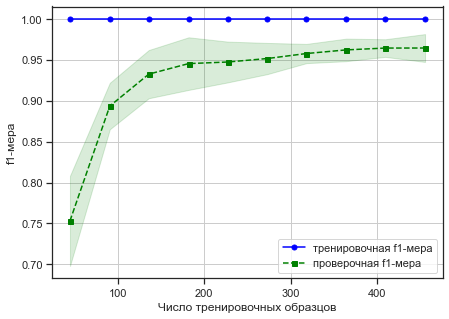

In [24]:
plot_learning_curve(data_X, data_y, boost_model)

### Итоги

In [25]:
lst_label = ['Random forest', 'Cat boost']
dc_score = {'F1-measure':[res_rfc, res_boost]}
pd.DataFrame(dc_score, index=lst_label)

,F1-measure
Random forest,0.961240
Cat boost,0.976378
